# **Feature Engineering**

Author: Wenyi (Tomas) Zhang

Futures contracts are subject to frequent rollovers, which introduce additional structural breaks and regime shifts into the price series. This characteristic poses significant challenges for time-series forecasting and further amplifies the inherent fragility of time-series-based CTA strategies. Nevertheless, developing more robust modeling frameworks under such conditions is both technically meaningful and practically valuable.

In this project, we aim to systematically investigate whether stable predictive structures can still be extracted, and whether model robustness can be improved through careful data engineering and multi-scale analysis.

The initial focus of this research is on Chinese stock index futures, which offer relatively clean microstructure and stable liquidity. Based on the results obtained at this stage, the framework will then be extended to the ferrous commodity complex, where market dynamics are more regime-driven and structurally complex, yet remain actively explored by speculative traders.

| Code | Contract Name            | Launch Date | Core Characteristics |
| :--: | :----------------------- | :---------- | :--------------------------------------------------------------- |
| IH   | SSE 50 Index Futures     | Apr 2015    | Extremely high financial sector weight, low volatility, policy-driven, strong mean-reversion behavior, weak trend persistence |
| IF   | CSI 300 Index Futures    | Apr 2010    | Large-cap benchmark, macro- and policy-sensitive, trends exist but are frequently interrupted, structurally driven market |
| IC   | CSI 500 Index Futures    | Apr 2015    | Mid-cap growth dominated, high volatility, strong trend persistence, most active for quantitative and CTA strategies |

期货合约由于频繁换月，不可避免地在价格序列中引入额外的结构性断点与状态切换。这一特性对时间序列预测提出了显著挑战，并进一步放大了基于时间序列的 CTA 策略在结构稳定性方面的固有脆弱性。尽管如此，在此类条件下构建更为鲁棒的建模框架，仍具有重要的技术意义和实际价值。在本项目中，我们旨在系统性地研究：在频繁换月和结构扰动并存的环境中，是否仍能够提取相对稳定的可预测结构，以及是否可以通过精细的数据工程与多尺度分析手段，提升模型的稳健性。

本研究的初始阶段将聚焦于中国股指期货市场，该市场具有相对干净的微观结构和较为稳定的流动性。在此阶段取得结果后，研究框架将进一步扩展至黑色系商品期货领域。相较于股指期货，黑色系品种的市场行为更具状态依赖性和结构复杂性，但仍然是投机交易者积极参与和持续研究的市场。

**Roll-Over**

try fetching bigquant_ic.csv


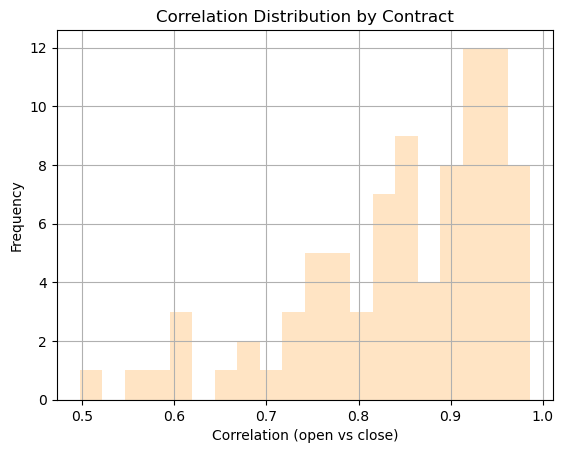

In [1]:
from contract_utilities import contract_diagnosis
import pandas as pd
import numpy as np
contract_diagnosis()

In [2]:
ics = pd.read_csv('bigquant_ic.csv')
ics['trading_code'].value_counts().sort_values(ascending = False)

trading_code
IC2406    65
IC2209    65
IC2109    65
IC2509    64
IC2309    64
          ..
IC1910    15
IC1702    13
IC1810    12
IC2010    12
IC2603     9
Name: count, Length: 86, dtype: int64

The main continuous contracts (主力合约) reported by Chinese futures exchanges are constructed as stitched series across successive active contracts. These series are typically adjusted using constant factor multiplication applied uniformly to the OHLC prices at each rollover. The effective lifespan of any individual underlying contract in the continuous series is often limited to roughly two to three months (about 40–60 trading days).

This construction introduces an artificial synchronization across the four price fields (open, high, low, and close), creating a false sense of price “resonance” that does not arise from genuine market microstructure. Such stitching effects dilute subtle technical patterns, distort volatility dynamics, and severely compromise the validity of longer-horizon technical indicators. In particular, indicators with extended lookback windows become structurally unreliable, as their statistical assumptions are violated by repeated rollovers and the resulting artificial price discontinuities, ultimately leading to the generation of spurious trading signals.

中国期货交易所发布的主力连续合约（主力合约）通常是通过将不同时期的活跃合约进行拼接而构造的。在换月时，这类连续合约一般采用对价格比例缩放的方式，对开盘价、最高价、最低价和收盘价（OHLC）进行统一调整。 在连续合约序列中，任一单一标的合约的有效存在周期通常仅为约两到三个月（约 40–60 个交易日）。

这种构造方式在四个价格字段（开盘价、最高价、最低价和收盘价）之间引入了人为的同步调整，从而形成一种并非源自真实市场微观结构的价格“共振”现象。该拼接效应会削弱细微的技术形态、扭曲波动率的动态特征，并显著降低长周期技术指标的有效性。

尤其是对于回看窗口较长的指标而言，其统计假设会在反复换月以及由此产生的人为价格不连续性影响下被破坏，最终导致交易信号中出现伪信号。

**Session Encoding**

In [3]:
from contract_utilities import session_encoding
session_encoding('bigquant_ic.csv')
session_encoding('bigquant_if.csv')
session_encoding('bigquant_ih.csv')

try fetching bigquant_ic.csv
Wrote ic_main_day.csv with 2604 rows.
try fetching bigquant_if.csv
Wrote if_main_day.csv with 2604 rows.
try fetching bigquant_ih.csv
Wrote ih_main_day.csv with 2604 rows.


It is worth clarifying that an occasionally observed—but methodologically fragile—practice is to treat price series from all futures contracts as independent observations, and then simply sort or concatenate them along the time axis to form a single time series.

We do not adopt this approach. Futures contracts differ materially in liquidity, maturity structure, and microstructure characteristics. Even when ordered by calendar time, prices from different contracts cannot be assumed to originate from a common data-generating process. Such a construction risks obscuring contract-level structural differences and introducing hard-to-interpret biases.

Based on this consideration, we introduce a contract-aware segmentation mechanism on main contract series. Contract transitions are explicitly identified using the following roll indicator:

df['trading_code'] != df['trading_code'].shift(1)


This roll flag is used to partition the time series into contract-consistent segments. All rolling statistics, differencing operators, and state-dependent feature transformations are then computed strictly within the same contract segment, preventing unintended cross-contract information from entering the feature construction process.

In principle, a more conservative approach would introduce a wider buffer around each rollover event in order to fully remove short-term disturbances caused by liquidity migration and price adjustment.

However, under the current research setting this is not practical. The effective sample size is limited (fewer than 3,000 observations), and rollovers occur relatively frequently. Excluding large windows around each rollover would therefore lead to a substantial loss of statistical power.

We therefore adopt a minimal-intervention strategy, excluding only a small number of observations immediately following each rollover (or, in the most restrictive setting, only the rollover day itself). This approach is sufficient to suppress rollover-induced structural distortions in downstream features, while preserving the majority of the sample for model estimation and evaluation.

需要特别说明的是，一种在实践中偶尔会被采用但并不严谨的做法，是将所有期货合约的价格序列视为相互独立的观测样本，并仅按照时间顺序将其拼接或排序，从而构造一条“统一”的时间序列。

我们并不采用这一处理方式。不同合约在流动性、到期结构以及市场微观结构特征上存在显著差异，即使在时间上连续排列，也难以被视为来自同一统计生成过程。该做法容易掩盖合约层面的结构性差异，并引入难以解释的系统性偏差。

基于上述考虑，我们在主力合约序列上引入合约感知的分段处理机制，并通过如下方式显式识别合约切换位置：

df['trading_code'] != df['trading_code'].shift(1)


该滚动标记（roll flag）用于将时间序列划分为合约一致的区间。在此基础上，所有滚动统计量、差分算子以及具有状态依赖性的特征变换，均严格限制在同一合约区间内计算，以避免跨合约信息在特征构造阶段被非预期地混入。

从理论上讲，更为保守的做法是在每次换月前后引入更宽的缓冲区，从而完全剔除因流动性迁移和价格调整带来的短期扰动。

但在当前研究设定下，该方案并不现实：一方面，有效样本量有限（不足 3,000 个观测）；另一方面，换月发生较为频繁，若在每次换月附近大幅剔除数据，将显著削弱统计有效性。

因此，我们采用最小干预策略，仅对换月后极少量观测（或仅对换月当日）进行屏蔽处理。该方法在有效抑制换月结构性扰动对下游特征影响的同时，最大限度地保留了可用于建模与评估的样本规模。

In [4]:
# roll flag 
pd.read_csv('bigquant_ic.csv')[19:21]

date  instrument trading_code    open   close    high     low  \
19  2015-05-14  IC8888.CFE       IC1505  8689.0  8760.4  8813.6  8645.2   
20  2015-05-15  IC8888.CFE       IC1506  8610.0  8579.8  8718.0  8482.0   

    pre_close  volume        amount  open_interest  settle  pre_settle  \
19     8695.8  112711  1.969418e+11           8971  8754.2      8690.8   
20     8603.0  182662  3.134913e+11          28064  8651.4      8593.8   

    upper_limit  lower_limit product_code  
19       9559.8       7821.8           IC  
20       9453.0       7734.6           IC

In [5]:
pd.read_csv('ic_main_day.csv')[19:21]

datetime    open   close    high     low  volume  open_interest  \
19  2015-05-14  8689.0  8760.4  8813.6  8645.2  112711           8971   
20  2015-05-15  8610.0  8579.8  8718.0  8482.0  182662          28064   

    roll_flag  
19          0  
20          1

**Intraday High-Frequency Data Processing**

In [6]:
from contract_utilities import intra_process

When no proprietary factors are included, TA-Lib–based technical indicators often exhibit weak explanatory power, especially when the modeling horizon is shifted to higher-frequency data, where execution slippage and microstructure noise become increasingly significant.

Nevertheless, at the request of Haitong Futures, this research direction is retained for systematic investigation.

Due to the absence of contract-level trading information in the intraday dataset, rollover information is inherited from the daily table. As a result, all intraday bars that fall on a rollover trading day are treated as structurally contaminated and are explicitly flagged to prevent technical indicators from being computed across contract boundaries.

在未引入自有因子的情况下，基于 TA-Lib 的技术指标通常表现出较弱的解释能力，尤其是在将建模周期下移至更高频数据时更为明显。在该情形下，交易执行滑点与市场微观结构噪声的影响显著增强，进一步削弱了传统技术指标的有效性。 尽管如此，应海通期货的要求，本研究仍保留日内研究方向，并对 60 分钟， 30分钟， 15 分钟频率 进行系统性检验。由于日内数据集中缺乏合约层面的交易信息，换月信息由日频数据表继承。因此，所有发生在换月交易日内的日内 K 线均被视为结构性污染数据，并被明确标记，以防止技术指标在不同合约边界之间进行计算。

**Asset Heterogeneity**

In [7]:
from contract_utilities import prepare_then_compare

Futures contracts are tied to fundamentally different underlying assets, which causes their return dynamics to exhibit persistent structural heterogeneity. Even within equity index futures, constituent differences—such as size, sector weights, and liquidity profiles—generate distinct microstructure patterns. As a result, when formulating next-period return forecasting as a machine-learning problem, it is inherently difficult to extract stable and universal trend-following rules across all assets.

Nonetheless, the objective of this project is to maximize generalizability. We adopt a multi-cycle, multi-horizon factor-coding framework, where indicators are constructed across several temporal scales. The working assumption is that if an asset exhibits sustained speculative participation and structural inefficiency, then at least one temporal window will be aligned with its dominant behavioral mode.

期货合约背后的基础资产各不相同，其收益结构也因此呈现出长期且系统性的异质性。即便在股指期货内部，不同指数的成分股在规模、行业权重、流动性上均存在差异，从而导致显著的微观结构差异。因此，当我们将下一周期收益预测视为一个机器学习问题时，想要在所有资产上提取稳定且普适的趋势信号本身就是困难的。

本项目的目标仍然是最大化可泛化性。我们采用多周期、多时间尺度的因子编码框架，在不同周期上构建指标。其基本假设是：如果某个资产具备持续的投机参与和结构性低效，那么一定会有某个时间尺度能够捕捉其主导动态。

| **Concept**                 | **Variable / Formula (Corrected)**                     | **Measures**                    | **Economic Meaning**                                    |                    |                                   |
| --------------------------- | ------------------------------------------------------ | ------------------------------- | ------------------------------------------------------- | ------------------ | --------------------------------- |
| **dOI**               | `open_interest.diff()` *(signed)*                      | Position count change           | Speculator entry/exit; flow pressure; regime shifts     |                    |                                   |
| **Gap**               | `(open - prev_close) / prev_close` → **`abs(gap)`**    | Overnight discontinuity         | News/policy shock sensitivity; execution risk           |                    |                                   |
| **Return r1**          | `log(close_t / close_{t-1})`                           | Total daily movement            | Price discovery; tradable amplitude                     |                    |                                   |
| **Range/Open**        | `(high - low) / open` → always **positive**            | Intraday volatility             | Trading intensity; liquidity stress                     |                    |                                   |
| **ATR20/Close**       | `ATR(20) / close` → **positive**                       | Multi-day volatility            | Market turbulence; friction level                       |                    |                                   |
| **RV10**             | `std(r1, window=10)` → **positive**                    | Local realized vol              | Signal-to-noise environment                             |                    |                                   |
| **ACF(1)**           | `corr(r1, r1.shift(1))` *(signed)*                     | Linear dependence               | Trend-following (positive) vs mean-reversion (negative) |                    |                                   |
| **VR5**              | `var(r5) / (5 * var(r1))` *(positive)*                 | Multi-step dependence           | Persistence (VR>1) or microstructure noise (VR<1)       |                    |                                   |
| **Sign Persistence** | `mean(sign(r1)==sign(r1.shift(1)))` | Directional continuity          | CTA exploitable directional smoothness                  |                    |                                   |
| **Signal-to-Noise**    | `abs(mean(r1)) / std(r1)`           | Drift strength                  | Trend clarity; modelability of momentum                 |                    |                                   |
| **Tail Ratio**        | `quantile(abs(r1), 0.99) / median(abs(r1))`            | Fat-tail severity               | Jump risk; convexity exposure                           |                    |                                   |
| **Jump Prob.**        | `prob(abs(r1) > 3 * std(r1))`                          | Extreme-move frequency          | Shock-driven risk; instability                          |                    |                                   |
| **Roll Frequency**    | `sum(roll_flag) / N`                                   | Contract turnover regularity    | Operational complexity                                  |                    |                                   |
| **Roll Vol Ratio**  | `std(abs(r1_roll)) / std(abs(r1_nonroll))`             | Volatility distortion near roll | Microstructure disturbance                              |                    |                                   |
| **Roll Gap Ratio**   | `median(abs(gap_roll)) / median(abs(gap_nonroll))`     | Price discontinuity during roll | Rollover execution difficulty                           |                    |                                   |

In [8]:
IC,IH,IF = pd.read_csv('ic_main_day.csv'), pd.read_csv('ih_main_day.csv'), pd.read_csv('if_main_day.csv')

                   IC (CSI500)    IH (SSE50)   IF (CSI300)
N                  1940.000000   1870.000000   1884.000000
med_|r1|              0.007311      0.006358      0.006716
p95_|r1|              0.038251      0.029709      0.030595
med_rv10              0.012008      0.010486      0.010561
med_ATR20/Close       0.018105      0.015823      0.015629
med_Range/Open        0.016209      0.013998      0.013877
share_|gap|>0.5%      0.188660      0.224599      0.207006
ACF1_r1               0.046246     -0.030391      0.014926
p_ACF1                0.041658      0.188770      0.517071
ACF5_r1              -0.021292      0.053171      0.025893
VR5                   0.973227      0.931247      0.947968
p_VR5                 0.995633      0.986045      0.990923
z_VR5                -0.005473     -0.017491     -0.011376
skew_r1              -0.564164     -0.007341     -0.240675
kurt_r1               9.224977      9.116042      9.138150
med_volume        23272.500000  22914.500000  35344.5000

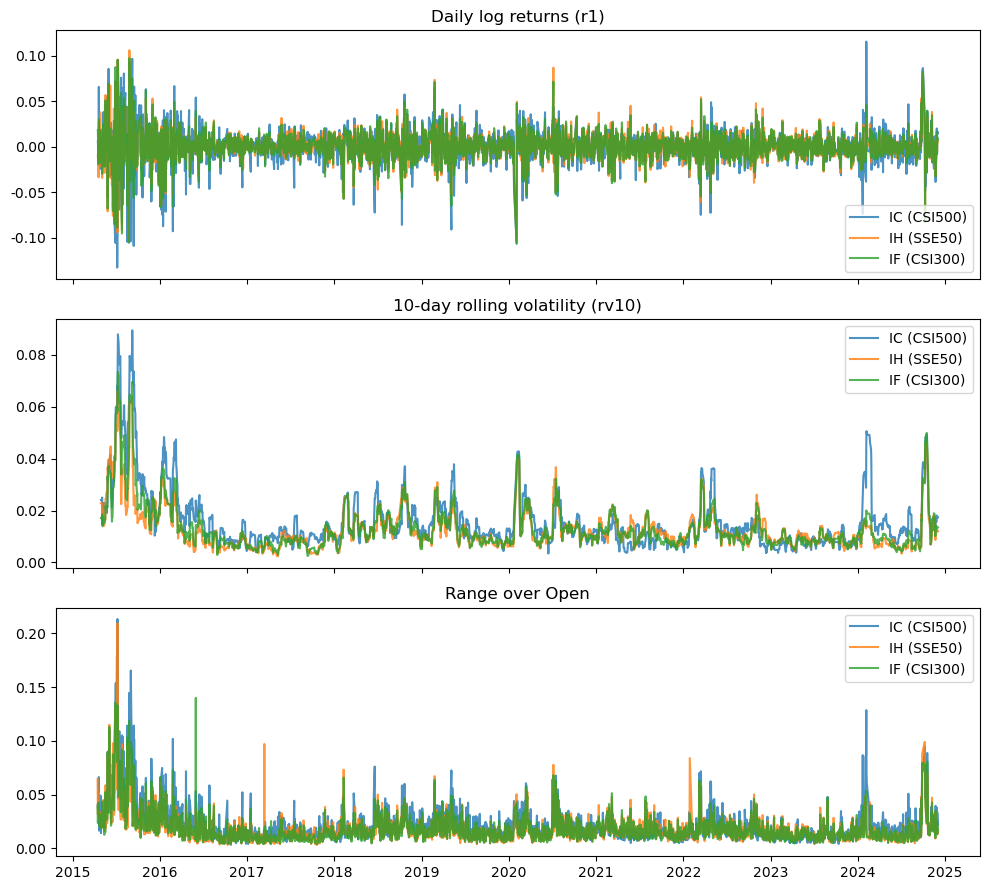

In [9]:
tbl2, prepared2 = prepare_then_compare({'IC (CSI500)': IC, 'IH (SSE50)': IH, 'IF (CSI300)': IF}, train_ratio=0.9)

Across the three index futures—IC (CSI500), IH (SSE50), and IF (CSI300)—daily log returns exhibit a highly synchronized temporal pattern. Volatility spikes tend to occur on the same dates, reflecting shared exposure to systemic macro and policy shocks. This confirms the dominance of a common market-level factor in Chinese equity index futures.

Despite this synchronization, the contracts differ materially in amplitude and microstructure. IC consistently shows the largest return swings, consistent with its small-cap composition and higher beta. IH displays the smoothest behavior, supported by mega-cap constituents and stronger institutional anchoring, while IF lies between the two. Rolling 10-day realized volatility reinforces this stable risk ordering: IC > IF > IH.

Flow dynamics further sharpen these distinctions. IC’s average daily change in open interest is substantially higher than both IF and IH, indicating faster position turnover, stronger speculative participation, and more frequent regime transitions. This aligns with IC’s heavier tails, higher jump probability, and pronounced negative skew. By contrast, IH’s low open-interest variability reflects a more stable, institutionally dominated market with smoother microstructure and weaker short-term amplification. IF again occupies an intermediate regime.

Taken together, IC behaves as a high-beta, flow-sensitive instrument with strong short-horizon dynamics and elevated convexity risk, while IF and IH progressively transition toward more stable and less reactive market structures.

在 IC（中证500）、IH（上证50）与 IF（沪深300）三类股指期货中，日度对数收益在时间结构上高度同步：波动率峰值往往出现在相同日期，反映出它们对宏观与政策冲击的共同暴露。这表明中国股指期货市场中存在显著的系统性共同因子。

尽管时间上同步，三类合约在波动幅度与微观结构上仍存在稳定差异。IC 的收益波动始终最大，符合其中小盘股占比高、β 值较大的特征；IH 由于以超大市值股票为主、机构参与度高，表现最为平稳；IF 则介于两者之间。滚动 10 日波动率清晰地刻画了这一风险排序：IC > IF > IH，且在时间上保持稳定。

从资金与持仓角度看，这一差异更加明显。IC 的日均持仓变动幅度显著高于 IF 与 IH，反映出更快的仓位更替、更强的短期投机参与以及更频繁的状态切换。这与 IC 更厚的尾部、更高的跳跃概率以及更明显的负偏度高度一致。相比之下，IH 的持仓变化极为平缓，体现出以机构资金为主、微观结构更稳定的市场特征；IF 仍处于中间状态。

综合来看，IC 更像是一种高 β、对资金流高度敏感、短期动量与凸性风险突出的交易品种，而 IF 与 IH 则逐步过渡到结构更稳定、反应更温和的市场形态。


=== Loading bigquant_ic.csv ===
Removed 18 artifact intervals: [91.0, 91.0, 89.0, 92.0, 92.0, 91.0, 90.0, 91.0, 92.0, 92.0, 89.0, 99.0, 91.0, 91.0, 91.0, 91.0, 90.0, 91.0]


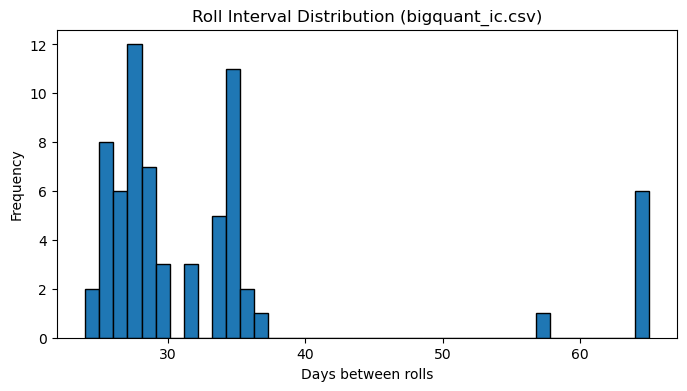


=== Loading bigquant_if.csv ===
Removed 12 artifact intervals: [1.0, 92.0, 91.0, 92.0, 91.0, 96.0, 93.0, 90.0, 92.0, 91.0, 90.0, 91.0]


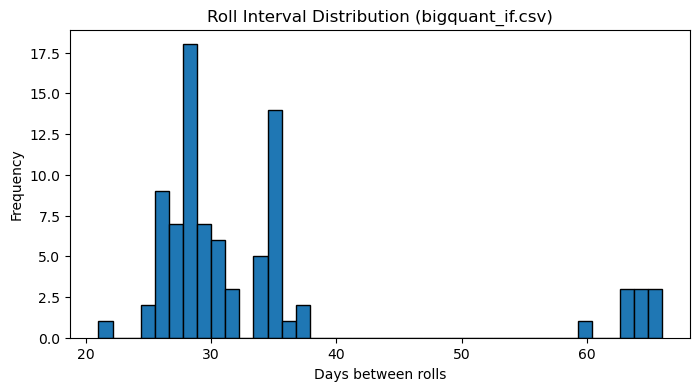


=== Loading bigquant_ih.csv ===
Removed 9 artifact intervals: [92.0, 91.0, 96.0, 94.0, 90.0, 91.0, 91.0, 90.0, 92.0]


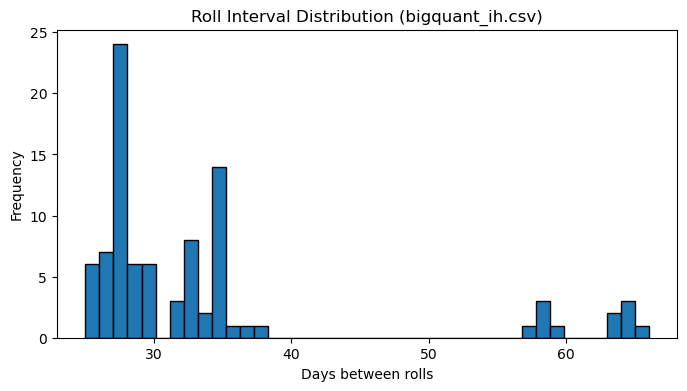

file  n_contracts  avg_contract_len  med_contract_len  \
0  bigquant_ic.csv           86         30.279070              22.0   
1  bigquant_if.csv           98         26.571429              20.5   
2  bigquant_ih.csv          100         26.040000              21.0   

   min_contract_len  max_contract_len  roll_count       mean  median  \
0               9.0              65.0          67  33.626866    29.0   
1               1.0              65.0          85  33.964706    29.0   
2               7.0              66.0          90  34.133333    30.0   

         std   min   q25   q75   max  boundary_load  
0  10.958373  24.0  28.0  35.0  65.0       0.172414  
1  11.464694  21.0  28.0  35.0  66.0       0.172414  
2  10.716154  25.0  28.0  35.0  66.0       0.166667

In [10]:
from factors_robust import contract_roll_structure
ic = contract_roll_structure('bigquant_ic.csv')
if_ = contract_roll_structure('bigquant_if.csv')
ih = contract_roll_structure('bigquant_ih.csv')
pd.DataFrame([ic, if_, ih])

Although IC, IF, and IH differ markedly in liquidity and flow characteristics, their rollover frequencies are statistically indistinguishable. After excluding artifact intervals introduced by contract stitching, all three exhibit rollover spacing concentrated in the 20–35 trading day range, with nearly identical medians and interquartile ranges.

Given this rollover frequency, once the data are segmented by contract, the effective length of each continuous regime is inherently limited. As a result, long rolling windows or multi-span statistics become impractical, regardless of the underlying instrument.

尽管 IC、IF 和 IH 在流动性与资金流动特征上存在显著差异，但其主力合约换月频率在统计意义上并无明显区别。在剔除由合约拼接机制引入的异常区间后，三者的换月间隔均集中在 20–35 个交易日区间内，中位数与分布范围高度一致。

在这一换月频率水平下，一旦按合约进行分段建模，每个连续样本区间的有效长度本身就受到严格限制。因此，较长的滚动窗口或多跨度统计在分段框架下通常难以实施，且这一约束对所有合约同样存在。

**Evaluations of Factors**

Factor zoo remains a controversial topic of time-series forecasting.

Although tree-based algorithms are often argued to be capable of automatically exploring feature spaces and discarding irrelevant inputs with high efficiency, this does not eliminate deeper structural risks. In practice, the objective of minimizing RMSE is not always aligned with capturing economically meaningful behavior and this misalignment can introduce spurious predictive patterns (a common pattern of flat line with some spikes).

Moreover, when features exhibit extremely high mutual correlation, near-random fluctuations among redundant variables combine with greedy nature of tree algorithm can lead to drastically different tree-growth paths, undermining model stability and interpretability.

Out of these concerns, a robust factor examination framework is necessary to control factor overcrowding, enforce economic consistency, and promote more reliable pattern recognition under time-varying market regimes.

因子堆砌现象（factor zoo）在时间序列预测领域始终是一个存在争议的话题。 尽管树模型算法常被认为能够高效地自动探索特征空间， 并在训练过程中筛除无关输入，但这并不能消除更深层次的结构性风险。 在实际应用中，以最小化 RMSE 为目标的优化过程并不总是与刻画具有经济含义的行为保持一致，这种目标错配往往会引入伪预测结构（典型表现为整体接近水平、仅夹杂少量尖峰的预测形态）。

此外，当特征之间存在极高的相互相关性时，冗余变量之间近似随机的微小波动，与树模型本身的贪婪生长特性相结合，可能导致截然不同的树生长路径，从而削弱模型的稳定性与可解释性。

基于上述考虑，有必要建立一套稳健的因子检验框架，用以控制因子拥挤问题、约束经济一致性，并在市场状态随时间变化的环境中，促进更为可靠的模式识别。

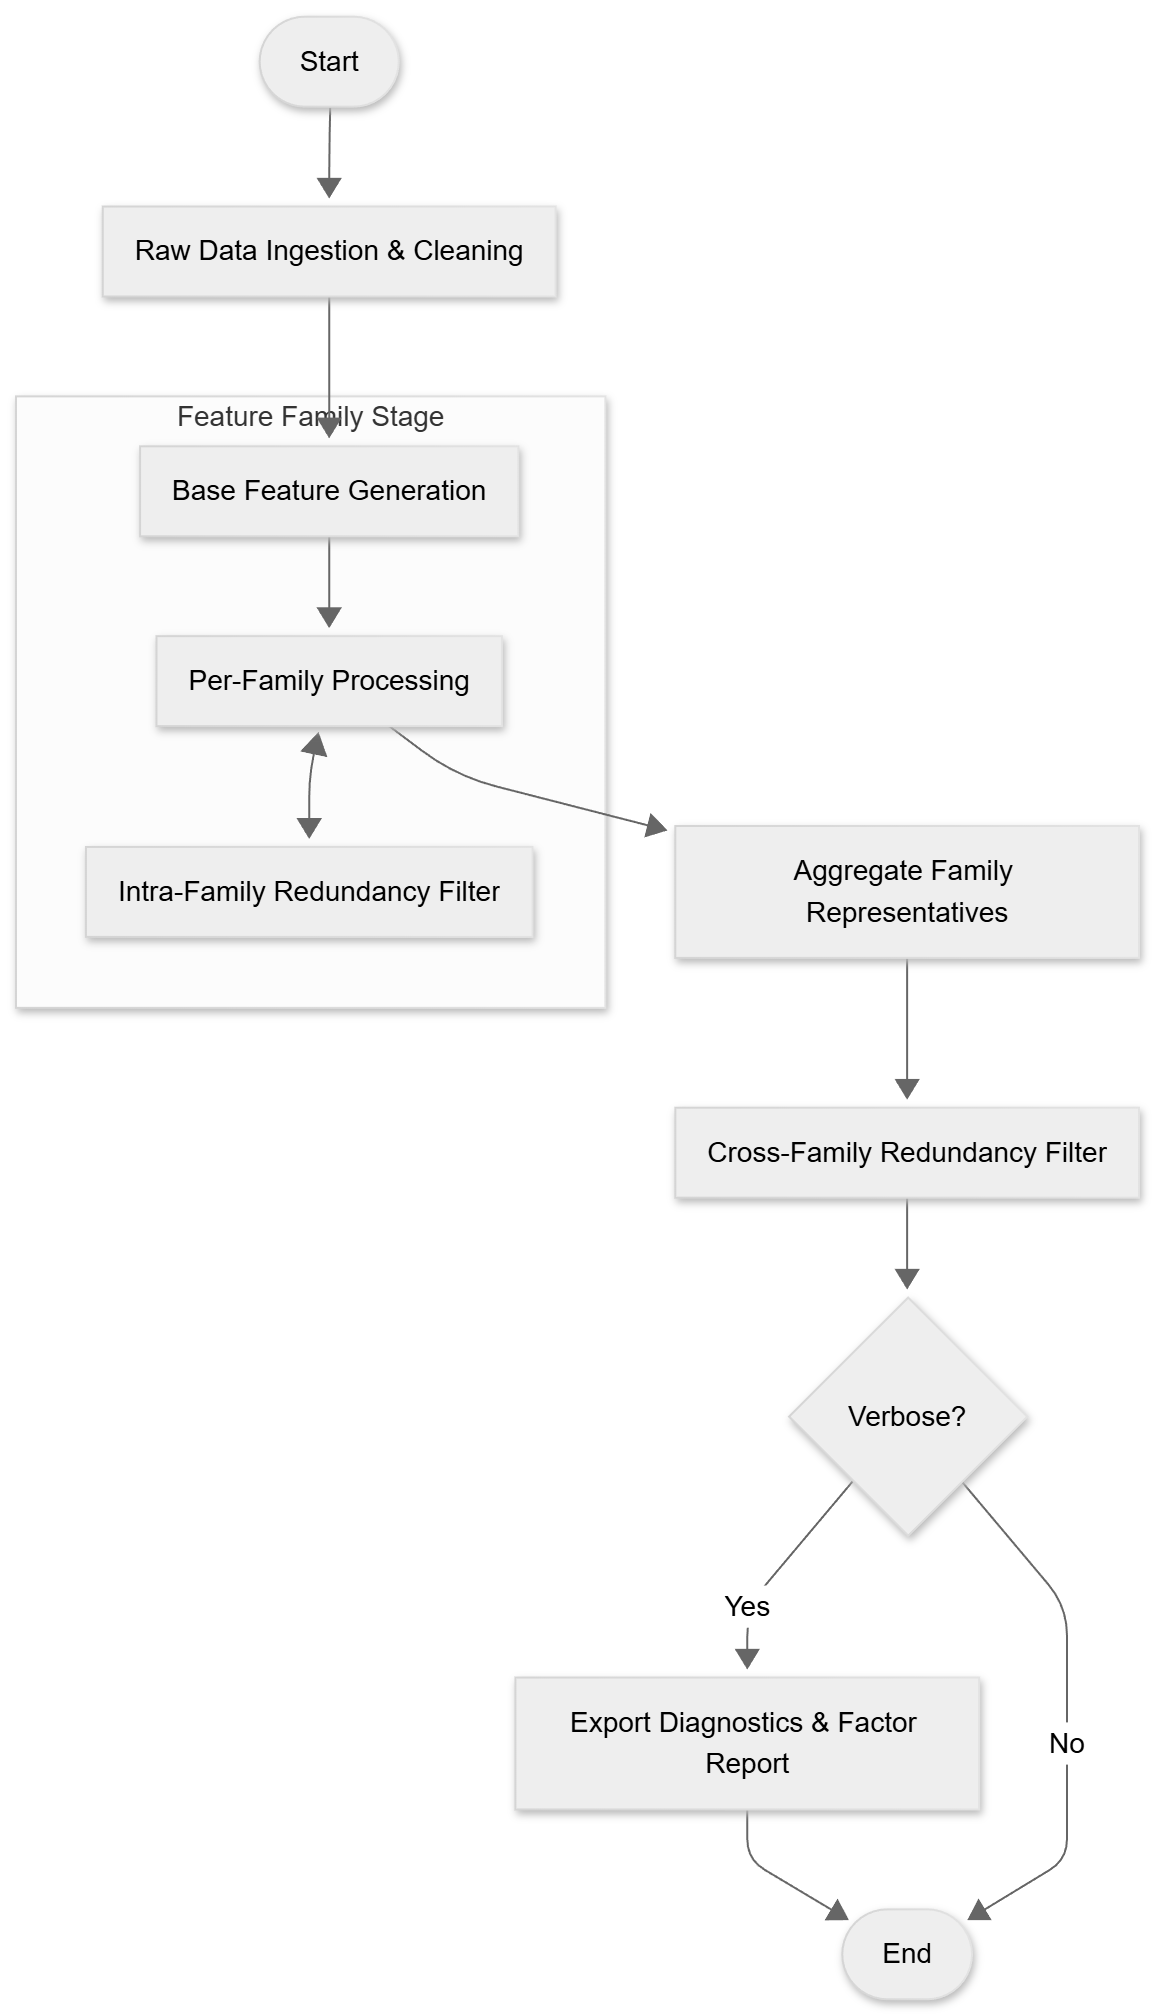


To mitigate factor redundancy and enhance model robustness, we implement a two-stage factor management framework that combines economic intuition with statistical validation.

For factor management and redundancy control, we adopt a factor family framework inspired by common sell-side practices (e.g., UBS-style taxonomy), grouping related signals by their economic intuition and statistical behavior. Within each family, rolling cross-factor correlation is evaluated using up to 90% of the available sample to mitigate lookahead bias.

The 0.9 cutoff is chosen to remain consistent with the subsequent rolling - embargoed cross-validation scheme used in model training. Factors that exhibit persistently high pairwise correlation are treated as functionally redundant and are systematically pruned, in order to control factor overcrowding, reduce instability in tree-based learning, and improve the robustness of pattern extraction.

为降低因子冗余并提升模型的稳健性，我们采用了一套两阶段的因子管理框架，将经济直觉与统计检验相结合。 在因子管理与冗余控制方面，我们借鉴常见卖方研究中的因子家族划分方法（例如 UBS 风格的分类体系），依据因子的经济含义和统计行为，将相关信号归入同一因子家族。

在每个因子家族内部，采用滚动的跨因子相关性评估，并最多使用可用样本的 90%，以降低前窥偏差（look ahead）的风险。选择 0.9 作为截断比例，是为了与模型训练阶段所采用的滚动–禁运（embargoed）交叉验证方案保持一致。对于在时间上持续表现出较高两两相关性的因子，视其在功能上存在冗余，并进行系统性剔除，以控制因子拥挤问题、降低树模型学习过程中的不稳定性，并提升模式提取的稳健性。

To evaluate the overall quality and robustness of each factor, we further construct a composite **QSL (Quality Scoring Level)**  based on the following components:

为评估各因子的整体质量与稳健性，我们进一步构建了一个综合质量评分指标 QSL（Quality Scoring Level），其由以下几个组成部分构成

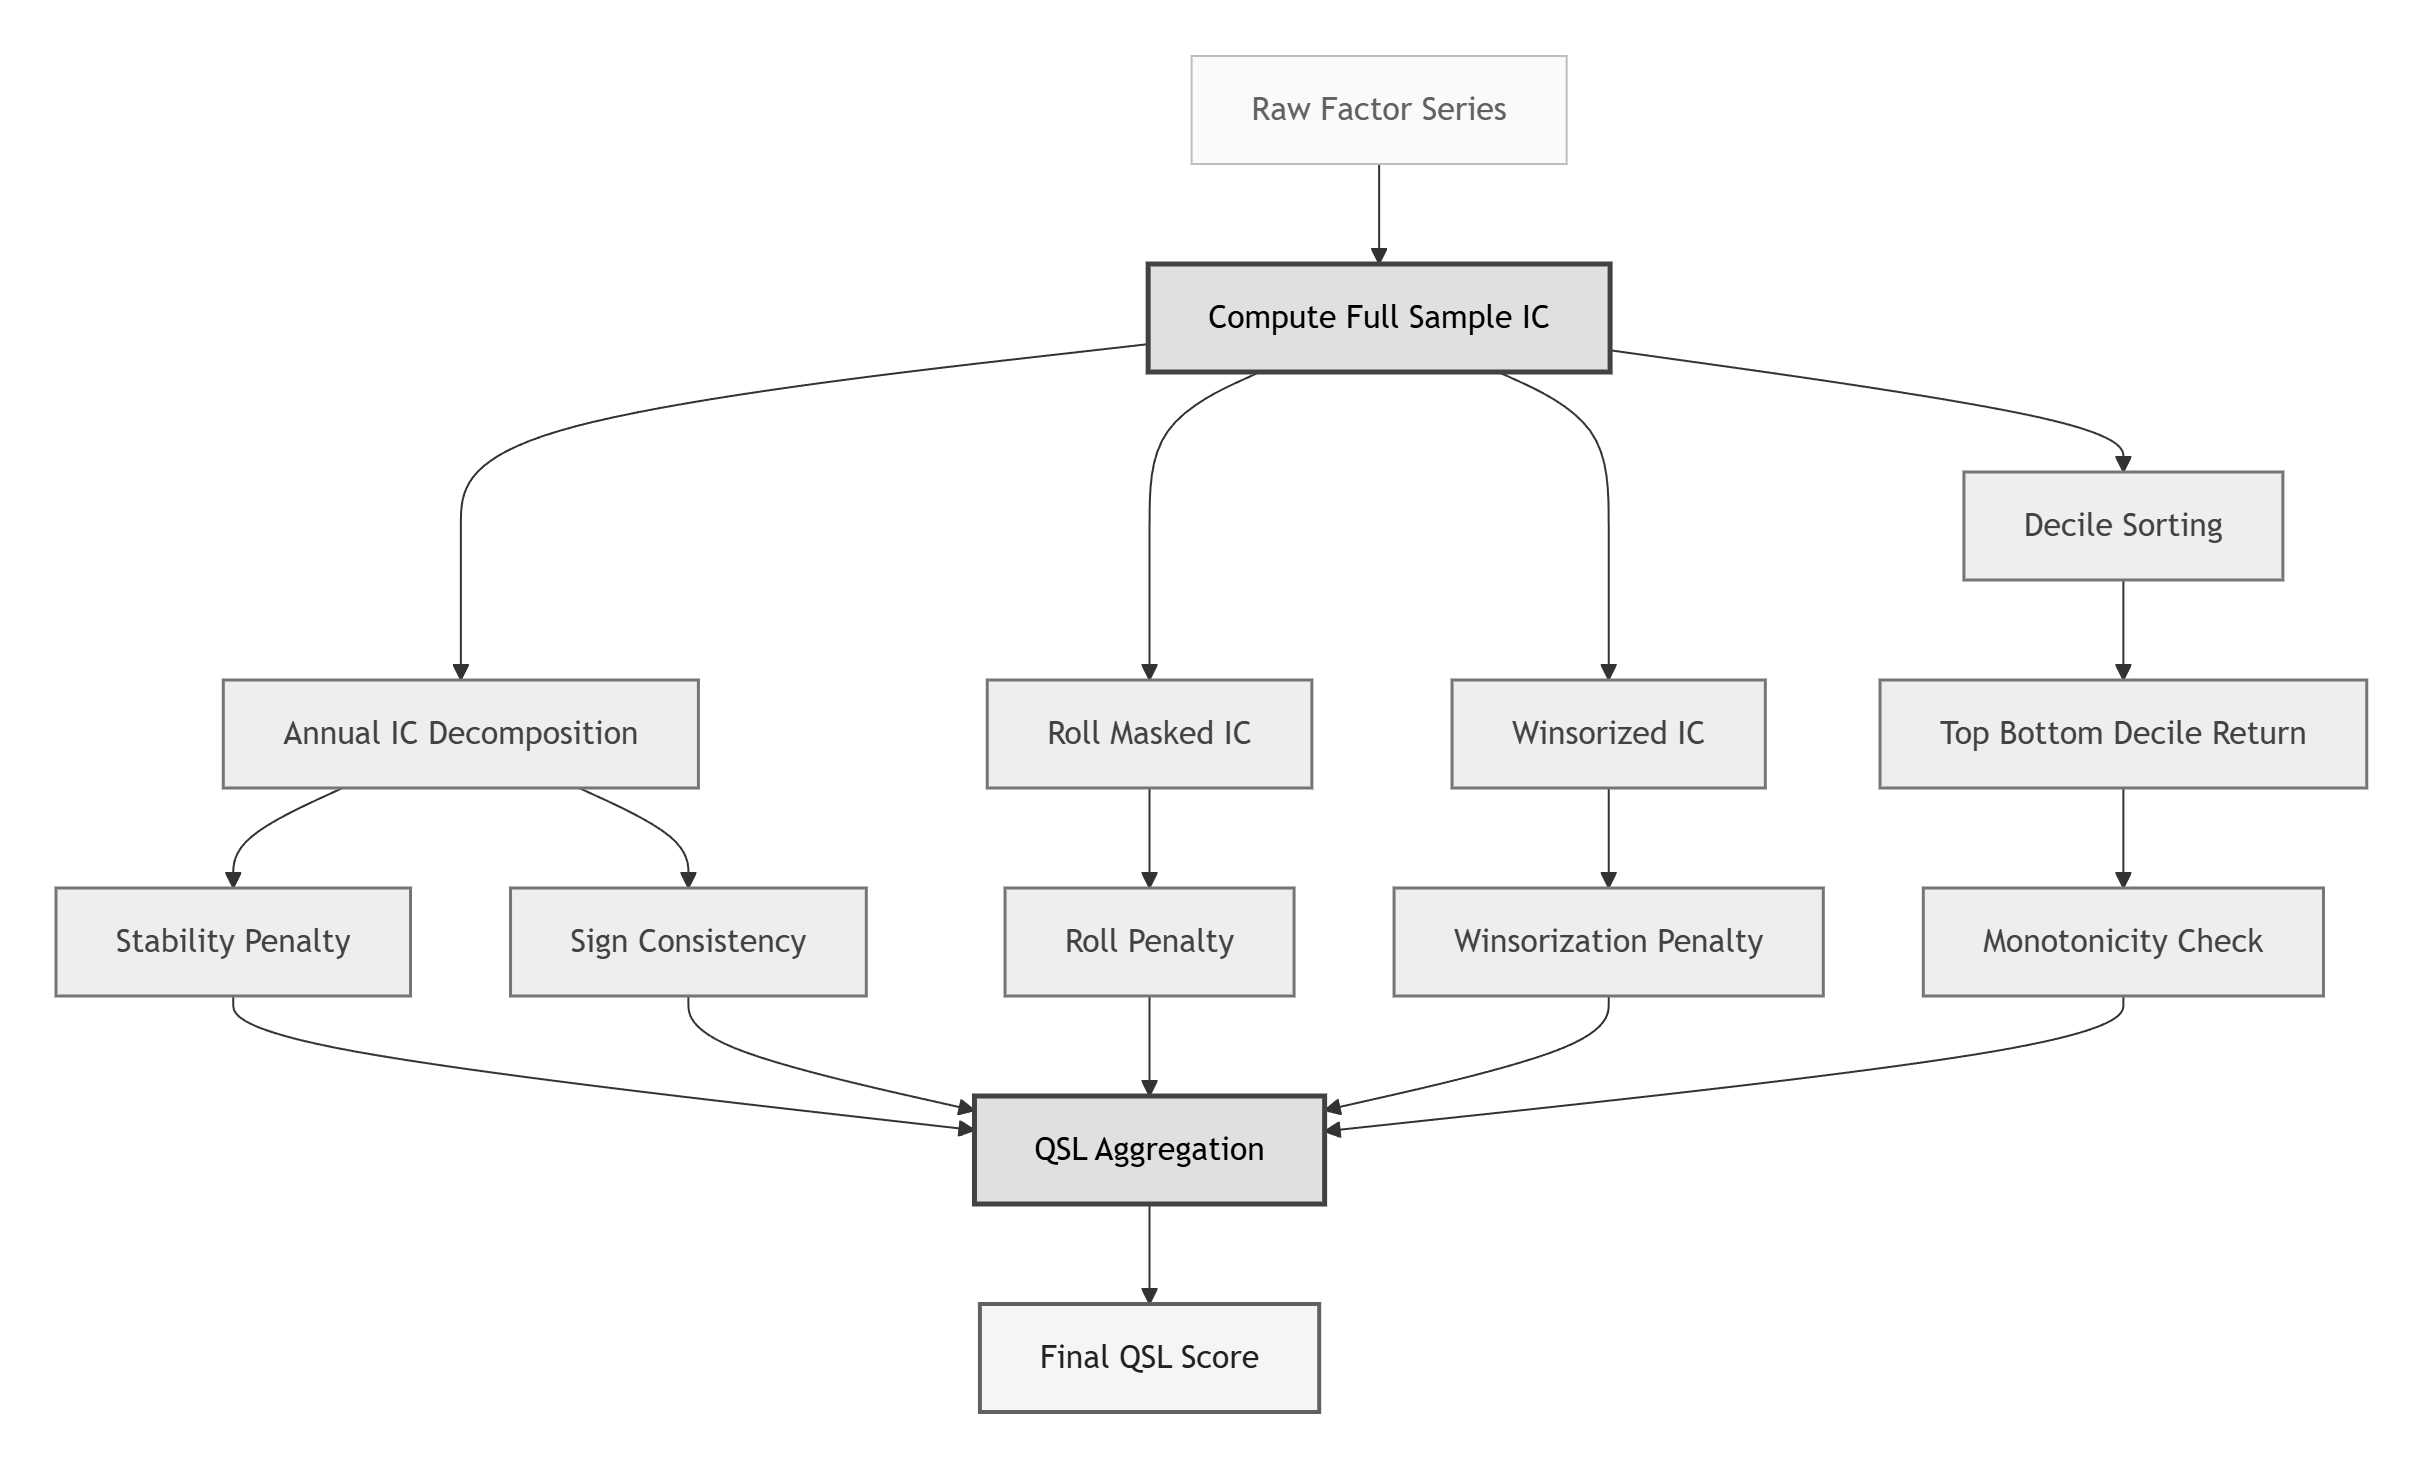

| Component        | Metric                             | Purpose                |
| ---------------- | ---------------------------------- | ---------------------- |
| IC Strength      | Pearson / Spearman / Kendall       | Raw predictability     |
| Stability        | Std of annual Spearman IC          | Time robustness        |
| Roll Penalty     | IC degradation after roll masking  | Roll contamination     |
| Winsor Penalty   | IC degradation after winsorization | Tail dependency        |
| Monotonicity     | Decile long–short return           | Economic validity      |
| Sign Consistency | Share of years with same IC sign   | Directional robustness |
| **QSL**          | Weighted aggregate                 | Fast screening score   |


Although the weighting scheme is partially **heuristic and reflects subjective judgment**, the primary purpose of the QSL is fast **factor screening**. Final selection and allocation decisions are deferred to the downstream algorithmic process.

尽管权重设定在一定程度上具有启发式性质并包含主观判断，但 QSL 的主要用途在于对因子进行快速筛。最终的因子选择与配置决策将交由下游的算法化流程完成。

In [11]:
from factors_technical import treemodel_factors_daily
from factors_robust import treemodel_factors_augment, treemodel_factors_augment_loose
from factors_robust import plot_ic_compare_two_panel, plot_roll_penalty_compare_two_panel, plot_roll_mask_diagnostics
from factors_utilities import corr_check, factor_summary

#### **Hilbert Transformation**

The Hilbert transformation reflects a modeling view in which asset prices evolve through local cyclical dynamics rather than moving monotonically in a single direction. Even within sustained trends, prices frequently exhibit oscillatory behavior characterized by alternating phases of acceleration, deceleration, drawdown, and rebound. These recurring structures form the basis of what we refer to as market cycles.

The Hilbert transformation is designed to extract key attributes of such cycles, most notably the instantaneous phase and dominant cycle period, which together characterize the market’s local rhythmic state. These quantities provide a compact description of regime transitions and changes in market tempo that are not easily captured by time-domain indicators alone.

In continuous main-contract series construction, earlier contracts are typically back-adjusted to align with later ones. While this procedure ensures price continuity, it introduces time-varying scale distortions: price fluctuations in earlier periods are mechanically rescaled, making absolute price changes non-comparable across time. This effect is particularly problematic for amplitude-sensitive technical indicators and frequency-domain methods.

Applying the Hilbert transformation to log prices partially mitigates this issue. The log transformation converts multiplicative price dynamics into an additive structure, compressing proportional differences introduced by contract stitching into level shifts rather than scale changes. As a result, cycle-related quantities such as phase and instantaneous frequency become more stable and interpretable across contracts.

Finally, this formulation is naturally aligned with our modeling objective, which focuses on predicting log returns rather than raw price changes, ensuring internal consistency between feature construction and target definition.

Hilbert 变换反映了一种建模视角：资产价格并非以单一方向单调演化，而是呈现出局部的周期性动态。即便在持续的趋势行情中，价格也往往表现出振荡结构，交替经历加速、减速、回撤与反弹等阶段。这类反复出现的结构构成了本文所称的“市场周期”。

Hilbert 变换旨在刻画此类周期的关键属性，尤其是瞬时相位（instantaneous phase）与主导周期长度（dominant cycle period）。二者共同描述了市场在局部时间尺度上的节律状态，为刻画市场节奏变化与状态切换提供了一种紧凑而有效的表示方式，这些信息通常难以通过传统时域指标直接捕捉。

在主力合约连续序列的构建过程中，通常会通过后复权（back-adjustment）的方式将早期合约价格对齐至后续合约，从而保证价格序列的连续性。然而，该处理方式会引入随时间变化的尺度扭曲：早期样本中的价格波动被机械性地重新缩放，导致不同时期的绝对价格变动在经济意义上不再具备可比性。这一问题对依赖幅度信息的技术指标，尤其是频域方法，影响尤为显著。

将 Hilbert 变换应用于对数价格可以在一定程度上缓解上述问题。对数变换将价格的乘性动态转化为加性结构，使由合约拼接引入的比例差异表现为水平位移而非尺度变化。由此，诸如相位与瞬时频率等周期相关量在不同合约之间表现得更加稳定且易于解释。

最后，该处理方式与本文的建模目标天然一致。由于模型以对数收益而非原始价格变动作为预测对象，在特征构建阶段采用对数价格能够确保特征空间与目标变量之间在形式与经济含义上的一致性。

**Circular Difference**

For angular data, differences must respect the circular nature of degrees. A naïve subtraction can easily lead to misleading conclusions—for example, treating 358° as being far from 0°, even though they are only 2° apart on the circle.

To address this, we apply a circular difference transformation, mapping all angular changes into a hand-fan–shaped interval from −180° to +180°. This ensures that all degree differences are measured along the shortest arc on the circle, preserving true geometric proximity.

对于角度型数据，其差分计算必须尊重角度的环状特性。若直接进行简单相减，容易产生误导性的结果——例如，将 358° 视为与 0° 相距甚远，尽管二者在圆周上的实际间隔仅为 2°。

为此，我们采用环形差分（circular difference）变换，将所有角度变化映射至 −180° 到 +180° 的扇形区间内。该处理方式确保所有角度差异均沿圆周上的最短弧度进行度量，从而保留真实的几何邻近关系。

**Roll Awareness in Computation**

In feature construction, we adopt a forward-only roll padding strategy, under which a small number of observations immediately following each contract rollover are excluded from feature computation. This asymmetric design reflects practical production constraints: future rollover events are not observable ex ante, whereas post-roll observations can be reliably identified in real time and treated conservatively. As a result, features are never computed using samples that may still be contaminated by transient effects associated with contract switching.

By contrast, the roll-penalty calculation in QSL employs a centered exclusion window around rollover events. This design is **intentional and serves a strictly diagnostic purpose**. Feature construction must respect causal availability, whereas QSL operates as an ex post evaluation tool and is therefore not subject to real-time information constraints. Centered masking thus functions as a symmetric stress test, assessing whether a factor’s apparent predictive performance is disproportionately supported by observations in the immediate vicinity of contract rollovers.

All features are uniformly shifted backward by one bar using contract-aware lagging (seg lag) to eliminate any potential look-ahead bias. The combined effects of roll masking, contract-aware segmentation, and lagging naturally increase the prevalence of missing values, particularly for rolling-window operators. As a consequence, **roll-adjacent observations may be partially or fully removed prior to diagnostic evaluation, limiting the observability of rollover dependence in isolated settings**.

It is important to note that rollover dynamics **themselves may contain predictive structure**. Overly aggressive masking can significantly reduce the effective sample size and simultaneously suppress informative signals related to rollover behavior, thereby impairing model learning. To balance this trade-off, we introduce a more lenient alternative specification (factors augment loose). Under this specification, selected features are shifted by one bar but are not subject to contract-aware lagging, allowing the model to retain limited exposure to rollover dynamics under controlled conditions.

In addition, **explicit rollover-related features are introduced in subsequent modeling stages** to directly assess whether rollover structure materially influences model behavior.

Importantly, the roll-penalty metric adopted in this study has a deliberately constrained diagnostic objective. It is not intended to determine whether a factor is structurally free of rollover effects. Rather, it evaluates whether a factor’s measured predictive performance depends, in a statistical sense, on observations adjacent to contract rollovers.

By definition, a positive roll penalty is recorded only when excluding roll-adjacent observations leads to a deterioration in global rank correlation. If exclusion leaves correlation unchanged or improves it, the roll penalty is explicitly defined as zero. Consequently, a zero roll penalty should not be interpreted as evidence that a factor is unaffected by rollover mechanics, but rather that its predictive signal is not statistically supported by roll-adjacent observations under the given data availability and masking scheme.

This distinction is particularly relevant for factors such as DC_Period_Slope_5, which are derived from Hilbert-based cycle estimates combined with inter-temporal differencing. Without explicit segmentation, such constructions are susceptible to state crossover near contract boundaries. However, when roll-adjacent observations contribute little or negatively to overall rank correlation, their removal does not weaken predictive performance. In such cases, reporting a zero roll penalty is both appropriate and consistent with the metric’s definition.

Accordingly, roll penalty is treated as a conservative, relative diagnostic, interpreted jointly with sign consistency and rank-based correlation measures when assessing overall factor quality, rather than as a definitive indicator of absolute rollover robustness.

在特征构造阶段，我们采用仅向前的换月缓冲策略，即对每次合约切换后紧随其后的少量观测值不参与特征计算。该非对称设计源于实际生产约束：未来的换月时点在事前不可观测，而换月后的数据在实时环境中可以被可靠识别并保守处理。因此，所有特征均避免使用可能仍受到合约切换瞬态影响的观测样本。

与此不同，QSL 中的换月惩罚（roll penalty）计算采用以换月点为中心的对称剔除窗口。该设计具有明确且**受限的诊断目的**。特征构造阶段必须严格遵循因果可用性，而 QSL 作为事后评估工具，不受实时信息约束。对称剔除可视为一种压力测试，用以检验因子的表观预测能力是否在统计意义上过度依赖于换月前后极近邻样本。

所有特征在最终使用前均统一进行合约感知的一阶滞后处理（seg lag），以彻底消除潜在的前视偏差。换月屏蔽、合约感知分段以及统一滞后的叠加效应，会自然提高缺失值比例，尤其对滚动窗口类算子影响更为明显。因此，在单独评估中，**部分换月邻近样本可能在诊断前已被缺失值机制隐式剔除，从而限制了换月依赖性的可观测性**。

需要指出的是，**换月过程本身可能蕴含一定的可预测结构**。若屏蔽策略过于激进，不仅会显著压缩有效样本量，还可能直接抹除与换月相关的预测信息，从而不利于模型学习。基于这一权衡，我们引入一种更为宽松的替代方案（factors augment loose）：在保持统一 one-bar 滞后的前提下（仅进行 shift，不施加 seg lag），对部分特征不进行合约感知滞后处理，使模型能够在受控条件下保留有限的换月动态信息。

此外，我们在后续建模阶段**显式引入换月效应相关特征**，以直接评估换月结构是否会对模型行为产生实质性影响。

需要强调的是，本文采用的换月惩罚指标具有刻意受限的诊断目标。该指标并非用于判断某一因子在结构上是否完全不受换月影响，而是用于评估该因子的预测表现是否在统计意义上依赖于换月邻近样本。

在定义上，仅当剔除换月邻近样本导致整体秩相关显著下降时，才记录为正的换月惩罚；若剔除后相关性保持不变甚至改善，则换月惩罚被明确定义为零。因此，零换月惩罚并不意味着因子不受换月机制影响，而仅表示在当前数据可用性与屏蔽设定下，其预测信号并未在统计上依赖于换月邻近样本。

这一点对于诸如 DC_Period_Slope_5 等因子尤为重要。该类因子基于 Hilbert 周期估计并结合跨期差分构造，若缺乏显式分段，容易在合约边界附近发生状态混叠。然而，当换月邻近样本对整体秩相关的贡献有限甚至为负时，其剔除并不会削弱预测能力，此时报告零换月惩罚是合理且符合定义的。

因此，换月惩罚被视为一种保守的相对诊断指标，应与符号一致性及秩相关指标结合解读，而不应被视为衡量因子绝对“换月安全性”的唯一标准。

**Comparison Class**

To establish a reference point, we construct a relatively simple baseline factor set by revisiting and lightly modifying a previously abandoned research program developed by an external vendor. This baseline treats the continuous main futures contract as a single time series and applies TA-Lib indicators with minimal adjustment, reflecting a commonly used off-the-shelf approach rather than a fully optimized solution. Its primary purpose is to serve as a reference for assessing whether the proposed feature-engineering pipeline delivers incremental value beyond standard implementations.
We note that the engineered library is substantially larger and more structurally complex than this baseline, and the comparison is therefore not intended to be one-to-one. Given practical constraints in time and resources, the TA-Lib baseline is intentionally kept lightweight. Under this setup, evaluating relative statistics—such as the proportion of effective signals—remains a reasonable and informative way to gauge systematic improvements over widely adopted practices.

为建立参考基准，我们构建了一组相对简单的因子集合，该实现主要整理并复用自此前一次由外包团队完成但未能成功落地的研究程序，并在此基础上进行有限整理与修订。该基准将期货主力连续合约视为连续时间序列，并直接应用 TA-Lib 指标，仅作最小化修改，整体上反映的是较为常见的现成做法，而非经过系统优化的方案。其主要目的在于作为对照参考，用以检验所提出的特征工程流程是否能够在此类通用实现之上带来增量改进。
需要指出的是，工程化因子库在规模与构造复杂度上均显著高于该基准，因此本实验并不意在进行严格的一对一比较。在实际人力与时间资源受限的背景下，我们有意将该 TA-Lib 基准保持为轻量化实现。在这一设定下，通过比较相对统计指标（如有效因子占比）来评估所提出方法相对于常见实践的改进程度，仍然是一种合理且具有参考价值的设计。

**Rotation of time series**

In the Hilbert analytic signal framework, phase rotation is defined as proceeding counterclockwise on the complex plane. Under this geometric convention, the cosine component primarily represents the directional projection of the cycle, while the sine component characterizes the instantaneous positional state within the cycle.

Empirically, across many financial time series, the right half of the analytic cycle—corresponding to phases in which the cosine component is positive—tends to coincide with regimes exhibiting forward expansion, upward drift, and relatively weaker mean-reversion pressure. In contrast, the left half of the cycle is more frequently associated with deceleration, consolidation, or corrective dynamics.

It is important to emphasize that this relationship is phenomenological rather than structural. The Hilbert phase does not encode economic directionality by construction; instead, it provides a geometric decomposition whose economic interpretation arises only through its empirical alignment with observed price dynamics.

在 Hilbert 解析信号框架下，周期相位在复平面上以逆时针方向旋转。在这一几何约定中，余弦分量（cosine）主要反映周期在方向维度上的投影，而正弦分量（sine）刻画当前所处的周期位置状态。

在金融时间序列的经验观察中，解析周期的右半区间（即余弦分量为正的相位区域）往往更容易与价格的扩张性行为相对应，包括向前推进的漂移特征以及相对较弱的均值回复压力（相位通常向 π/2 方向演化）；相对地，周期左半区间则更常与减速、盘整或修正性动态相关联。

需要强调的是，这种对应关系是经验性的而非结构性的。Hilbert 相位本身并不在构造上内生任何经济方向含义，而是提供了一种几何分解方式，其经济解释依赖于与实际价格行为之间所呈现出的统计一致性

#### **Featurs Design**

Given a price series, TA-Lib provides the Hilbert Transform tools HT_DCPERIOD, HT_TRENDMODE, and HT_DCPHASE, which respectively estimate the dominant cycle period, classify the state as trending vs cyclic, and give the current phase (in degrees).

Building on these quantities, we design a set of cycle-related factors around the following idea:

给定一条价格序列，TA-Lib 提供了希尔伯特变换相关工具 HT_DCPERIOD、HT_TRENDMODE 和 HT_DCPHASE，分别用于估计主导周期长度、判断当前状态是趋势型还是周期型，以及给出当前所处的相位（以角度表示）。 基于上述量，我们围绕以下核心思想设计了一组与周期相关的因子

**Large and abrupt changes** in the estimated Hilbert phase indicate instability of the local cycle representation. Such phase instability typically arises when the market departs from a smooth oscillatory regime—commonly around overbought/oversold extremes, trend initiation or termination, and episodes of violent oscillation.
While these conditions reduce the reliability of the instantaneous cycle estimate, they may themselves carry predictive information as indicators of regime transition or structural change

Hilbert 相位的剧烈跳变通常反映的是局部周期假设的不稳定性。 此类相位不稳定往往出现在市场偏离平稳振荡结构的阶段，例如超买超卖区间、趋势启动或终止，以及高振幅快速震荡时期。尽管此时瞬时周期估计的可靠性下降，但相位跳变这一现象本身可作为市场状态转换或结构性变化的重要诊断信号。

| Factor | Definition | Measures | Interpretation |
|----------|-----------|----------|----------------|
| Phase Velocity | k-step circular phase difference / k, EMA-smoothed (Mitigate Roll Over) | Cycle rotation speed | How fast the local cycle is evolving |
| Phase Acceleration | k-step difference of phase velocity, EMA-smoothed (Mitigate Roll Over) | Change in rotation speed | Cycle compression / expansion dynamics |
| Phase Velocity Z-Score | Z-score of phase velocity | Instability intensity | Degree of abnormal cycle dynamics |
| Phase Jump Flag | 1-step phase change > x° or velocity z-score > threshold | Structural break indicator | Regime transition / cycle failure |
| Cycle–Trend Agreement | sign(price_slope₅) × sign(phase_cos) | Behavioral consistency | Whether price action conforms to cycle direction |


**Period Instability**

Similarly, instability in the estimated dominant cycle period may also carry predictive information. Period instability reflects a more severe form of market disruption, in which the underlying cycle itself begins to deform rather than merely oscillate around a stable rhythm.

Large and abrupt changes in the Hilbert-estimated period typically signal shifts in the underlying market structure, such as regime transitions, volatility expansion, or the breakdown of a previously stable cyclic pattern. 

类似地，主导周期长度估计值的不稳定性同样可能蕴含预测信息。周期不稳定性通常反映的是更为剧烈的市场冲击，即基础周期结构本身开始发生形变，而非仅仅围绕既有节奏出现轻微波动。当希尔伯特方法估计得到的周期长度出现大幅且突发的变化时，往往意味着底层市场结构正在发生转变，例如状态切换、波动率扩张，或原本稳定的周期结构发生破裂。

| Factor                      | Definition                                                                                       | Measures                                                 | Interpretation                                                                                                                                                                                                      |
| ----------------------------- | --------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| DC_Period_CV            | Rolling std divided by rolling mean of the Hilbert-estimated dominant cycle period                  | Relative dispersion of the inferred cycle length                 | High values indicate that the estimated cycle length is unstable rather than persistent, signaling fragility in the underlying cyclical structure and reduced reliability of cycle-based signals                             |
| Cycle_Structure_Break    | Rolling correlation between instantaneous frequency (inverse period) and absolute phase change rate | Consistency between phase evolution and inferred cycle frequency | A sharp drop in correlation indicates that phase dynamics are no longer aligned with the inferred cycle frequency, signaling a structural breakdown of the cycle model                                                       |
| Multi-Cycle Period Slopes| Differences of the estimated period over short, medium, and long horizons                           | Directional drift of the dominant cycle length                   | Positive slopes indicate gradual cycle stretching (volatility compression, trend exhaustion, range-bound transition); negative slopes indicate cycle compression (volatility expansion, trend ignition, regime reactivation) |


**Regime**

The stability of the phase and cycle themselves does not directly characterize how prices evolve along the cycle, nor does it uniquely determine the associated behavioral states or underlying market mechanisms. Motivated by this observation, we further construct a set of concise state-based factors that combine phase velocity, trend direction, and their interactions, with the aim of translating abstract cycle geometry into market state descriptions with economic intuition, such as directional expansion, decelerating dynamics, or regimes prone to reversal.

It should be noted that these factors are fundamentally derived from geometric structures, and their effectiveness relies on relatively strong empirical assumptions. Across different instruments and market environments, such state characterizations often exhibit heterogeneous behavior and cannot be consistently mapped to stable microeconomic mechanisms. As a result, they should be interpreted primarily as conditional or auxiliary descriptors, rather than as structural factors with universal economic meaning.

相位及周期本身的稳定性，并不能直接刻画价格沿该周期运行的具体方式，也难以明确对应的行为状态或市场机制。基于这一认识，我们进一步构建了一组简洁的状态类因子，结合相位速度、趋势方向及其交互关系，尝试将抽象的周期几何信息转化为具有经济直觉的市场状态刻画，例如方向性扩张、减速运行或潜在反转阶段。

需要指出的是，此类因子本质上仍属于几何结构的派生描述，其有效性依赖于较强的经验假设。在不同标的与市场环境下，该类状态刻画往往呈现出不完全一致的表现，也难以对应明确且稳定的微观经济机制，因此应更多被视为条件性或辅助性刻画，而非具有普适经济含义的结构性因子。

| Factor                       | Definition                                            | Activated When                   | Interpretation                                                                                                                                                                                                                                                                                                                                           |
| ---------------------------- | ----------------------------------------------------- | -------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Cycle_Regime (Alignment) | trend_signed × sign(Phase_Cos)                  | {+1, −1, NaN}                    | **Cycle–regime alignment indicator.** +1 indicates that the Hilbert-inferred regime (trend vs. cycle) is internally consistent with phase geometry (e.g., trend mode in right half-cycle, or cycle mode in left half-cycle). −1 indicates tension or mismatch between regime classification and phase position. NaN reflects unreliable phase estimates. |
| Cycle_Fast_Up            | Phase_Velocity > 0 & vel_strength_norm > 1.25     | Fast forward rotation            | Impulsive upward phase rotation, typically associated with breakout attempts, short-covering rallies, or upside volatility expansion.                                                                                                                                                                                                                    |
| Cycle_Fast_Down          | Phase_Velocity < 0 & vel_strength_norm > 1.25     | Fast backward rotation           | Aggressive downside phase rotation, often observed during liquidation waves, stop cascades, or downside volatility spikes.                                                                                                                                                                                                                               |
| Cycle_Slow              | vel_strength_norm < 0.2                             | Slow rotation                    | Low-energy, grinding cycle evolution; the cycle is present but evolves too slowly to act as a primary trading driver.                                                                                                                                                                                                                                    |
| Cycle_Turning_Point      | sign(Phase_Velocity_t) ≠ sign(Phase_Velocity_{t−1}) | Velocity sign flip               | Local rotational inflection of the analytic cycle; frequently occurs near micro-tops, micro-bottoms, or regions of high curvature where phase rotation stalls and reverses.                                                                                                                                                                              |
| Cycle_Enhanced_Reversal  | Phase_Cos > 0.8 & Phase_Velocity < 0              | High phase + backward rotation   | Elevated cycle position undergoing mechanical deceleration or folding, commonly associated with momentum exhaustion and the early emergence of mean-reversion pressure.                                                                                                                                                                                  |
| Cycle_Enhanced_Momentum  | Phase_Cos < 0 & Phase_Velocity > 0               | Low phase + forward acceleration | Early momentum ignition emerging from compression; phase geometry supports expansion and sustained directional follow-through.                                                                                                                                                                                                                           |



For the loose version, regime-related factors are excluded, and more lenient differencing and shifting operations are applied to the back-adjusted series, rather than using segment-aware lag operators. This variant prioritizes simplicity and smoothness over strict contract-level isolation, and serves as an alternative specification that partially accommodates roll effects.

在较为宽松（loose）的版本中，我们不再引入周期或趋势相关的状态类因子，而是在后复权价格序列上采用更为宽松的差分与滞后处理方式，而非使用具备合约分段约束的滞后算子。该版本在设计上更侧重于实现的简洁性与信号的平滑性，弱化了对合约级别严格隔离的要求，可视为一种在一定程度上容忍换月影响的替代性设定。

**CSI 500 Index Futures**

In [12]:
print('Robust Version: Modeling on Log Close')
corr_check(family = 'cycle', cls = treemodel_factors_augment, selection = True, light = False)

Robust Version: Modeling on Log Close
[rolling_corr_report] No pairs ≥ 0.90 across 10 slices. (fold=10, span=234, cols=26)
target 1 period next return created
[coverage] kept 23/23 features (≥ 55%, n_eff ≥ 200); median coverage=95.22%, median n_eff=2231
Pearson Effective 34.78%
Spearman Effective 39.13%
Kendall Effective 26.09%
[selection] kept 8/23 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=23): 60.87%
roll_penalty     > 0.10 (all features, n=23): 0.00%


pearson  spearman   kendall  effective_pct  \
DC_Period_CV               -0.042344 -0.034788 -0.023651       1.000000   
HT_TREND_MODE              -0.011560 -0.027972 -0.022844       0.666667   
Phase_Sin                  -0.025154 -0.037749 -0.025180       1.000000   
Phase_Velocity             -0.049450 -0.027930 -0.018946       1.000000   
Phase_Acceleration         -0.015217 -0.028182 -0.019054       1.000000   
Price_Phase_Same_Direction  0.002466 -0.021891 -0.017878       0.666667   
Phase_Signal_Reliable       0.017323  0.033205  0.027117       1.000000   
Period Spike                0.027070  0.024658  0.020138       1.000000   

                            year_spearman_min  year_spearman_max  \
DC_Period_CV                        -0.136471           0.073454   
HT_TREND_MODE                       -0.182505           0.159925   
Phase_Sin                           -0.116117           0.058490   
Phase_Velocity                      -0.090980           0.018947   
Phase_Acceleration                  -0.184892           0.065476   
Price_Phase_Same_Direction          -0.103234           0.104346   
Phase_Signal_Reliable               -0.025544           0.116488   
Period Spike                        -0.105483           0.142982   

                            sign_consistency  roll_penalty  winsor_penalty  \
DC_Period_CV                             0.6           0.0        0.001306   
HT_TREND_MODE                            0.7           0.0        0.000000   
Phase_Sin                                0.8           0.0        0.000000   
Phase_Velocity                           0.8           0.0        0.001178   
Phase_Acceleration                       0.6           0.0        0.000000   
Price_Phase_Same_Direction               0.7           0.0        0.000000   
Phase_Signal_Reliable                    0.7           0.0        0.000000   
Period Spike                             0.6           0.0        0.000000   

                            decile_LS_signed  decile_long_return  \
DC_Period_CV                        0.004418           -0.003733   
HT_TREND_MODE                            NaN                 NaN   
Phase_Sin                           0.002782           -0.001050   
Phase_Velocity                      0.003272           -0.002045   
Phase_Acceleration                  0.001822           -0.000018   
Price_Phase_Same_Direction               NaN                 NaN   
Phase_Signal_Reliable                    NaN                 NaN   
Period Spike                             NaN                 NaN   

                            decile_short_return       QSL  
DC_Period_CV                           0.000685  0.467541  
HT_TREND_MODE                               NaN  0.450000  
Phase_Sin                              0.001732  0.461127  
Phase_Velocity                         0.001227  0.532784  
Phase_Acceleration                     0.001804  0.457287  
Price_Phase_Same_Direction                  NaN  0.450000  
Phase_Signal_Reliable                       NaN  0.451701  
Period Spike                                NaN  0.450000

In [13]:
corr_check(family = 'cycle', cls = treemodel_factors_daily, selection = True, light = False)

[rolling_corr_report] No pairs ≥ 0.90 across 10 slices. (fold=10, span=208, cols=11)
target 1 period next return created
[coverage] kept 8/8 features (≥ 55%, n_eff ≥ 200); median coverage=97.31%, median n_eff=2279
Pearson Effective 12.50%
Spearman Effective 12.50%
Kendall Effective 12.50%
[selection] kept 0/8 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=8): 62.50%
roll_penalty     > 0.10 (all features, n=8): 50.00%


Empty DataFrame
Columns: [pearson, spearman, kendall, effective_pct, year_spearman_min, year_spearman_max, sign_consistency, roll_penalty, winsor_penalty, decile_LS_signed, decile_long_return, decile_short_return, QSL]
Index: []

Compared with the original TA-Lib baseline, the roll-aware segmented Hilbert factor library exhibits a clear and systematic improvement in overall signal quality. The distribution of absolute Spearman information coefficients (IC) shifts upward in aggregate, with the proportion of factors satisfying ∣IC∣>0.02 increasing from 12.5% to 39.13%. This improvement is not driven by a small number of extreme outliers, but instead appears consistently across multiple shared components, including phase period, phase velocity, and phase acceleration.

The observed enhancement likely arises from several contributing factors. First, the use of log-price representations partially mitigates constant-multiplicative distortions introduced by post-adjustment procedures, thereby improving numerical stability and estimation accuracy in TA-Lib–based cycle and phase calculations. Second, all phase-difference–related features are computed using circular differences, explicitly respecting the angular geometry of phase variables. This design avoids artificial discontinuities at the 0°/360° boundary and results in phase velocity and phase acceleration measures that are both temporally smoother and statistically more stable.

It is worth noting that, after the introduction of contract-aware segmentation, the predictive content of the factors and their exposure to rollover effects become largely disentangled, though some degree of measurement bias cannot be ruled out. Within the Hilbert factor family, intra-family roll-penalty measures are observed to be close to zero, indicating that, under the given observability and masking scheme, these factors do not exhibit statistically significant dependence on roll-adjacent observations.

At the same time, geometric state–based factors show relatively limited effectiveness on CSI-series instruments. Nevertheless, for reasons of methodological generality and research completeness, they are retained within the factor universe for continued monitoring and further validation. In this context, the results remain meaningful: they indicate that the reconstruction of the cycle-based factor system constitutes a substantive structural improvement, rather than a localized or incidental statistical gain.

与原始 TA-Lib 基线相比，引入换月感知分段机制的 Hilbert 因子库在整体信号质量上表现出清晰且系统性的提升。绝对 Spearman 信息系数（IC）的分布整体上移，满足 
∣IC∣>0.02 的因子占比由 12.5% 提升至 39.13%。这一改进并非由少数极端因子所驱动，而是稳定地体现在多个共享的结构性分量中，包括相位周期、相位速度以及相位加速度等。

该提升可能来源于多个方面。首先，采用对数价格形式在一定程度上缓解了后复权处理所引入的常数乘积型扰动，从而提升了基于 TA-Lib 的周期与相位估计在数值稳定性与估计精度上的表现。其次，所有相位差相关特征均基于圆周差分（circular difference）进行计算，显式遵循相位变量的角度几何结构，有效避免了在 
0∘/360∘边界处产生的人为跳变，使由一阶与二阶相位差构造的相位速度与相位加速度在时间维度上更加连续、在统计意义上更加稳定。

需要指出的是，在引入合约感知的分段处理之后，因子的预测信息与其对换月邻近样本的依赖程度在一定程度上得以分离，尽管仍不能完全排除测度层面上的偏差。在 Hilbert 因子族内部，类内的换月惩罚（roll penalty）指标整体接近于零，表明在当前的可观测性与屏蔽设定下，该类因子的预测表现并未在统计意义上显著依赖于换月邻近样本。

与此同时，几何状态类因子在中证系列标的上的整体效果相对有限。然而，出于方法论普适性与后续研究完整性的考虑，相关因子仍被保留在因子体系中以进行持续观察与进一步验证。在此背景下，上述结果仍具有明确意义，表明周期类因子体系的重构属于实质性的结构性改进，而非局部或偶然的统计提升。

target 1 period next return created


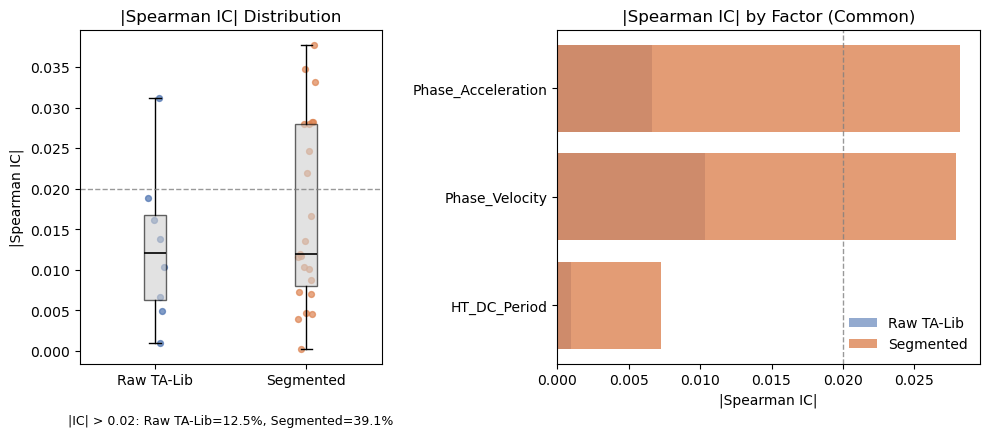

In [14]:
s_raw = (corr_check(family="cycle",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(family="cycle",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


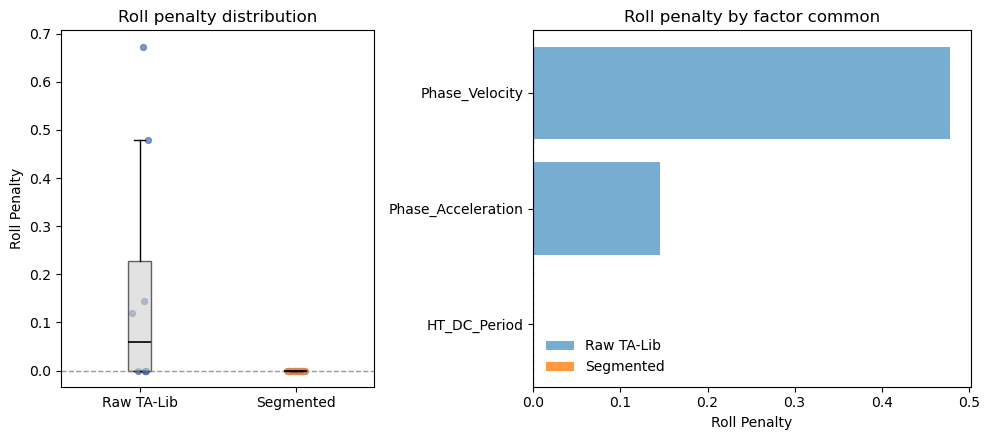

In [15]:
s_raw = (corr_check(family="cycle",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(family="cycle",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

**Higher Frequency**

The transition from daily to intraday frequencies introduces several fundamental challenges for quantitative modeling. As sampling frequency increases, price dynamics become progressively dominated by market microstructure effects—such as bid–ask bounce, trade-imbalance fluctuations, and latency-driven distortions—which can obscure the longer-horizon structures that many traditional technical indicators are designed to capture.

When combined with elevated transaction costs and slippage at shorter horizons, these effects often make intraday strategies more fragile and capacity-constrained than their lower-frequency counterparts.

Nevertheless, in response to the request, we examine the behavior of the proposed Hilbert-based factors at higher frequencies as a robustness exercise. Specifically, we assess their sensitivity to microstructure noise and evaluate whether the geometric and cycle-based features remain stable and informative under intraday market conditions.

从日频扩展至日内频率为量化建模带来了若干根本性挑战。随着采样频率的提高，价格动态逐渐受到市场微观结构效应的主导，例如买卖价差反弹、成交不平衡波动以及由时延引发的扭曲，这些因素往往会掩盖许多传统技术指标试图刻画的中长期结构特征。

在较短时间尺度下，上述微观结构噪声与更高的交易成本和滑点叠加，通常使得日内策略相比低频策略更加脆弱，并受到更为严格的容量约束。

尽管如此，基于相关需求，我们仍将对所构建的 Hilbert 因子在更高频率下的行为进行检验，作为一种稳健性分析。具体而言，我们将评估这些因子对微观结构噪声的敏感性，并考察其所蕴含的几何与周期特征在日内市场环境中是否仍能保持稳定性与信息含量。

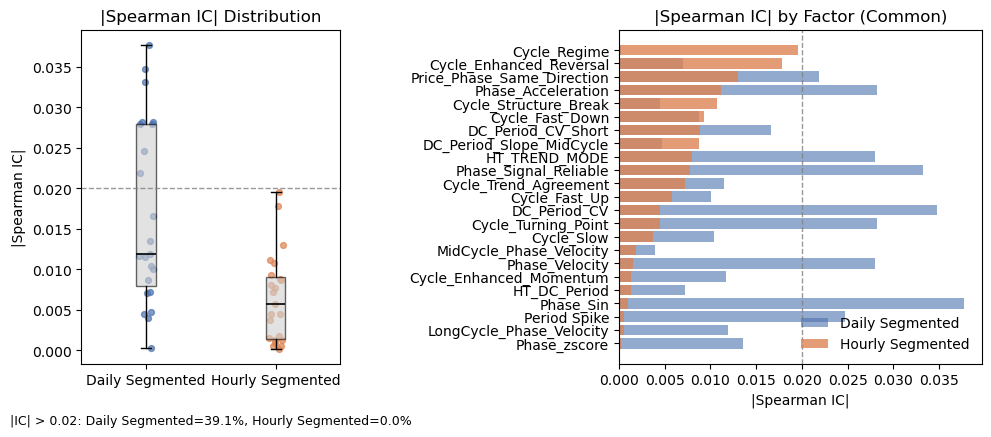

In [16]:
s_day = (corr_check(family="cycle",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_hour = (corr_check(ticker = 'ic', frequency = 'minute', multiplier = 60, family="cycle",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_day,s_hour, label1="Daily Segmented", label2="Hourly Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

It is worth emphasizing that the intraday evaluation does not rely on a rigid or hard-coded transplantation of daily parameters. Instead, all Hilbert-based features are constructed using frequency-aware windowing rules, with phase-difference horizons, smoothing spans, volatility windows, and roll-padding lengths adjusted in a lenient and scale-consistent manner as sampling frequency increases. In particular, longer phase-difference steps, wider smoothing windows, and expanded roll-padding zones are introduced at higher intraday frequencies to accommodate noisier dynamics and slower structural evolution in clock time. This design intentionally biases the construction toward intraday stability rather than strict responsiveness.

Despite these accommodations, the contrast between daily and intraday results remains large and systematic. At the hourly frequency, the distribution of absolute Spearman IC collapses toward zero, with only 0% of factors exceeding ∣IC∣>0.02, compared with 39.1% at the daily frequency. When the horizon is further shortened to 30-minute and 15-minute bars, the Spearman IC range contracts even more, with the distribution increasingly concentrated near zero. This degradation is observed across nearly all common phase-, velocity-, and regime-based factors, indicating a broad rather than factor-specific effect.

At the same time, it is worth noting that a small number of factors do exhibit localized improvements at certain intraday horizons (Cycle Regime etc). However, such improvements are highly window-dependent, unstable across frequencies, and closely tied to specific short-term market behaviors rather than persistent cycle structure. As a result, they do not form a consistent or generalizable rule for intraday modeling.

Taken together, the magnitude, monotonicity, and overall uniformity of the deterioration indicate that the limitation is structural rather than horizon-specific.

需要强调的是，日内频率下的检验并非将日频参数以刚性或硬编码方式直接移植。相反，所有基于 Hilbert 的特征均采用频率感知（frequency-aware）的窗口设定：随着采样频率的提高，相位差分步长、平滑窗口、波动率估计窗口以及换月填充区间均按照尺度一致且相对宽松的原则进行调整。

具体而言，在更高的日内频率下，引入了更长的相位差分间隔、更宽的平滑窗口以及更大的换月缓冲区，以适应更强的噪声环境以及以时间为单位较慢的结构性演化。该设计在方法上刻意向日内稳定性倾斜，而非追求过度的即时响应。

尽管在参数设定上已对日内建模作出充分让步，日频与日内结果之间仍呈现出显著且系统性的差异。在小时频率下，绝对 Spearman IC 的分布整体塌缩至接近零的区间， ∣IC∣>0.02 的因子占比为 0%，而日频分段结果则达到 39.1%。当时间尺度进一步缩短至 30 分钟与 15 分钟时，Spearman IC 的取值区间继续明显收窄，分布愈发集中于零附近。该退化现象并非局限于少数因子，而是在几乎所有相位、相位速度及状态类公共因子中普遍存在。

与此同时，也应指出，少数因子在特定日内窗口下确实表现出局部改善 (Ex: Cycle Regime)。然而，这类改善高度依赖具体时间尺度，在不同频率间缺乏稳定性，更多反映的是短期市场行为特征，而非可持续的周期结构信号。因此，其并不足以构成具有普适意义的日内建模规则。

综合来看，从退化幅度、单调性以及整体一致性判断，该结果更可能反映的是结构性限制，而非特定时间尺度选择的问题。

**CSI 300 Index Futures**

In [17]:
corr_check(ticker = 'if_main', family = 'cycle', cls = treemodel_factors_augment, selection = True, light = False)

[rolling_corr_report] No pairs ≥ 0.90 across 10 slices. (fold=10, span=234, cols=26)
target 1 period next return created
[coverage] kept 23/23 features (≥ 55%, n_eff ≥ 200); median coverage=94.75%, median n_eff=2220
Pearson Effective 30.43%
Spearman Effective 17.39%
Kendall Effective 13.04%
[selection] kept 4/23 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=23): 39.13%
roll_penalty     > 0.10 (all features, n=23): 0.00%


pearson  spearman   kendall  effective_pct  \
DC_Period_CV          -0.034148 -0.054529 -0.035922       1.000000   
Cycle_Trend_Agreement  0.014693  0.020221  0.016519       0.666667   
Cycle_Structure_Break  0.039819  0.031982  0.026119       1.000000   
Period Spike           0.031075  0.034629  0.028281       1.000000   

                       year_spearman_min  year_spearman_max  sign_consistency  \
DC_Period_CV                   -0.132791           0.046906               0.8   
Cycle_Trend_Agreement          -0.150582           0.121605               0.7   
Cycle_Structure_Break          -0.066561           0.183152               0.6   
Period Spike                   -0.092370           0.109919               0.7   

                       roll_penalty  winsor_penalty  decile_LS_signed  \
DC_Period_CV                    0.0             0.0          0.003607   
Cycle_Trend_Agreement           0.0             0.0               NaN   
Cycle_Structure_Break           0.0             0.0               NaN   
Period Spike                    0.0             0.0               NaN   

                       decile_long_return  decile_short_return      QSL  
DC_Period_CV                    -0.000698             0.002909  0.46443  
Cycle_Trend_Agreement                 NaN                  NaN  0.45000  
Cycle_Structure_Break                 NaN                  NaN  0.45000  
Period Spike                          NaN                  NaN  0.45000

In [18]:
corr_check(ticker = 'if_main', family = 'cycle', cls = treemodel_factors_daily, selection = True, light = False)

[rolling_corr_report] No pairs ≥ 0.90 across 10 slices. (fold=10, span=208, cols=11)
target 1 period next return created
[coverage] kept 8/8 features (≥ 55%, n_eff ≥ 200); median coverage=97.31%, median n_eff=2279
Pearson Effective 50.00%
Spearman Effective 0.00%
Kendall Effective 0.00%
[selection] kept 0/8 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=8): 75.00%
roll_penalty     > 0.10 (all features, n=8): 37.50%


Empty DataFrame
Columns: [pearson, spearman, kendall, effective_pct, year_spearman_min, year_spearman_max, sign_consistency, roll_penalty, winsor_penalty, decile_LS_signed, decile_long_return, decile_short_return, QSL]
Index: []

Some of the previously designed geometric cycle factors, as well as trend–cycle interaction features, begin to exhibit relatively stable behavior on the CSI 300 Index Futures, with Spearman information coefficients remaining predominantly positive. However, compared with features related to cycle position and stability, the effectiveness of Phase Velocity and Phase Acceleration, constructed from first- and second-order phase differences, shows a moderate decline.

This outcome is likely related to the structural characteristics of the CSI 300 index itself. As a broad-based index largely driven by macro conditions and persistent trends, abrupt phase-angle fluctuations arising from roll events or local disturbances do not necessarily correspond to stable or exploitable return structures. After introducing roll-aware segmentation together with contract-consistent seg lag and seg EMA smoothing, these low-magnitude and less robust phase variations are systematically attenuated, leading to weaker statistical associations for phase velocity and phase acceleration.

Importantly, this result should not be interpreted as a failure of the geometric cycle framework. Rather, it highlights the informational boundary of higher-order phase dynamics under stricter structural constraints. While cycle geometry remains valuable for describing market structure and regime transitions, the applicability of its derivative-based representations is inherently asset-dependent and warrants cautious, context-specific evaluation.

部分此前设计的几何周期因子以及趋势–周期交互因子在 CSI 300 指数期货上开始表现出相对稳健的特征，其 Spearman 信息系数整体维持在正向区间。然而，相较于周期位置与周期稳定性相关的特征，基于相位一阶与二阶差分构造的 Phase Velocity 与 Phase Acceleration 在有效性上出现了一定程度的回落。

这一现象很可能与 CSI 300 指数自身的结构特征有关。作为以宏观与趋势驱动为主的宽基指数，其价格运行中由相位角局部突变所刻画的高频几何变化，并不必然对应稳定或可持续的交易收益结构。进一步地，在引入换月感知的分段处理（segmentation），并结合合约一致性的 seg lag 与 seg EMA 平滑后，这类幅度较小、稳定性较弱的相位变化被系统性抑制，从而使相位速度与相位加速度的统计相关性有所减弱。

从结果上看，这一变化并不意味着周期几何框架本身失效，而更反映出在更严格的结构约束下，其所能贡献的有效信息边界。周期几何在刻画市场结构与状态转换方面仍具备良好的解释力，但其高阶导数形式在不同标的上的适用性，仍需结合具体市场特征进行审慎评估。

target 1 period next return created


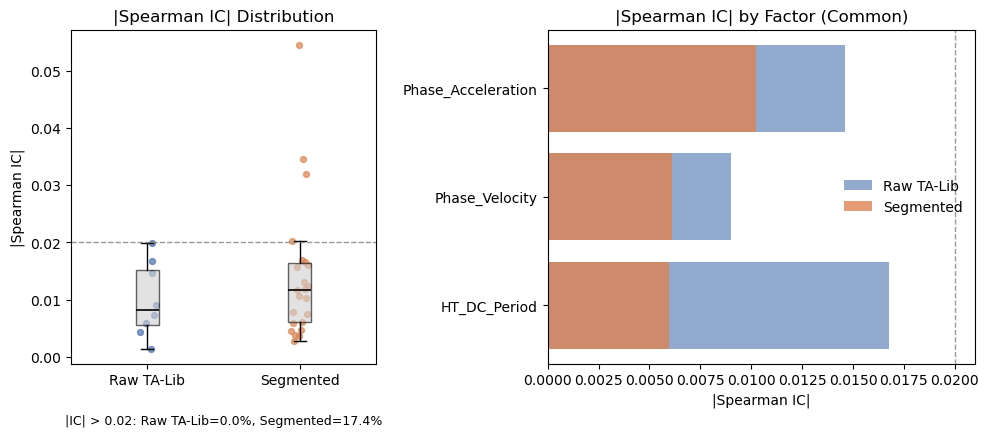

In [19]:
s_raw = (corr_check(ticker = 'if_main', family="cycle",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'if_main', family="cycle",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


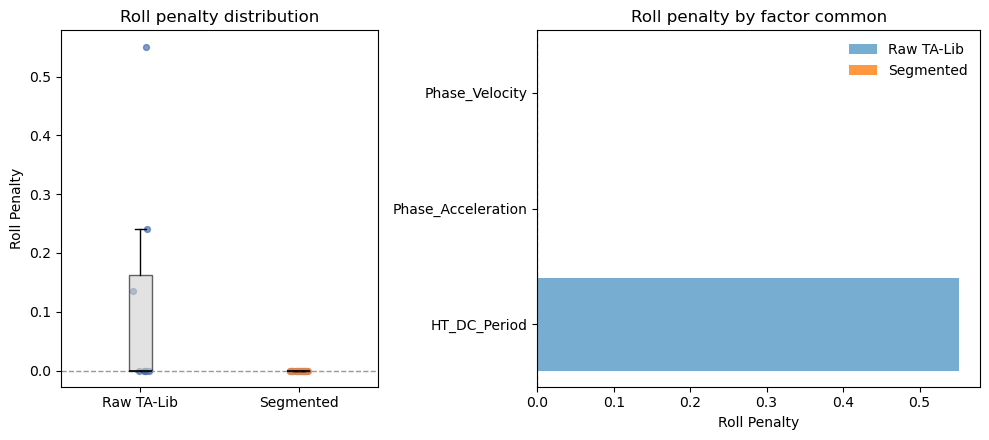

In [20]:
s_raw = (corr_check(ticker = 'if_main', family="cycle",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'if_main', family="cycle",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

**SSE 50 Index Futures**

In [21]:
print('Robust Version: Modeling on Log Close')
corr_check(ticker = 'ih_main', family = 'cycle', cls = treemodel_factors_augment, selection = True, light = False)

Robust Version: Modeling on Log Close
[rolling_corr_report] No pairs ≥ 0.90 across 10 slices. (fold=10, span=234, cols=26)
target 1 period next return created
[coverage] kept 23/23 features (≥ 55%, n_eff ≥ 200); median coverage=94.62%, median n_eff=2217
Pearson Effective 34.78%
Spearman Effective 43.48%
Kendall Effective 39.13%
[selection] kept 8/23 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=23): 52.17%
roll_penalty     > 0.10 (all features, n=23): 0.00%


pearson  spearman   kendall  effective_pct  \
DC_Period_CV            -0.046919 -0.039536 -0.026384       1.000000   
Phase_Acceleration      -0.031762 -0.034293 -0.023225       1.000000   
Cycle_Regime             0.028516  0.032404  0.026464       1.000000   
Cycle_Fast_Up           -0.014538 -0.028634 -0.023386       0.666667   
Phase_Signal_Reliable   -0.035019 -0.039903 -0.032588       1.000000   
Cycle_Enhanced_Reversal -0.008627 -0.028846 -0.023558       0.666667   
MidCycle_Phase_Velocity  0.023439  0.052830  0.035362       1.000000   
Period Spike             0.014366  0.030214  0.024676       0.666667   

                         year_spearman_min  year_spearman_max  \
DC_Period_CV                     -0.155548           0.031235   
Phase_Acceleration               -0.090405           0.062432   
Cycle_Regime                     -0.020885           0.124677   
Cycle_Fast_Up                    -0.138211           0.155309   
Phase_Signal_Reliable            -0.124763           0.043927   
Cycle_Enhanced_Reversal          -0.060823           0.054402   
MidCycle_Phase_Velocity          -0.061831           0.158380   
Period Spike                     -0.064878           0.121669   

                         sign_consistency  roll_penalty  winsor_penalty  \
DC_Period_CV                          0.6           0.0        0.000000   
Phase_Acceleration                    0.8           0.0        0.003564   
Cycle_Regime                          0.8           0.0        0.000000   
Cycle_Fast_Up                         0.7           0.0        0.000000   
Phase_Signal_Reliable                 0.9           0.0        0.000000   
Cycle_Enhanced_Reversal               0.6           0.0        0.000000   
MidCycle_Phase_Velocity               0.6           0.0        0.000000   
Period Spike                          0.6           0.0        0.000000   

                         decile_LS_signed  decile_long_return  \
DC_Period_CV                     0.003360           -0.001931   
Phase_Acceleration               0.001456           -0.000700   
Cycle_Regime                          NaN                 NaN   
Cycle_Fast_Up                         NaN                 NaN   
Phase_Signal_Reliable                 NaN                 NaN   
Cycle_Enhanced_Reversal               NaN                 NaN   
MidCycle_Phase_Velocity         -0.000901           -0.000263   
Period Spike                          NaN                 NaN   

                         decile_short_return       QSL  
DC_Period_CV                        0.001429  0.463442  
Phase_Acceleration                  0.000755  0.455466  
Cycle_Regime                             NaN  0.450000  
Cycle_Fast_Up                            NaN  0.450000  
Phase_Signal_Reliable                    NaN  0.450000  
Cycle_Enhanced_Reversal                  NaN  0.494984  
MidCycle_Phase_Velocity             0.000638  0.446396  
Period Spike                             NaN  0.450000

In [22]:
corr_check(ticker = 'ih_main', family = 'cycle', cls = treemodel_factors_daily, selection = True, light = False)

[rolling_corr_report] No pairs ≥ 0.90 across 10 slices. (fold=10, span=208, cols=11)
target 1 period next return created
[coverage] kept 8/8 features (≥ 55%, n_eff ≥ 200); median coverage=97.31%, median n_eff=2279
Pearson Effective 37.50%
Spearman Effective 37.50%
Kendall Effective 25.00%
[selection] kept 2/8 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=8): 62.50%
roll_penalty     > 0.10 (all features, n=8): 37.50%


pearson  spearman   kendall  effective_pct  \
Phase_Velocity     -0.051807 -0.040889 -0.027399            1.0   
Phase_Acceleration -0.025304 -0.035682 -0.023596            1.0   

                    year_spearman_min  year_spearman_max  sign_consistency  \
Phase_Velocity              -0.124248           0.020618               0.7   
Phase_Acceleration          -0.142404           0.121763               0.8   

                    roll_penalty  winsor_penalty  decile_LS_signed  \
Phase_Velocity          0.000000         0.00133          0.002795   
Phase_Acceleration      0.147371         0.00000          0.001489   

                    decile_long_return  decile_short_return       QSL  
Phase_Velocity               -0.001058             0.001737  0.461047  
Phase_Acceleration           -0.001418             0.000071  0.441218

For IH (SSE 50 Index Futures), the overall behavior of the segment-aware Hilbert cycle factors is directionally consistent with that observed for IF and IC. Geometry-related features capturing cycle position and stability continue to exhibit positive contributions in terms of Spearman IC, while their performance is no longer materially driven by contract rollover effects.

In contrast, phase-difference-based features such as Phase Velocity and Phase Acceleration show a moderate decline in effectiveness after segmentation is applied. As discussed earlier, this behavior is more likely attributable to the structural characteristics of the IH index itself, which is predominantly driven by trend and macro-level forces. Once rollover-induced noise is removed, short-horizon phase dynamics do not appear to retain robust or persistent trading relevance.

在 IH（上证 50 指数期货）上，分段 Hilbert 周期因子的整体表现与 IF / IC 在方向上保持一致：周期位置与稳定性相关的几何因子在 Spearman 信息系数层面仍维持稳定的正向贡献，同时其表现已基本不再受到换月效应的驱动。

相较之下，基于相位一阶与二阶差分构造的 Phase Velocity 与 Phase Acceleration 在引入分段处理后出现了一定程度的有效性回落。结合前述分析，这一变化更可能反映的是 IH 指数自身以趋势与宏观因素主导的结构特征——在剔除换月噪声后，短期相位动态并未保留稳定且可持续的交易信息。

target 1 period next return created


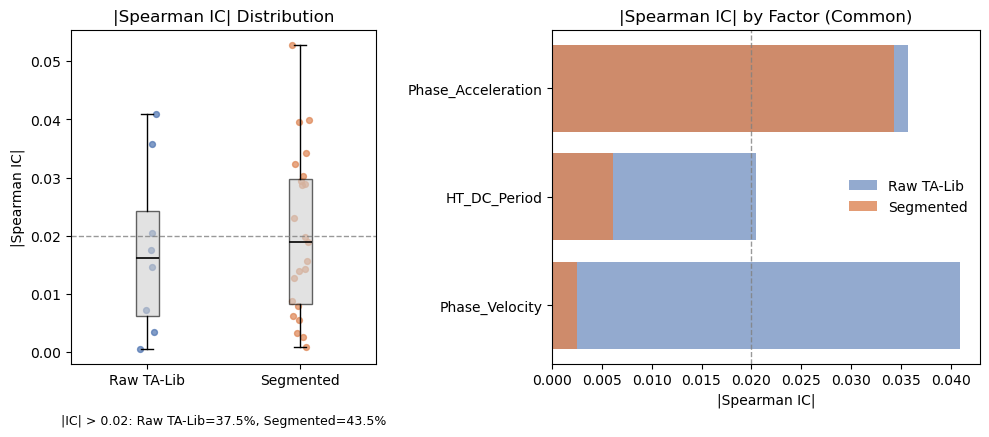

In [23]:
s_raw = (corr_check(ticker = 'ih_main', family="cycle",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="cycle",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


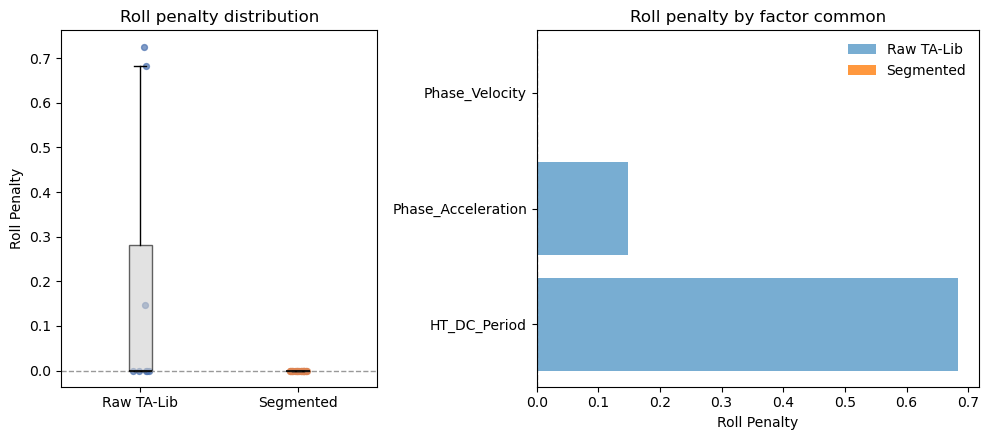

In [24]:
s_raw = (corr_check(ticker = 'ih_main', family="cycle",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="cycle",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

**Note**


It should be further noted that the computation of Hilbert-based cycle measures in TA-Lib (such as the dominant cycle period and phase) may inherently rely on recursive filtering procedures with internal state updates, rather than simple fixed-window rolling operations. In practical time-series settings, such recursive structures often struggle to deliver stable and reproducible estimates when the underlying cycle is unstable or undergoes abrupt transitions.

More importantly, during backtesting or feature construction, if the internal dependency structure of these algorithms is not strictly controlled, they may theoretically introduce information leakage, particularly around periods of rapid cycle change or contract rollover.

In light of these considerations, in the final modeling stage we advocate avoiding the direct use of raw cycle or phase level indicators. Instead, we retain only derived features that characterize cycle instability, relative variation, or interaction effects with trend and price dynamics. These features emphasize changes and structural tension within the cycle, rather than attempting to estimate an absolute “true” cycle position, and are therefore more robust from both a statistical and a trading perspective.

需要进一步指出的是，TA-Lib 对 Hilbert 周期相关量（如主导周期与相位）的计算过程本身可能依赖递归形式的滤波与内部状态更新，其有效估计并非简单的固定窗口移动运算。在实际时间序列中，这类递归结构在周期不稳定或发生突变时，往往难以提供稳健且可重复的估计结果。

更为重要的是，在回测或特征工程阶段，若未对其内部依赖结构进行严格约束，此类算法在理论上存在引入信息泄漏（leakage）的潜在风险，尤其是在周期快速变化或换月附近。

基于上述考虑，我们在正式建模阶段提倡不直接使用原始的周期或相位水平类指标，而仅保留刻画周期不稳定性、变化幅度或与趋势、价格行为产生交互关系的派生特征。这类指标更多反映的是周期结构的相对变化与状态张力，而非对“真实周期位置”的直接刻画，在统计与交易层面上也更为稳健。

#### **Momentum**

Real markets rarely satisfy the conditions under which Hilbert-based cycle estimates remain stable. Noise, structural breaks, volatility shocks, and especially contract rollovers interfere with the extraction of a clean “underlying cycle,” rendering such diagnostics inherently fragile.

With this recognition, the Hilbert features in our framework **are not treated as estimates of a true latent cycle**, but as descriptors of how the inferred cycle deforms under stress. A cycle may compress, stretch, dissipate, or become distorted by noise, and each of these geometric deformations reflects a different form of regime pressure or structural instability. Importantly, these distortions do not manifest uniformly across instruments. Differences in microstructure, liquidity, and volatility profiles mean that similar geometric distortions can correspond to very different market behaviors.

For this reason, momentum features derived directly from observed price action serve as a necessary complement. They provide a grounded and more stable characterization of market behavior. In our framework, momentum is therefore defined not merely as directional price displacement, but as the underlying force dynamics governing how that displacement forms, persists, accelerates, oscillates, or collapses.

真实市场很少满足使基于希尔伯特方法的周期估计保持稳定所需的理想条件。噪声、结构性断裂、波动率冲击，尤其是合约换月，都会干扰对“潜在周期”的干净提取，使得此类诊断在本质上具有较强的脆弱性。

基于这一认识，在我们的框架中，希尔伯特因子**并不被视为对真实潜在周期的直接估计**，而是用于描述推断得到的周期在不同压力下如何发生形变。周期可能出现压缩、拉伸、消散，或受到噪声扭曲，而这些几何层面的变化对应着不同形式的状态压力或结构性不稳定。

需要再次强调的是，这类形变并不会在不同交易标的上以统一方式呈现。由于微观结构、流动性和波动率特征的差异，相似的几何扭曲在不同合约中可能对应截然不同的市场行为。

正因如此，直接基于价格行为构造的动量类特征构成了必要的补充。这类特征能够提供更加稳健、贴近实际的市场行为刻画。在我们的框架中，动量不仅被定义为价格的方向性位移，更被视为支配该位移如何形成、持续、加速、振荡或崩塌的力学动态。

**Magic Number Seven**

In [25]:
from seg_utilities import segmentize, seg_diff, seg_lag
cls = treemodel_factors_augment(ticker = 'ic_main', light = False, frequency = 'day')
exp = cls.data
def mask_roll(s: pd.Series) -> pd.Series: return s.where(roll_zone == 0)
logp  =  np.log(np.clip(exp['close'], 1e-9, None))
seg, roll_zone = segmentize(exp, pad= 1, return_roll_zone=True)
exp['r1'] = seg_lag(mask_roll(seg_diff(logp, seg, 1)),seg,1)
exp['r5'] = seg_lag(mask_roll(seg_diff(logp, seg, 5)),seg,1)
exp['r7'] = seg_lag(mask_roll(seg_diff(logp, seg, 7)),seg,1)
exp['r9'] = seg_lag(mask_roll(seg_diff(logp, seg, 9)),seg,1)
exp['r10'] = seg_lag(mask_roll(seg_diff(logp, seg, 10)),seg,1)
exp['r15'] = seg_lag(mask_roll(seg_diff(logp, seg, 15)),seg,1)
exp['r20'] = seg_lag(mask_roll(seg_diff(logp, seg,20)),seg,1)
print(exp[['r1','r5', 'r7', 'r9', 'r10', 'r15', 'r20']].isna().mean())

r1     0.099078
r5     0.198157
r7     0.264209
r9     0.329877
r10    0.362519
r15    0.520353
r20    0.643625
dtype: float64


Under a strictly contract-wise computation framework, together with the exclusion of unstable observations around contract roll dates, even the most basic return measures experience a pronounced decline in sample availability as the return horizon increases.

Empirical evidence shows that short-horizon returns (e.g., r1–r7) maintain a relatively manageable level of missing observations under this setting, whereas extending the window to r10 and beyond leads to a marked increase in data loss, with more than half of the observations becoming unavailable in some cases. This substantially constrains statistical stability and model training.

From a time-scale perspective, r7 already extends beyond the range dominated by short-term noise and microstructure effects, allowing directional price drift to accumulate without frequently crossing contract roll boundaries or structural breaks. Consequently, in the context of frequently rolling main contracts, r7 can be regarded as a reasonable approximation of mid-term price direction, rather than merely a compromise imposed by engineering constraints.

Given these structural limitations, we avoid the direct use of long-horizon returns such as r10 and r20 in most analyses. Instead, r7 is adopted as a proxy for mid-term return direction, striking a more robust balance between signal expressiveness and sample availability, without attempting to formally replicate longer-horizon return definitions.

Finally, short-horizon rolling returns with relaxed min_periods requirements are employed to further mitigate the impact of frequent contract rolls on data continuity.

在严格采用合约内计算，并在换月前后丢弃临近不稳定观测点的设定下，即使是最基础的收益率指标，其可用样本比例亦会随着计算窗口的延长而显著下降。

实证结果显示，短期 return（如 r1–r7）在该框架下仍能维持相对可控的缺失水平，而当窗口扩展至 r10 及以上时，样本缺失比例呈现明显上升，部分情形下超过一半观测点不可用，从而对统计稳定性与模型训练构成约束。

从时间尺度上看，r7 已跨越大多数由短期噪声与微观波动主导的区间，能够在不引入显著结构性断点的前提下累积具有方向性的价格漂移；与此同时，其计算窗口尚未频繁跨越换月边界与合约结构变化。因此，在频繁换月的主力合约环境中，r7 可被视为对中短期（mid-term）价格方向的一个合理近似，而非仅仅是工程约束下的折中选择。

鉴于上述结构性限制，本文在多数分析中避免直接使用 r10 与 r20 等长窗口收益率，而是采用 r7 作为中期收益方向的代理变量，以在信号表达能力与样本完整性之间取得更为稳健的平衡，而非试图在形式上复现更长周期的收益定义。

同时，在具体构造过程中辅以允许 min_periods 的短期 rolling return，以进一步缓解频繁换月结构对样本连续性的影响。

#### **Feature Design**

**Displacement**

A classical implementation of momentum consists of indicators that measure an asset’s realized return over a fixed lookback window. Such signals summarize observed price displacement—whether prices have risen or fallen—but do not describe the underlying dynamics that generated that movement. In this sense, classical momentum is an outcome-based statistic rather than a structural characterization of market behavior. Despite this conceptual limitation, momentum remains a useful and complementary signal in empirical models.

For intraday data, roll effects are comparatively milder and the effective sample size is substantially larger. We therefore allow moderately longer horizons, such as ten and twenty bars. These choices strike a practical balance: they are long enough to reflect short- to medium-term dynamics, yet conservative enough to avoid artificial instability introduced by contract stitching and roll-zone exclusion.

While broader lookback windows could be introduced in principle, doing so would require stronger domain assumptions and would materially increase the risk of data-snooping. Accordingly, momentum in this study is treated as a controlled baseline signal, augmented by higher-order diagnostics of path structure, persistence, and regime stability.

经典的动量指标通常通过在固定回看窗口内计算资产的已实现收益来构造。这类信号刻画的是价格的“位移结果”——即价格是否上涨或下跌——而非驱动该位移的市场内在机制。从这一角度看，传统动量属于结果导向型统计量，而不是对市场行为的结构性刻画。尽管存在上述概念局限，动量在实证建模中仍具有重要的补充价值。


对于日内数据而言，换月影响相对较弱，且有效样本规模显著更大，因此允许使用适度更长的回看窗口（如 10 和 20 个周期）。这些窗口在实践中取得了合理平衡：既能够反映短期至中期的市场行为，又能避免因合约拼接和换月区间剔除而引入的人为不稳定性。

原则上可以引入更长的回看窗口，但这将依赖更强的领域假设，并显著增加数据窥探（data-snooping）的风险。因此，在本研究中，动量被视为一种受控的基础信号，并进一步结合路径结构、持续性与状态稳定性等高阶诊断指标共同使用。

| Data Frequency | Feature Name        | Lookback Window | Definition                                   | Design Rationale |
|---------------|---------------------|-----------------|----------------------------------------------|------------------|
| Daily         | Mom_1D              | 1               | Realized return over 1 trading day (one bar shifted)          | Minimal horizon; high coverage under roll-zone masking |
| Daily         | Mom_5D              | 5               | Cumulative realized return over 5 days       | Captures weekly-scale movement while preserving sample size |
| Daily         | Mom_7D              | 7               | Cumulative realized return over 7 days       | **Safe Upper bound** under daily continuous-futures constraints |
| Intraday      | Mom_10              | 10 bars         | Realized return over 10 intraday intervals   | Short-term momentum with mild roll impact |
| Intraday      | Mom_20              | 20 bars         | Realized return over 20 intraday intervals   | Short- to medium-term behavior with stable effective sample size |

Note: Ret10 is included in loose version for comparison 

**Path-Irregularity**

Sudden bends, sharp reversals, or unusually large movements often reflect transient stress in liquidity, hidden order-flow pressure, or the early stages of a regime transition. These events are informative not because of their direction, but because they signal instability—moments when the market departs from its recent rhythm.

To capture such path-level irregularities, we construct complementary indicators that quantify different expressions of “unexpected” movement. One class focuses on sharp, discrete shifts that reflect abrupt breaks from recent behavior. The other captures more subtle deviations, where returns overshoot what would be expected given the local trend and volatility environment.

Importantly, these signals are not intended as directional predictors. Instead, they serve as diagnostics of regime stress and reliability, highlighting periods where standard trend- or cycle-based signals may require reinterpretation or attenuation.

突发性的弯折、剧烈反转或异常幅度的价格变动，往往反映了短期流动性压力、潜在的订单流失衡，或市场即将发生状态切换的早期迹象。这类行为之所以具有信息含量，并非因为其方向性，而是因为它们刻画了市场偏离近期运行节奏的“不稳定状态”。

为刻画这种路径层面的不规则性，我们构建了一组互补性的指标，用以描述不同形式的“非预期运动”。其中一类关注突发且离散的轨迹变化，反映价格对近期行为模式的突然偏离；另一类则刻画更为细微的偏移，即收益在局部趋势与波动水平约束下出现的异常超调。

需要强调的是，这类信号并非用于直接预测价格方向，而是作为状态诊断工具，用于识别潜在的结构性压力与不稳定区间，从而辅助判断其他信号在不同市场环境下的可靠性。

| Factor | Definition | Measures | Interpretation |
|------|------------|----------|----------------|
| Jump Detection (mom5_jump_detected) | Thresholded standardized change of short-horizon returns, normalized by recent return variability | Discrete path discontinuity | Liquidity stress, stop-cascade bursts, or early structural breaks |
| Unexpected Movement (mom5_unexpected) | Absolute deviation of short-horizon returns from a locally smoothed trend, normalized by recent realized volatility | Path-level instability relative to local conditions | Temporary microstructure imbalance or breakdown of local price symmetry |

**Path Direction: Stability of Stepwise Movement**

Price movement can be viewed as a sequence of small directional steps. When these steps reverse frequently from one bar to the next, the resulting trajectory becomes noisy, jagged, and structurally unstable. Such instability reflects short-horizon order flow acting in opposition to itself and is typically associated with momentum signals that lack persistence and exhibit reduced predictive reliability. To characterize this form of directional instability, we further construct a set of complementary indicators, each designed to capture a distinct manifestation of path-level disorder.

价格演化可以理解为由一连串方向性的小步推进所构成。当这些小步在相邻区间内频繁发生翻转时，价格路径会呈现出明显的锯齿化特征，并表现为结构性不稳定。这种不稳定性反映了短周期订单流之间的相互对冲，通常对应于动量难以延续、预测可靠性下降的情形。 为刻画上述方向性不稳定特征，我们进一步构建了一组互补性的指标，用以从不同角度刻画价格路径层面的混乱与不一致性

| Factor | Definition | Measures | Interpretation |
|------|------------|----------|----------------|
| ret5_volatility_adj| Short-horizon return displacement normalized by local realized volatility | Directional strength relative to noise | Weak values indicate fragile or incoherent directional movement |
| path_entropy | Entropy of short-horizon return direction | Directional uncertainty | High values reflect lack of directional commitment |
| sign_variance | Local dispersion of bar-by-bar return direction | Directional instability | High dispersion indicates choppy, unstable microstructure |
| path_flip_rate20 | Frequency of return direction reversals over a rolling window | Short-horizon oscillation intensity | High flip rates imply poor momentum propagation |
| mom_efficiency | Net directional displacement relative to total absolute movement | Path coherence | Values near 1 indicate trend-aligned paths; near 0 indicate noise-dominated motion; negative values indicate countertrend turbulence |

**Force**

While directional coherence describes how a price path evolves, it does not explain why it evolves in that manner. A price path may appear stable or chaotic, yet the underlying forces driving the displacement can differ substantially. Internal pressures such as liquidity demand, order-flow imbalance, trend reinforcement, or exhaustion shape the quality of momentum and determine whether a given displacement is sustainable or fragile.
In other words, path direction characterizes the observable pattern of movement, whereas force describes the internal engine that generates and sustains that pattern.
This distinction motivates a shift in focus—from analyzing where the path moves to understanding what drives it. Force-oriented indicators are designed to capture acceleration, curvature, and the effectiveness of directional pressure. These elements reveal the internal strength or weakness of momentum beyond what can be inferred from displacement alone.
To this end, we define the following momentum force factors:

路径方向性揭示了价格“如何”演化，但并不能直接解释其“为何”以这种方式演化。即使价格路径在表观上呈现出连贯或混乱的形态，其背后的驱动力量也可能存在显著差异。来自流动性需求、订单流失衡、趋势强化或趋势衰竭等不同内部压力，会共同塑造动量的质量，并决定价格位移是具有持续性，还是本质上较为脆弱。换言之，路径方向性刻画的是价格运动的外在形态，而“推力”则描述了形成并维持该形态的内在动力结构。基于这一认识，我们有必要将分析重点从“路径指向何处”转向“是什么力量推动路径到达那里”。动量推力类指标通过刻画加速度、路径弯曲程度以及方向性压力的有效性，揭示了超越位移本身的、关于动量内在强弱的结构性信息。基于上述动机，我们定义如下动量“推力”类因子：

| Factor | Definition | Measures | Interpretation |
|------|------------|----------|----------------|
| mom_acf_decay | Relative difference between short-lag and medium-lag return autocorrelation | Temporal decay of directional structure | Positive values indicate localized, shallow momentum; negative values indicate strengthening coherence over longer horizons |
| mom_oscillator | Spread between fast and slow momentum components | Tension between short- and long-horizon thrust | Positive values signal tightening directional pressure; negative values indicate momentum dissipation or regime softening |
| Trend Probability | Proportion of positive returns within a fixed window | Directional bias of order flow | Persistently high values indicate sustained directional tilt; neutral or unstable values imply fragmented pressure |
| TRIX_like | Multi-layer smoothed momentum signal | Deep, persistent directional force | Highlights stable, slow-building momentum while filtering high-frequency noise |
| mom_half_life | Estimated decay speed of directional memory | Persistence of momentum structure | Short half-life implies rapid structural decay; long half-life indicates durable momentum |
| mom_convexity | Curvature of the return path across horizons | Geometric distortion of momentum | Positive values signal tightening or acceleration; negative values indicate flattening or early fatigue |
| mom_velocity | First-order change in short-horizon returns | Immediate acceleration or deceleration | Positive values reflect building pressure; negative values indicate fading strength or counter-force emergence |

**Note**

In the loose version, the momentum class incorporates a greater number of cycle-related signals due to a more lenient shift design, rather than strictly enforcing segment-safe lagging. In addition, ten factors associated with path irregularity and directional path characteristics are excluded from this configuration.

**CSI 500 Index Futures**

In [26]:
print('Robust Version: Modeling on Log Close')
corr_check(ticker = 'ic_main', family = 'mom', cls = treemodel_factors_augment, selection = True, light = False)

Robust Version: Modeling on Log Close
[rolling_corr_report] Pairs exist but none met presence ≥ 70%. (corr_thresh=0.9, n_slices=10)
target 1 period next return created
[coverage] kept 23/23 features (≥ 55%, n_eff ≥ 200); median coverage=79.26%, median n_eff=1857
Pearson Effective 56.52%
Spearman Effective 73.91%
Kendall Effective 56.52%
[selection] kept 14/23 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=23): 69.57%
roll_penalty     > 0.10 (all features, n=23): 0.00%


pearson  spearman   kendall  effective_pct  \
ret5                  -0.015073 -0.056398 -0.039159       1.000000   
ret7                  -0.057353 -0.032297 -0.021127       1.000000   
mom5_unexpected       -0.008261 -0.030802 -0.020468       0.666667   
ret5_volatility_adj   -0.035849 -0.055312 -0.036922       1.000000   
mom5_jump_detected     0.016102  0.025489  0.020816       1.000000   
path_flip_rate20       0.043455  0.055026  0.037513       1.000000   
mom_efficiency        -0.026625 -0.025232 -0.016397       1.000000   
mom_acf_decay         -0.025324 -0.046548 -0.031217       1.000000   
mom_oscillator        -0.041678 -0.042801 -0.029597       1.000000   
trend_probability_ema -0.026118 -0.027388 -0.018680       1.000000   
trend_probability     -0.026353 -0.038021 -0.028743       1.000000   
mom_convexity         -0.027804 -0.042167 -0.030236       1.000000   
RSI_14_Log_Spaced     -0.011876 -0.035578 -0.023020       0.666667   
mom_efficiency_fast   -0.031054 -0.043734 -0.029351       1.000000   

                       year_spearman_min  year_spearman_max  sign_consistency  \
ret5                           -0.133840          -0.002747               1.0   
ret7                           -0.126288           0.011424               0.8   
mom5_unexpected                -0.131958           0.068087               0.6   
ret5_volatility_adj            -0.127330          -0.009184               1.0   
mom5_jump_detected             -0.086364           0.117240               0.6   
path_flip_rate20               -0.038289           0.191452               0.6   
mom_efficiency                 -0.139192           0.094069               0.8   
mom_acf_decay                  -0.225813           0.148062               0.7   
mom_oscillator                 -0.172067           0.044881               0.9   
trend_probability_ema          -0.109462           0.050258               0.8   
trend_probability              -0.161817           0.045628               0.8   
mom_convexity                  -0.119147           0.068714               0.7   
RSI_14_Log_Spaced              -0.122305           0.065960               0.9   
mom_efficiency_fast            -0.140427          -0.004940               1.0   

                       roll_penalty  winsor_penalty  decile_LS_signed  \
ret5                            0.0        0.000854          0.000363   
ret7                            0.0        0.002358          0.002941   
mom5_unexpected                 0.0        0.000145         -0.001069   
ret5_volatility_adj             0.0        0.001096          0.001645   
mom5_jump_detected              0.0        0.000000               NaN   
path_flip_rate20                0.0        0.003966          0.003174   
mom_efficiency                  0.0        0.000894          0.003254   
mom_acf_decay                   0.0        0.003105          0.001407   
mom_oscillator                  0.0        0.000000          0.004515   
trend_probability_ema           0.0        0.000000          0.001439   
trend_probability               0.0        0.000000          0.000786   
mom_convexity                   0.0        0.000000          0.004254   
RSI_14_Log_Spaced               0.0        0.001007          0.000325   
mom_efficiency_fast             0.0        0.002241          0.001626   

                       decile_long_return  decile_short_return       QSL  
ret5                             0.000167             0.000530  0.518204  
ret7                             0.001725             0.004666  0.461530  
mom5_unexpected                 -0.000132            -0.001202  0.445708  
ret5_volatility_adj             -0.000433             0.001213  0.561283  
mom5_jump_detected                    NaN                  NaN  0.450000  
path_flip_rate20                 0.001815            -0.001359  0.462300  
mom_efficiency                  -0.000310             0.002944  0.462928  
mom_acf_decay                    0.000378             0.00178

In [27]:
corr_check(ticker = 'ic_main', family = 'mom', cls = treemodel_factors_daily, selection = True, light = False)

[rolling_corr_report] slices=10, corr_thresh=0.9, pairs_reported=1 (presence ≥ 70%)
                                      Pair  freq  presence  mean_abs_corr  \
0  Slow_Stochastic_%D — Slow_Stochastic_%K    10       1.0       0.933754   

   max_abs_corr  n_slices  
0      0.954743        10  
target 1 period next return created
[coverage] kept 19/19 features (≥ 55%, n_eff ≥ 200); median coverage=99.40%, median n_eff=2328
Pearson Effective 36.84%
Spearman Effective 57.89%
Kendall Effective 36.84%
[selection] kept 0/19 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=19): 84.21%
roll_penalty     > 0.10 (all features, n=19): 73.68%


Empty DataFrame
Columns: [pearson, spearman, kendall, effective_pct, year_spearman_min, year_spearman_max, sign_consistency, roll_penalty, winsor_penalty, decile_LS_signed, decile_long_return, decile_short_return, QSL]
Index: []

Although the benchmark factor set used in this comparison was not constructed in a strict one-to-one correspondence with the original factor library—due to practical constraints, only TA-Lib indicators applied to close prices with a uniform shift(1) were employed—we are still able to observe clear improvements from the segment-safe construction across several shared factors, including ret5, TRIX, and ret1.

It is worth noting that the relatively weaker performance of mom_oscillator_fast in this comparison can largely be attributed to the TA-Lib implementation allowing longer calculation windows, which in practice introduces unavoidable contamination from contract roll structures.

From an aggregate perspective, the proportion of factors with an absolute Spearman IC greater than 0.02 increases to 73%. Given that the new factor library contains only three additional factors relative to the original version, this represents a meaningful improvement compared to the previous level of approximately 57%. Notably, when close prices in the benchmark set are further replaced by log(close), the corresponding proportion with |Spearman IC| > 0.02 rises only to around 60%, remaining clearly below that of the segment-safe construction.

More importantly, the observed improvements are not concentrated in periods adjacent to contract rollovers. Under settings where roll-adjacent observations are explicitly down-weighted or excluded, the segment-safe construction continues to exhibit superior performance, suggesting that the gains primarily reflect enhanced factor stability and information extraction rather than mechanical reliance on rollover-related effects.

尽管本次对比所采用的对照因子集并未严格按照原始因子库进行一比一构建（受人手与时间限制，仅在 close 价格上套用 TA-Lib 指标并统一施加 shift(1) 处理），我们仍然能够观察到 segment-safe 构造版本在若干共用因子上展现出明显提升，包括 ret5、TRIX 以及 ret1 等。

需要指出的是，mom_oscillator_fast 在该对比中的表现相对较弱，主要源于 TA-Lib 实现中允许使用了更长的计算窗口，从而在实际应用中不可避免地混杂了合约换月结构带来的影响。

从整体统计结果来看，Spearman IC 绝对值大于 0.02 的因子占比提升至 73%。考虑到新因子库在因子数量上仅比原有版本多出 3 个因子，这一相关性有效比例相较于原先约 57% 的水平可以被认为是较为显著的改进。值得注意的是，在对照因子集中进一步将 close 替换为 log(close) 后，Spearman IC 绝对值大于 0.02 的比例约为 60%，仍明显低于 segment-safe 构造版本。

更为重要的是，上述提升并未集中体现在合约换月邻近区间。在对换月相关观测进行显式削弱或剔除的设定下，segment-safe 构造版本仍然保持相对更优的表现，这表明其改进主要来源于因子稳定性与信息提取能力的提升，而非对换月结构的机械性依赖。

target 1 period next return created


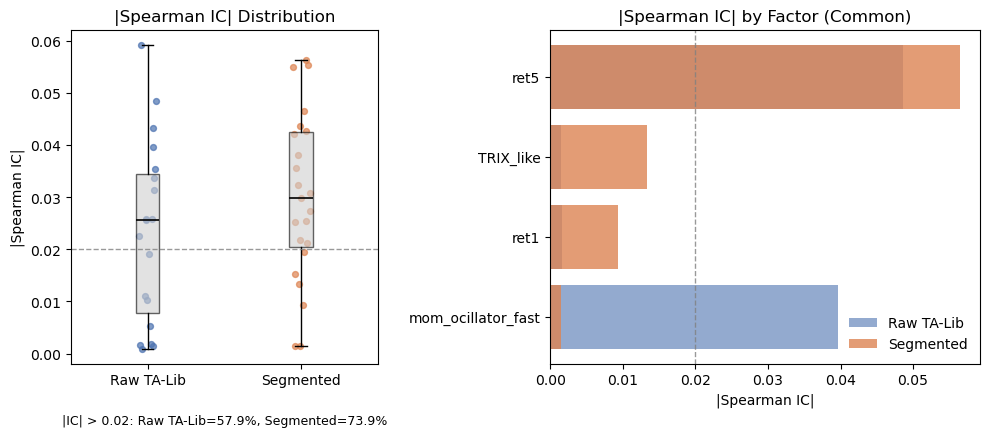

In [28]:
s_raw = (corr_check(ticker = 'ic_main', family="mom",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="mom",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


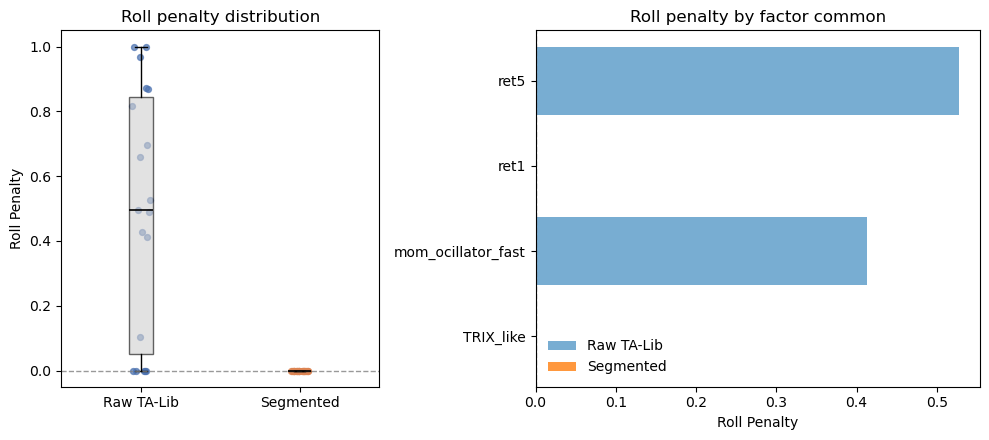

In [29]:
s_raw = (corr_check(ticker = 'ic_main', family="mom",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="mom",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

**Mask** 

When comparing the masked and unmasked configurations, we observe that even without masking observations immediately following contract roll dates, the factor set maintains a relatively strong level of Spearman correlation, with 65.2% of factors exceeding the specified absolute threshold—still higher than the maximum achieved by the TA-Lib benchmark.

More importantly, from a stability perspective, the unmasked configuration exhibits improved directional stability, as evidenced by a reduction in IC sign variance. This indicates that the predictive direction of the factors is more consistent over time.

In contrast, while masking may suppress certain roll-related disturbances at the numerical level, the introduction of artificial missingness can disrupt temporal continuity and, in some cases, weaken directional consistency.

Taking these considerations together, we favor the unmasked configuration in subsequent modeling stages, as it preserves both correlation strength and directional stability while remaining more faithful to realistic trading conditions.

在对比 mask 与 non-mask 两种设定的估计结果时，我们注意到，在不对换月后临近观测日进行遮盖的情况下，因子整体仍能维持较高水平的 Spearman 相关性，其绝对值大于阈值的比例达到 65.2%，并且依旧高于 TA-Lib 对照组所能达到的最高水平。

更进一步地，从稳定性角度来看，non-mask 设定在 IC 方向一致性方面表现出明显优势，其 sign variance 显著降低，表明因子预测方向在时间维度上更为稳定。

相较之下，尽管 mask 设定在数值层面能够抑制部分换月扰动，但通过人为遮盖换月后观测点所引入的结构性缺失，可能破坏原有的时间连续性，从而在一定程度上削弱方向一致性。

基于上述结果与权衡，本文在后续建模阶段更倾向于采用 non-mask 的设定，以在保持相关性水平的同时，获得更稳定且更贴近真实交易环境的方向性信号。

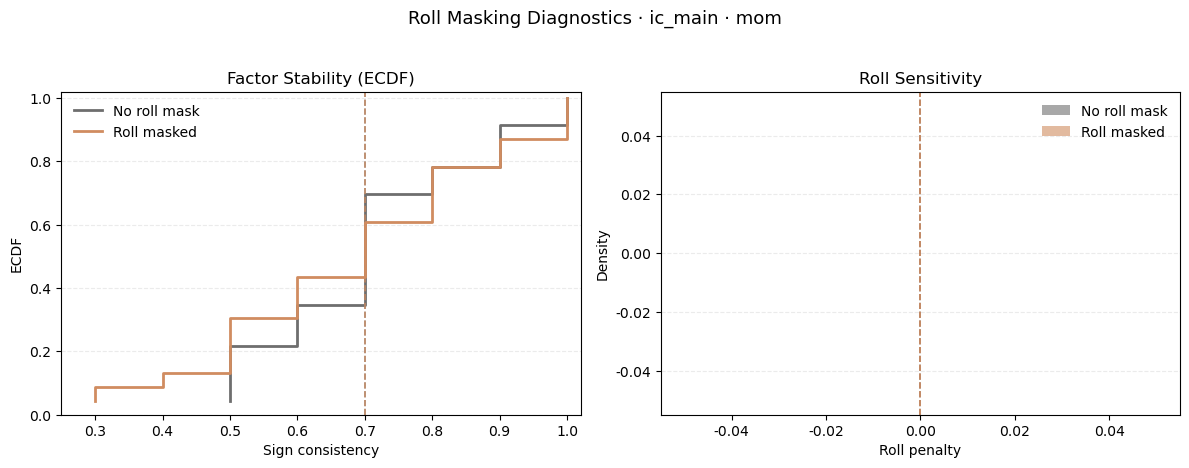

In [30]:
plot_roll_mask_diagnostics(ticker="ic_main", family="mom", cls=treemodel_factors_augment)

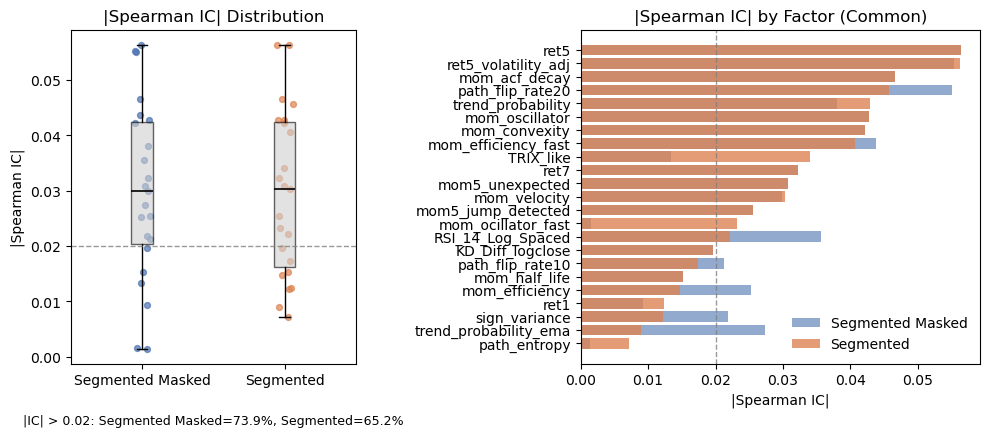

In [31]:
s_raw = (corr_check(ticker = 'ic_main', family="mom",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="mom",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,mask = False)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Segmented Masked", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

**Higher Frequency**

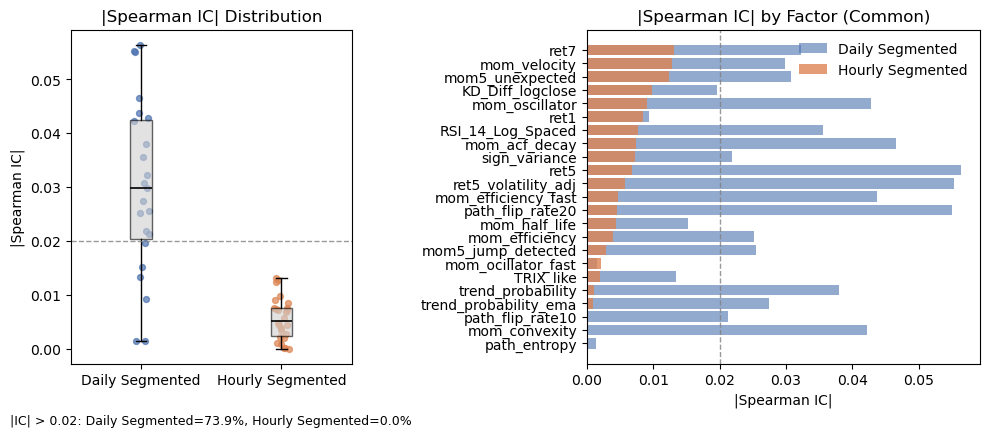

In [32]:
s_day = (corr_check(family="mom",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_hour = (corr_check(ticker = 'ic', frequency = 'minute', multiplier = 60, family="mom",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_day,s_hour, label1="Daily Segmented", label2="Hourly Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

**CSI 300 Index Futures**

In [33]:
print('Robust Version: Modeling on Log Close')
corr_check(ticker = 'if_main', family = 'mom', cls = treemodel_factors_augment, selection = True, light = False)

Robust Version: Modeling on Log Close
[rolling_corr_report] Pairs exist but none met presence ≥ 70%. (corr_thresh=0.9, n_slices=10)
target 1 period next return created
[coverage] kept 23/23 features (≥ 55%, n_eff ≥ 200); median coverage=76.40%, median n_eff=1790
Pearson Effective 34.78%
Spearman Effective 69.57%
Kendall Effective 56.52%
[selection] kept 16/23 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=23): 86.96%
roll_penalty     > 0.10 (all features, n=23): 0.00%


pearson  spearman   kendall  effective_pct  \
ret5                -0.009079 -0.050073 -0.035493       0.666667   
ret7                -0.054176 -0.060761 -0.042456       1.000000   
ret5_volatility_adj -0.022915 -0.042269 -0.028351       1.000000   
mom5_jump_detected  -0.027095 -0.050269 -0.041054       1.000000   
path_entropy         0.000732 -0.032593 -0.022867       0.666667   
path_flip_rate20     0.041223  0.058362  0.039771       1.000000   
mom_efficiency      -0.050327 -0.045087 -0.029786       1.000000   
mom_acf_decay       -0.004903 -0.029820 -0.019848       0.666667   
mom_oscillator      -0.002647 -0.028225 -0.019772       0.666667   
trend_probability   -0.006443 -0.036173 -0.026469       0.666667   
TRIX_like           -0.071483 -0.036390 -0.024772       1.000000   
mom_half_life        0.050999  0.020487  0.014010       0.666667   
mom_convexity       -0.011424 -0.030178 -0.021264       0.666667   
RSI_14_Log_Spaced   -0.016176 -0.043117 -0.028044       1.000000   
mom_efficiency_fast -0.016471 -0.031615 -0.021454       1.000000   
path_flip_rate10     0.004206  0.034636  0.024277       0.666667   

                     year_spearman_min  year_spearman_max  sign_consistency  \
ret5                         -0.146193           0.020057               0.9   
ret7                         -0.171793           0.028886               0.9   
ret5_volatility_adj          -0.133712           0.017592               0.8   
mom5_jump_detected           -0.146812           0.106109               0.7   
path_entropy                 -0.117754           0.076305               0.7   
path_flip_rate20             -0.058991           0.130297               0.7   
mom_efficiency               -0.146374           0.027502               0.9   
mom_acf_decay                -0.172930           0.052442               0.6   
mom_oscillator               -0.142724           0.012216               0.9   
trend_probability            -0.123495           0.031134               0.9   
TRIX_like                    -0.139849           0.058000               0.8   
mom_half_life                -0.142760           0.181522               0.6   
mom_convexity                -0.139873           0.103845               0.6   
RSI_14_Log_Spaced            -0.147272           0.001367               0.9   
mom_efficiency_fast          -0.161159           0.014212               0.8   
path_flip_rate10             -0.079161           0.194782               0.7   

                     roll_penalty  winsor_penalty  decile_LS_signed  \
ret5                          0.0        0.001331         -0.000899   
ret7                          0.0        0.000034          0.002787   
ret5_volatility_adj           0.0        0.000000         -0.000740   
mom5_jump_detected            0.0        0.000000               NaN   
path_entropy                  0.0        0.000039          0.000849   
path_flip_rate20              0.0        0.004332          0.001834   
mom_efficiency                0.0        0.001370          0.005612   
mom_acf_decay                 0.0        0.000000          0.000098   
mom_oscillator                0.0        0.000000          0.001271   
trend_probability             0.0        0.000000         -0.000614   
TRIX_like                     0.0        0.001411          0.003491   
mom_half_life                 0.0        0.001150         -0.001023   
mom_convexity                 0.0        0.000000          0.000767   
RSI_14_Log_Spaced             0.0        0.000000          0.001694   
mom_efficiency_fast           0.0        0.001203         -0.000813   
path_flip_rate10              0.0        0.000000          0.000713   

                     decile_long_return  decile_short_return       QSL  
ret5                           0.000668            -0.000231  0.447361  
ret7                          -0.001237             0.001550  0.461145  
ret5_volatility_adj            0.000685            -0.000055  0.481751  
mom5_jump_detected   

In [34]:
corr_check(ticker = 'if_main', family = 'mom', cls = treemodel_factors_daily, selection = True, light = False)

[rolling_corr_report] slices=10, corr_thresh=0.9, pairs_reported=1 (presence ≥ 70%)
                                      Pair  freq  presence  mean_abs_corr  \
0  Slow_Stochastic_%D — Slow_Stochastic_%K    10       1.0       0.933779   

   max_abs_corr  n_slices  
0      0.946095        10  
target 1 period next return created
[coverage] kept 19/19 features (≥ 55%, n_eff ≥ 200); median coverage=99.40%, median n_eff=2328
Pearson Effective 42.11%
Spearman Effective 52.63%
Kendall Effective 36.84%
[selection] kept 5/19 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=19): 78.95%
roll_penalty     > 0.10 (all features, n=19): 57.89%


pearson  spearman   kendall  effective_pct  \
Slow_Stochastic_%K        -0.007693 -0.033160 -0.022327       0.666667   
ret5                      -0.031480 -0.051962 -0.036002       1.000000   
Momentum_Regime            0.026643  0.024921  0.020238       1.000000   
Asymmetric_Momentum_Ratio -0.019042 -0.029016 -0.020390       1.000000   
Slow_Stochastic_%D        -0.010631 -0.024779 -0.016694       0.666667   

                           year_spearman_min  year_spearman_max  \
Slow_Stochastic_%K                 -0.131985          -0.007760   
ret5                               -0.120810           0.009031   
Momentum_Regime                    -0.040916           0.085783   
Asymmetric_Momentum_Ratio          -0.183358           0.016061   
Slow_Stochastic_%D                 -0.125411          -0.000928   

                           sign_consistency  roll_penalty  winsor_penalty  \
Slow_Stochastic_%K                      1.0      0.000000        0.000000   
ret5                                    0.9      0.000000        0.000000   
Momentum_Regime                         0.8      0.152071        0.000000   
Asymmetric_Momentum_Ratio               0.7      0.165432        0.000000   
Slow_Stochastic_%D                      1.0      0.000000        0.000812   

                           decile_LS_signed  decile_long_return  \
Slow_Stochastic_%K                 0.000601            0.000278   
ret5                              -0.000629            0.000026   
Momentum_Regime                    0.005944            0.005710   
Asymmetric_Momentum_Ratio          0.000390           -0.000943   
Slow_Stochastic_%D                 0.000056           -0.000161   

                           decile_short_return       QSL  
Slow_Stochastic_%K                    0.000879  0.481285  
ret5                                 -0.000602  0.503051  
Momentum_Regime                      -0.000234  0.514555  
Asymmetric_Momentum_Ratio            -0.000553  0.435016  
Slow_Stochastic_%D                   -0.000105  0.470326

For the CSI 300 index futures, we observe a consistent improvement in the same direction (69.6 compare to 52.6). As a benchmark, when prices are transformed into logarithmic form, the proportion of TA-Lib factors with an absolute Spearman IC exceeding the threshold is only around 40%. In comparison, the factors constructed in this study exhibit a higher level of effectiveness on this market, suggesting a degree of cross-market generalization.

It is worth noting that TA-Lib factors also produce a small number of statistically significant signals in this setting. However, further inspection of roll penalty metrics indicates that these apparent signals are more likely driven by contract roll effects rather than by stable price pattern dynamics.

By contrast, the proposed factors maintain relatively consistent correlation performance under conditions where roll-induced influences are mitigated, implying that the captured information is more closely related to underlying price behavior rather than contract-specific structural effects.

对于沪深 300 股指期货，我们同样观察到了一致方向上的提升 (69.6 compare to 52.6)。作为对照，在将价格调整为对数形式后，TA-Lib 因子中 Spearman IC 绝对值大于阈值的比例仅约为 40%，相较之下，本文所构建因子在该市场上的表现显示出一定程度的泛化能力。

值得注意的是，TA-Lib 因子在该对照中亦产生了少量统计上显著的信号。然而，结合对 roll penalty 的进一步检视可以发现，这些显著性在较大程度上更可能反映的是合约换月结构所带来的影响，而非稳定、可持续的价格形态特征。

相比之下，本文所设计的因子在换月影响受到抑制的前提下仍能保持相对一致的相关性表现，表明其所捕捉的信息更偏向于价格行为本身，而非合约结构性效应。

target 1 period next return created


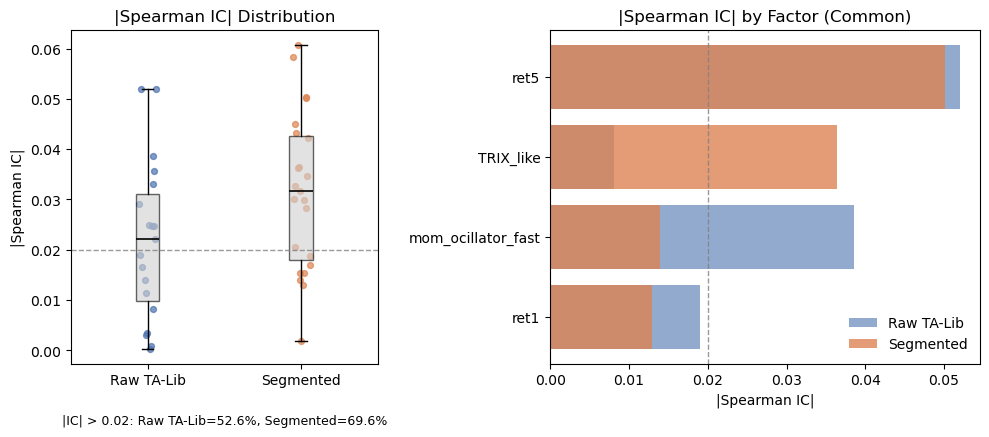

In [35]:
s_raw = (corr_check(ticker = 'if_main', family="mom",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'if_main', family="mom",cls=treemodel_factors_augment,selection=False,light=False,verbose=False)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


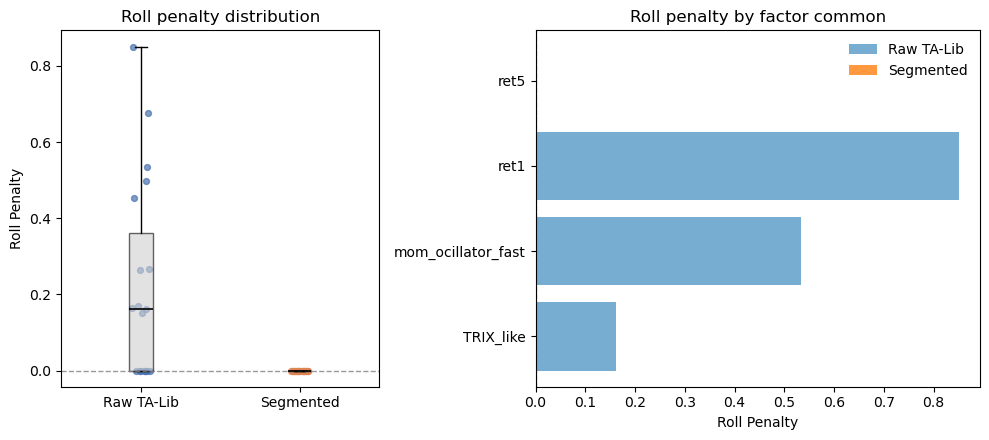

In [36]:
s_raw = (corr_check(ticker = 'if_main',family="mom",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'if_main', family="mom",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

For the CSI 300 index futures, the unmasked configuration also shows a more stable profile in terms of directional consistency when compared with the masked setting.

在沪深 300 股指期货上，mask 设定在方向一致性指标上整体呈现出更为稳定的表现，相较于 no mask 版本具有一定优势。

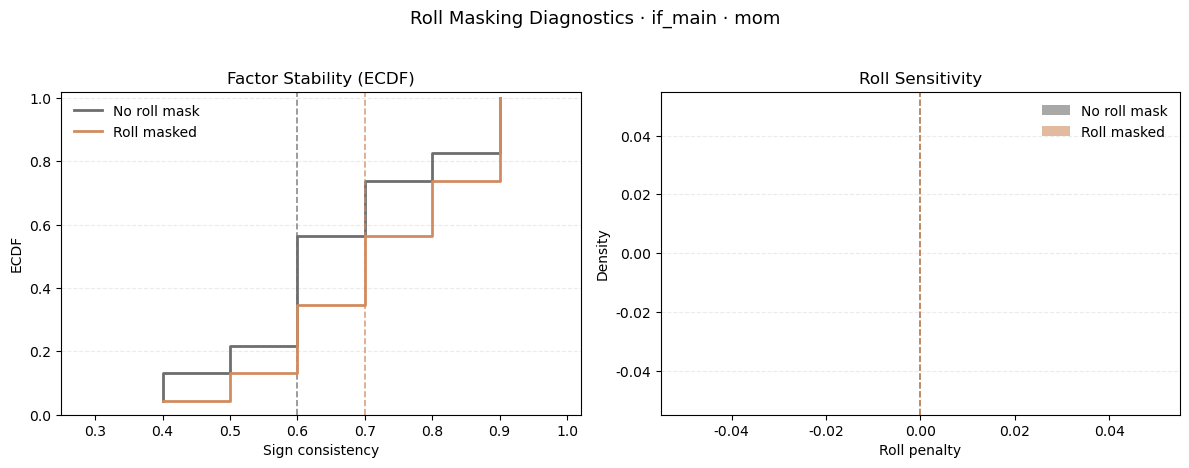

In [37]:
plot_roll_mask_diagnostics(ticker="if_main", family="mom", cls=treemodel_factors_augment)

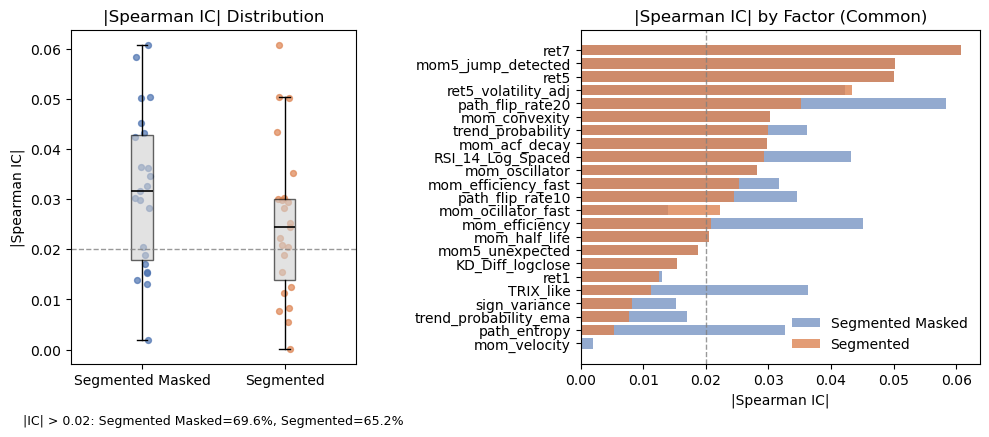

In [38]:
s_raw = (corr_check(ticker = 'if_main', family="mom",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'if_main', family="mom",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,mask = False)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Segmented Masked", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

**SSE 50 Index Futures**

In [39]:
print('Robust Version: Modeling on Log Close')
corr_check(ticker = 'ih_main', family = 'mom', cls = treemodel_factors_augment, selection = True, light = False)

Robust Version: Modeling on Log Close
[rolling_corr_report] Pairs exist but none met presence ≥ 70%. (corr_thresh=0.9, n_slices=10)
target 1 period next return created
[coverage] kept 23/23 features (≥ 55%, n_eff ≥ 200); median coverage=75.67%, median n_eff=1773
Pearson Effective 34.78%
Spearman Effective 52.17%
Kendall Effective 39.13%
[selection] kept 11/23 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=23): 69.57%
roll_penalty     > 0.10 (all features, n=23): 0.00%


pearson  spearman   kendall  effective_pct  \
ret5                -0.036877 -0.068695 -0.048291       1.000000   
ret7                -0.023119 -0.058944 -0.041077       1.000000   
ret5_volatility_adj -0.012171 -0.049886 -0.033735       0.666667   
mom_efficiency      -0.034748 -0.057345 -0.038791       1.000000   
mom_oscillator       0.008155 -0.024972 -0.017160       0.666667   
trend_probability   -0.005758 -0.032097 -0.024028       0.666667   
mom_convexity        0.006171 -0.031113 -0.021699       0.666667   
mom_velocity        -0.053741 -0.022445 -0.015374       1.000000   
RSI_14_Log_Spaced   -0.033091 -0.056359 -0.037999       1.000000   
mom_efficiency_fast -0.003933 -0.038785 -0.026195       0.666667   
path_flip_rate10     0.015027  0.030652  0.021457       1.000000   

                     year_spearman_min  year_spearman_max  sign_consistency  \
ret5                         -0.115893          -0.015681               1.0   
ret7                         -0.175836           0.034429               0.8   
ret5_volatility_adj          -0.118784           0.008832               0.8   
mom_efficiency               -0.116778          -0.054841               1.0   
mom_oscillator               -0.080305           0.042461               0.7   
trend_probability            -0.112113           0.048229               0.6   
mom_convexity                -0.214592           0.079329               0.6   
mom_velocity                 -0.132519           0.093574               0.7   
RSI_14_Log_Spaced            -0.145054          -0.001112               1.0   
mom_efficiency_fast          -0.104632           0.021873               0.8   
path_flip_rate10             -0.060089           0.087101               0.8   

                     roll_penalty  winsor_penalty  decile_LS_signed  \
ret5                          0.0        0.002111          0.001993   
ret7                          0.0        0.000000          0.001510   
ret5_volatility_adj           0.0        0.000242         -0.000109   
mom_efficiency                0.0        0.001436          0.003189   
mom_oscillator                0.0        0.000000          0.000299   
trend_probability             0.0        0.000000          0.001594   
mom_convexity                 0.0        0.000000          0.000931   
mom_velocity                  0.0        0.000000          0.003394   
RSI_14_Log_Spaced             0.0        0.001963          0.002662   
mom_efficiency_fast           0.0        0.000816         -0.000592   
path_flip_rate10              0.0        0.000000          0.001186   

                     decile_long_return  decile_short_return       QSL  
ret5                          -0.001447             0.000546  0.563763  
ret7                          -0.001748            -0.000239  0.456038  
ret5_volatility_adj            0.000424             0.000315  0.496763  
mom_efficiency                -0.000616             0.002573  0.677971  
mom_oscillator                -0.000497            -0.000198  0.466472  
trend_probability             -0.001995            -0.000401  0.456375  
mom_convexity                 -0.001095            -0.000164  0.453723  
mom_velocity                  -0.002219             0.001175  0.463574  
RSI_14_Log_Spaced             -0.001422             0.001241  0.515982  
mom_efficiency_fast            0.000542            -0.000050  0.481808  
path_flip_rate10               0.000819            -0.000367  0.457493

In [40]:
corr_check(ticker = 'ih_main', family = 'mom', cls = treemodel_factors_daily, selection = True, light = False)

[rolling_corr_report] slices=10, corr_thresh=0.9, pairs_reported=1 (presence ≥ 70%)
                                      Pair  freq  presence  mean_abs_corr  \
0  Slow_Stochastic_%D — Slow_Stochastic_%K    10       1.0        0.93389   

   max_abs_corr  n_slices  
0      0.944189        10  
target 1 period next return created
[coverage] kept 19/19 features (≥ 55%, n_eff ≥ 200); median coverage=99.40%, median n_eff=2328
Pearson Effective 52.63%
Spearman Effective 63.16%
Kendall Effective 52.63%
[selection] kept 1/19 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=19): 84.21%
roll_penalty     > 0.10 (all features, n=19): 73.68%


pearson  spearman   kendall  effective_pct  year_spearman_min  \
ret5 -0.044019 -0.068169 -0.047442            1.0          -0.129303   

      year_spearman_max  sign_consistency  roll_penalty  winsor_penalty  \
ret5          -0.042216               1.0           0.0        0.002357   

      decile_LS_signed  decile_long_return  decile_short_return       QSL  
ret5          0.001386           -0.001045             0.000341  0.622892

For the SSE 50 index futures, the proportion of factors with an absolute Spearman IC exceeding 0.02 is 52.17%, which is lower than the 63.16% observed for the TA-Lib benchmark. At the factor level, segment-safe constructions continue to outperform TA-Lib implementations for factors with relatively low roll sensitivity, such as ret5 and TRIX. However, factors that are more strongly affected by contract roll dynamics exhibit weaker performance under the segment-safe framework.

This pattern is closely related to the underlying statistical characteristics of the SSE 50 market. Compared with the CSI 500 and CSI 300, the SSE 50 exhibits materially lower volatility and weaker trend structure, as reflected in smaller short-term return amplitudes, lower range-based volatility measures (e.g., ATR/Close and Range/Open), and a substantially lower signal-to-noise ratio. Overall, its price dynamics are closer to those of a near-random walk process.

Under such conditions, momentum-driven signals that rely on trend persistence or directional accumulation are inherently constrained. While segment-safe construction effectively mitigates roll-induced distortions and preserves advantages for relatively low roll-penalty factors, its aggregate statistical edge is more easily offset in a market where intrinsic momentum effects are structurally weak.

对于上证 50 股指期货，Spearman IC 绝对值大于 0.02 的因子占比为 52.17%，低于 TA-Lib 对照组的 63.16%。从因子层面来看，在 ret5、TRIX 等 roll penalty 较低、对换月结构不敏感的因子上，segment-safe 构造版本仍整体优于 TA-Lib 实现；然而，对于受换月效应影响较大的因子，其表现相对不佳。

这一差异可能与上证 50 指数自身的市场统计特征密切相关。与中证 500 和沪深 300 相比，上证 50 的价格波动水平与趋势结构显著偏弱，其短期收益幅度（如 |r1| 的中位数与高分位）、区间波动指标（ATR/Close、Range/Open）以及信噪比水平均处于三者中的最低水平。同时，其 signal-to-noise ratio 显著偏低，价格行为更接近随机游走过程。

在此背景下，依赖持续趋势或动量累积的因子天然更难形成稳定有效的预测信号。segment-safe 构造虽然能够一定程度抑制换月结构带来的干扰，并在低 roll penalty 因子上保持相对优势，但在整体动量效应本身较弱的市场环境中，其统计优势更容易被结构性限制所抵消。

target 1 period next return created


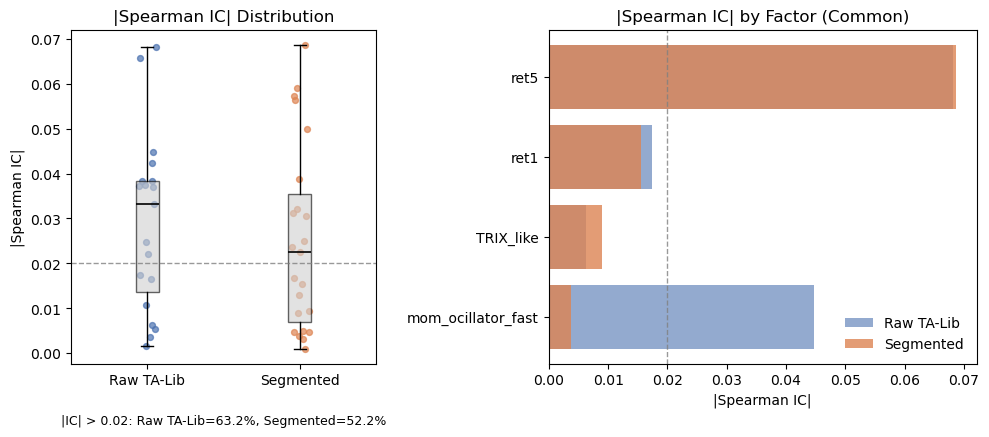

In [41]:
s_raw = (corr_check(ticker = 'ih_main', family="mom",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="mom",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


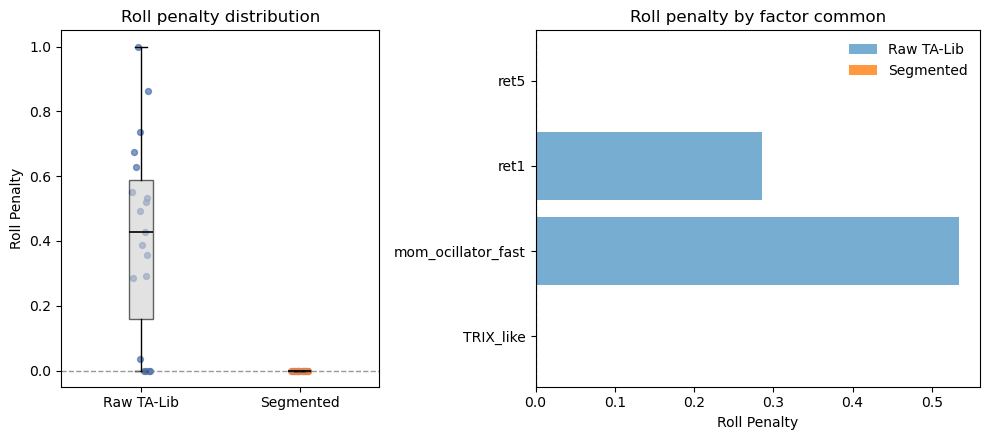

In [42]:
s_raw = (corr_check(ticker = 'ih_main', family="mom",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="mom",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

For the SSE 50 index futures, we observe a pattern consistent with that of the CSI 300: the unmasked configuration exhibits a more stable profile in terms of directional consistency compared with the masked setting.

对于上证 50 股指期货，我们观察到与中证 500 股指期货一致的现象：相较于 mask 设定，非 mask 构造在方向一致性指标上表现出更为稳定的特征。

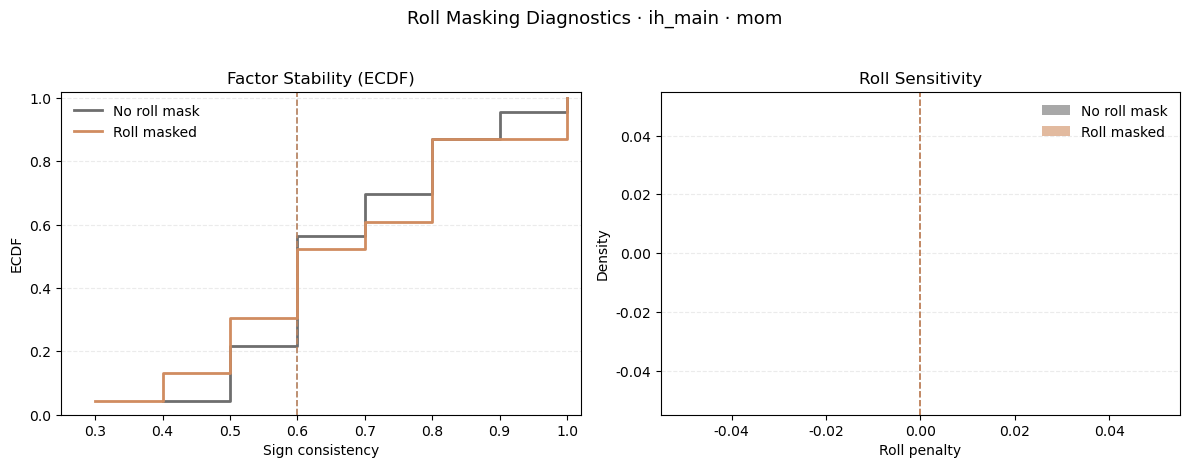

In [43]:
plot_roll_mask_diagnostics(ticker="ih_main", family="mom", cls=treemodel_factors_augment)

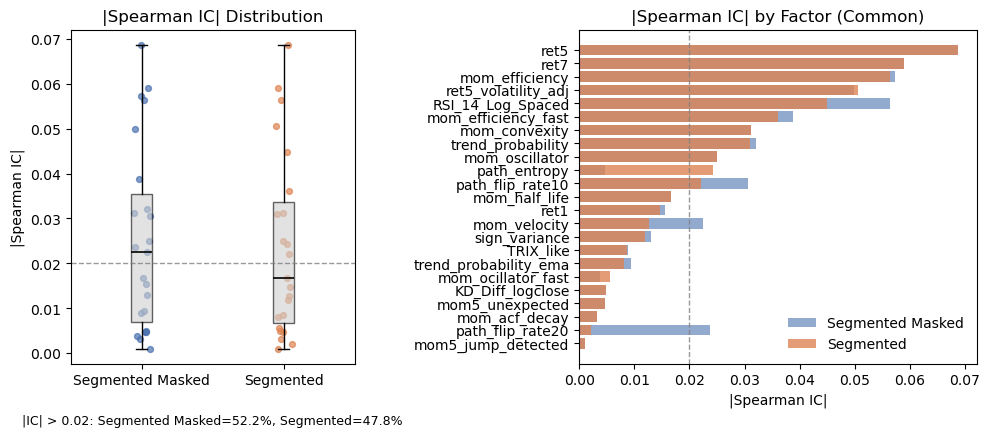

In [44]:
s_raw = (corr_check(ticker = 'ih_main', family="mom",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="mom",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,mask = False)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Segmented Masked", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

#### **Trend**

In futures markets, particularly index futures, persistent price trends are often affected by frequent contract rollovers, structural non-stationarity, and dynamic changes in liquidity and positioning structures. As a result, directly modeling trend as long-horizon price drift typically lacks stability and reliability in practice. Based on this observation, this study deliberately and explicitly distinguishes between momentum and trend at the overall framework design level.

The momentum factors defined earlier are primarily outcome-oriented descriptive indicators, intended to characterize price displacement and short-horizon path behavior, answering the questions of “what price movements occurred” and “how those movements unfolded over a local time scale.” Such signals are effective in describing immediate directional pressure, path irregularity, and the internal force characteristics of short-term momentum, but they **do not directly reflect whether these price movements can persist under constraints related to time, contract boundaries, and changes in participation structure**.

Building on this distinction, the trend module does not introduce new price displacement signals, but instead serves as a layer that characterizes the persistence of momentum under rollover constraints. The central question it addresses is whether existing momentum evolves into a coherent, sustainable market state with structural support. Accordingly, trend features do not rely on a single long-horizon return; rather, they comprehensively evaluate the quality, stability, and participation support of momentum signals—rather than their instantaneous strength—through higher-order diagnostics such as return skewness, directional consistency, trend age, open-interest participation, and relative mispricing.

At the daily frequency, the framework further incorporates a small number of empirically motivated trend indicators inspired by classical WorldQuant-style factors, which are used to describe typical behavioral patterns observed in the later stages of trends, such as trend exhaustion, acceleration-based reversal, and regime transition. In this study, such indicators are treated solely as auxiliary, interpretable tools for diagnosing trend phases, rather than as primary predictive signals.

It should be emphasized that these rule-based trend indicators are explicitly restricted to daily data. In higher-frequency settings (such as 60-minute, 30-minute, and 15-minute bars), although rollover effects are relatively weaker, microstructure noise increases significantly, making threshold-based and piecewise decision rules more prone to unstable triggering and thereby introducing artificial structural breaks and data-snooping risk. For robustness considerations, the high-frequency trend module is therefore strictly limited to continuous, interpretable state variables, deliberately excluding such heuristic rules.

Overall, the trend module should be understood as a structural characterization layer of momentum states: momentum is used to describe price movement and local path features, while trend is used to assess whether that momentum manifests as a persistent, coherent, and structurally supported state under futures-specific constraints, rather than assuming the inevitable existence of long-term trends.

在期货市场，尤其是股指期货中，价格的持续性趋势往往受到频繁换月、结构性非平稳性以及流动性与持仓结构动态变化的影响。因此，将趋势直接建模为长期价格漂移在实践中通常缺乏稳定性与可靠性。基于这一事实，本研究在整体框架设计上对动量与趋势进行了有意识且明确的区分。

前文定义的动量因子主要属于结果导向型描述指标，用于刻画价格位移及其短期路径行为，回答“价格发生了什么变化”以及“该变化在局部时间尺度上如何展开”。这类信号能够有效描述即时方向压力、路径不规则性以及短期动量的内部动力特征，**但并不直接反映这些价格运动是否能够在时间维度、合约边界及参与结构变化等约束条件下持续存在**。

在此基础上，趋势模块并未引入新的价格位移信号，而是作为在换月约束下对动量持续状态的刻画层存在。该模块关注的核心问题是：已有动量是否演化为一个连贯、可持续、且具备结构性支撑的市场状态。相应的趋势特征并不依赖单一的长周期回报，而是通过回报偏态、方向一致性、趋势年龄、开仓量参与以及相对偏离等高阶诊断指标，对动量信号的质量、稳定性与参与度支撑进行综合评估，而非刻画其瞬时强度。

在日频层面，框架进一步引入少量基于经验规则的趋势类指标，这些指标借鉴了经典的 WorldQuant 风格趋势因子，用于刻画趋势进入后期阶段时的典型行为模式，例如趋势衰竭、加速反转以及阶段性切换。此类指标在本研究中仅作为辅助性的、可解释的趋势阶段诊断工具，而非主要预测信号。

需要强调的是，上述基于规则的趋势指标被明确限制在日频数据中使用。在更高频场景（如 60 分钟、30 分钟与 15 分钟），尽管换月影响相对减弱，但微观结构噪声显著增强，使得阈值化、分段式决策规则更容易出现不稳定触发，从而引入人为的结构断裂与数据窥探风险。基于稳健性考虑，高频趋势模块严格限定为连续、可解释的状态型变量，刻意排除此类启发式规则。

总体而言，本趋势模块应被理解为对动量状态的结构性刻画层：动量用于描述价格运动及其局部路径特征，而趋势用于判断该动量是否能够在期货市场特有约束条件下表现为持续、连贯且具备结构性支撑的状态，而非假设长期趋势的必然存在。

#### **Feature Design**

**Skewness**

Skewness is a statistical diagnostic of how returns are accumulated over time. While trend probability captures the frequency of directional outcomes and therefore reflects persistence in a probabilistic sense, it treats all observations symmetrically and does not distinguish whether cumulative returns arise from evenly distributed movements or from a small number of extreme realizations.

Skewness, by contrast, encodes the asymmetry of return contributions and thus provides information about the structural support underlying momentum accumulation.

In this sense, skewness measures whether observed momentum is sustained by broadly distributed, repeatable return contributions, or whether it relies disproportionately on a small number of extreme outcomes—a distinction that directly relates to the durability of a trend state.

Positive skew indicates that recent performance is increasingly supported by larger directional contributions, while negative skew suggests weakening or deteriorating structural support. This perspective allows acceleration- and convexity-related diagnostics to be defined in a more meaningful, state-based manner, rather than as simple changes in directional frequency.

偏度（skewness）是一种用于刻画回报在时间维度上如何被累积的统计诊断指标。 尽管趋势概率通过刻画方向性结果出现的频率，在概率意义上反映了持续性，但它对所有观测赋予对称权重，因而无法区分累计回报是来源于均匀分布的价格变动，还是主要由少数极端观测值所贡献。

相比之下，偏度刻画的是回报贡献的非对称性，从而为理解动量累积过程背后的结构性支撑提供了信息。

从这一意义上讲，偏度用于判断观测到的动量是由广泛分布、可重复的回报贡献所支撑，还是在不成比例地依赖于少数极端结果——这一差异与趋势状态的可持续性直接相关。

正偏度表明近期表现越来越多地由较大的方向性回报所支撑，而负偏度则意味着结构性支撑正在减弱或出现劣化。 基于这一视角，与加速度和凸性相关的诊断指标可以在更具状态意义的层面上加以定义，而不再仅仅被理解为方向出现频率的简单变化。

| Factor                     | Definition                                                                            | Measures                                             | Interpretation                                                                                                                                |
| -------------------------- | ------------------------------------------------------------------------------------- | ---------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------- |
| returns_skew_5bar        | Rolling skewness of 1-period log returns over a 5-bar window                          | Short-horizon asymmetry of return contribution       | Positive values indicate momentum supported by larger directional returns; negative values suggest weakening or imbalanced structural support |
| returns_skew_20bar       | Rolling skewness of 1-period log returns over a 20-bar window (**minute frequency only**) | Long-horizon structural asymmetry                    | Highlights sustained dominance of extreme contributions, often associated with regime-level support or fragility                              |
| skew5_acceleration       | First-order difference of 5-bar return skewness                                       | Change in structural support over time               | Increasing values indicate strengthening contribution asymmetry; decreasing values suggest deterioration or normalization of trend support    |
| skew_convexity_5_7       | Difference between rescaled 7-bar and 5-bar skewness                                  | Cross-horizon curvature of return contribution       | Positive values signal convex strengthening of momentum support; negative values indicate flattening or early structural fatigue              |
| skew_regime_shift       | Deviation of short-horizon skewness from its recent rolling mean                      | Structural regime transition                         | Large deviations indicate changes in how momentum is supported, often preceding stabilization or breakdown                                    |
| skew_direction_alignment | Interaction between return skewness and smoothed directional sign                     | Alignment of structural support with trend direction | Positive values indicate skew-supported directional coherence; negative values suggest asymmetry opposing the prevailing trend                |


**Open Interest**

In futures markets, open interest reflects the total number of outstanding contracts that remain open, and its changes characterize whether market participants are willing to maintain risk exposure over time. Unlike trading volume, which primarily captures transaction activity, open interest is more closely associated with the intensity of market participation and the degree of risk commitment. An increase in open interest typically indicates net position creation and sustained capital inflow, whereas a decrease corresponds to position liquidation or deleveraging, often observed during periods of trend exhaustion or declining risk appetite. Consequently, variations in open interest provide important complementary information for understanding the participation structure underlying price movements.

Trend or momentum indicators constructed solely from price data implicitly assume that price fluctuations are driven by persistent directional forces. In practice, however, price movements may also arise from non-structural mechanisms such as temporary liquidity imbalances, position covering, or exogenous shocks. While such price displacements may appear trend-like ex post, they often lack durability.

Motivated by this distinction, open interest dynamics are incorporated as conditioning information to assess whether observed price trends are supported by genuine position-taking behavior, thereby distinguishing structurally supported trends from transient price movements.

在期货市场中，持仓量（Open Interest）反映的是尚未平仓合约的整体规模，其变化刻画了市场参与者是否愿意持续保留风险敞口。与成交量主要侧重交易活跃度不同，持仓量更接近于对市场参与强度与风险承诺程度的描述：持仓增加通常意味着新增仓位进入市场，代表资金的持续投入；持仓减少则对应仓位的集中平仓或去杠杆行为，往往出现在趋势衰减阶段或风险偏好下降时期。因此，持仓变化为理解价格走势背后的参与结构提供了重要补充信息。

单纯基于价格构造的趋势或动量指标，隐含假设价格变动由持续的方向性力量驱动。然而在实际交易中，价格波动亦可能源于短期流动性失衡、仓位回补或外生冲击等非结构性因素。此类价格位移在事后呈现趋势形态，但通常缺乏持续性。

基于上述考虑，我们引入持仓变化作为条件信息，用于刻画价格趋势是否伴随真实的仓位行为，从而区分结构性趋势与短暂的价格扰动。

| Factor                     | Definition                                                                        | Measures                                                                    | Interpretation                                                                                                                                                                                                           |
| -------------------------- | --------------------------------------------------------------------------------- | --------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| trend_strength_oi        | Normalized price trend efficiency conditioned on the sign of open interest change | Structural strength of price trends under position expansion or contraction | Positive values indicate efficient, low-noise price trends supported by open interest expansion; negative values suggest price movement occurring alongside position unwinding, implying weaker structural trend support |
| trend_oi_agree           | Sign interaction between price trend direction and open interest change           | Directional agreement between price movement and position dynamics          | Positive values indicate price movement aligned with position accumulation, reflecting coherent trend participation; negative values suggest price changes driven by position liquidation or short covering              |
| oi_direction_persistence | Rolling mean of the sign of open interest changes over a medium horizon           | Temporal stability of positioning behavior                                  | Values close to ±1 indicate persistent position accumulation or liquidation, often associated with durable trend structures; values near zero reflect unstable or transitory participation dynamics                      |


**Misprice**

Conditional on the presence of an identified trend, mispricing measures are employed to assess whether short-term price movements remain consistent with the trajectory implied by longer-horizon trend structures. When short-term displacements fall within the range suggested by medium- or long-term trends, price dynamics can be interpreted as structurally coherent and trend-consistent. In contrast, significant deviations from the trend baseline indicate internal tension within the trend, reflecting either acceleration or deceleration of price dynamics.

Positive mispricing typically corresponds to phases of trend acceleration, where price movements exceed the scale implied by the prevailing trend and become increasingly sensitive to volatility and shocks. Negative mispricing, by contrast, reflects underperformance relative to the trend anchor and is often observed ahead of consolidation or trend deterioration. Accordingly, mispricing factors are not used as standalone directional signals, but as conditional descriptors that refine trend interpretation by distinguishing orderly continuation from overextension and structural fatigue.

在趋势已被识别的前提下，错配因子用于刻画短期价格位移是否与更长时间尺度下的趋势结构相一致。若短期价格变动幅度与中长期趋势所隐含的合理区间相符，则表明价格运行仍处于趋势框架之内，趋势结构保持稳定；反之，若短期价格显著偏离趋势基准，则反映价格运行出现加速或滞后，从而揭示趋势内部的结构张力。

具体而言，正向错配通常对应趋势加速阶段，价格运行速度快于趋势基准，虽不必然意味着反转，但其对波动率与冲击更为敏感；而负向错配则表明价格动能相对趋势减弱，往往出现在趋势衰减或转入震荡阶段之前。因此，错配因子并非用于独立判断方向，而是作为趋势条件下的补充刻画，用于区分趋势延续、过度扩张及结构性疲劳等不同运行状态。

| Factor        | Definition                                                                                                                 | Measures                                                                    | Interpretation                                                                                                                                                                                                                         |
| ------------- | -------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| mr_rel_S_M  | Difference between short-horizon realized drift and medium-horizon expected drift, normalized by medium-horizon volatility | Cross-horizon price displacement relative to the medium-term trend          | Positive values indicate short-term price movement exceeding what the medium-term trend would imply (trend acceleration or overextension); negative values suggest short-term underperformance or lag relative to the prevailing trend |
| mr_rel_S_L  | Difference between short-horizon realized drift and long-horizon expected drift, normalized by long-horizon volatility     | Cross-horizon price displacement relative to the long-term structural trend | Positive values reflect short-term movement stretched relative to the broader trend structure; negative values indicate compression or early divergence from long-horizon trend expectations                                           |
| mr_inst_z_S | One-period return deviation from short-horizon expected return, normalized by short-horizon volatility                     | Instantaneous price displacement                                            | Large absolute values capture transient shocks or local liquidity imbalances; values near zero indicate price movement consistent with short-horizon expectations                                                                      |

**Trend consistency & Trend Age**

Trend characterization based solely on returns or momentum typically relies on return magnitude or volatility-adjusted measures, which provide only indirect information about the stability of directional behavior. To more directly assess trend quality, additional factors are introduced to capture directional coherence and temporal persistence. Trend consistency measures whether short-horizon price movements align with the prevailing medium-horizon trend, reflecting cross-scale coordination of directional behavior. Trend age, in turn, quantifies how long the current directional regime has persisted without interruption, providing a direct measure of trend maturity. By incorporating these dimensions, trends are no longer defined purely by the size of price movements, but are explicitly characterized as directional structures that exhibit both cross-horizon coherence and persistence over time, allowing for clearer distinction between stable trends and noise-driven price fluctuations.

在趋势刻画中，趋势强度往往通过收益幅度或波动调整后的收益来间接衡量，但此类指标难以区分价格方向性行为本身的稳定程度。为更直接刻画趋势的结构质量，本文进一步引入趋势一致性与趋势年龄因子，分别从跨时间尺度的一致性与时间维度上的持续性对趋势进行刻画。趋势一致性用于衡量短周期价格方向是否与中周期趋势保持一致，反映趋势在不同时间尺度下是否具备协调性；趋势年龄则刻画当前方向性运行已持续的时间长度，用于衡量趋势是否已形成稳定的行为模式。通过引入这两类因子，趋势不再仅由收益大小间接定义，而是被直接刻画为一种具有方向一致性与时间持续性的价格行为结构，从而更有助于区分稳定趋势与噪音驱动的短期波动。

| Factor                     | Definition                                                                                  | Measures                                                         | Interpretation                                                                                                                                                                                                      |
| -------------------------- | ------------------------------------------------------------------------------------------- | ---------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| trend_consistency_signed | Signed interaction between short- and medium-horizon trend directions                       | Cross-horizon directional coherence                              | Positive values indicate alignment between short- and medium-term trends, reflecting coherent directional structure; negative values suggest short-term movements conflicting with the prevailing medium-term trend |
| trend_age                | Length of the current uninterrupted run of same-signed returns within each contract segment | Temporal persistence of directional behavior                     | Larger values indicate a more established directional regime; small values suggest recently formed or unstable trends                                                                                               |
|trend_age_norm           | Trend age normalized by long-horizon realized volatility                                    | Persistence of directional behavior relative to background noise | High values reflect long-lasting directional behavior that is significant relative to volatility; low values indicate fragile or noise-dominated directional runs                                                   |


**World Quant Alpha**

In addition to the internally constructed trend, mispricing, and positioning-related factors, a limited set of classical time-series factors inspired by existing quantitative literature and widely used benchmark designs is incorporated as supplementary inputs. These factors are typically derived from time-series ranking or local statistical patterns and aim to capture phenomena such as trend maturity, acceleration or deceleration dynamics, and differential price behavior across weak and strong trend regimes. Their inclusion is not intended to define the core modeling framework, but rather to complement the internally designed factor set by covering certain edge cases and extreme behaviors that are less directly represented. Within the overall architecture, these factors serve as auxiliary descriptors that enhance regime coverage and robustness, rather than acting as primary directional signals.

除自主构建的趋势、错配与持仓结构因子外，本文亦引入少量源自既有量化研究与公开文献中的经典时间序列因子作为补充。这类因子通常基于时间序列排序（time-series ranking）或局部统计特征构建，侧重刻画趋势成熟度、加速与减速特征以及不同趋势强弱状态下的价格响应模式。引入这些外部因子并非作为核心建模逻辑，而是用于覆盖部分在自主因子体系中难以直接刻画的极端或边缘市场行为，同时为模型提供一定的跨研究范式参考。在整体设计中，此类因子仅作为补充信息参与模型学习，其作用更多体现在增强状态识别的完整性，而非主导预测方向。

**Note**

In the loose configuration, the trend class is defined less broadly, only incorporating Mispricing and Skewness features alongside Trend Strength, which is implemented as a more lenient mean/standard-deviation–based measure that allows for multi-cycle behavior.

**CSI 500 Index Futures**

In [45]:
print('Robust Version: Modeling on Log Close')
corr_check(ticker = 'ic_main', family = 'trend', cls = treemodel_factors_augment, selection = True, light = False)

Robust Version: Modeling on Log Close
[rolling_corr_report] Pairs exist but none met presence ≥ 70%. (corr_thresh=0.9, n_slices=10)
target 1 period next return created
[coverage] kept 17/17 features (≥ 55%, n_eff ≥ 200); median coverage=79.26%, median n_eff=1857
Pearson Effective 58.82%
Spearman Effective 76.47%
Kendall Effective 41.18%
[selection] kept 12/17 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=17): 88.24%
roll_penalty     > 0.10 (all features, n=17): 0.00%


pearson  spearman   kendall  effective_pct  \
returns_skew_5bar         0.026559  0.023771  0.015587       1.000000   
skew_convexity_5_7       -0.010635 -0.025252 -0.016413       0.666667   
skew_regime_shift         0.023827  0.020158  0.013122       0.666667   
skew_direction_alignment  0.027601  0.026839  0.017737       1.000000   
trend_strength_oi         0.008603  0.030272  0.020308       0.666667   
trend_oi_agree            0.033368  0.028878  0.023596       1.000000   
oi_direction_persistence  0.070349  0.085499  0.060020       1.000000   
mr_rel_S_M               -0.021253 -0.039326 -0.026779       1.000000   
mr_rel_S_L               -0.033346 -0.046096 -0.031007       1.000000   
mr_inst_z_S               0.015118  0.042726  0.028787       1.000000   
trend_age_norm           -0.026942 -0.032704 -0.021218       1.000000   
regime_switch_alpha24     0.023519  0.027499  0.017996       1.000000   

                          year_spearman_min  year_spearman_max  \
returns_skew_5bar                 -0.023075           0.064976   
skew_convexity_5_7                -0.167272           0.092652   
skew_regime_shift                 -0.057741           0.105232   
skew_direction_alignment          -0.150924           0.165835   
trend_strength_oi                 -0.167117           0.157242   
trend_oi_agree                    -0.179192           0.161884   
oi_direction_persistence           0.032269           0.190274   
mr_rel_S_M                        -0.138440           0.024621   
mr_rel_S_L                        -0.174720           0.045967   
mr_inst_z_S                       -0.077651           0.132286   
trend_age_norm                    -0.159755           0.015599   
regime_switch_alpha24             -0.039060           0.099486   

                          sign_consistency  roll_penalty  winsor_penalty  \
returns_skew_5bar                      0.9           0.0        0.000521   
skew_convexity_5_7                     0.7           0.0        0.000000   
skew_regime_shift                      0.8           0.0        0.000000   
skew_direction_alignment               0.6           0.0        0.002435   
trend_strength_oi                      0.7           0.0        0.000000   
trend_oi_agree                         0.7           0.0        0.000000   
oi_direction_persistence               1.0           0.0        0.000000   
mr_rel_S_M                             0.8           0.0        0.000000   
mr_rel_S_L                             0.8           0.0        0.000960   
mr_inst_z_S                            0.8           0.0        0.000000   
trend_age_norm                         0.9           0.0        0.001714   
regime_switch_alpha24                  0.7           0.0        0.001642   

                          decile_LS_signed  decile_long_return  \
returns_skew_5bar                 0.002840            0.001370   
skew_convexity_5_7                0.003327           -0.002316   
skew_regime_shift                 0.004304            0.001530   
skew_direction_alignment          0.000064           -0.000798   
trend_strength_oi                 0.000236            0.000688   
trend_oi_agree                         NaN                 NaN   
oi_direction_persistence          0.002393           -0.000073   
mr_rel_S_M                        0.000981           -0.000622   
mr_rel_S_L                        0.003365           -0.001262   
mr_inst_z_S                       0.003766            0.002607   
trend_age_norm                    0.004400           -0.000713   
regime_switch_alpha24             0.002353            0.001346   

                          decile_short_return       QSL  
returns_skew_5bar                   -0.001470  0.622426  
skew_convexity_5_7                   0.001011  0.463309  
skew_regime_shift                   -0.002775  0.509305  
skew_direction_alignment            -0.000862  0.450012  
trend_strength_oi                    0.000452  0.450944  
trend_oi_agree        

In [46]:
corr_check(ticker = 'ic_main', family = 'trend', cls = treemodel_factors_daily, selection = True, light = False)

[rolling_corr_report] slices=10, corr_thresh=0.9, pairs_reported=32 (presence ≥ 70%)
                                                 Pair  freq  presence  \
0                      FAMA — Weighted_Moving_Average    10       1.0   
1            Moving_Average — Weighted_Moving_Average    10       1.0   
2                               FAMA — Moving_Average    10       1.0   
3   Kaufman_Adaptive_Moving_Average — Weighted_Mov...    10       1.0   
4    Kaufman_Adaptive_Moving_Average — Moving_Average    10       1.0   
5              FAMA — Kaufman_Adaptive_Moving_Average    10       1.0   
6                      MAMA — Weighted_Moving_Average    10       1.0   
7       Double_Exponential_Moving_Average — Mid_Price     9       0.9   
8   Double_Exponential_Moving_Average — Ichimoku_T...     9       0.9   
9                          Ichimoku_Tenkan_Sen — MAMA     9       0.9   
10  Ichimoku_Tenkan_Sen — Triple_Exponential_Movin...     9       0.9   
11  Double_Exponential_Moving_Average —

pearson  spearman   kendall  effective_pct  year_spearman_min  \
ADX_Slope  0.028953  0.033476  0.022509            1.0          -0.045419   

           year_spearman_max  sign_consistency  roll_penalty  winsor_penalty  \
ADX_Slope           0.118131               0.7           0.0        0.001037   

           decile_LS_signed  decile_long_return  decile_short_return       QSL  
ADX_Slope          0.003278            0.002974            -0.000303  0.463007

As discussed earlier, the back-adjusted continuous main contract construction introduces strong scale alignment at the price level, resulting in abnormally high OHLC correlations over the full sample. Under this setting, naively including a full set of level-based TA-Lib trend indicators leads to severe feature redundancy, effective dimension collapse, and the risk of misinterpreting contract-construction effects as genuine trend signals. In contrast, by constructing factors under themes such as Skewness, Open Interest, Mispricing, and Trend Consistency & Trend Age with segment-safe, contract-wise computation, we effectively mitigate dimension collapse. Empirically, these factors exhibit strong Spearman effectiveness, with 76.47% showing absolute correlations above 0.02, and their performance is largely insensitive to contract roll effects in given sample.



正如前文所述，后复权主力连续合约的构造会在价格层面引入显著的尺度一致性，使得 OHLC 在全样本上呈现异常偏高的相关性。在此背景下，直接全量使用基于价格水平平滑的 TA-Lib trend 因子，容易导致特征高度冗余、有效维度塌缩，并使模型将合约构造特征误识别为趋势信号。相比之下，我们围绕 Skewness、Open Interest、Misprice 以及 Trend Consistency 与 Trend Age 等主题，采用合约分割（segment-safe）的方式的因子构造，有效避免了维度塌缩问题；结果显示，该类因子在 Spearman 相关性上表现出较显著有效性，其中 76.47% 的因子绝对值大于 0.02，且整体表现在nan去除保留后的样本中几乎不受换月结构驱动。

In [47]:
cls = treemodel_factors_augment(ticker = 'ic_main', frequency = 'day')
cls.data[['close', 'open', 'low', 'high']].corr()

close      open       low      high
close  1.000000  0.992536  0.996513  0.995117
open   0.992536  1.000000  0.994902  0.996583
low    0.996513  0.994902  1.000000  0.992289
high   0.995117  0.996583  0.992289  1.000000

target 1 period next return created


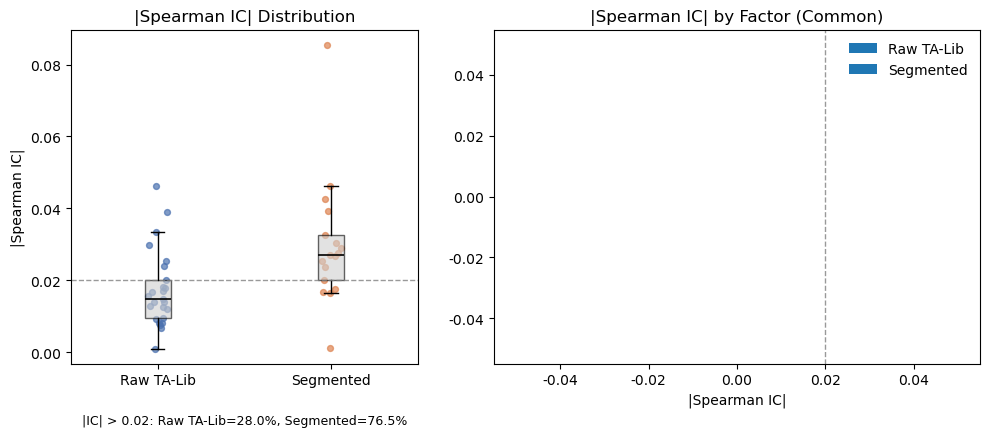

In [48]:
s_raw = (corr_check(ticker = 'ic_main', family="trend",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="trend",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


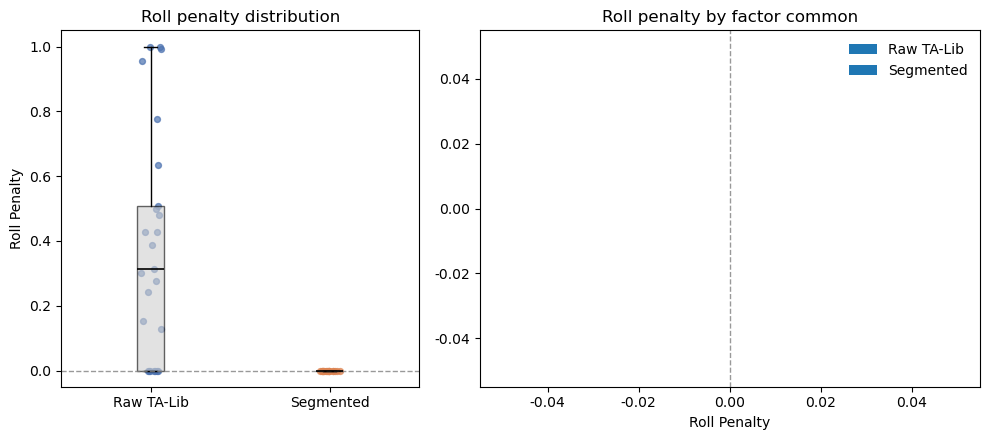

In [49]:
s_raw = (corr_check(ticker = 'ic_main', family="trend",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="trend",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

For the CSI 500 trend factors, we observe that the masked configuration exhibits materially higher stability in Spearman correlation compared with the non-masked setting. However, a closer inspection shows that several factors outperforming the non-masked version—such as Trend Strength, Open Interest Interaction, and Skewness–Strength Interaction—may imply unrealistic trading decisions if contract roll points are not explicitly excluded or constrained. Such effects can potentially influence model decision-making, and we therefore leave a more thorough assessment incorporating trading feasibility and roll-aware constraints to future work.

在中证 500 的 trend 因子分析中，我们观察到 masked 设定在 Spearman 稳定性上整体显著优于 non-mask 版本。然而，进一步检查发现，部分在 masked 条件下表现优于 non-mask 的因子（如 Trend Strength、Open Interest Interaction 以及 Skewness–Strength Interaction），在未显式丢弃或约束换月点交易决策的情况下，可能会隐含不现实的交易行为，从而对模型决策产生一定影响。针对该问题，我们将在后续研究中结合交易可行性与换月约束进行进一步评估。

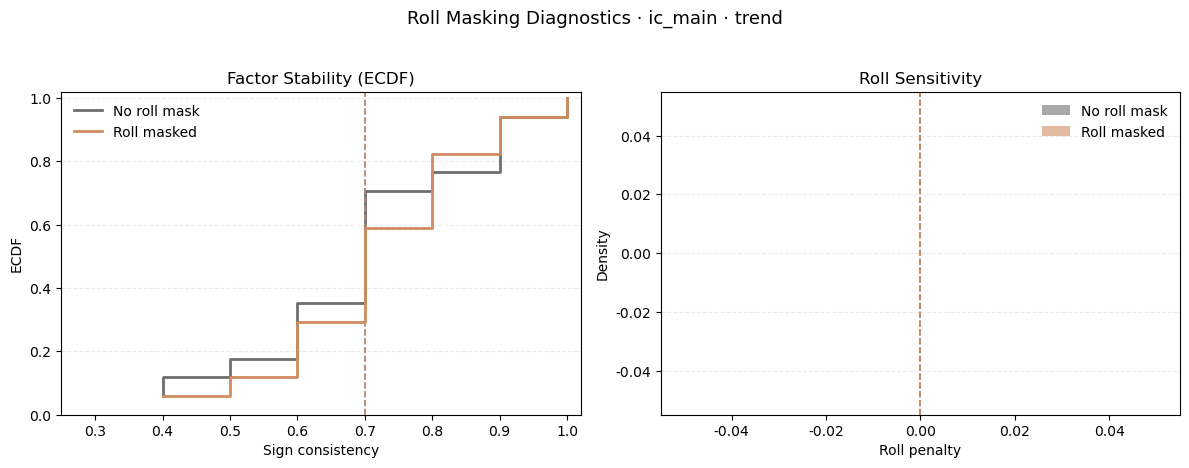

In [50]:
plot_roll_mask_diagnostics(ticker="ic_main", family="trend", cls=treemodel_factors_augment)

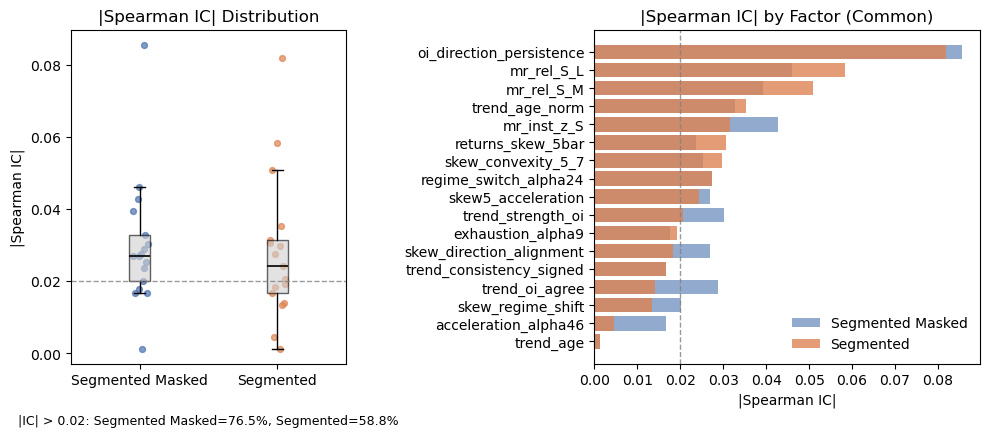

In [51]:
s_raw = (corr_check(ticker = 'ic_main', family="trend",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="trend",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,mask = False)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Segmented Masked", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

**Higher Frequency**

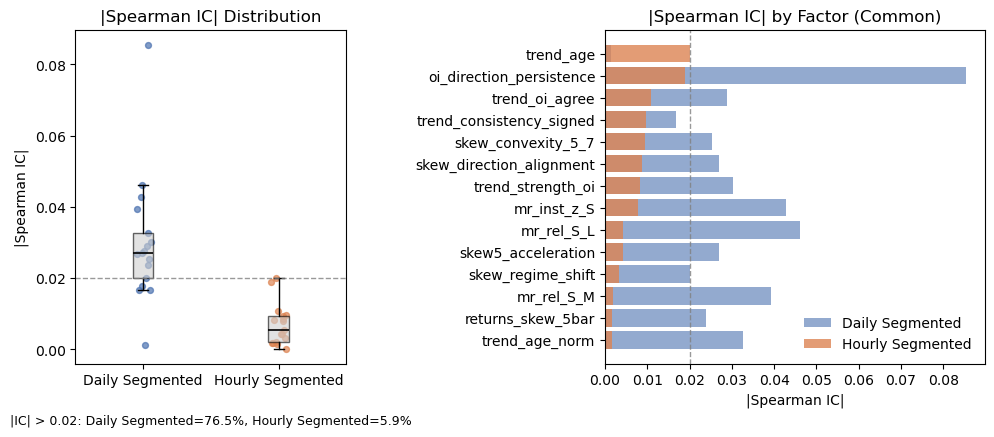

In [52]:
s_day = (corr_check(family="trend",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_hour = (corr_check(ticker = 'ic', frequency = 'minute', multiplier = 60, family="trend",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_day,s_hour, label1="Daily Segmented", label2="Hourly Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

**CSI 300 Index Futures**

In [53]:
corr_check(ticker = 'if_main', family="trend",cls=treemodel_factors_daily,selection=True,light=False,verbose=True,)

[rolling_corr_report] slices=10, corr_thresh=0.9, pairs_reported=34 (presence ≥ 70%)
                                                 Pair  freq  presence  \
0                      FAMA — Weighted_Moving_Average    10       1.0   
1            Moving_Average — Weighted_Moving_Average    10       1.0   
2                               FAMA — Moving_Average    10       1.0   
3   Ichimoku_Tenkan_Sen — Triple_Exponential_Movin...     9       0.9   
4   Double_Exponential_Moving_Average — Triple_Exp...     9       0.9   
5   Double_Exponential_Moving_Average — Weighted_M...     9       0.9   
6       Double_Exponential_Moving_Average — Mid_Price     9       0.9   
7            MAMA — Triple_Exponential_Moving_Average     9       0.9   
8                          Ichimoku_Tenkan_Sen — MAMA     9       0.9   
9   Double_Exponential_Moving_Average — Ichimoku_T...     9       0.9   
10                    Ichimoku_Tenkan_Sen — Mid_Price     9       0.9   
11           Double_Exponential_Moving_

pearson  spearman   kendall  \
ADX_Slope                          0.030111  0.031041  0.020770   
ADX_Accel                          0.025501  0.034934  0.023326   
Adaptive_Gap                      -0.025268 -0.027113 -0.018361   
Kaufman_Adaptive_Moving_Average   -0.051257 -0.034749 -0.023527   
Parabolic_SAR                     -0.044826 -0.023966 -0.016421   
Weighted_Moving_Average           -0.049461 -0.033030 -0.022067   
Ichimoku_Tenkan_Sen               -0.048637 -0.030591 -0.020618   
Double_Exponential_Moving_Average -0.041042 -0.028602 -0.019053   
Triple_Exponential_Moving_Average -0.044453 -0.028958 -0.019421   
Mid_Price                         -0.044870 -0.027761 -0.018767   
Moving_Average                    -0.048027 -0.033339 -0.022203   
MAMA                              -0.056374 -0.035784 -0.023916   
FAMA                              -0.050509 -0.031759 -0.021290   

                                   effective_pct  year_spearman_min  \
ADX_Slope                                    1.0          -0.053579   
ADX_Accel                                    1.0          -0.012914   
Adaptive_Gap                                 1.0          -0.150313   
Kaufman_Adaptive_Moving_Average              1.0          -0.155025   
Parabolic_SAR                                1.0          -0.111417   
Weighted_Moving_Average                      1.0          -0.157436   
Ichimoku_Tenkan_Sen                          1.0          -0.145886   
Double_Exponential_Moving_Average            1.0          -0.163848   
Triple_Exponential_Moving_Average            1.0          -0.206783   
Mid_Price                                    1.0          -0.151512   
Moving_Average                               1.0          -0.138199   
MAMA                                         1.0          -0.187632   
FAMA                                         1.0          -0.154956   

                                   year_spearman_max  sign_consistency  \
ADX_Slope                                   0.125929               0.7   
ADX_Accel                                   0.082305               0.7   
Adaptive_Gap                                0.075640               0.7   
Kaufman_Adaptive_Moving_Average             0.048942               0.8   
Parabolic_SAR                               0.039318               0.7   
Weighted_Moving_Average                     0.031885               0.8   
Ichimoku_Tenkan_Sen                         0.023879               0.8   
Double_Exponential_Moving_Average           0.017848               0.8   
Triple_Exponential_Moving_Average           0.018301               0.8   
Mid_Price                                   0.025690               0.8   
Moving_Average                              0.046332               0.8   
MAMA                                        0.014007               0.8   
FAMA                                        0.040718               0.8   

                                   roll_penalty  winsor_penalty  \
ADX_Slope                              0.000000        0.000000   
ADX_Accel                              0.181008        0.000000   
Adaptive_Gap                           0.168472        0.002459   
Kaufman_Adaptive_Moving_Average        0.000000        0.003861   
Parabolic_SAR                          0.000000        0.002152   
Weighted_Moving_Average                0.000000        0.001101   
Ichimoku_Tenkan_Sen                    0.000000        0.004587   
Double_Exponential_Moving_Average      0.000000        0.004679   
Triple_Exponential_Moving_Average      0.000000        0.003881   
Mid_Price                              0.000000        0.005383   
Moving_Average                         0.000000        0.004126   
MAMA                                   0.000000        0.002355   
FAMA                                   0.000000        0.002768   

                                   decile_LS_signed  decile_long_return  \
ADX_Slope                                  0.003783

For the CSI 300, we observe a pattern similar to that of the CSI 500: the TA-Lib trend factor library exhibits pronounced structural redundancy. Although the share of factors with absolute Spearman correlations above 0.02 is slightly higher, this ratio is partly artificially elevated by clusters of highly repetitive indicators—such as FAMA, MAMA, and Weighted Moving Average—rather than by genuinely independent signals. Moreover, these apparent gains remain partially entangled with contract roll effects, making it difficult to interpret them as clean structural patterns. In comparison, trend factors constructed using a segment-safe approach can still be regarded as a more robust modeling alternative in terms of stability and interpretability.

对于沪深 300，我们观察到了与中证 500 类似的现象：TA-Lib trend 因子库中存在明显的结构性冗余。尽管其 Spearman 绝对值大于 0.02 的因子占比略高，但该比例在一定程度上是由高度重复的因子组合（如 FAMA、MAMA、Weighted Moving Average 等）所抬高，并未完全反映真实的有效信息增量。同时，这类因子表现仍不同程度地混杂着换月效应，使得相关统计结果难以对应清晰、稳定的结构性信号。相较之下，采用合约分割（segment-safe）构造的趋势因子在稳定性与可解释性层面仍可被视为更为稳健的建模选项。

target 1 period next return created


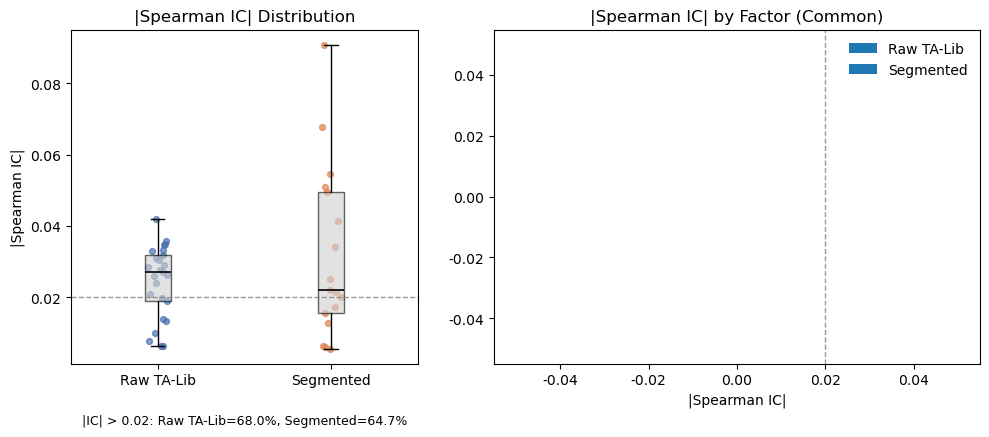

In [54]:
s_raw = (corr_check(ticker = 'if_main', family="trend",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'if_main', family="trend",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


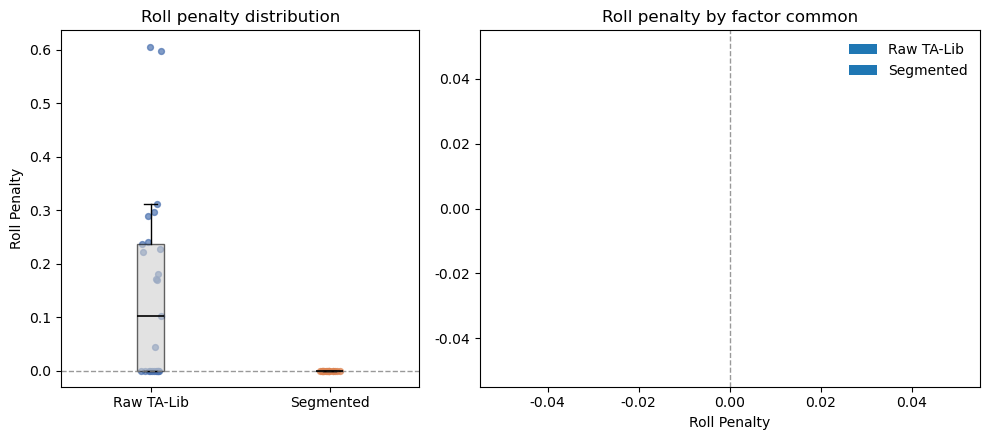

In [55]:
s_raw = (corr_check(ticker = 'if_main', family="trend",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'if_main', family="trend",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

For the trend factor subset, the masked configuration does not exhibit improved stability relative to the non-masked setting. The ECDF of sign consistency shows no systematic rightward shift, and in the mid-consistency region the masked version is slightly weaker. In addition, roll sensitivity is already negligible for these factors, leaving limited room for further improvement via masking.

在 trend 因子子集中，采用 mask 设定并未带来稳定性层面的系统性改善。从 sign consistency 的 ECDF 分布来看，mask 版本并未整体右移，且在中等一致性区间反而略有弱化；同时，该类因子本身对换月结构的敏感性已较低，使得进一步通过 mask 进行修正的空间有限。

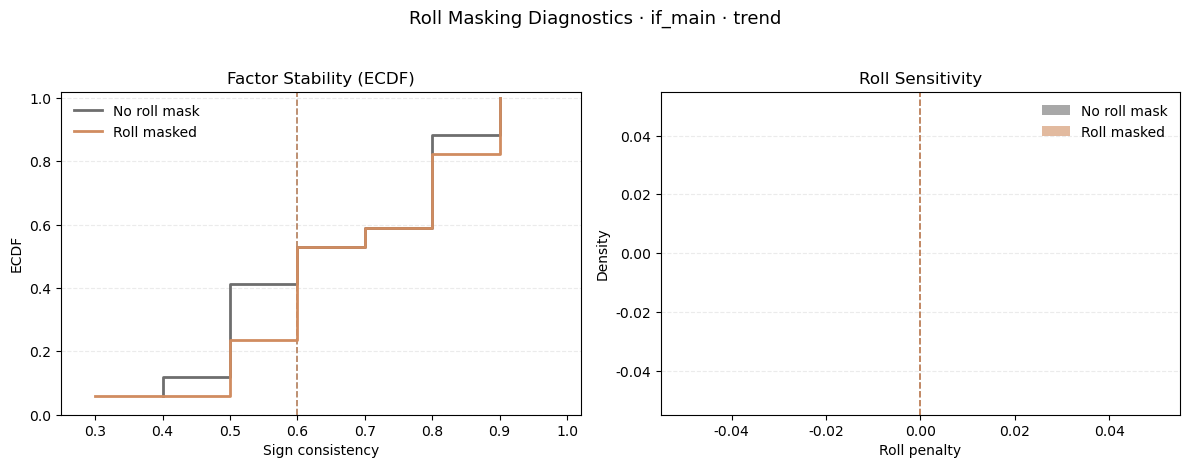

In [56]:
plot_roll_mask_diagnostics(ticker="if_main", family="trend", cls=treemodel_factors_augment)

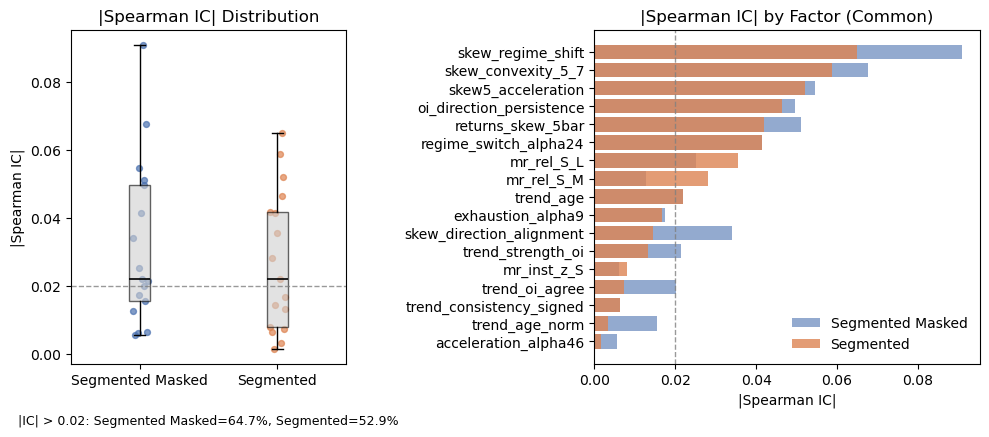

In [57]:
s_raw = (corr_check(ticker = 'if_main', family="trend",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'if_main', family="trend",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,mask = False)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Segmented Masked", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

**SSE 50 Index Futures**

In [58]:
corr_check(ticker = 'ih_main', family="trend",cls=treemodel_factors_daily,selection=True,light=False,verbose=True,)

[rolling_corr_report] slices=10, corr_thresh=0.9, pairs_reported=36 (presence ≥ 70%)
                                                 Pair  freq  presence  \
0                      FAMA — Weighted_Moving_Average    10       1.0   
1            Moving_Average — Weighted_Moving_Average    10       1.0   
2                               FAMA — Moving_Average    10       1.0   
3    Kaufman_Adaptive_Moving_Average — Moving_Average    10       1.0   
4                                         FAMA — MAMA    10       1.0   
5                      MAMA — Weighted_Moving_Average    10       1.0   
6       Double_Exponential_Moving_Average — Mid_Price     9       0.9   
7   Ichimoku_Tenkan_Sen — Triple_Exponential_Movin...     9       0.9   
8   Double_Exponential_Moving_Average — Weighted_M...     9       0.9   
9            MAMA — Triple_Exponential_Moving_Average     9       0.9   
10                         Ichimoku_Tenkan_Sen — MAMA     9       0.9   
11  Double_Exponential_Moving_Average —

pearson  spearman   kendall  \
ADX_Accel                             0.001228  0.028672  0.018984   
ADX_Weak_Trend                       -0.011973 -0.023876 -0.019500   
Adaptive_Gap                         -0.045399 -0.038923 -0.025914   
Plus_Directional_Indicator_(PLUS_DI) -0.000747 -0.030257 -0.019966   
Kaufman_Adaptive_Moving_Average      -0.046573 -0.030579 -0.021175   
Parabolic_SAR                        -0.049319 -0.030000 -0.020787   
Weighted_Moving_Average              -0.042123 -0.027629 -0.019101   
Ichimoku_Tenkan_Sen                  -0.045765 -0.030650 -0.021136   
Double_Exponential_Moving_Average    -0.040342 -0.022888 -0.015984   
Triple_Exponential_Moving_Average    -0.044589 -0.026747 -0.018459   
Mid_Price                            -0.043241 -0.028426 -0.019816   
Moving_Average                       -0.040642 -0.026662 -0.018256   
MAMA                                 -0.048774 -0.032669 -0.022354   
FAMA                                 -0.043731 -0.023646 -0.016520   

                                      effective_pct  year_spearman_min  \
ADX_Accel                                  0.666667          -0.050093   
ADX_Weak_Trend                             0.666667          -0.120338   
Adaptive_Gap                               1.000000          -0.107448   
Plus_Directional_Indicator_(PLUS_DI)       0.666667          -0.203935   
Kaufman_Adaptive_Moving_Average            1.000000          -0.165702   
Parabolic_SAR                              1.000000          -0.151842   
Weighted_Moving_Average                    1.000000          -0.189163   
Ichimoku_Tenkan_Sen                        1.000000          -0.167284   
Double_Exponential_Moving_Average          1.000000          -0.191461   
Triple_Exponential_Moving_Average          1.000000          -0.199062   
Mid_Price                                  1.000000          -0.160894   
Moving_Average                             1.000000          -0.163432   
MAMA                                       1.000000          -0.218497   
FAMA                                       1.000000          -0.166726   

                                      year_spearman_max  sign_consistency  \
ADX_Accel                                      0.115879               0.7   
ADX_Weak_Trend                                 0.117564               0.6   
Adaptive_Gap                                   0.081956               0.8   
Plus_Directional_Indicator_(PLUS_DI)          -0.006066               1.0   
Kaufman_Adaptive_Moving_Average                0.021993               0.9   
Parabolic_SAR                                  0.058677               0.8   
Weighted_Moving_Average                       -0.001709               1.0   
Ichimoku_Tenkan_Sen                           -0.005528               1.0   
Double_Exponential_Moving_Average             -0.016349               1.0   
Triple_Exponential_Moving_Average             -0.017165               1.0   
Mid_Price                                      0.003763               0.9   
Moving_Average                                 0.030850               0.8   
MAMA                                          -0.020598               1.0   
FAMA                                           0.010159               0.8   

                                      roll_penalty  winsor_penalty  \
ADX_Accel                                 0.000000        0.000000   
ADX_Weak_Trend                            0.143815        0.000000   
Adaptive_Gap                              0.000000        0.004766   
Plus_Directional_Indicator_(PLUS_DI)      0.095097        0.002743   
Kaufman_Adaptive_Moving_Average           0.000000        0.003121   
Parabolic_SAR                             0.000000        0.003422   
Weighted_Moving_Average                   0.000000        0.002302   
Ichimoku_Tenkan_Sen                       0.000000        0.003490   
Double_Exponential_Moving_Average         0.000000        0.003910   
Triple_Exponential_Mo

For the SSE 50 Index (IH), we observe for the first time that the segmented version performs materially worse than the TA-Lib benchmark. Beyond factors such as roll-related effects and inflated statistics driven by high redundancy within the TA-Lib trend library, this divergence may also be attributable to asset-specific characteristics of IH. Compared with the CSI 500 or CSI 300, IH is dominated by large-cap constituents with lower volatility, where price dynamics are more often governed by mean-reverting behavior, making sustained trend continuation less prevalent. Under such conditions, the relative advantage of segmented trend factors—constructed under a trend persistence assumption—may be inherently constrained.

在上证 50 指数（IH）上，我们首次显著观察到 segmented 版本整体表现弱于 TA-Lib 的情况。除去 TA-Lib 因子可能受换月效应与高重复度抬升统计表现等因素外，该差异亦可能与 IH 所特有的资产结构特性有关。相较于中证 500 或沪深 300，IH 以低波动率、大盘权重股为主，价格行为更常由 均值回复特征主导，趋势信号难以持续累积。在此市场环境下，基于趋势延续假设构造的 segmented trend 因子，其相对优势可能受到一定限制。

target 1 period next return created


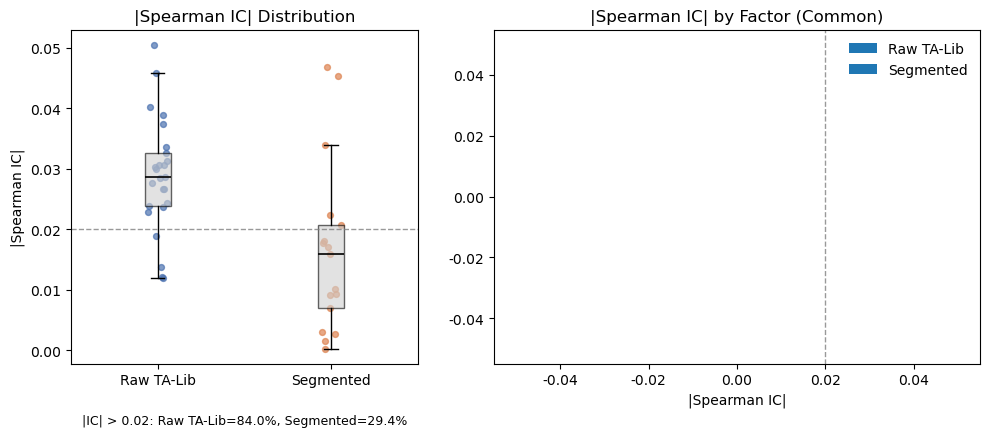

In [59]:
s_raw = (corr_check(ticker = 'ih_main', family="trend",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="trend",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


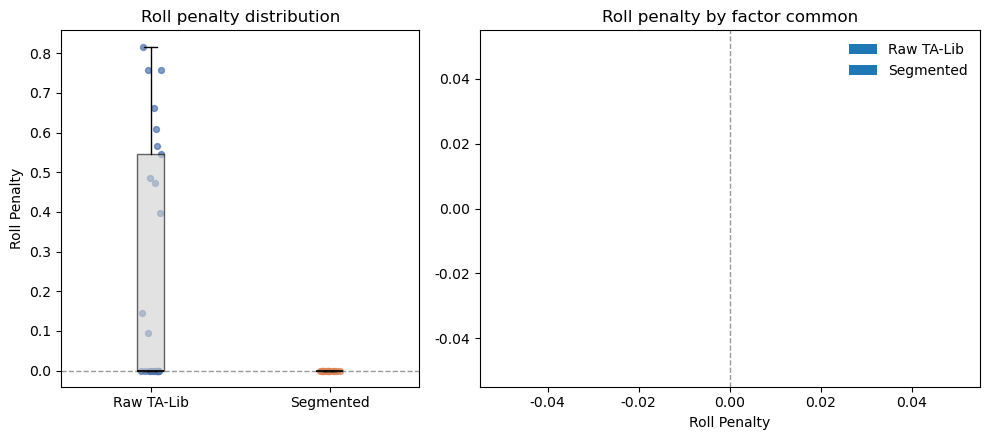

In [60]:
s_raw = (corr_check(ticker = 'ih_main', family="trend",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="trend",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

With respect to the masking setup, we observe a noteworthy effect for the SSE 50 (IH): although trend factors exhibit near-zero roll penalty in the given sample, Spearman performance declines after applying roll masking. This behavior is consistent with the relatively weak strength and limited accumulativeness of trend signals in IH. Compared with IC and IF, IH shows lower signal-to-noise ratios, weaker return autocorrelation, and less pronounced tail extension, indicating reduced directional buildup. Under such conditions, additional masking does not remove a dominant noise source and may instead obscure already scarce trend-related observations, leading to weaker Spearman effectiveness.

就 mask 设定而言，我们在上证 50（IH）上观察到一个值得关注的现象：尽管其 trend 因子整体 roll penalty 接近于低水平，在引入 roll mask 后，Spearman 表现反而出现下降。该现象与其趋势信号强度与累积能力较弱一致。相较于 IC、IF，IH 在 signal-to-noise 比率、收益自相关与尾部延展性等指标上均表现出较低的方向性积累特征。在此背景下，额外的 mask 并未移除主要噪声来源，反而可能遮蔽本已稀缺的有效趋势样本，从而导致 Spearman 有效性下降。

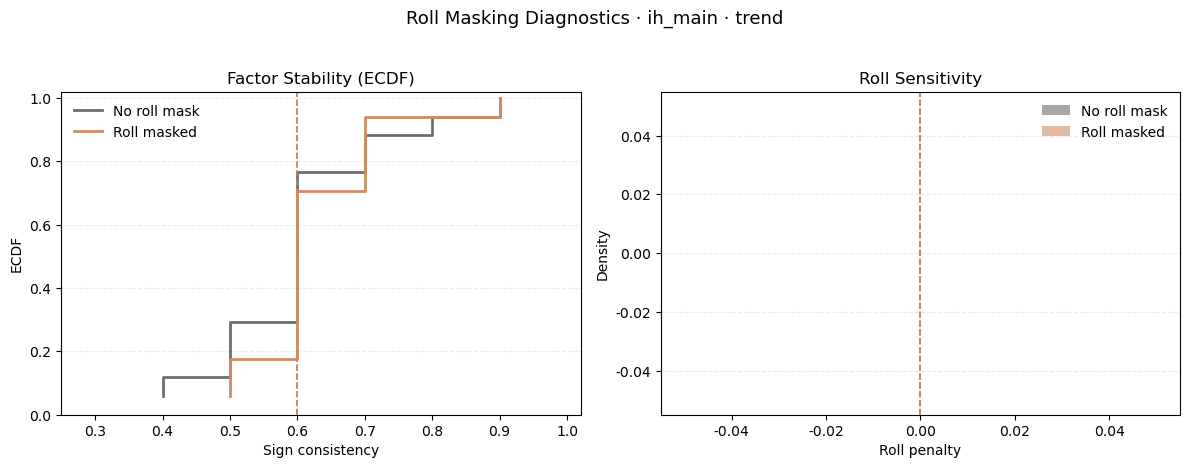

In [61]:
plot_roll_mask_diagnostics(ticker="ih_main", family="trend", cls=treemodel_factors_augment)

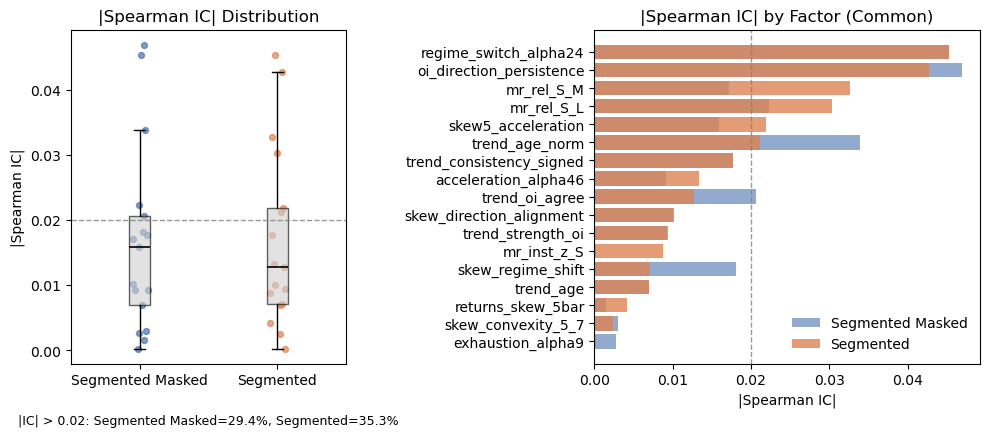

In [62]:
s_raw = (corr_check(ticker = 'ih_main', family="trend",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="trend",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,mask = False)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Segmented Masked", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

#### **Regression**

During factor research, we identified a class of indicators based on linear regression of price against time, such as LINEARREG_SLOPE (pt=α+βt+ϵ over window [t−w,t]), as having notable analytical value. These indicators are more appropriately understood as data-inferred trend descriptors, rather than conventional forecasting signals. Although regressing price directly on time may appear counterintuitive in form, this construction reflects a classical geometric approximation of financial time series: over sufficiently short horizons, price dynamics can be locally decomposed into a trend component and a stochastic disturbance.

Under this framework, the estimated regression slope should not be interpreted as a structural parameter with stable economic meaning, nor should it be directly regarded as a forecast of future returns. Instead, it provides a data-driven characterization of the direction, smoothness, and temporal coherence of price movement within a finite window, thereby offering a descriptive view of the trend geometry and market state of the price process.

Similar to Hilbert-transform-based cycle diagnostics, regression-derived slope statistics often exhibit pronounced time variation and non-stationarity in the presence of noise, structural breaks, and contract roll mechanisms. Importantly, this instability does not imply a loss of information. Rather, both the stability and the breakdown of the inferred trend carry state information: sustained and smooth slope estimates are typically associated with coherent trend regimes, whereas rapid reversals or amplified fluctuations may signal regime transitions, structural disturbances, or liquidity and roll-related effects.

在因子研究过程中，我们注意到一类基于价格关于时间进行线性回归的指标（如 LINEARREG_SLOPE）具有较强的分析价值。这类指标更适合被理解为基于数据推断的趋势描述工具，而非传统意义上的预测型信号。尽管将价格直接回归到时间变量上在形式上略显反直觉，但其背后反映的是一种经典的金融时间序列几何近似假设：在足够短的时间尺度内，价格演化可以被近似分解为趋势成分与随机扰动项的叠加。

在这一框架下，回归得到的斜率系数不应被视为具有稳定经济含义的结构性参数，也不宜被直接解读为对未来收益的预测。更合理的理解是，该斜率刻画了有限窗口内价格运动的方向性、平滑性与时间一致性，从而为价格序列的趋势几何特征与市场状态提供了一种数据驱动的描述。

与 Hilbert 变换类周期诊断指标类似，线性回归斜率等回归型统计量在噪声、结构性断点及合约换月等现实市场条件下，往往呈现出明显的时变性与非稳态特征。然而，这种不稳定性并非信息缺失，而是状态信息本身的体现：当斜率估计在滚动窗口内保持稳定和平滑时，通常对应较为清晰的趋势结构；而当斜率出现快速反转或波动放大时，则可能反映状态切换、结构扰动，或流动性压力与换月邻域效应等机制。

**Inferred Drift**

As discussed earlier, LinReg_Slope factors are included as simple, data-inferred trend descriptors, intended to characterize local drift and trend state rather than to serve as standalone predictive signals.

| Factor | Definition | Measures | Interpretation |
|------|-----------|----------|----------------|
| LinReg_Slope_5 | Linear regression slope of log-price against time over a 5-period window | Short-horizon inferred drift | Positive values indicate short-term upward trend; negative values indicate downward drift |
| LinReg_Slope_10 | Linear regression slope of log-price against time over a 10-period window | Medium-horizon inferred drift | Captures more stable directional bias, less sensitive to short-term noise |
| LinReg_Slope_20 (minutes only) | Linear regression slope of log-price against time over a 20-period window | Long-horizon inferred drift | Reflects broader structural trend rather than short-term momentum |

**Stability**

Similar to the construction of Hilbert-based phase and period stability measures, the stability of linear regression–based trend estimates can be modeled in more informative ways than relying on the slope level alone. In particular, diagnostics such as goodness-of-fit, temporal consistency of the estimated slope, and changes in slope across sub-windows provide richer descriptions of trend stability and deformation.

Among these, slope change measures such as Slope_HalfDiff_10 explicitly compare trend estimates across adjacent sub-periods within the same horizon, allowing trend acceleration or exhaustion to be identified without mixing heterogeneous time scales. By contrast, comparing regression slopes across different window lengths often leads to excessive averaging effects, which can obscure localized structural changes. Therefore, slope-difference constructions within a fixed horizon are preferred when characterizing regression trend stability.

类似于 Hilbert 相位与周期稳定性的构建思路，基于线性回归的趋势稳定性同样可以通过比单一斜率水平更丰富的方式进行刻画。除斜率本身外，诸如回归拟合优度（goodness-of-fit）、斜率估计的时间一致性以及不同子窗口间斜率变化等指标，能够更全面地反映趋势的稳定性与几何形态的演变。

其中，Slope_HalfDiff_10 等斜率变化指标通过在同一时间尺度内比较相邻子区间的趋势估计，有效刻画了趋势的加速、衰减或结构性转折，而不会引入不同时间尺度混合所带来的平均化效应。相比之下，直接比较不同窗口长度下的回归斜率，往往会因跨尺度平均而掩盖局部结构变化。因此，在刻画线性回归趋势稳定性时，更倾向于采用固定窗口内的斜率差分构造，而非跨周期的斜率对比

| Factor | Definition | Measures | Interpretation |
|------|-----------|----------|----------------|
| Slope_HalfDiff_10 | Difference between recent and earlier half-window regression slopes | Trend acceleration or deceleration | Positive values indicate trend strengthening; negative values suggest exhaustion or reversal |
| Rolling_R2_5 | R² of short-horizon regression | Short-term trend coherence | High values imply smooth, well-defined trend; low values indicate choppy behavior |
| Rolling_R2_10 | R² of medium-horizon regression | Medium-term trend coherence | Measures structural consistency of the inferred trend |
| Rolling_R2_20 (minutes only) | R² of long-horizon regression | Long-term trend coherence | High values correspond to stable, persistent trend regimes |
| Slope_Acceleration (minutes only) | First difference of long-horizon slope | Change in long-term trend state | Large absolute values signal rapid structural changes in trend dynamics |
| Residual_Vol_5 | Volatility of regression residuals over 5 periods | Short-horizon path noise | High values indicate unstable or noisy price movement relative to trend |
| Residual_Vol_10 | Volatility of regression residuals over 10 periods | Medium-horizon path noise | Captures sustained deviation from smooth drift |
| Residual_Vol_20 (minutes only) | Volatility of regression residuals over 20 periods | Long-horizon path noise | Often associated with regime instability or structural breaks |
| LinReg_Residual_Z_5 | One-period deviation from short-horizon expected drift, normalized by residual volatility | Instantaneous standardized surprise | Large absolute values capture shocks or liquidity-driven dislocations |
| LinReg_Residual_Z_10 | One-period deviation from medium-horizon expected drift, normalized by residual volatility | Medium-horizon standardized surprise | Highlights price moves inconsistent with prevailing trend geometry |

**Persistent**

Earlier trend-related constructs, such as trend probability, are designed to assess the likelihood or confidence that a trend-like structure is present at a given point in time. These measures focus on whether a trend exists and how strong it appears, often by aggregating multiple contemporaneous signals into a single assessment.

Persistence measures address a different but complementary question: once a trend, slope configuration, or deviation pattern has been identified, does this state tend to continue or revert over time? Rather than re-evaluating the existence of a trend, persistence diagnostics examine the temporal continuity of regression-inferred behavior.

By measuring persistence at the level of returns, inferred slopes, and residual signs, this class of factors provides a regression-based view of state durability. This perspective helps distinguish short-lived fluctuations from behaviors that exhibit regime-level consistency. In this sense, persistence does not redefine trend probability; instead, it serves as a time-consistency check on already-identified trend or deformation states.

先前定义的趋势相关指标主要用于评估某一时点上趋势结构是否存在，以及其置信程度和强弱水平。这类指标关注的是趋势“是否成立”，通常通过对多种同步信号进行聚合，形成对当前趋势状态的整体判断。

持续性指标关注的是一个不同但互补的问题：当某种趋势形态、斜率结构或偏离模式已经被识别之后，该状态在时间上更可能延续，还是更容易发生反转。与趋势概率侧重重新判断趋势是否存在不同，持续性度量强调的是回归推断状态在时间维度上的一致性与延续性。

通过在收益、回归斜率以及残差符号层面刻画持续性特征，这类因子从回归视角补充刻画了趋势或形变状态的耐久性，从而有助于区分短暂扰动与具有状态一致性的行为模式。因此，持续性并非对趋势概率的重复定义，而是对已识别趋势或偏离状态的时间稳定性检验。

| Factor | Definition | Measures | Interpretation |
|------|-----------|----------|----------------|
| Return_ACF1_5 | First-lag autocorrelation of returns over 5 periods | Short-term return persistence | Positive values suggest momentum-like behavior; negative values imply mean reversion |
| Return_ACF1_10 | First-lag autocorrelation of returns over 10 periods | Medium-term return persistence | Reflects regime-level serial dependence |
| Return_ACF1_20 (minutes only) | First-lag autocorrelation of returns over 20 periods | Long-horizon return persistence | Captures slow-moving structural dependence |
| Slope_ACF1_10 | First-lag autocorrelation of regression slope | Persistence of inferred trend state | High values indicate stable trend regimes; low values imply frequent reconfiguration |
| Resid_Sign_ACF1_10 | Autocorrelation of residual sign | Directional persistence of surprises | Sustained one-sided deviations may signal pressure buildup or regime transition |

**No Mask**

Momentum and trend factors implicitly assume short-horizon directional continuity: individual price changes are accumulated into signals such as slopes, breakouts, or return sums. Under this assumption, a single abnormal observation around a roll event can materially distort the signal by introducing artificial persistence or abrupt directional shifts.

In contrast, Hilbert-based, regression-based, and other windowed statistical features estimate local structure through aggregation over multiple observations. Their estimates reflect averaged behavior—such as cycle characteristics, mean slope, or volatility—rather than pointwise price movements. As a result, isolated disturbances around roll dates tend to be attenuated rather than amplified, unless roll-induced effects persist across a substantial portion of the estimation window.

Under segment-safe construction and proper lagging, roll-related price irregularities therefore behave primarily as localized noise for these statistical features, while they constitute a more material source of bias for momentum and trend-based signals.

Accordingly, we do not apply an additional post-roll masking procedure to Hilbert- and regression-based features. Introducing such masking would primarily reduce effective sample size without directly targeting the dominant source of bias for these feature families, particularly in a limited-sample setting.

动量与趋势类因子在构造上隐含了短期方向连续性的假设，其信号由单期或少数几期的价格变化累积而成（如收益叠加、斜率或突破）。在这一前提下，换月附近的单个异常价格点，容易被放大为虚假的趋势延续或方向突变，从而对因子统计表现产生实质性影响。

相比之下，Hilbert、回归以及其他基于窗口的统计类特征，主要通过多个观测值的聚合来刻画时间序列的局部结构特征，例如周期状态、平均斜率或波动水平，其估计结果反映的是平滑后的统计行为，而非单点价格波动。因此，若换月扰动仅出现在个别时点，其影响通常会被窗口内的平滑与平均过程所削弱，除非该扰动在较长时间内持续存在。

在采用合约分段（segment-safe）与滞后处理的前提下，换月相关的价格不规则性对这类统计特征而言更接近于局部噪声，而非可系统性累积的偏差来源；相反，其对动量与趋势因子的干扰更为显著。

基于上述差异，我们未对 Hilbert 与回归类特征额外引入 post-roll mask 处理。 在样本规模有限的情况下，该类掩蔽操作更可能导致有效样本数量下降，而未必能够针对性地消除其主要偏差来源。

**Note**

In the loose configuration, the regression (Reg) class permits more lenient window choices (e.g., a window of 20). While such settings may raise concerns about estimation reliability in shorter segments, they tend to be more aggressive and precise when the contract history is sufficiently long. This configuration also introduces a Slope Acceleration factor; however, given the inherent properties of regression—namely its emphasis on average effects and its vulnerability to outliers—this measure may be less robust in practice compared with alternatives such as half-difference–based constructions.

**CSI 500 Index Futures**

In [63]:
print('Robust Version: Modeling on Log Close')
corr_check(ticker = 'ic_main', family = 'reg', cls = treemodel_factors_augment, selection = True, light = False)

Robust Version: Modeling on Log Close
[rolling_corr_report] No pairs ≥ 0.90 across 10 slices. (fold=10, span=234, cols=16)
target 1 period next return created
[coverage] kept 13/13 features (≥ 55%, n_eff ≥ 200); median coverage=82.71%, median n_eff=1938
Pearson Effective 46.15%
Spearman Effective 76.92%
Kendall Effective 46.15%
[selection] kept 8/13 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=13): 69.23%
roll_penalty     > 0.10 (all features, n=13): 0.00%


pearson  spearman   kendall  effective_pct  \
LinReg_Slope_5      -0.043503 -0.038986 -0.027392       1.000000   
LinReg_Slope_10     -0.017502 -0.029065 -0.019376       1.000000   
Rolling_R2_10        0.016491  0.026196  0.017709       1.000000   
Slope_HalfDiff_10   -0.024060 -0.036595 -0.025095       1.000000   
Residual_Vol_5      -0.002029  0.032034  0.020742       0.666667   
LinReg_Residual_Z_5  0.007003  0.038081  0.025231       0.666667   
Residual_Vol_10      0.053663  0.036309  0.024478       1.000000   
Slope_ACF1_10       -0.000888 -0.032625 -0.021715       0.666667   

                     year_spearman_min  year_spearman_max  sign_consistency  \
LinReg_Slope_5               -0.098117          -0.007811               1.0   
LinReg_Slope_10              -0.110213           0.024564               0.7   
Rolling_R2_10                -0.132214           0.098434               0.6   
Slope_HalfDiff_10            -0.161556           0.035506               0.6   
Residual_Vol_5               -0.035152           0.156509               0.6   
LinReg_Residual_Z_5          -0.095871           0.141756               0.7   
Residual_Vol_10              -0.018357           0.154193               0.9   
Slope_ACF1_10                -0.087496           0.121217               0.6   

                     roll_penalty  winsor_penalty  decile_LS_signed  \
LinReg_Slope_5                0.0        0.003232          0.000103   
LinReg_Slope_10               0.0        0.000000          0.001333   
Rolling_R2_10                 0.0        0.000000         -0.001852   
Slope_HalfDiff_10             0.0        0.000000          0.004425   
Residual_Vol_5                0.0        0.000000          0.000668   
LinReg_Residual_Z_5           0.0        0.000000          0.000585   
Residual_Vol_10               0.0        0.001893          0.002401   
Slope_ACF1_10                 0.0        0.001411         -0.001199   

                     decile_long_return  decile_short_return       QSL  
LinReg_Slope_5                 0.001495             0.001598  0.585177  
LinReg_Slope_10               -0.000766             0.000567  0.473535  
Rolling_R2_10                 -0.000673             0.001179  0.442593  
Slope_HalfDiff_10             -0.001893             0.002532  0.467701  
Residual_Vol_5                 0.001401             0.000733  0.452671  
LinReg_Residual_Z_5            0.001504             0.000919  0.452339  
Residual_Vol_10                0.002192            -0.000208  0.493511  
Slope_ACF1_10                 -0.000937            -0.002136  0.445063

In [64]:
# NO selection, a demonstrate of all factors only 
corr_check(ticker = 'ic_main', family = 'reg', cls = treemodel_factors_daily, selection = False, light = False)

[rolling_corr_report] Pairs exist but none met presence ≥ 70%. (corr_thresh=0.9, n_slices=10)
target 1 period next return created
[coverage] kept 9/9 features (≥ 55%, n_eff ≥ 200); median coverage=99.06%, median n_eff=2320
Pearson Effective 33.33%
Spearman Effective 77.78%
Kendall Effective 44.44%
sign_consistency > 0.55 (all features, n=9): 77.78%
roll_penalty     > 0.10 (all features, n=9): 44.44%


pearson  spearman   kendall  effective_pct  \
Rolling_R2_20           0.007255  0.005898  0.003714       0.000000   
Kurtosis_20             0.039669  0.033246  0.022498       1.000000   
Realized_Quarticity_20  0.012788  0.051302  0.035143       0.666667   
Return_ACF1_20          0.019578  0.024236  0.015917       1.000000   
ACF1_Slope              0.007850 -0.003690 -0.002559       0.000000   
Slope_Acceleration      0.014426 -0.051365 -0.035730       0.666667   
Residual_Vol_20        -0.014031  0.033525  0.022658       0.666667   
Residual_ZScore         0.020788 -0.020742 -0.013722       0.666667   
Slope_Vol_Interaction  -0.040454 -0.021432 -0.014425       0.666667   

                        year_spearman_min  year_spearman_max  \
Rolling_R2_20                   -0.111876           0.063721   
Kurtosis_20                     -0.038135           0.152394   
Realized_Quarticity_20          -0.062836           0.151266   
Return_ACF1_20                  -0.036211           0.085796   
ACF1_Slope                      -0.104179           0.090566   
Slope_Acceleration              -0.101853           0.007320   
Residual_Vol_20                 -0.091085           0.138357   
Residual_ZScore                 -0.110764           0.096877   
Slope_Vol_Interaction           -0.141787           0.040140   

                        sign_consistency  roll_penalty  winsor_penalty  \
Rolling_R2_20                        0.6      0.000000        0.000452   
Kurtosis_20                          0.5      0.000000        0.000000   
Realized_Quarticity_20               0.8      0.000000        0.000924   
Return_ACF1_20                       0.6      0.000000        0.000000   
ACF1_Slope                           0.5      0.174311        0.002147   
Slope_Acceleration                   0.8      1.000000        0.000362   
Residual_Vol_20                      0.8      0.000000        0.000360   
Residual_ZScore                      0.7      0.735590        0.000000   
Slope_Vol_Interaction                0.8      0.924468        0.001394   

                        decile_LS_signed  decile_long_return  \
Rolling_R2_20                   0.000314            0.001001   
Kurtosis_20                     0.002084            0.001992   
Realized_Quarticity_20          0.000289           -0.001138   
Return_ACF1_20                  0.001548           -0.000068   
ACF1_Slope                     -0.000454           -0.001517   
Slope_Acceleration             -0.000964            0.000742   
Residual_Vol_20                -0.000357           -0.001478   
Residual_ZScore                -0.001093            0.000152   
Slope_Vol_Interaction           0.003895           -0.002958   

                        decile_short_return       QSL  
Rolling_R2_20                      0.000687  0.204431  
Kurtosis_20                       -0.000092  0.458335  
Realized_Quarticity_20            -0.001427  0.451063  
Return_ACF1_20                    -0.001617  0.477883  
ACF1_Slope                        -0.001971  0.145108  
Slope_Acceleration                -0.000222  0.395886  
Residual_Vol_20                   -0.001121  0.448536  
Residual_ZScore                   -0.000941  0.372069  
Slope_Vol_Interaction              0.000937  0.372994

As discussed above, due to practical resource constraints (with only a single researcher) and differences in construction logic—where the TA-Lib implementation treats the full series as a continuous whole and therefore rarely relies on short window parameters such as 5, while the segment-based engineered approach inevitably employs local windows such as 5 or 10—it is difficult to conduct a strictly fair and fully aligned evaluation of regression-based factors. Nevertheless, when assessed in terms of the share of factors with absolute Spearman IC above 0.02 (76 vs. 77) and factor purity (i.e., limited sensitivity to roll-driven effects), the proposed factors still demonstrate a solid and acceptable level of performance.

如前所示，受人力资源限制（仅有一名研究员）以及构造逻辑差异的影响（TA-Lib 实现将全序列视为连续整体，因而较少使用诸如 5 这一短窗口参数；而基于合约分割的工程化构造则不可避免地需要使用 5、10 等局部窗口设定），我们难以对回归类因子进行严格而完全公正的一致性检验。尽管如此，仅从 Spearman IC 绝对值大于 0.02 的因子比例（76 vs. 77）以及 因子纯净度（即不显著由换月效应驱动）来看，我们所定义的回归类因子整体仍保持在较为稳健且可接受的水平。

target 1 period next return created


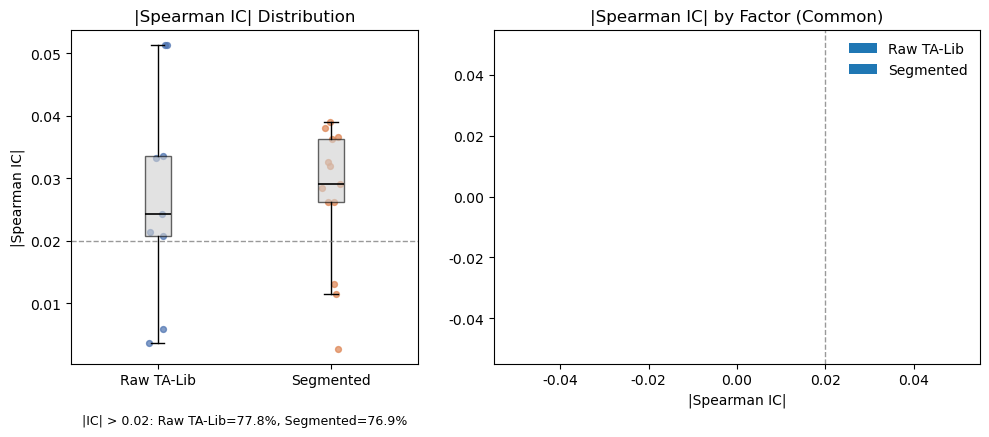

In [65]:
s_raw = (corr_check(ticker = 'ic_main', family="reg",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="reg",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


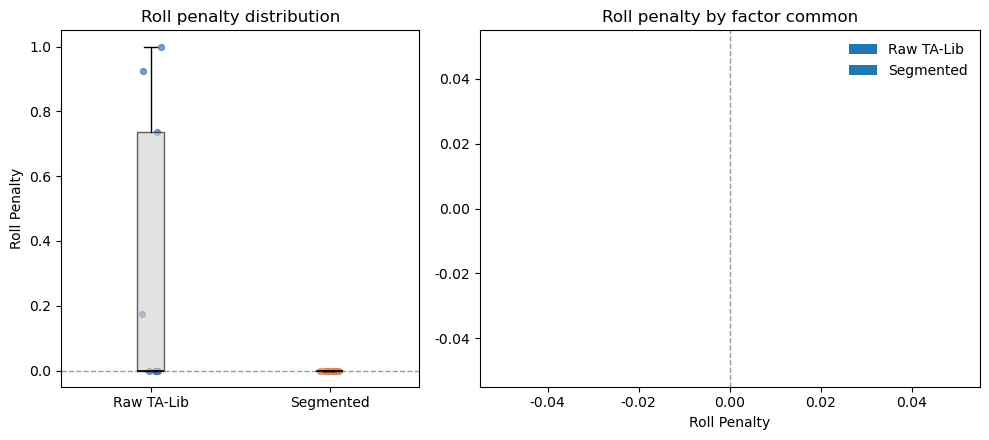

In [66]:
s_raw = (corr_check(ticker = 'ic_main', family="reg",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="reg",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

**Higher Frequency**

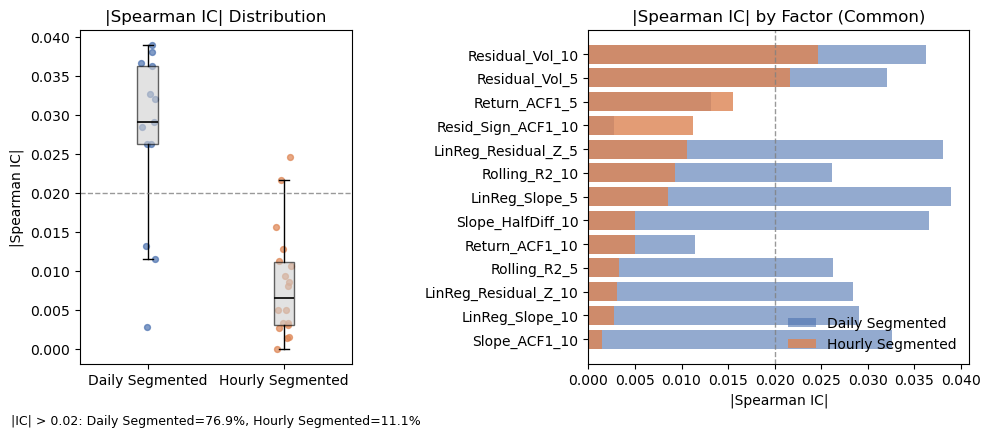

In [67]:
s_day = (corr_check(family="reg",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_hour = (corr_check(ticker = 'ic', frequency = 'minute', multiplier = 60, family="reg",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_day,s_hour, label1="Daily Segmented", label2="Hourly Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

**CSI 300 Index Futures**

For the CSI 300, we observe results broadly consistent with those of the CSI 500; however, a notable difference is that regression-based factors tend to exhibit weaker overall performance. From the perspective of return autocorrelation, this outcome is broadly expected: relative to the mild trend-like behavior observed in the CSI 500 and the more pronounced mean-reverting characteristics of the SSE 50, the CSI 300 return process is closer to a weakly dependent or near–random-walk structure, with limited directional accumulation. Under such conditions, regression-based factors that rely on linear structure or local trend fitting are naturally subject to reduced statistical effectiveness.

在沪深 300 上，我们同样观察到了与中证 500 类似的整体结论，但一个值得注意的现象是，其 回归类因子整体表现相对偏弱。从收益自相关（return ACF）的角度来看，这一结果是可以理解的：相较于中证 500 所表现出的轻微趋势性，以及上证 50 更明显的均值回复特征，沪深 300 的收益过程更接近于弱依赖或近似随机游走结构，方向性积累特征相对有限。在此市场环境下，基于线性结构或局部趋势拟合的回归型因子，其统计有效性自然受到一定约束。

target 1 period next return created


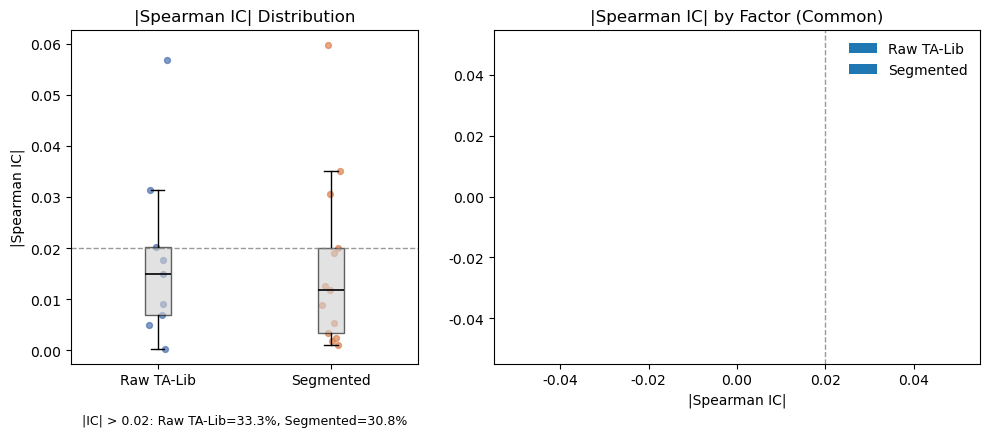

In [68]:
s_raw = (corr_check(ticker = 'if_main', family="reg",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'if_main', family="reg",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


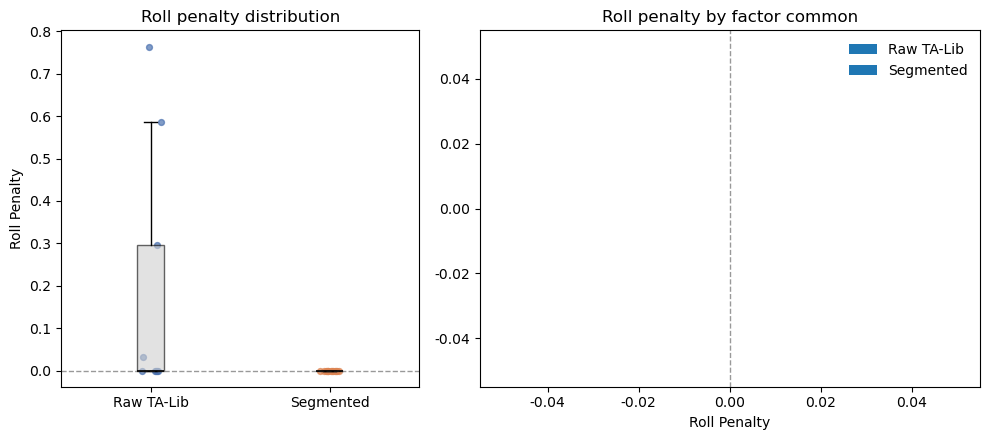

In [69]:
s_raw = (corr_check(ticker = 'if_main', family="reg",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'if_main', family="reg",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

**SSE 50 Index Futures**

For the SSE 50 (IH), the segmented factor library exhibits relatively stronger performance overall, as reflected by higher absolute Spearman correlations and reduced sensitivity to roll-related effects. This improvement may be partly attributable to the inclusion of autocorrelation-related structures (e.g., ACF), which help capture the more pronounced mean-reverting characteristics of the IH market. That said, due to differences in construction logic and factor coverage, the comparison is not strictly fair and should be interpreted as directional evidence rather than a definitive assessment.

在上证 50（IH）上，基于合约分割（segmented）的因子库整体表现相对更优，主要体现在 Spearman 绝对值更高 且 因子有效性不显著受换月结构驱动。这一结果可能与分段构造中对收益自相关结构（ACF）的覆盖有关，使其在一定程度上能够捕捉 IH 市场中更为突出的均值回复特征。需要同时指出的是，由于构造逻辑与因子规模存在差异，该比较并非严格意义上的公平对照，其结论应更多被理解为方向性参考而非确定性判断。

target 1 period next return created


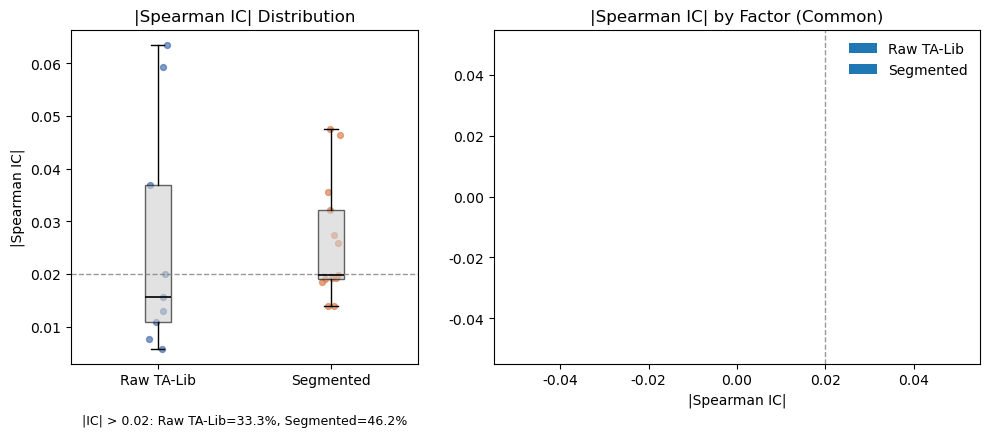

In [70]:
s_raw = (corr_check(ticker = 'ih_main', family="reg",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="reg",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


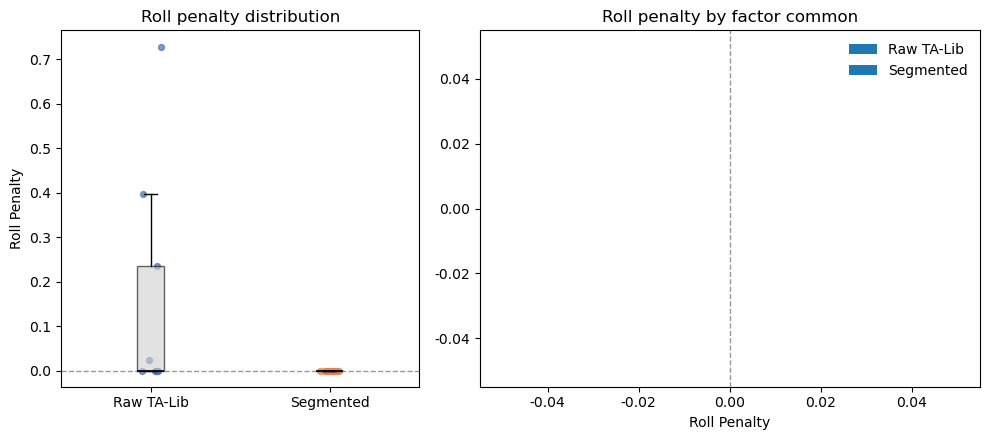

In [71]:
s_raw = (corr_check(ticker = 'ih_main', family="reg",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="reg",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

#### **Time Effects**

Time effects in financial markets are independent of price levels and return paths, yet they can systematically influence market behavior through mechanisms such as opening and closing dynamics, intra-week seasonality, and month-end or settlement effects. These effects rarely constitute stable standalone alpha signals, but they materially affect volatility, liquidity conditions, and the operating regime under which other factors function. Accordingly, time features are best treated as contextual and state-conditioning variables, rather than primary predictors.

金融市场中的时间效应独立于价格水平与收益路径本身，却会通过开盘与收盘行为、周内节律以及月末或结算相关效应等机制，系统性地影响市场行为。这类效应通常并不构成稳定的独立收益预测信号，但会显著影响波动水平、流动性状态以及其他因子的有效性。因此，时间因子更适合作为市场环境与状态刻画变量，而非主要的 alpha 来源。

**Circular Encoding for Periodic Variables**


For naturally periodic calendar variables such as day-of-week and month-of-year, we adopt circular (sin/cos) encoding to avoid spurious distance artifacts induced by linear representations. For example, in a linear scale, Friday and Monday appear far apart despite being temporally adjacent in trading rhythm. Circular embeddings preserve this topological continuity.

The encoding takes the form: Day_Sin = sin(2π × dayofweek / denom), Day_Cos = cos(2π × dayofweek / denom)

where denom = 5 is used for weekday-only markets (e.g., A-share index futures), and denom = 7 is applied in markets with weekend trading, determined automatically from the data. The same construction is applied to monthly cycles (Month_Sin, Month_Cos).

对于星期、月份等具有天然周期性的时间变量，我们采用 sin/cos 圆形编码，以避免线性编码所引入的伪距离问题。例如，在线性刻度下，周五与周一被错误地视为相距较远，而在真实交易节律中它们是时间上相邻的。圆形嵌入能够正确保持周期变量的拓扑连续性。

具体形式为： Day_Sin = sin(2π × dayofweek / denom) Day_Cos = cos(2π × dayofweek / denom)

其中，denom = 5 用于仅在工作日交易的市场（如 A 股指数期货），denom = 7 用于包含周末交易的场景（由数据自动判定）。月份周期采用相同构造方式。

In intraday time modeling, we primarily rely on discrete, structured features to characterize trading sessions. Trading days in Chinese equity index and commodity futures markets do not follow a continuous clock; instead, they consist of clearly defined segments such as market open, midday break, and close. For most data frequencies, we deliberately avoid continuous phase encoding to prevent introducing artificial smoothness across non-trading intervals.

For higher-frequency data (minute, 5-minute, 10-minute, and 15-minute bars), we additionally provide relative intraday position–based phase encodings (Intraday_Sin/Cos), which help the model capture intraday cyclical patterns. These encodings are applied only within continuous trading sessions (e.g., the daytime session from 9:00 to 15:00) and never span non-trading gaps.

Accordingly, we adopt discrete trading-structure features to represent intraday states, including:

Market open and close indicators

Morning / afternoon session segmentation

Trading_Hour_Index: an ordinal index indicating the sequential position within the trading day, without implying a continuous phase assumption

This design effectively captures structural asymmetries in trading behavior while avoiding overly strong geometric constraints.

在日内时间建模中，我们主要使用离散的结构化特征来刻画交易时段。中国指数与商品期货市场的交易日并非连续时钟，而是由明确的开盘、午休、收盘等离散结构组成。对于大多数频率的数据，我们避免使用连续的相位编码，以防止在非交易时段引入人为的平滑性。 对于高频数据（分钟、5分钟、10分钟、15分钟），我们额外提供基于日内相对位置的相位编码（Intraday_Sin/Cos），这有助于模型捕捉日内周期模式。该编码仅针对连续交易时段（如日盘的9:00-15:00），不会跨越非交易间隔。。

因此，我们采用离散的交易结构特征来刻画日内状态，包括： 开盘与收盘标记, 上午 / 下午交易段划分 Trading_Hour_Index：交易日内的顺序位置索引（不隐含连续相位假设）该设计能够有效反映交易结构不对称性，同时避免引入过强的几何约束。

**CSI 500 Index Futures**

For CSI 500 index futures, time-based features exhibit a clear frequency-dependent IC profile. At the daily level, Month_End shows a more stable and mildly positive IC than Day_Sin, consistent with persistent month-end capital flow and institutional rebalancing effects. At the intraday level, Is_Opening, Is_Closing, and Trading_Hour_Index display low-magnitude Spearman ICs in the 0.02–0.03 range, yet with strong directional consistency, indicating a stable structural bias rather than random noise. Overall, the IC behavior of time features in CSI 500 is modest in magnitude but robust across samples, reflecting trading-stage asymmetries rather than smooth cyclical dynamics.

在 CSI 500 指数期货 上，时间类因子的 IC 表现呈现出清晰的频率分层特征：日频层面，Month_End 相较 Day_Sin 表现出更稳定且略偏正的 IC，反映了月末资金行为与制度性调仓带来的弱但持续的时间效应；日内层面，Is_Opening、Is_Closing 及 Trading_Hour_Index 的 Spearman IC 整体处于 0.02–0.03 的低幅区间，但方向一致性较高，说明其对收益方向的影响并非噪声，而是以结构性偏置形式稳定存在。整体来看，CSI 500 的时间因子 IC 幅度有限但跨样本稳定，体现为交易阶段差异而非连续周期振荡。

CSI 300 Index Futures & SSE 50 Index Futures

For CSI 300 (IF) and SSE 50 (IH) index futures, time-related ICs are almost entirely concentrated in the Month_End feature. This factor exhibits a stable positive Spearman IC (around 0.05) across both contracts, with strong year-to-year consistency and negligible roll sensitivity, indicating a classic month-end effect driven by institutional flows and index rebalancing. Other daily or intraday time features do not show statistically stable ICs, suggesting that for IF and IH, time effects are dominated by low-frequency, institutionally driven month-end behavior, rather than other structural patterns.

在 CSI 300（IF） 与 SSE 50（IH） 指数期货上，时间类因子的 IC 表现高度集中于 Month_End。该因子在两者上均呈现 稳定的正向 Spearman IC（约 0.05），并具有较高的年度一致性与接近于零的换月惩罚，表明其反映的是典型的月末资金与指数再平衡效应。除 Month_End 之外，其余日频或日内时间变量未表现出具有统计稳定性的 IC，说明在 IF 与 IH 上，时间效应主要体现在低频、制度驱动的月末行为，而非更细致的交易结构差异。

In [72]:
corr_check(ticker = 'ic_main', family = 'time', cls = treemodel_factors_augment, selection = True, light = False, verbose = True)

[rolling_corr_report] No pairs ≥ 0.90 across 10 slices. (fold=10, span=234, cols=8)
target 1 period next return created
[coverage] kept 5/5 features (≥ 55%, n_eff ≥ 200); median coverage=100.00%, median n_eff=2343
Pearson Effective 20.00%
Spearman Effective 60.00%
Kendall Effective 60.00%
[selection] kept 2/5 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=5): 80.00%
roll_penalty     > 0.10 (all features, n=5): 40.00%


pearson  spearman   kendall  effective_pct  year_spearman_min  \
Day_Sin   -0.017805 -0.050735 -0.037761       1.000000          -0.140364   
Month_End -0.004136  0.037001  0.030218       0.666667          -0.139568   

           year_spearman_max  sign_consistency  roll_penalty  winsor_penalty  \
Day_Sin             0.045305               0.7      0.000000             0.0   
Month_End           0.174912               0.8      0.011234             0.0   

           decile_LS_signed  decile_long_return  decile_short_return       QSL  
Day_Sin            0.001241           -0.001564            -0.000323  0.454965  
Month_End               NaN                 NaN                  NaN  0.448877

#### **Volatility**

In quantitative investment frameworks, traditional factors such as trend and momentum primarily capture directional information embedded in price series, reflecting the market’s explicit expectations of future returns. In real market environments, however, the asset pricing process often manifests earlier through changes in uncertainty and dynamic adjustments of risk premia. Especially during information-intensive periods or regime transitions, shifts in risk appetite, hedging demand, and liquidity conditions tend to be traded and reflected by the market prior to the emergence of clear price direction.

Volatility, as a direct proxy for risk and uncertainty, not only measures the magnitude of price fluctuations but also encapsulates critical information regarding risk structure, tail behavior, and market stability.

Accordingly, by incorporating volatility level, structural characteristics, higher-order moments, and regime transition features, volatility-based factors serve as a “risk state characterization module” within the overall framework. They provide conditional context and environmental interpretation for directional signals such as trend, momentum, and cycle factors, thereby enhancing the robustness and interpretability of the model across different market states.

在投资框架中，传统因子（如趋势、动量）主要刻画价格序列中的方向性信息，反映市场对未来收益的显性预期。然而，在真实市场环境中，资产定价过程往往更早地体现为不确定性变化与风险溢价的动态调整。尤其在信息密集或市场状态切换阶段，风险偏好、对冲需求及流动性条件的变化，通常先于价格方向本身被市场交易和反映。

波动率作为风险与不确定性的直接代理变量，不仅描述价格变动的幅度，还系统性地承载了风险结构、尾部行为以及市场稳定性等关键信息。

因此，通过引入波动率水平、波动结构、高阶矩及状态切换等多维特征，volatility 类因子在整体量化框架中承担“风险状态刻画模块”的角色，为趋势、动量及周期等方向性信号提供条件化约束与环境解释，从而提升模型在不同市场状态下的稳健性与可解释性。

#### **Feature Design**

**Level (Magnitude)**

Volatility is commonly defined as the overall magnitude of price fluctuations and serves as a fundamental scale in risk state modeling. Given data segmentation and effective sample constraints, we prioritize short-horizon realized volatility and range-based measures to characterize local risk levels. By combining adjacent short windows through weighted aggregation, this design preserves responsiveness to risk changes while effectively reducing estimation noise and instability.

波动率通常被定义为价格变动的整体幅度，是风险状态建模中的基础量纲。受数据分段结构与有效样本约束的影响，在该类因子的构建中我们优先采用短周期的实现波动率与区间波动指标来刻画局部风险水平，并通过相邻窗口的加权组合，在保持对风险变化快速响应的同时，有效降低估计噪声与不稳定性。

| Factor                | Definition                                                                            | Measures                                             | Interpretation                                                                                                                                                                                  |
| --------------------- | ------------------------------------------------------------------------------------- | ---------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Vol_Composite_5_7 | Composite short-horizon realized volatility constructed from adjacent rolling windows | Local volatility level with reduced estimation noise | Represents the current intensity of market risk at a local time scale; the use of adjacent windows stabilizes short-term volatility estimates while preserving responsiveness to regime changes |
| ATR_r_5           | Average True Range computed over 5 periods using log-price ranges                     | Short-horizon range-based volatility                 | Captures intraperiod price dispersion and microstructure-driven risk; robust to directional bias and complementary to return-based volatility measures                                          |


**Volatility Shape**

Volatility shape features are designed to characterize the internal geometry and regime structure of risk rather than its absolute magnitude. By examining short–long volatility differentials, dispersion of price ranges, the interaction between returns and intrabar volatility, and price location within volatility envelopes, these factors help distinguish accelerating, compressing, directional, and range-bound risk regimes. As such, they provide essential contextual information for interpreting volatility levels and for conditioning downstream trend-following or mean-reversion signals.

波动率形态因子旨在刻画风险的结构性特征与内在几何形态，而非其绝对大小。通过刻画短长周期波动率的相对变化、价格区间波动的离散程度、收益与区间波动之间的互动关系，以及价格在波动区间中的相对位置，这类因子能够有效区分波动率加速、收敛、方向性主导及区间震荡等不同风险状态。因此，波动率结构类因子主要用于为波动率水平提供状态化背景信息，并对后续趋势或均值回归类信号进行条件化约束。

| Factor                     | Definition                                                                     | Measures                                             | Interpretation                                                                                                                |
| -------------------------- | ------------------------------------------------------------------------------ | ---------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------- |
| Vol_Term_Structure_5_7 | Difference between short- and slightly longer-horizon realized volatility      | Local volatility term structure                      | Positive values indicate front-loaded or accelerating risk; negative values suggest volatility relaxation or mean reversion   |
| Range_CV_5             | Coefficient of variation of intrabar price ranges over a short horizon         | Dispersion of price ranges                           | High values indicate bursty or uneven intrabar volatility; low values reflect stable and homogeneous range behavior           |
| BB_%B_Pos_r_7          | Relative position of price within its recent volatility envelope               | Price location within conditional distribution       | Values near extremes indicate directional pressure; central values reflect balanced or mean-reverting conditions              |
| Range_to_RetVol_5 | Ratio of intrabar price range to close-to-close return volatility              | Efficiency of volatility transmission          | High values indicate oscillatory or inefficient price movement, where volatility is primarily absorbed intrabar rather than expressed through directional returns; low values suggest more efficient, directionally persistent regimes |
| Donchian_Z_7      | Standardized deviation of recent Donchian channel width from its local average | Expansion or compression of price distribution | High values reflect recent expansion of the price distribution relative to its baseline, indicating elevated dispersion; low values signal compression or coiling conditions associated with reduced volatility                        |
| Vol_of_Vol_7         | Short-horizon variability of realized volatility              | Stability of the volatility process       | High values indicate unstable or rapidly changing risk conditions; low values reflect smooth and persistent volatility regimes                                |
| Vol_Mean_Reversion_5v7 | Deviation of current volatility from its recent local average | Relative position in the volatility cycle | Positive values suggest elevated volatility relative to recent norms; negative values indicate suppressed volatility, often associated with buildup potential |
| Vol_Spike_Regime      | Indicator for short-term volatility exceeding its recent local average by a significant margin | Sudden volatility shocks        | Flags abrupt volatility spikes often associated with events, news, or temporary market dislocations      |
| High_Volatility_Regime | Indicator for volatility being elevated relative to its longer-term distribution               | Sustained high-risk environment | Identifies persistent high-volatility regimes reflecting prolonged uncertainty or stress                 |
| Vol_Cross_5_over_7     | Indicator for short-horizon volatility exceeding a nearby longer horizon                       | Volatility acceleration         | Signals front-loaded or accelerating volatility, often preceding broader regime shifts                   |
| ATR_Burst_Flag         | Indicator for short-term range expansion relative to its local baseline                        | Intrabar range shocks           | Captures sudden expansions in price range, often linked to liquidity stress or microstructure disruption |
| Ret_Var_Corr_7    | Rolling correlation between returns and their squared values over a short horizon          | Return–volatility dependence     | Measures the degree to which returns co-move with volatility, often associated with leverage-like or risk-off behavior     |
| Vol_Clustering_7   | First-lag autocorrelation of absolute returns over a short horizon                         | Persistence of volatility shocks | High values indicate volatility clustering and sustained risk conditions                                                   |


**Volatility Asymmetry**

Volatility magnitude and structure are typically constructed under symmetry assumptions and therefore provide limited insight into directional imbalance and temporal dependence in risk. To address this gap, we further introduce asymmetry features to characterize differential volatility responses to positive and negative returns. These features offer complementary information for understanding how risk is transmitted and accumulated beyond symmetric volatility descriptions.

波动率水平、结构类因子通常基于对称性假设，难以直接反映波动率在不同方向上的不均衡响应以及风险在时间上的依赖特征。因此，我们进一步引入非对称性因子，用于刻画波动率对正负收益的差异化反应，从而为理解风险的传导与积累机制提供有益补充。

| Factor                 | Definition                                                                                 | Measures                         | Interpretation                                                                                                             |
| ---------------------- | ------------------------------------------------------------------------------------------ | -------------------------------- | -------------------------------------------------------------------------------------------------------------------------- |
| Vol_Asymmetry_5   | Normalized difference between upside and downside realized volatility over a short horizon | Directional volatility imbalance | Positive values indicate stronger volatility on positive returns; negative values indicate downside-dominated risk         |
| Downside_Semivar_7| Realized variance computed using only negative returns over a short horizon                | Downside risk concentration      | Captures the extent to which total risk is driven by negative return realizations, reflecting asymmetric downside exposure |


**Higher Moment**

Finally, we introduce a small set of higher-moment features to explore the structural characteristics of tail risk. These factors are constructed from fourth-order return moments and are designed to capture the relative contribution of extreme price movements to overall risk. As higher-moment estimates are inherently sensitive to sample size and outliers, their statistical stability is generally weaker than that of variance-based measures. Accordingly, these features are treated as exploratory indicators of tail intensity and jump-driven risk, rather than primary risk descriptors within the overall framework.

最终，我们进一步引入少量高阶矩相关特征，用于探索尾部风险的结构性特征。这类因子基于收益的四阶矩构造，旨在刻画极端价格波动在整体风险中所占的相对比重。由于高阶矩估计对样本量及异常观测较为敏感，其统计稳定性通常弱于基于方差的风险指标，因此在整体框架中被视为对尾部强度与跳跃型风险的探索性刻画，而非核心风险描述变量。

| Factor | Definition | Measures | Interpretation |
|------|-----------|----------|----------------|
| Realized_Quarticity_5 | Normalized fourth moment of returns over a short horizon | Tail intensity of return distribution | High values indicate that extreme price movements contribute disproportionately to overall variance, suggesting jump-driven or heavy-tailed risk |
| Quarticity_Vol_Divergence_5 | Ratio of realized quarticity to short-term realized volatility | Tail risk relative to volatility level | Distinguishes smooth high-volatility regimes from environments dominated by spiky, extreme movements |

**Mask Roll**

Roll masking is not applied to volatility-based factors, as they measure fluctuation magnitude rather than directional continuation. Roll-related effects tend to appear as localized spikes rather than systematic bias, making additional masking unnecessary and sample-reducing.

对于波动率类因子，我们未采用 roll mask。由于其刻画的是价格波动幅度而非方向性延续，换月影响更倾向于表现为局部异常而非系统性偏差，额外 mask 主要带来样本损失。

**Note**
In the loose configuration, the volatility class includes a broader set of measures—such as Vol_Composite, ATR, Range_CV, Range_to_RetVol, Donchian-based metrics, Vol_Spike_Regime, Vol_Clustering, and Vol_Asymmetry—computed using more lenient window choices. In addition, several volatility momentum and reversion signals are incorporated, including ATR_Mom_5, Mass_Index_r_7, and multi-cyclical Quarticity. While this setup captures a wide range of volatility dynamics, it does not yet include certain experimental features designed to explicitly model higher-order asymmetry or Quarticity–Volatility interaction effects.

**CSI 500 Index Futures**

In [73]:
print('Robust Version: Modeling on Log Close')
corr_check(ticker = 'ic_main', family = 'vol', cls = treemodel_factors_augment, selection = True, light = False)

Robust Version: Modeling on Log Close
[rolling_corr_report] Pairs exist but none met presence ≥ 70%. (corr_thresh=0.9, n_slices=10)
target 1 period next return created
[coverage] kept 19/19 features (≥ 55%, n_eff ≥ 200); median coverage=89.63%, median n_eff=2100
Pearson Effective 47.37%
Spearman Effective 78.95%
Kendall Effective 42.11%
[selection] kept 13/19 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=19): 84.21%
roll_penalty     > 0.10 (all features, n=19): 0.00%


pearson  spearman   kendall  effective_pct  \
Vol_Composite_5_7       0.007771  0.035562  0.023673       0.666667   
ATR_r_5                 0.009791  0.064522  0.044148       0.666667   
Vol_Term_Structure_5_7 -0.042611  0.026347  0.018682       1.000000   
Range_CV_5              0.027996  0.030566  0.020561       1.000000   
Range_to_RetVol_5      -0.049446  0.023682  0.015753       1.000000   
Donchian_Z_7            0.022220  0.054154  0.036085       1.000000   
BB_%B_Pos_r_7          -0.012973 -0.026773 -0.017795       0.666667   
Vol_Spike_Regime        0.031128  0.034929  0.028526       1.000000   
High_Volatility_Regime  0.035636  0.060595  0.049487       1.000000   
Vol_Cross_5_over_7      0.008422  0.023439  0.019142       0.666667   
ATR_Burst_Flag          0.017348  0.024076  0.019662       1.000000   
Vol_Asymmetry_5        -0.043386 -0.052219 -0.036506       1.000000   
Downside_Semivar_7      0.048229  0.053030  0.036383       1.000000   

                        year_spearman_min  year_spearman_max  \
Vol_Composite_5_7               -0.027728           0.093435   
ATR_r_5                         -0.017352           0.205567   
Vol_Term_Structure_5_7          -0.100065           0.134951   
Range_CV_5                      -0.088832           0.127380   
Range_to_RetVol_5               -0.069664           0.088919   
Donchian_Z_7                    -0.068926           0.144402   
BB_%B_Pos_r_7                   -0.068685           0.020603   
Vol_Spike_Regime                -0.037033           0.102184   
High_Volatility_Regime          -0.035437           0.179313   
Vol_Cross_5_over_7              -0.076767           0.146584   
ATR_Burst_Flag                  -0.046015           0.101637   
Vol_Asymmetry_5                 -0.112910           0.036223   
Downside_Semivar_7               0.024168           0.108641   

                        sign_consistency  roll_penalty  winsor_penalty  \
Vol_Composite_5_7                    0.8           0.0        0.000000   
ATR_r_5                              0.9           0.0        0.000000   
Vol_Term_Structure_5_7               0.6           0.0        0.000308   
Range_CV_5                           0.8           0.0        0.000000   
Range_to_RetVol_5                    0.6           0.0        0.000000   
Donchian_Z_7                         0.7           0.0        0.000000   
BB_%B_Pos_r_7                        0.8           0.0        0.000000   
Vol_Spike_Regime                     0.8           0.0        0.000000   
High_Volatility_Regime               0.9           0.0        0.000000   
Vol_Cross_5_over_7                   0.7           0.0        0.000000   
ATR_Burst_Flag                       0.7           0.0        1.000000   
Vol_Asymmetry_5                      0.9           0.0        0.000000   
Downside_Semivar_7                   1.0           0.0        0.003322   

                        decile_LS_signed  decile_long_return  \
Vol_Composite_5_7               0.001105            0.000792   
ATR_r_5                         0.000763           -0.000031   
Vol_Term_Structure_5_7         -0.000682            0.001653   
Range_CV_5                      0.001000            0.000349   
Range_to_RetVol_5              -0.000588            0.000810   
Donchian_Z_7                    0.003713            0.002437   
BB_%B_Pos_r_7                   0.001100            0.000189   
Vol_Spike_Regime                     NaN                 NaN   
High_Volatility_Regime               NaN                 NaN   
Vol_Cross_5_over_7                   NaN                 NaN   
ATR_Burst_Flag                       NaN                 NaN   
Vol_Asymmetry_5                 0.001355           -0.000077   
Downside_Semivar_7              0.001060            0.000777   

                        decile_short_return       QSL  
Vol_Composite_5_7                 -0.000313  0.513659  
ATR_r_5                           -0.000794  0.453052  
Vol_Term_Structure_5_7         

In [74]:
# NO selection, a demonstrate of all factors only 
corr_check(ticker = 'ic_main', family = 'vol', cls = treemodel_factors_daily, selection = False, light = False)

[rolling_corr_report] Pairs exist but none met presence ≥ 70%. (corr_thresh=0.9, n_slices=10)
target 1 period next return created
[coverage] kept 9/9 features (≥ 55%, n_eff ≥ 200); median coverage=99.19%, median n_eff=2323
Pearson Effective 55.56%
Spearman Effective 88.89%
Kendall Effective 88.89%
sign_consistency > 0.55 (all features, n=9): 88.89%
roll_penalty     > 0.10 (all features, n=9): 66.67%


pearson  spearman   kendall  effective_pct  \
RSTD                    0.015507  0.050043  0.034289       1.000000   
NATR                    0.015828  0.055190  0.038051       1.000000   
ATR_Momentum            0.050547  0.062346  0.042200       1.000000   
BB_Width                0.021403  0.045556  0.030770       1.000000   
BB_%B_Pos               0.007306 -0.017425 -0.011267       0.333333   
Mass_Index              0.022057  0.036808  0.025199       1.000000   
Donchian_Width_ATR      0.035829  0.040421  0.027113       1.000000   
Donchian_Channel_%Pos  -0.007486 -0.039626 -0.026321       0.666667   
High_Volatility_Regime  0.035544  0.033883  0.027671       1.000000   

                        year_spearman_min  year_spearman_max  \
RSTD                            -0.024140           0.144072   
NATR                            -0.012644           0.188580   
ATR_Momentum                    -0.068317           0.162292   
BB_Width                        -0.103772           0.180145   
BB_%B_Pos                       -0.137370           0.055309   
Mass_Index                      -0.083546           0.150314   
Donchian_Width_ATR              -0.126555           0.137610   
Donchian_Channel_%Pos           -0.147713           0.010251   
High_Volatility_Regime          -0.070037           0.137379   

                        sign_consistency  roll_penalty  winsor_penalty  \
RSTD                                 0.8      0.218008        0.000207   
NATR                                 0.8      0.049636        0.002296   
ATR_Momentum                         0.8      0.361862        0.002415   
BB_Width                             0.8      0.000000        0.001233   
BB_%B_Pos                            0.8      0.777947        0.000176   
Mass_Index                           0.5      0.480487        0.000000   
Donchian_Width_ATR                   0.7      0.000000        0.000000   
Donchian_Channel_%Pos                0.9      0.948762        0.000000   
High_Volatility_Regime               0.7      0.518533        0.000000   

                        decile_LS_signed  decile_long_return  \
RSTD                            0.000701            0.000319   
NATR                            0.001704           -0.000025   
ATR_Momentum                    0.003706            0.002140   
BB_Width                        0.000914           -0.000508   
BB_%B_Pos                      -0.000654            0.001883   
Mass_Index                      0.002457            0.000076   
Donchian_Width_ATR              0.002335            0.001502   
Donchian_Channel_%Pos           0.000784            0.000426   
High_Volatility_Regime               NaN                 NaN   

                        decile_short_return       QSL  
RSTD                              -0.000382  0.430984  
NATR                              -0.001729  0.451623  
ATR_Momentum                      -0.001566  0.428395  
BB_Width                          -0.001422  0.453533  
BB_%B_Pos                          0.001229  0.324509  
Mass_Index                        -0.002381  0.411778  
Donchian_Width_ATR                -0.000833  0.459341  
Donchian_Channel_%Pos              0.001210  0.358258  
High_Volatility_Regime                  NaN  0.398147

Due to inherent constraints—including the segment-based engineering framework and limited research resources—the implementation cannot be made fully identical to the baseline. For example, the TA-Lib reference adopts its canonical parameter choices (e.g., a window length of 14), and forcing alternative values such as 7 would be both unintuitive and inconsistent with TA-Lib’s original design philosophy. Under the segment-based construction, strict parameter alignment is often infeasible without introducing additional missing values.

Despite these unavoidable differences, we consistently observe stronger Spearman performance for volatility-related factors such as ATR, Donchian Channels, and Bollinger %B position. While part of this improvement may be attributable to the use of log-price or normalized representations that alleviate scale distortions induced by back-adjustment, a more fundamental explanation lies in the intrinsic properties of these factors. Volatility-based factors are structurally less sensitive to contract rollover dynamics; consequently, their predictive content can be more effectively disentangled from roll-related effects, resulting in comparatively robust and stable statistical behavior.

受固有条件限制（包括基于合约分割的工程化构造方式以及人力资源约束），我们在实现细节上无法与对照基线做到完全一致。例如，在 TA-Lib 基准中沿用了其最为经典的参数设定（如窗口长度为 14），若强行替换为 7 等较短窗口，不仅缺乏直观合理性，也偏离了 TA-Lib 的设计初衷；而在 segment 工程化框架下，若要严格对齐相同参数设置，往往不可避免地引入额外缺失值。

尽管存在上述差异，我们仍稳定观察到 ATR、Donchian Channel 以及 Bollinger %B position 等波动率相关因子在 Spearman 指标上的表现更优。该结果一方面可能与对数价格或归一化处理在一定程度上缓解后复权尺度影响有关，但更为根本的原因在于：这些新构造的波动率因子本身对换月结构并不敏感，其预测信号能够较好地从 roll effect 中剥离，从而呈现出相对稳健且一致的统计表现。

target 1 period next return created


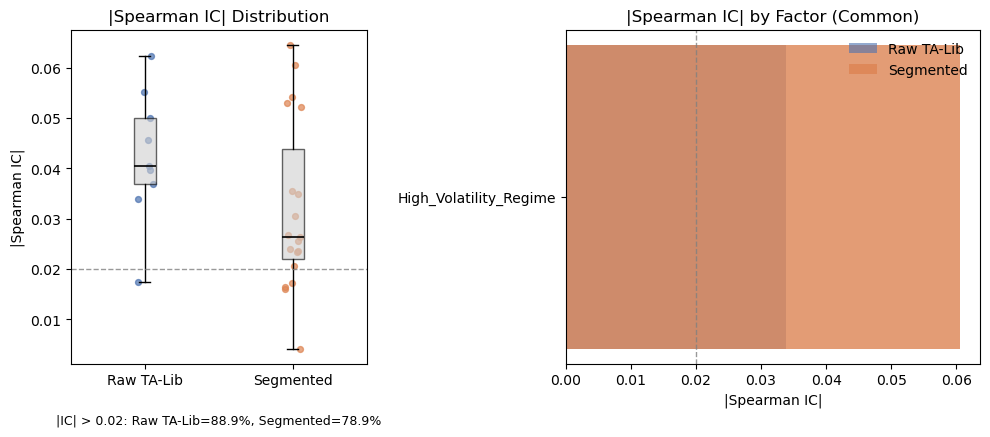

In [75]:
s_raw = (corr_check(ticker = 'ic_main', family="vol",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="vol",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common =  plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


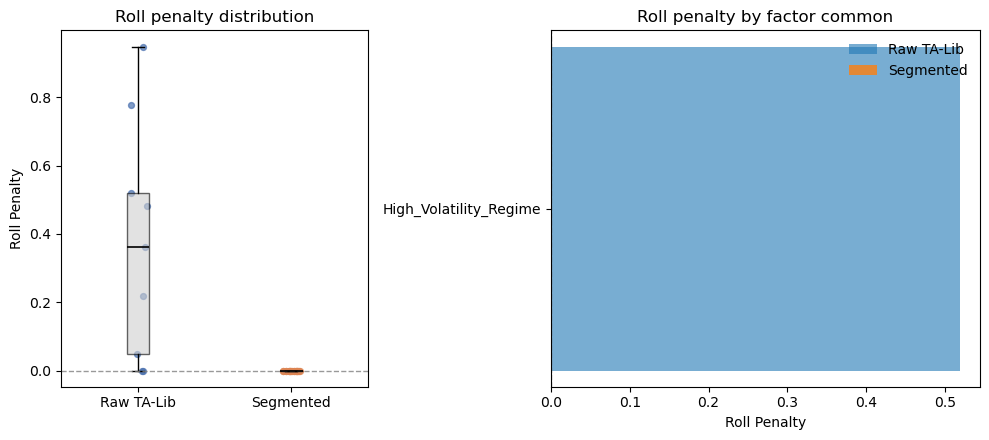

In [76]:
s_raw = (corr_check(ticker = 'ic_main', family="vol",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="vol",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

**Higher Frequency**

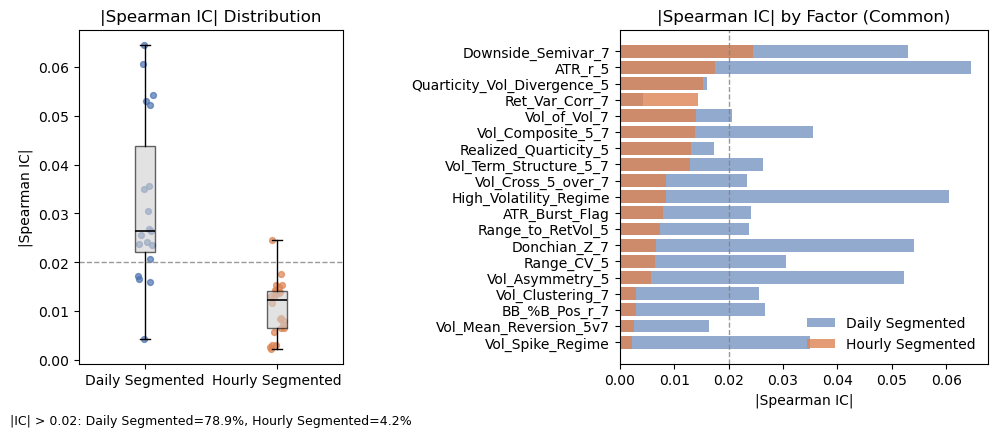

In [77]:
s_day = (corr_check(family="vol",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_hour = (corr_check(ticker = 'ic', frequency = 'minute', multiplier = 60, family="vol",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_day,s_hour, label1="Daily Segmented", label2="Hourly Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

**CSI 300 Index Futures**

For relatively low-volatility and structurally stable instruments such as CSI 300 futures, segmentation not only preserves the predictive ability of volatility factors but also leads to a noticeable improvement in the stability and effective proportion of Spearman IC. This result suggests that, under such market conditions, volatility factors exhibit good adaptability and cross-period consistency. After removing structural noise associated with contract rolls, these factors are able to characterize the underlying risk state in a more stable and coherent manner.

在 CSI 300 这类相对低波动、结构更为平稳的标的中，分段化处理不仅未削弱波动率因子的预测能力，反而在一定程度上提升了其 Spearman IC 的稳定性与有效占比。这表明波动率因子在该类市场环境下具有较好的适应性与可迁移性，能够在剔除换月等结构性噪声后，更稳定地刻画真实的风险状态。



target 1 period next return created


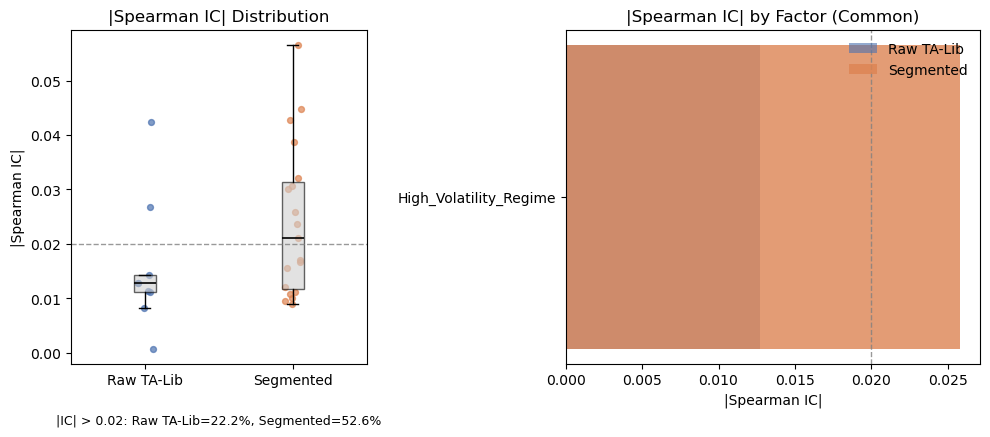

In [78]:
s_raw = (corr_check(ticker = 'if_main', family="vol",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'if_main', family="vol",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common =  plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


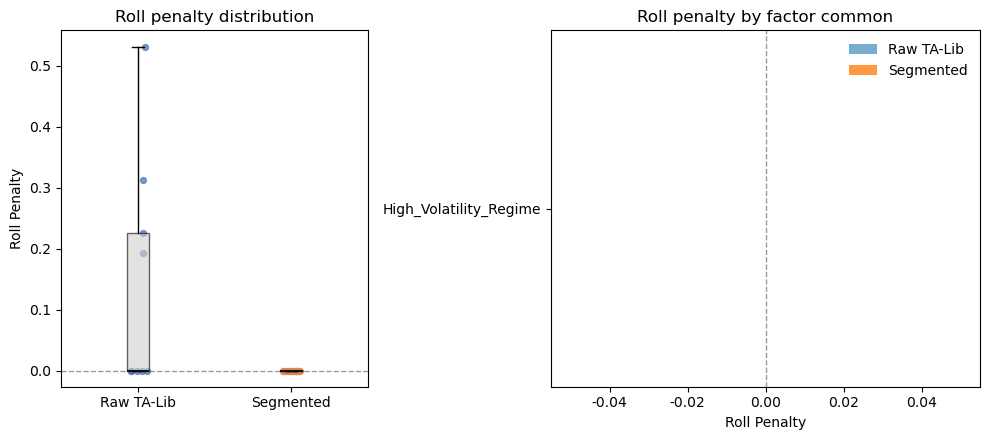

In [79]:
s_raw = (corr_check(ticker = 'if_main', family="vol",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'if_main', family="vol",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

**SSE 50 Index Futures**

For the SSE 50 (IH), we observe an overall moderate and stable performance profile. The proportion of factors with absolute Spearman correlations exceeding 0.02 is broadly comparable across the two setups (approximately 52% vs. 55%, noting that the factor sets are not directly comparable). At the same time, the engineered factors display systematically lower roll-related sensitivity relative to the baseline, indicating that their predictive performance is less concentrated around contract rollover periods. Under this setting, the observed improvement is more appropriately interpreted as an enhancement in robustness and signal purity, rather than a material increase in statistical strength.

在 上证 50（IH） 上，我们整体观察到较为中规中矩且稳定的表现。Spearman 绝对值大于 0.02 的因子占比在两组设定下基本一致（约 52% vs. 55%，需注意因子集合本身不可直接对比）。与此同时，工程化因子在 换月相关敏感度 上相对对照组呈现出系统性降低，表明其预测能力并未过度集中于合约换月邻近区间。在这一背景下，该结果更应被理解为 稳健性与信号纯净度的提升，而非统计强度上的显著跃升。

target 1 period next return created


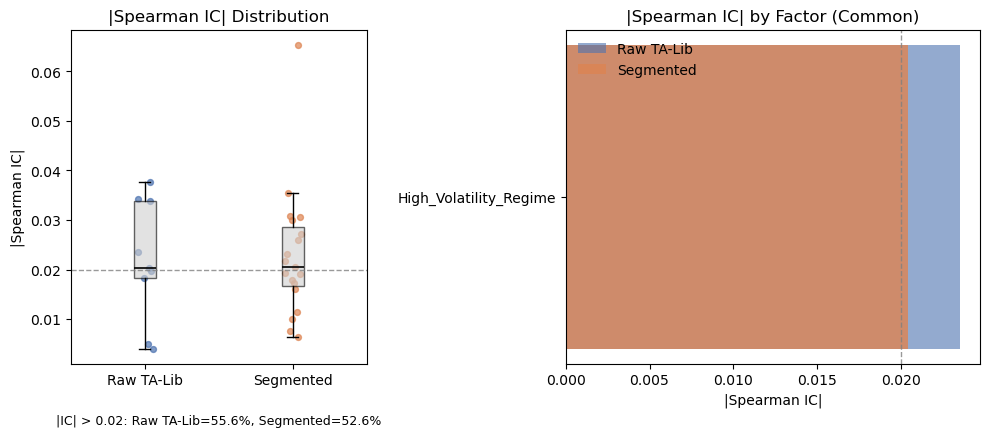

In [80]:
s_raw = (corr_check(ticker = 'ih_main', family="vol",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="vol",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


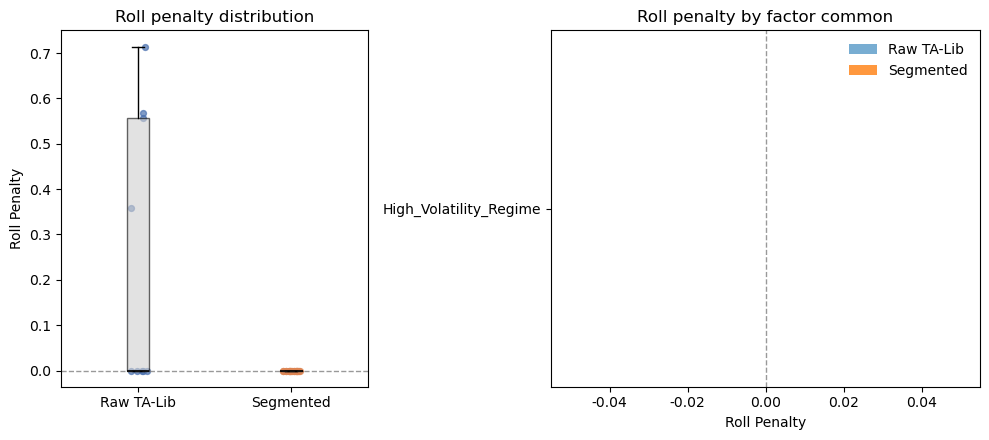

In [81]:
s_raw = (corr_check(ticker = 'ih_main', family="vol",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="vol",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

#### **Intraday**

In the construction of volatility factors, we already incorporate intraday range-based information such as ATR and high–low ranges to characterize how risk aggregates over time. While these measures rely on intraday prices, their modeling objective remains cross-bar volatility estimation, primarily addressing the question of “how large the fluctuations are.”

Building on the same range-based concept, the intraday structure factors further shift the focus to the single-bar level in order to describe how price movement is realized at a finer temporal scale. Rather than measuring range magnitude alone, this module provides a structured representation of intrabar price behavior, including close location, shadow geometry, range expansion, and gap-related pressure.

At the intraday scale, we additionally introduce range-based volatility estimators derived from high–low prices, such as Parkinson volatility, as a complement to traditional close-to-close measures. By efficiently utilizing range information without imposing directional assumptions, these estimators serve as suitable proxies for bar-level risk intensity.

在波动率因子的构建中，我们已经引入了部分源自日内价格区间的信息，例如 ATR、high–low range 等，用于刻画风险在时间维度上的聚合强度。这类指标虽然依赖日内数据，但其建模目标仍是跨多根 K 线的波动率刻画，核心在于回答“波动有多大”的问题。

在此基础上，日内结构类因子沿用相同的区间信息概念，但将关注点进一步下沉至单根 K 线尺度，用以刻画稍高频层面上价格变化的具体实现方式。该模块不再仅关注区间大小本身，而是对价格在区间内部的运行路径进行结构化描述，包括收盘位置、影线分布、区间扩张以及缺口压力等特征。

同时，在日内尺度下我们引入了基于高低价区间的波动率估计方法（如 Parkinson 波动率），作为对传统基于收盘价变动的波动率指标的补充。该类估计在忽略方向性的前提下，更高效地利用区间信息，适合作为单根 K 线层面风险强度的代理变量。

#### **Feature Design**

**Candle Geometry**

From a risk characterization perspective, bars with similar range magnitude may still correspond to very different market conditions. Body-dominated bars often reflect concentrated directional pressure, whereas bars with large shadows are more indicative of liquidity probing, transient shocks, or short-term order-flow imbalance. Candle geometry features aim to capture these differences in how risk is expressed within the same price range.

从风险刻画的角度看，即使在相同的区间波动强度下，不同的蜡烛结构往往对应着截然不同的市场状态。例如，实体主导的区间往往反映出方向性交易力量的集中释放，而影线占比偏高的区间则更多体现为流动性冲击、试探性交易或短期博弈行为。Candle Geometry 正是用于捕捉这类“区间内部风险表达方式”的差异。

| Factor                | Definition                                          | Measures                               | Interpretation                                                                                                             |
| --------------------- | --------------------------------------------------- | -------------------------------------- | -------------------------------------------------------------------------------------------------------------------------- |
| Range_Ratio       | Intrabar price range normalized by opening price    | Relative intrabar movement scale       | Higher values indicate larger price excursions relative to the opening level, reflecting stronger intrabar risk expression |
| Body_Ratio        | Candle body size normalized by total range          | Directional dominance within the range | High values suggest directional pressure dominates the bar; low values imply oscillatory or indecisive price action        |
| Lower_Shadow_Frac | Lower shadow length as a fraction of total range    | Downside probing intensity             | Large values indicate stronger downside testing or liquidity absorption at lower prices                                    |
| Upper_Shadow_Frac| Upper shadow length as a fraction of total range    | Upside probing intensity               | Large values reflect stronger upside testing or rejection near local highs                                                 |
| Wick_Imbalance   | Difference between upper and lower shadow fractions | Intrabar pressure asymmetry            | Positive values indicate stronger upside rejection; negative values imply stronger downside rejection                      |


**Gap & Open Pressure**

Gap and open pressure features characterize the deviation of the opening price from the prior close and its relative importance within the current intraday range. Rather than attempting to predict whether a price gap will persist or reverse, these features treat the opening gap as an initial condition that reflects the amount of risk pressure carried into the trading session.

Gap & Open Pressure 类特征用于刻画价格在开盘时刻相对于前一收盘的偏离程度及其在当前日内区间中的风险含义。该类因子并不试图预测缺口方向是否延续，而是将缺口视为一种初始条件，用于衡量开盘时刻所承载的风险压力及其相对于当日波动区间的重要性。

| Factor                 | Definition                                                        | Measures                  | Interpretation                                                                                                                         |
| ---------------------- | ----------------------------------------------------------------- | ------------------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| Open_Gap           | Opening price deviation relative to prior close                   | Opening displacement      | Captures the magnitude of price adjustment occurring at the session open                                                               |
| Open_Pressure_Norm | Opening deviation normalized by intraday range and local baseline | Relative opening pressure | High values indicate that opening risk is large relative to typical intraday movement, signaling concentrated risk release at the open |



**Intraday Volatility Proxy & World Quant**

Within the intraday structure module, we additionally introduce a small set of exploratory features to complement the characterization of bar-level risk intensity and structural extremeness. The motivation behind these features draws on classic high–low range-based estimators, such as Parkinson volatility, as well as early WorldQuant Alpha design ideas that emphasize structured representations of price extremeness.

It should be emphasized that these features are not treated as core volatility measures nor as standalone predictive signals. Instead, they serve as auxiliary structural descriptors of the intraday risk environment, providing additional context for how risk is expressed within individual bars.

在日内结构模块中，我们额外引入了少量探索性特征，用于补充刻画单根 K 线层面的风险强度与结构性极端状态。该类特征在构造动机上借鉴了部分经典的高低价区间估计方法（如 Parkinson 波动率），以及早期 WorldQuant Alpha 因子中对价格极端行为进行结构化刻画的设计思路。

需要强调的是，这些特征并不被视为核心波动率指标或独立的预测信号，其主要作用在于为日内风险环境提供辅助性的结构描述，用以补充对风险表达方式的理解。

| Factor                | Definition                                                            | Measures                 | Interpretation                                                                                                                                                         |
| --------------------- | --------------------------------------------------------------------- | ------------------------ | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| IV_Parkinson_7  | Short-window smoothed Parkinson volatility based on high–low range    | Bar-level risk intensity | Efficient proxy for intrabar volatility magnitude that utilizes high–low information without relying on directional returns                                            |
| High_Extreme_Flag | Indicator for price exceeding its recent intraday structural baseline | Structural extremeness   | Flags whether price is positioned at an unusually extended level relative to recent intraday structure, serving as a contextual marker rather than a predictive signal |

**Note**

In the loose configuration, standard time shifting is used in place of segment-based lagging. In addition, IV_Parkinson is applied in a smoothed form, and heuristic intraday signals such as Gap_Fill_Ratio and KSFT are retained as part of an exploratory experimental design rather than as core features.

**CSI 500 Index Futures**

In [82]:
print('Robust Version: Modeling on Log Close')
corr_check(ticker = 'ic_main', family = 'intra', cls = treemodel_factors_augment, selection = True, light = False)

Robust Version: Modeling on Log Close
[rolling_corr_report] No pairs ≥ 0.90 across 10 slices. (fold=10, span=234, cols=12)
target 1 period next return created
[coverage] kept 9/9 features (≥ 55%, n_eff ≥ 200); median coverage=89.63%, median n_eff=2100
Pearson Effective 77.78%
Spearman Effective 55.56%
Kendall Effective 55.56%
[selection] kept 5/9 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=9): 66.67%
roll_penalty     > 0.10 (all features, n=9): 0.00%


pearson  spearman   kendall  effective_pct  \
Range_Ratio         0.045626  0.053530  0.036698            1.0   
Open_Gap           -0.078547  0.034079  0.023971            1.0   
Open_Pressure_Norm -0.048668 -0.030487 -0.020170            1.0   
IV_Parkinson_7      0.041749  0.065886  0.045196            1.0   
High_Extreme_Flag   0.035453  0.038797  0.031685            1.0   

                    year_spearman_min  year_spearman_max  sign_consistency  \
Range_Ratio                 -0.017083           0.187960               0.8   
Open_Gap                    -0.200832           0.131180               0.7   
Open_Pressure_Norm          -0.109687           0.082414               0.6   
IV_Parkinson_7              -0.008625           0.193295               0.9   
High_Extreme_Flag           -0.020964           0.160162               0.7   

                    roll_penalty  winsor_penalty  decile_LS_signed  \
Range_Ratio                  0.0        0.002465          0.003391   
Open_Gap                     0.0        0.000000          0.001195   
Open_Pressure_Norm           0.0        0.000806          0.004706   
IV_Parkinson_7               0.0        0.001806          0.003179   
High_Extreme_Flag            0.0        0.000000               NaN   

                    decile_long_return  decile_short_return       QSL  
Range_Ratio                   0.001926            -0.001465  0.463317  
Open_Gap                      0.000393            -0.000802  0.454779  
Open_Pressure_Norm           -0.001163             0.003543  0.468743  
IV_Parkinson_7                0.002017            -0.001162  0.462535  
High_Extreme_Flag                  NaN                  NaN  0.450000

In [83]:
corr_check(ticker = 'ic_main', family = 'intra', cls = treemodel_factors_daily, selection = False, light = False)

[rolling_corr_report] Pairs exist but none met presence ≥ 70%. (corr_thresh=0.9, n_slices=10)
target 1 period next return created
[coverage] kept 7/7 features (≥ 55%, n_eff ≥ 200); median coverage=99.96%, median n_eff=2341
Pearson Effective 71.43%
Spearman Effective 57.14%
Kendall Effective 14.29%
sign_consistency > 0.55 (all features, n=7): 71.43%
roll_penalty     > 0.10 (all features, n=7): 42.86%


pearson  spearman   kendall  effective_pct  \
High_Minus_Low  0.022215  0.079523  0.054622       1.000000   
KLOW           -0.089169 -0.003785 -0.002789       0.333333   
KSFT           -0.073517 -0.021420 -0.013745       0.666667   
KUP             0.110899  0.024207  0.015665       1.000000   
KBODY           0.020660  0.023481  0.015428       1.000000   
Intra_Momentum -0.007254 -0.016143 -0.010587       0.333333   
Open_Gap       -0.016334 -0.018687 -0.013099       0.666667   

                year_spearman_min  year_spearman_max  sign_consistency  \
High_Minus_Low          -0.062531           0.159066               0.9   
KLOW                    -0.156785           0.091858               0.4   
KSFT                    -0.161944           0.031290               0.5   
KUP                     -0.053763           0.096744               0.6   
KBODY                   -0.058901           0.102876               0.8   
Intra_Momentum          -0.130568           0.074753               0.6   
Open_Gap                -0.130643           0.066122               0.7   

                roll_penalty  winsor_penalty  decile_LS_signed  \
High_Minus_Low      0.024809        0.001926          0.002732   
KLOW                0.000000        0.000385          0.003821   
KSFT                0.892680        0.001040          0.004298   
KUP                 0.000000        0.001152          0.001490   
KBODY               0.708709        0.000000          0.004649   
Intra_Momentum      0.666256        0.000000         -0.001190   
Open_Gap            0.000000        0.000000          0.000044   

                decile_long_return  decile_short_return       QSL  
High_Minus_Low            0.001222            -0.001510  0.458252  
KLOW                     -0.002697             0.001123  0.181478  
KSFT                     -0.002463             0.001835  0.377818  
KUP                       0.001418            -0.000073  0.455846  
KBODY                     0.000813            -0.003836  0.425159  
Intra_Momentum            0.001319             0.000128  0.311113  
Open_Gap                  0.001078             0.001122  0.427194

Due to differences in factor construction—specifically, the use of normalized OHLC inputs combined with segment-safe operations to mitigate contract-roll effects—a strictly fair one-to-one comparison between the two factor sets is not feasible. Overall, the proportion of factors with absolute Spearman correlations exceeding 0.02 appears broadly comparable across the two approaches.

Notably, open-gap–based factors exhibit more pronounced and robust Spearman correlations after normalization and roll isolation, while most other factors do not seem to be primarily driven by roll effects.

由于因子构造方式存在差异（本研究采用基于归一化 OHLC 的构造，并结合 segment-safe 处理以尽量隔离换月效应），两类因子之间难以进行严格的一对一公平比较。总体来看，两者在 Spearman 相关系数绝对值大于 0.02 的因子占比上表现大致接近。值得注意的是，Open Gap 类因子在归一化与换月隔离处理后，反而呈现出更为显著且稳定的 Spearman 表现；与此同时，其余多数因子并未显示出明显由换月效应主导的特征。

target 1 period next return created


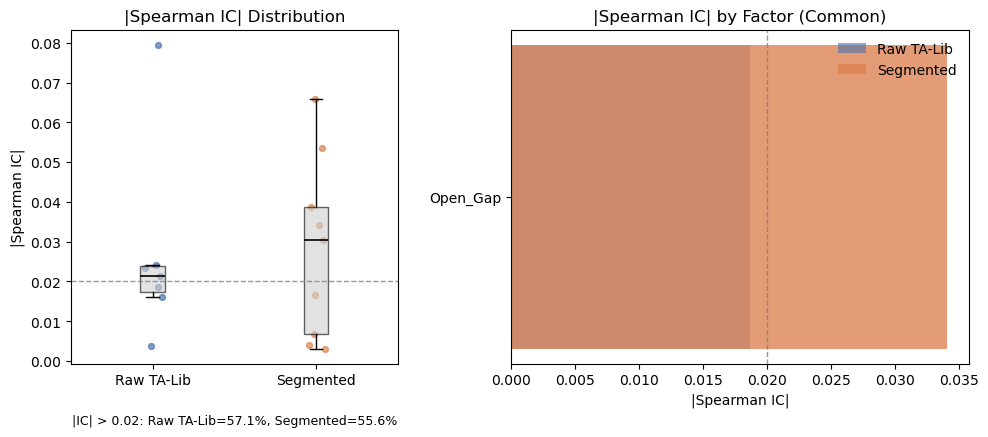

In [84]:
s_raw = (corr_check(ticker = 'ic_main', family="intra",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


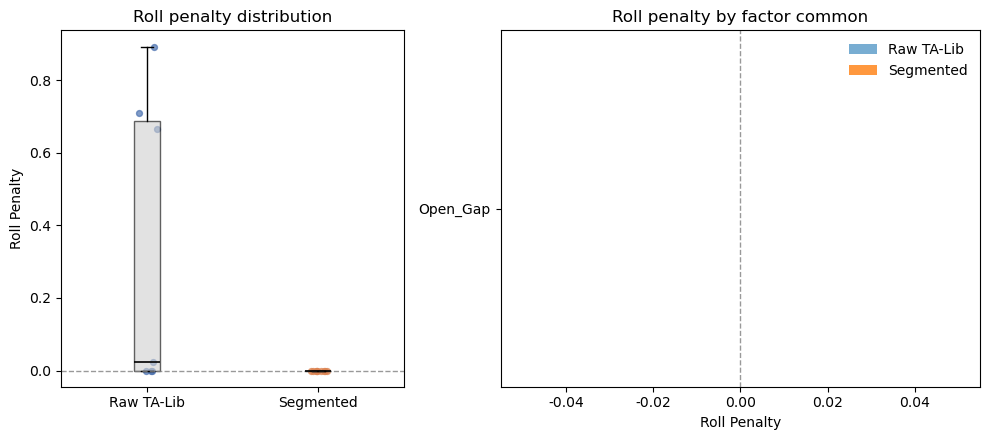

In [85]:
s_raw = (corr_check(ticker = 'ic_main', family="intra",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

For the CSI 500 (IC), no systematic differences are observed between the masked and non-masked configurations (spearman slightly higher for no mask). Factor behavior and overall statistical properties remain broadly similar under both settings, suggesting that roll masking has a limited impact for this ticker.

在 中证 500（IC） 上，mask 与 non-mask 设置之间并未观察到系统性的差异。两种处理方式下因子的整体统计特征与相关性表现基本一致 (spearman slightly higher for no mask)，表明在该标的上，换月掩码处理对结果的影响相对有限。

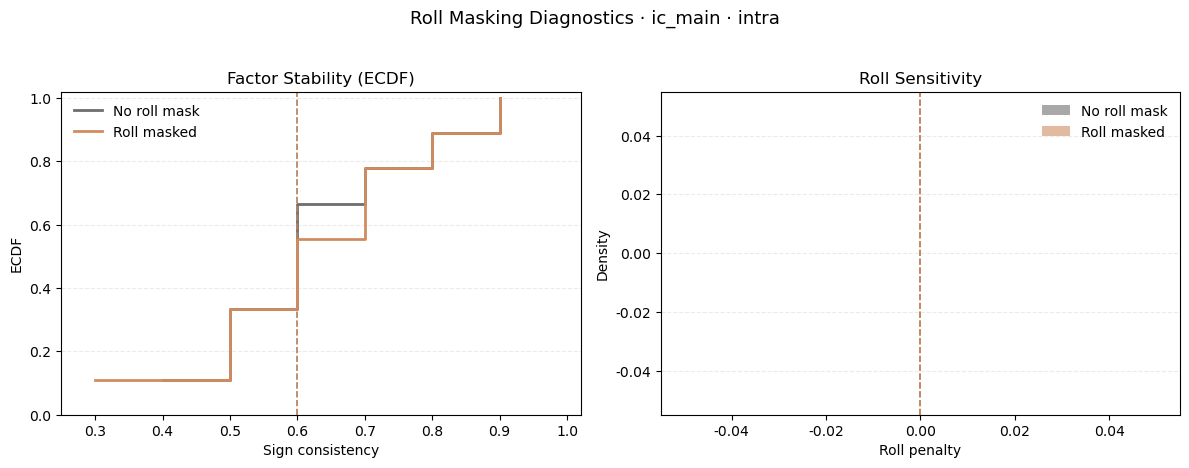

In [86]:
plot_roll_mask_diagnostics(ticker="ic_main", family="intra", cls=treemodel_factors_augment)

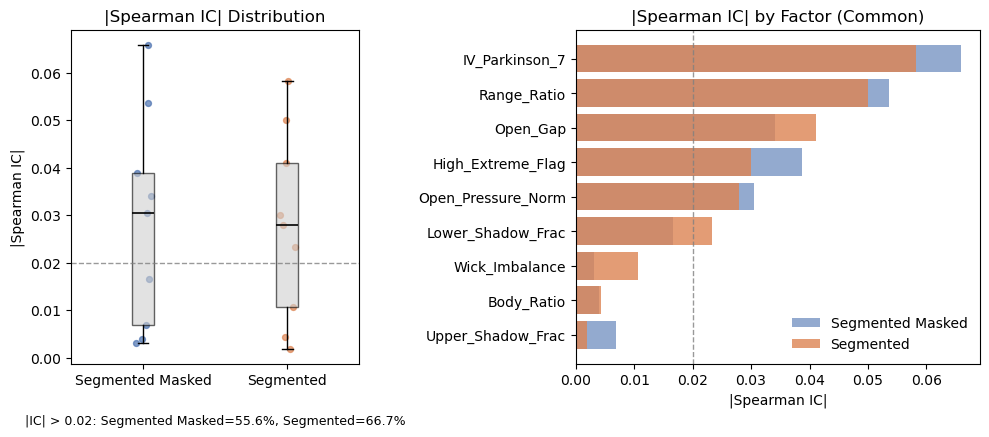

In [87]:
s_raw = (corr_check(ticker = 'ic_main', family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,mask = False)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Segmented Masked", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

**High Frequency**

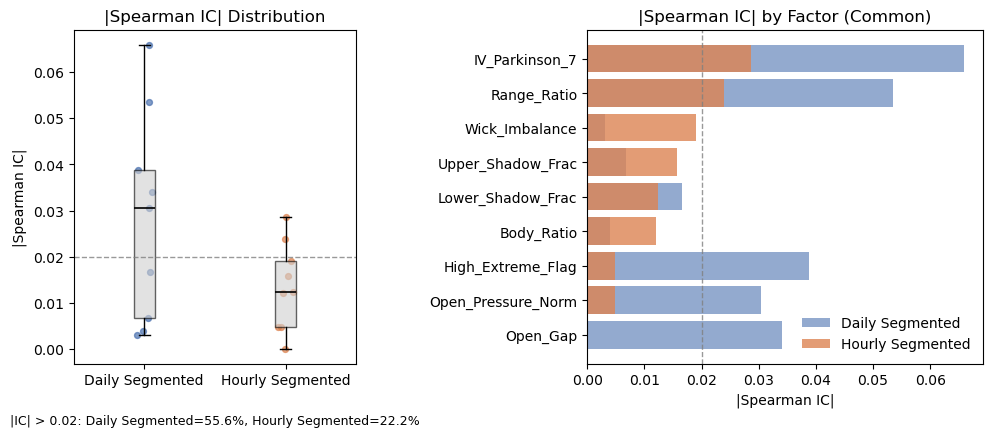

In [88]:
s_day = (corr_check(family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_hour = (corr_check(ticker = 'ic', frequency = 'minute', multiplier = 60, family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_day,s_hour, label1="Daily Segmented", label2="Hourly Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

**CSI 300 Index Futures**

In the CSI 300, we observe conclusions that is consistent. One noteworthy observation is that the Open Gap factor appears to exhibit a certain degree of roll-related behavior in the CSI 300 comparison group. This effect may be related to the index’s pricing structure during contract rolls, its opening gap characteristics, and the way information is concentrated and released during contract transitions. The underlying mechanism, however, remains to be further investigated.

在 沪深 300 中我们观察到了与中证大体一致的结论。一个值得注意的现象是，Open Gap 因子在沪深 300 对照组中似乎表现出一定的换月相关特征。这一现象可能与该指数在换月阶段的定价结构、开盘跳空特征以及合约切换过程中信息集中释放方式有关，具体机制仍有待进一步分析。

target 1 period next return created


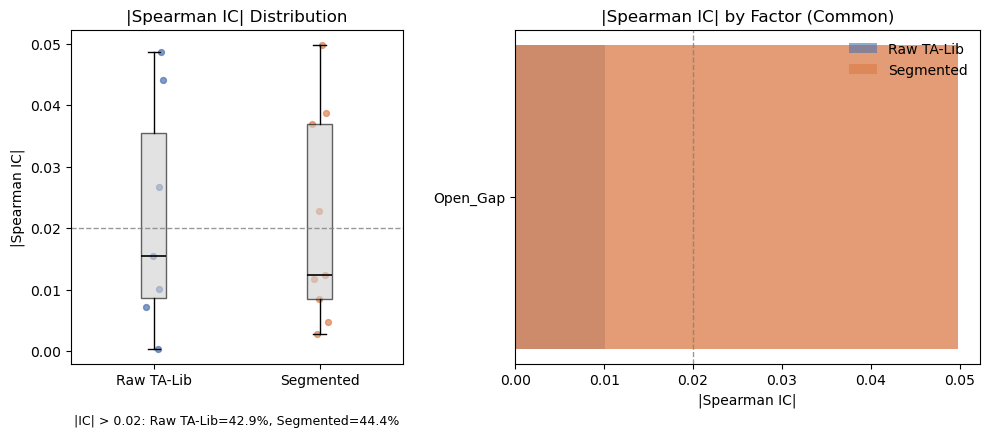

In [89]:
s_raw = (corr_check(ticker = 'if_main', family="intra",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'if_main', family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


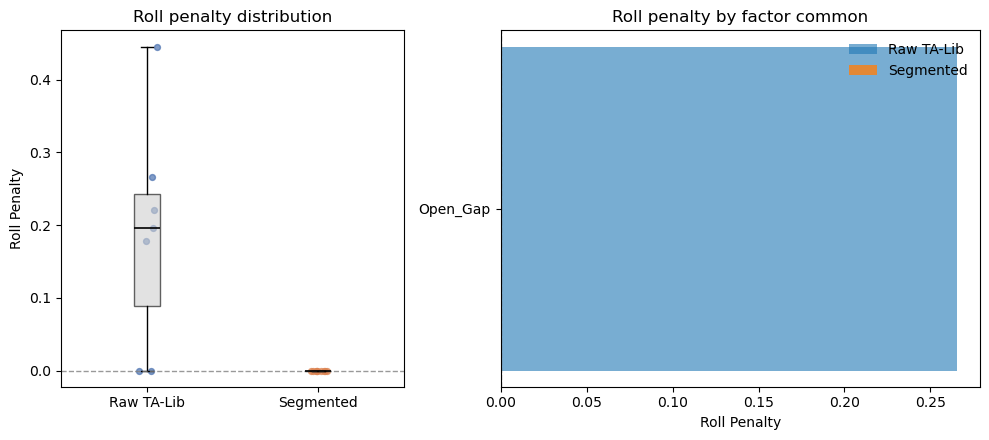

In [90]:
s_raw = (corr_check(ticker = 'if_main', family="intra",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'if_main', family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

For the CSI 300, the masked configuration exhibits improved IC stability and stronger Spearman correlations.

在沪深 300 上，采用换月遮盖（mask）后的设定整体表现出更好的 IC 稳定性，同时 Spearman 相关性也有所改善。

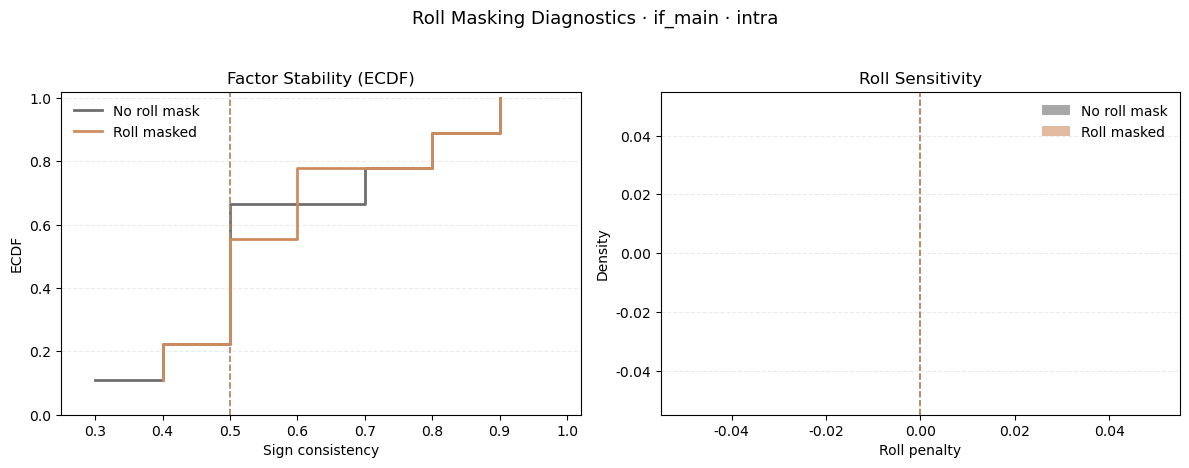

In [91]:
plot_roll_mask_diagnostics(ticker="if_main", family="intra", cls=treemodel_factors_augment)

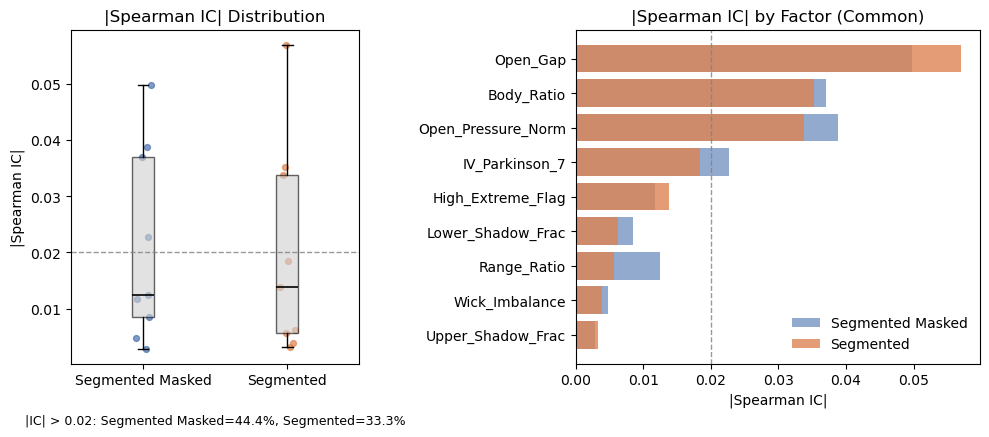

In [92]:
s_raw = (corr_check(ticker = 'if_main', family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'if_main', family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,mask = False)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Segmented Masked", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

**SSE 50 Index Futures**

The overall conclusions are consistent across the SSE 50， CSI 300 and CSI 500. The only notable difference is that roll-driven effects are weaker in the comparison group, which may be attributable to asset-level heterogeneity.

在 上证 50 上，整体结论基本保持一致。唯一的差异在于，换月驱动的效益在对照组中表现相对更弱，这一现象可能与不同标的在 流动性结构、成分稳定性及换月冲击敏感度 等方面的 资产异质性 有关。

target 1 period next return created


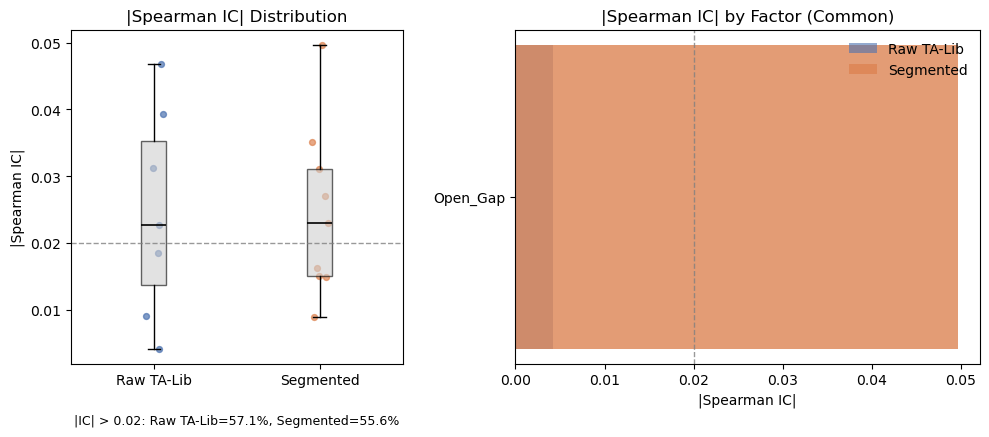

In [93]:
s_raw = (corr_check(ticker = 'ih_main', family="intra",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


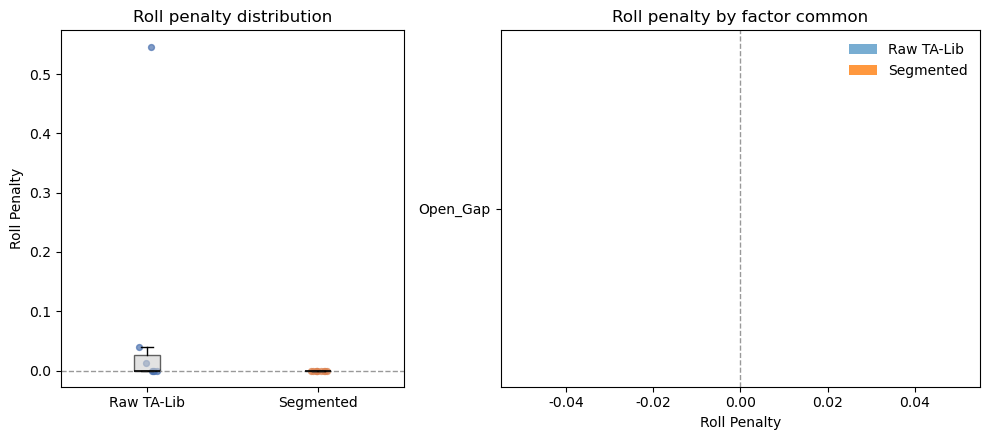

In [94]:
s_raw = (corr_check(ticker = 'ih_main', family="intra",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

The results for the SSE 50 are consistent with the observations above  (CSI300).

上证 50 的结果与 CSI300 结论保持一致

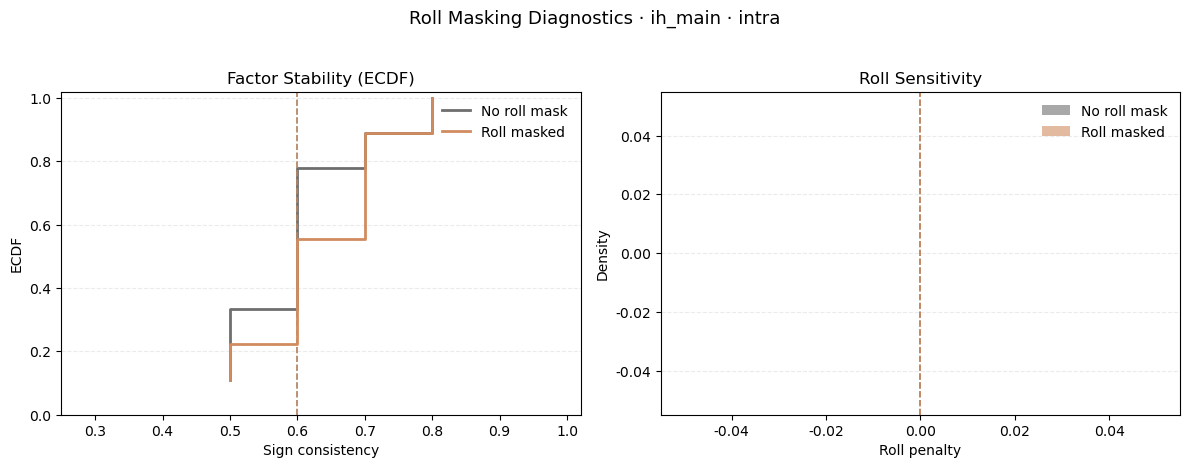

In [95]:
plot_roll_mask_diagnostics(ticker="ih_main", family="intra", cls=treemodel_factors_augment)

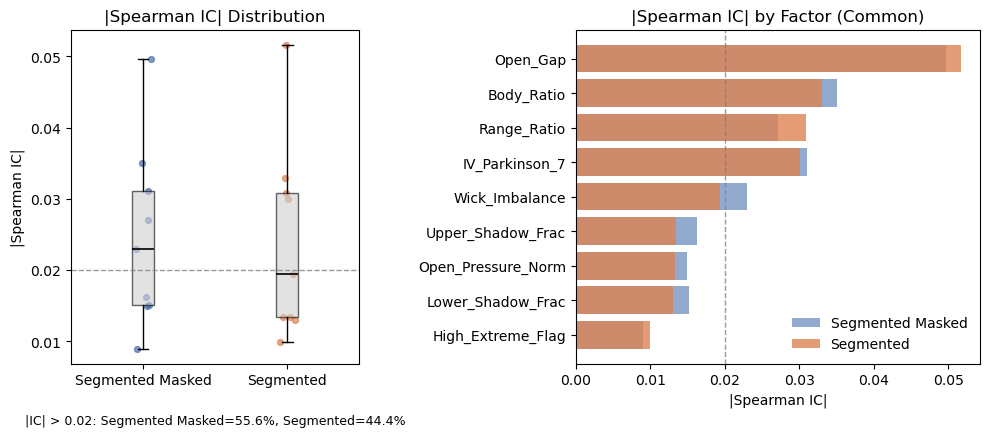

In [96]:
s_raw = (corr_check(ticker = 'ih_main', family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,mask = False)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Segmented Masked", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

**Note**

After removing the roll masking (i.e., retaining observations immediately following contract rolls), the Spearman correlation tends to deteriorate, with the effect being particularly pronounced at Parkison7. This behavior may be related to structural disturbances around roll periods; however, whether the roll mask design should be retained remains an open question and requires further validation.

#### **Volume**

Volume, like open interest, does not provide a stable one-to-one proxy for directional risk appetite; it primarily reflects market participation, trading intensity, and liquidity supply–demand conditions. Nevertheless, empirically, price–volume interactions have long served as a robust source of alpha across markets, as they encode information about liquidity, order-imbalance pressure, and the efficiency with which trading activity is translated into price changes. Motivated by this, we introduce an additional factor class focusing on volume-flow dynamics, combining volume normalization, price–volume interaction terms, and adapted WorldQuant-style formulations. To ensure robustness under futures contract rolls and regime segmentation, we implement these factors in a segment-safe manner and replace cross-sectional ranking with localized time-series ranking.

成交量与持仓量类似，并不能作为方向性风险偏好的稳定一一映射指标；它主要反映的是市场参与程度、交易活跃度，以及流动性供需状态。然而，从经验上看，价格—成交量之间的相互作用长期以来一直是跨市场的稳健 Alpha 来源，因为其中隐含了关于流动性、订单不平衡压力，以及交易活动向价格变动传导效率的信息。

基于这一认识，我们引入了一类新的因子族，专注于刻画成交量流动（volume-flow）动态特征。该类因子综合了成交量归一化处理、价量交互项，以及经适配的 WorldQuant 风格构造方法。为确保在期货合约换月与不同行情结构分段下的稳健性，这些因子均以 segment-safe 的方式实现，并选择局部时间序列排序，以降低结构性断点对因子表现的干扰。

**TS-RANK**

While the majority of WorldQuant-style factors rely on cross-sectional ranking, it is important to note that WorldQuant also includes factor classes that are explicitly time-series in nature (e.g., TS Rank–based constructions).
In this work, we do not convert cross-sectional factors into time-series ranked forms. Instead, time-series ranking is applied only to variables that are inherently designed to describe local states or regime conditions, such as volatility and volume-flow features.
For these state-based factors, we apply a segment-safe rolling time-series ranking operator. Within each roll-defined segment, observations are ranked over a rolling window, and only the rank of the most recent value is retained. The resulting rank is normalized to the 
[0,1] interval, providing a scale-free measure of how extreme the current observation is relative to its recent local history.
This construction avoids cross-segment leakage across futures contract rolls, mitigates regime-dependent scale effects, and yields stable conditioning signals under structural breaks

尽管 WorldQuant 风格的因子体系以横截面排序为主，但其体系中本身亦包含明确基于时间序列排序（TS Rank）的因子类型。本文并未将横截面因子统一转换为时间序列排序形式，而是仅对那些在设计上即用于刻画局部状态或制度环境的因子（如波动率与成交量流动相关因子）采用时间序列排序方法。
对于这类状态型因子，我们使用 segment-safe 的滚动时间序列排序算子。在每一个由合约换月界定的独立区段内，对变量在滚动窗口中的历史观测进行排序，并仅保留最新观测值在其局部历史分布中的相对位置。排序结果被标准化至 
[0,1] 区间，用以刻画当前状态相对于近期历史的极端程度。该构造避免了期货合约换月导致的跨区段信息泄露，缓解了不同行情结构下的尺度效应，并在存在结构性断点时提供稳定、可解释的条件化信号。

#### **Feature Design**

**Flow Accumulation**

Flow accumulation factors describe the persistence and evolution of directional trading pressure by cumulatively aggregating volume signed by price changes. Unlike raw volume measures, these features capture whether trading activity consistently reinforces price movement or largely cancels out over time. OBV-based measures are implemented in a segment-safe manner to prevent contamination across futures contract rolls. Derived features such as OBV slope and normalized deviations further characterize the acceleration and abnormality of flow pressure, providing state variables that condition the effectiveness of trend or mean-reversion signals rather than serving as standalone predictors.

流量累积类因子通过对按价格变动方向加权的成交量进行累积，刻画方向性交易压力的持续性与演化过程。与单纯的成交量指标不同，该类因子关注的是成交量是否在时间维度上持续强化价格运动，抑或相互抵消。OBV 类指标采用 segment-safe 实现，以避免期货合约换月带来的累积污染；其衍生形式（如斜率与标准化偏离）进一步刻画流量压力的变化速度与异常程度。这类因子主要作为市场状态变量，用于对趋势或均值回归信号进行条件化约束，而非独立的预测信号。

| Factor        | Definition                                                                  | Measures                      | Interpretation                                                                                                                                                                             |
| ------------- | --------------------------------------------------------------------------- | ----------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| OBV       | Segment-safe cumulative sum of volume signed by one-period return direction | Directional flow accumulation | Captures whether trading volume persistently aligns with price direction within a contract segment, reflecting sustained buying or selling pressure rather than instantaneous activity     |
| OBV_Slope | Short-horizon exponential moving average of OBV first differences           | Flow acceleration             | Positive values indicate strengthening directional flow pressure; near-zero values suggest balanced or canceling flow; negative values signal deceleration or reversal of accumulated flow |
| OBV_Z     | Local standardized deviation of OBV from its recent rolling mean            | Flow abnormality              | Large absolute values indicate unusually strong or weak directional flow relative to recent history, highlighting flow states that deviate from background conditions                      |

Although OBV-based flow features and price–open-interest alignment factors both involve directionally signed quantities, they describe fundamentally different aspects of market activity. OBV aggregates signed traded volume and therefore reflects execution flow and participation intensity, capturing whether trading activity persistently reinforces price movement. In contrast, open-interest–based factors track changes in outstanding positions and measure capital commitment and inventory dynamics. As a result, OBV characterizes turnover-driven flow persistence, while OI-alignment features describe position-level conviction. These two dimensions are complementary rather than redundant and are treated as distinct categories in the factor design.

尽管 OBV 类流动结构因子与基于价格–持仓量一致性的因子在形式上均涉及带符号的数量指标，但二者刻画的是不同层面的市场行为。OBV 基于成交量的累积，反映的是交易执行层面的流动强度与参与度，刻画成交行为是否持续强化价格运动；而基于持仓量的因子关注的是未平仓头寸的变化，反映资本是否在方向上持续建立或退出头寸，属于仓位承诺层面的信息。

因此，OBV 描述的是“成交流动”的持续性，而价格–持仓量因子刻画的是“仓位承诺”的一致性，二者在经济含义上互为补充而非重复。

**Price - Volume**

Price–volume interaction factors characterize how trading activity is transmitted into price movement. While all features in this group involve joint price and volume information, they capture complementary aspects of local market mechanics: directional concentration of flow, efficiency of volume-to-price translation, divergence between price movement and participation, and instantaneous impulse strength. These factors are implemented in a segment-safe manner and are intended as state descriptors rather than standalone directional signals.

价量交互类因子用于刻画成交活动如何在局部时间尺度内转化为价格变动。尽管该类因子均同时使用价格与成交量信息，但其关注角度有所不同，分别反映成交量在价格区间中的方向性集中程度、成交量向价格位移的传导效率、价量背离现象以及价格变动在成交参与下的瞬时冲击强度。该类因子均采用 segment-safe 实现，主要作为市场状态描述变量，而非独立的方向性预测信号。

| Factor                            | Definition                                                          | Measures                           | Interpretation                                                                                                                                          |
| --------------------------------- | ------------------------------------------------------------------- | ---------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------- |
| CMF_like                      | Volume-weighted average of return location within recent range      | Directional concentration of flow  | High values indicate volume concentrating near directional extremes; low values suggest balanced or absorbing price action                              |
| pv_divergence                 | Signed return scaled by deviation of volume from its recent average | Price–volume divergence            | Large values indicate price movement occurring under unusually high or low participation, highlighting potential inefficiency or stress                 |
| price_efficiency_under_volume | Absolute return scaled by normalized trading volume                 | Price response relative to expected participation            | Low values indicate large volume with limited price movement (absorption); high values indicate efficient translation of volume into price displacement |
| ForceIndex_norm               | Volatility- and volume-normalized product of return and volume      | Instantaneous price–volume impulse | Captures the strength of price movement weighted by participation, emphasizing event-driven or impulsive market behavior                                |


**Rel Return**

To detect abnormal trading activity, volume is normalized by a short-horizon rolling mean:

RelVol𝑡 =𝑉𝑡/MA𝑘(𝑉)𝑡

This measures current participation relative to the instrument’s recent baseline. The ratio form is intentionally non-symmetric: trading volume is strictly non-negative and bounded below, while spikes in volume reflect discrete increases in participation, information arrival, or inventory transfer. In contrast, low volume mainly indicates inactivity or waiting behavior, rather than an economically equivalent opposite state. Compared with z-score normalization, this design avoids imposing artificial symmetry on volume and remains robust across instruments and market regimes.

为刻画成交量是否处于异常状态，我们采用短窗口滚动均值对成交量进行归一化：

RelVol𝑡 =𝑉𝑡/MA𝑘(𝑉)𝑡

该指标衡量的是当前成交量相对于近期常态的偏离程度。该归一化方式刻意保持非对称性：成交量天然为非负变量并存在下界，放量往往对应参与度的离散上升、信息冲击或头寸转移；而缩量更多反映市场处于观望或低活跃状态，并不构成经济意义上的“对称反向”情形。相比标准化（z-score）方法，该比例形式避免了对成交量强行施加对称分布假设，在不同合约与市场状态下具有更好的稳健性。

**Flow Equilibrium**

VWAP-based features characterize the position of price relative to a locally representative execution level implied by recent trading activity. VWAP is the volume-weighted average execution price over a short window and summarizes the mean location of executed trades in price space. By normalizing the deviation of price from VWAP using realized volatility, these factors provide a scale-free measure of price pressure or imbalance. Large positive or negative values indicate that price is trading materially away from this recent execution mean, while values near zero suggest a relatively balanced state. All quantities are computed in a segment-safe manner to ensure robustness under futures contract rolls.

基于 VWAP 的因子用于刻画价格相对于近期成交活动所隐含的代表性执行价格水平的位置。VWAP 是短周期内成交价格的成交量加权平均值，用于描述成交在价格维度上的均值位置。通过使用已实现波动率对价格偏离 VWAP 的幅度进行标准化，该类因子以无量纲方式衡量价格所处的压力或不平衡程度。较大的正负取值表明价格显著偏离近期的执行均值，而接近零的取值则对应较为平衡的状态。相关计算均采用 segment-safe 实现，以保证在期货合约换月情况下的稳健性

| Factor                                  | Definition                                                                                 | Measures                                  | Interpretation                                                                                                                                                                                                                               |
| --------------------------------------- | ------------------------------------------------------------------------------------------ | ----------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| VWAP_Dist_over_RV10                | Deviation of price from the 10-period segment-safe VWAP, normalized by realized relative volatility | Price deviation from local execution mean | Large positive or negative values indicate that price is trading materially away from the recent volume-weighted mean execution price, reflecting elevated price pressure or imbalance; values near zero suggest a relatively balanced state |
| VWAP_Dist_over_RV20 *(minute only)* | Deviation of price from the 20-period segment-safe VWAP, normalized by realized volatility | Medium-horizon execution imbalance        | Captures more persistent deviations from the recent volume-weighted execution mean; sustained extreme values may indicate prolonged pressure, while near-zero values reflect absorption or stabilization                                     |


**Flow Stability & Temporal Structure**

Flow stability and temporal structure features describe how trading activity evolves over time rather than its instantaneous magnitude. Volume persistence captures whether participation is sustained or episodic, flow-direction persistence measures the temporal consistency of directional participation, and volume entropy quantifies the degree of regularity versus fragmentation in trading activity. These features act as state variables that characterize the stability of market participation and help condition the reliability of price-based signals.

流动稳定性与时间结构类因子用于刻画成交参与在时间维度上的组织方式，而非单期强度。其中，成交量持续性反映交易参与是否具有延续性，成交方向持续性刻画价格变动与成交方向在时间上的一致程度，而成交量熵用于衡量成交活动的集中性或碎片化程度。该类因子主要作为市场状态描述变量，用于评估价格信号在不同参与稳定性环境下的可靠性

| Factor                            | Definition                                                                       | Measures                                 | Interpretation                                                                                                                                                   |
| --------------------------------- | -------------------------------------------------------------------------------- | ---------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| volume_persistence_10        | Rolling autocorrelation of trading volume over a 10-period window (segment-safe) | Temporal stability of participation      | High values indicate sustained, persistent trading activity; low or negative values suggest episodic or rapidly changing participation                           |
| flow_direction_persistence_10 | Rolling mean of signed flow direction, defined as sign(return) × sign(volume)    | Directional consistency of flow          | High absolute values indicate persistent directional alignment between price movement and trading activity; values near zero reflect churning or indecisive flow |
| volume_entropy_10             | Rolling entropy of volume distribution over a 10-period window                   | Regularity vs. fragmentation of activity | Low entropy reflects concentrated, structured trading patterns; high entropy indicates fragmented or noisy participation across time                             |


**CSI 500 Index Futures**

In [97]:
corr_check(ticker = 'ic_main', family="flow",cls=treemodel_factors_augment,selection=True,light=False,verbose=True,)

[rolling_corr_report] No pairs ≥ 0.90 across 10 slices. (fold=10, span=234, cols=17)
target 1 period next return created
[coverage] kept 14/14 features (≥ 55%, n_eff ≥ 200); median coverage=82.71%, median n_eff=1938
Pearson Effective 71.43%
Spearman Effective 85.71%
Kendall Effective 28.57%
[selection] kept 10/14 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=14): 85.71%
roll_penalty     > 0.10 (all features, n=14): 0.00%


pearson  spearman   kendall  effective_pct  \
OBV_Slope                      0.004270 -0.029315 -0.019417       0.666667   
OBV_Z                         -0.014588 -0.020581 -0.013917       0.333333   
VWAP_Dist_over_RV10           -0.039715 -0.039673 -0.026033       1.000000   
ForceIndex_norm               -0.048839 -0.029422 -0.019523       1.000000   
pv_divergence                  0.078081  0.056029  0.038824       1.000000   
flow_direction_persistence_10 -0.022748 -0.024718 -0.017417       1.000000   
volume_entropy_10             -0.023653 -0.053345 -0.036560       1.000000   
alpha43_volspike_reversal      0.024035  0.028424  0.019587       1.000000   
volume_shock_over_vol_10      -0.014410 -0.023914 -0.015123       0.666667   
alpha12_volflip_norm           0.028015  0.041156  0.027271       1.000000   

                               year_spearman_min  year_spearman_max  \
OBV_Slope                              -0.115585          -0.011723   
OBV_Z                                  -0.135547           0.043010   
VWAP_Dist_over_RV10                    -0.136112           0.027124   
ForceIndex_norm                        -0.139658           0.022834   
pv_divergence                          -0.011802           0.223484   
flow_direction_persistence_10          -0.148238           0.047429   
volume_entropy_10                      -0.259036           0.047908   
alpha43_volspike_reversal              -0.080737           0.153102   
volume_shock_over_vol_10               -0.082514           0.089369   
alpha12_volflip_norm                   -0.043749           0.190563   

                               sign_consistency  roll_penalty  winsor_penalty  \
OBV_Slope                                   1.0           0.0        0.000000   
OBV_Z                                       0.7           0.0        0.000295   
VWAP_Dist_over_RV10                         0.8           0.0        0.004604   
ForceIndex_norm                             0.8           0.0        0.001639   
pv_divergence                               0.8           0.0        0.000000   
flow_direction_persistence_10               0.9           0.0        0.011264   
volume_entropy_10                           0.7           0.0        0.000497   
alpha43_volspike_reversal                   0.8           0.0        0.000000   
volume_shock_over_vol_10                    0.6           0.0        0.002259   
alpha12_volflip_norm                        0.8           0.0        0.000000   

                               decile_LS_signed  decile_long_return  \
OBV_Slope                              0.001252            0.000144   
OBV_Z                                 -0.000024           -0.001018   
VWAP_Dist_over_RV10                    0.001993           -0.000798   
ForceIndex_norm                        0.001923            0.000703   
pv_divergence                          0.005771            0.003918   
flow_direction_persistence_10          0.001025            0.000553   
volume_entropy_10                      0.002269           -0.000885   
alpha43_volspike_reversal              0.003022            0.002875   
volume_shock_over_vol_10               0.000208           -0.001067   
alpha12_volflip_norm                   0.003092            0.002106   

                               decile_short_return       QSL  
OBV_Slope                                 0.001396  0.496691  
OBV_Z                                    -0.001043  0.449874  
VWAP_Dist_over_RV10                       0.001195  0.457512  
ForceIndex_norm                           0.002626  0.475402  
pv_divergence                            -0.001853  0.473085  
flow_direction_persistence_10             0.001578  0.452974  
volume_entropy_10                         0.001385  0.459027  
alpha43_volspike_reversal                -0.000147  0.462088  
volume_shock_over_vol_10                 -0.000859  0.450607  
alpha12_volflip_norm                     -0.000986  0.462367

In [98]:
corr_check(ticker = 'ic_main', family="flow",cls=treemodel_factors_daily,selection=False,light=False,verbose=True,)

[rolling_corr_report] Pairs exist but none met presence ≥ 70%. (corr_thresh=0.9, n_slices=10)
target 1 period next return created
[coverage] kept 13/13 features (≥ 55%, n_eff ≥ 200); median coverage=99.15%, median n_eff=2322
Pearson Effective 23.08%
Spearman Effective 46.15%
Kendall Effective 15.38%
sign_consistency > 0.55 (all features, n=13): 69.23%
roll_penalty     > 0.10 (all features, n=13): 53.85%


pearson  spearman   kendall  effective_pct  \
Money_Flow_Index        -0.012911 -0.025378 -0.016979       0.666667   
MFI Momentum            -0.009866 -0.014201 -0.009787       0.000000   
OBV                     -0.019367 -0.048833 -0.032477       1.000000   
Chaikin_Money_Flow      -0.018971  0.000219  0.000076       0.333333   
VWAP Distance / ATR     -0.011421 -0.019803 -0.013009       0.333333   
Force Index EMA / ATR    0.040559 -0.028008 -0.019142       1.000000   
Volume / Range Ratio    -0.001810 -0.013814 -0.009884       0.000000   
VW Return               -0.002717  0.005288  0.003054       0.000000   
price_volume_corr_10bar  0.014418 -0.011664 -0.007634       0.000000   
volume_zscore_20bar      0.003555  0.018334  0.011922       0.333333   
pv_divergence            0.033745  0.021007  0.014975       0.666667   
OBV_Slope               -0.004075 -0.034728 -0.023419       0.666667   
OBV_Z                   -0.026598 -0.028336 -0.019069       1.000000   

                         year_spearman_min  year_spearman_max  \
Money_Flow_Index                 -0.152188           0.030369   
MFI Momentum                     -0.129630           0.091745   
OBV                              -0.191435           0.013561   
Chaikin_Money_Flow               -0.108854           0.049428   
VWAP Distance / ATR              -0.130432           0.035972   
Force Index EMA / ATR            -0.143745           0.047148   
Volume / Range Ratio             -0.089520           0.011868   
VW Return                        -0.179221           0.087589   
price_volume_corr_10bar          -0.098928           0.171102   
volume_zscore_20bar              -0.061142           0.067488   
pv_divergence                    -0.075982           0.130905   
OBV_Slope                        -0.144264           0.006530   
OBV_Z                            -0.144049           0.041387   

                         sign_consistency  roll_penalty  winsor_penalty  \
Money_Flow_Index                      0.7      0.979772        0.000000   
MFI Momentum                          0.5      0.097974        0.001866   
OBV                                   0.9      0.029128        0.000000   
Chaikin_Money_Flow                    0.2      0.000000        0.001450   
VWAP Distance / ATR                   0.8      0.946217        0.001774   
Force Index EMA / ATR                 0.8      0.715077        0.000000   
Volume / Range Ratio                  0.9      0.506369        0.000000   
VW Return                             0.4      0.000000        0.000000   
price_volume_corr_10bar               0.6      0.000000        0.000429   
volume_zscore_20bar                   0.6      0.000000        0.000000   
pv_divergence                         0.5      0.439379        0.000000   
OBV_Slope                             0.9      0.478602        0.000000   
OBV_Z                                 0.8      0.897745        0.000442   

                         decile_LS_signed  decile_long_return  \
Money_Flow_Index                 0.001549           -0.001005   
MFI Momentum                     0.000091            0.000499   
OBV                              0.003154           -0.000558   
Chaikin_Money_Flow              -0.001397            0.000078   
VWAP Distance / ATR              0.000574            0.000824   
Force Index EMA / ATR           -0.002820            0.001902   
Volume / Range Ratio            -0.000078           -0.000205   
VW Return                        0.001763            0.002137   
price_volume_corr_10bar         -0.000800            0.000361   
volume_zscore_20bar              0.000928            0.000869   
pv_divergence                    0.002257            0.000636   
OBV_Slope                        0.001999           -0.000590   
OBV_Z                            0.001697           -0.001059   

                         decile_short_return       QSL  
Money_Flow_Index                    0.000544  0.358220  
MFI Momentum                  

Consistent with the previous category setup, we did not perform a one-to-one replication of TA-Lib factors; therefore, a strictly item-level comparison is not fully applicable. Nevertheless, even under this arguably unfavorable comparison setting, we still observe a clear and meaningful overall improvement.

Under the mask-roll configuration, the proportion of factors with an absolute Spearman correlation greater than 0.02 reaches 85.71%, significantly outperforming the benchmark. In particular, factors such as pv_divergence, OBV_Slope, and OBV_Z exhibit pronounced improvements, reflected either in a substantially reduced roll effect (i.e., cleaner signals) or in a stable increase in Spearman correlation.

Furthermore, after removing the mask-roll setting—which itself may introduce unverified distortions—the proportion of factors with an absolute Spearman correlation above 0.02 remains at 50%, still exceeding TA-Lib’s 46.2%. This suggests that the observed improvement is not solely driven by the roll-masking assumption.

和此前的类别设定一致，我们并未对 TA-Lib 因子进行一比一复刻，因此严格意义上的逐项对照并不完全成立；但即便在这种并非“有利”的对比条件下，仍能观察到较为显著的整体改进。

在 mask roll 的设定下，Spearman 绝对值大于 0.02 的因子占比达到 85.71%，表现显著优于对照组。其中 pv_divergence、OBV_Slope、OBV_Z 等因子均出现了清晰的改进特征，具体体现在 roll effect 下降（信号更为纯净）或 Spearman 稳定提升。

进一步地，在去除 mask roll（该设定本身可能引入未被充分验证的干扰效应）后，Spearman 绝对值大于 0.02 的因子占比仍保持在 50%，依然高于 TA-Lib 的 46.2%，表明改进并非完全依赖于换月遮盖假设。

target 1 period next return created


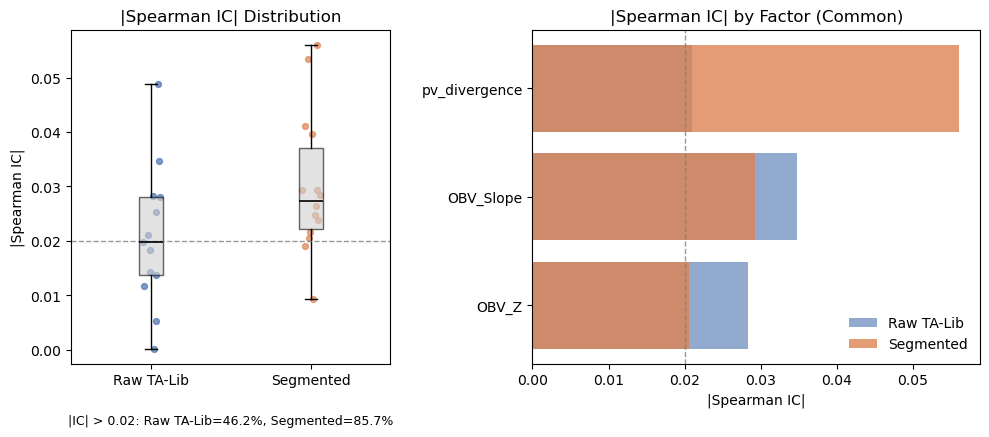

In [99]:
s_raw = (corr_check(ticker = 'ic_main', family="flow",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="flow",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


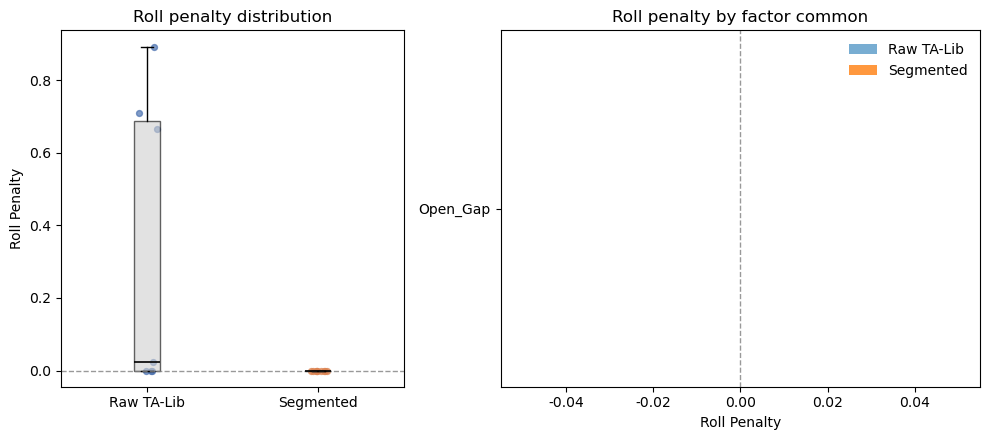

In [100]:
s_raw = (corr_check(ticker = 'ic_main', family="intra",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

For the CSI 500 index futures, the roll-masked configuration demonstrates stronger stability and overall performance compared with the non–roll-masked version. While this observation is consistent across the current set of diagnostics, further validation is still required to confirm the robustness of this effect.

在 中证 500 股指期货 上，roll mask 设定相较于 non-roll 版本表现出更强的稳定性与整体表现优势。尽管这一结论在当前诊断指标下具有一致性，仍有必要通过进一步测试来验证其稳健性。

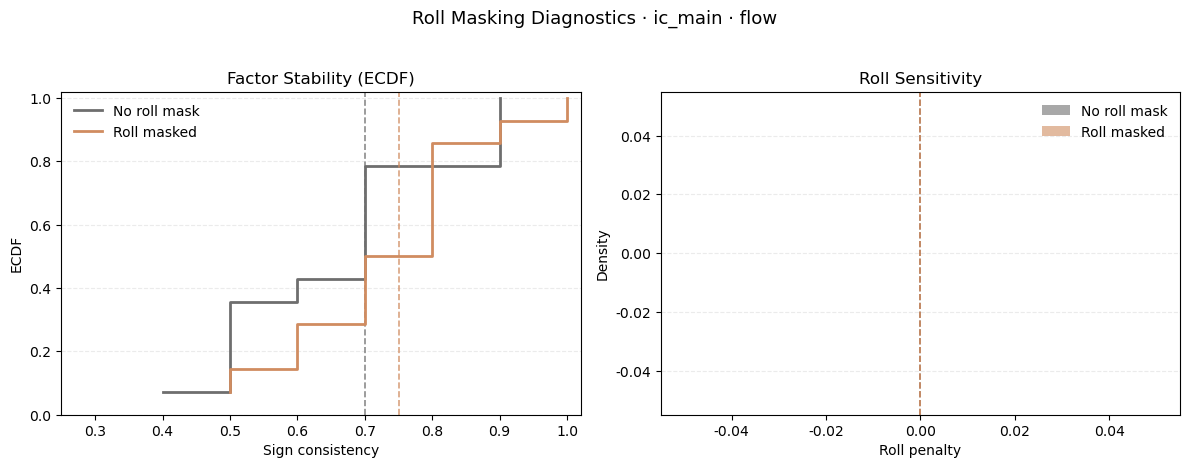

In [101]:
plot_roll_mask_diagnostics(ticker="ic_main", family="flow", cls=treemodel_factors_augment)

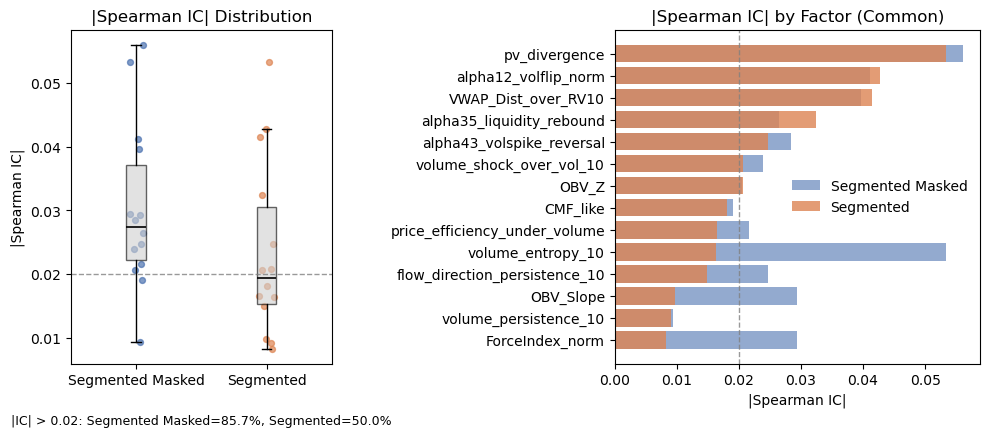

In [102]:
s_raw = (corr_check(ticker = 'ic_main', family="flow",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="flow",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,mask = False)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Segmented Masked", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

**Higher Frequency**

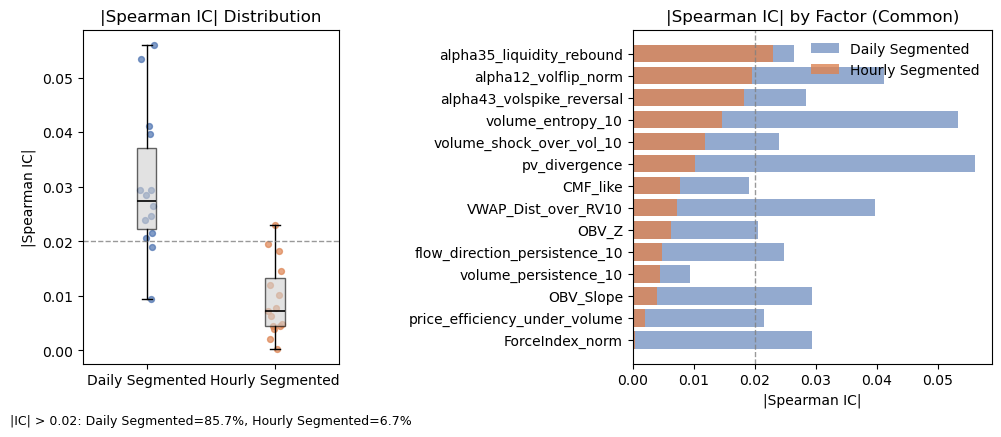

In [103]:
s_day = (corr_check(family="flow",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_hour = (corr_check(ticker = 'ic', frequency = 'minute', multiplier = 60, family="flow",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_day,s_hour, label1="Daily Segmented", label2="Hourly Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

**CSI 300 Index Futures**

target 1 period next return created


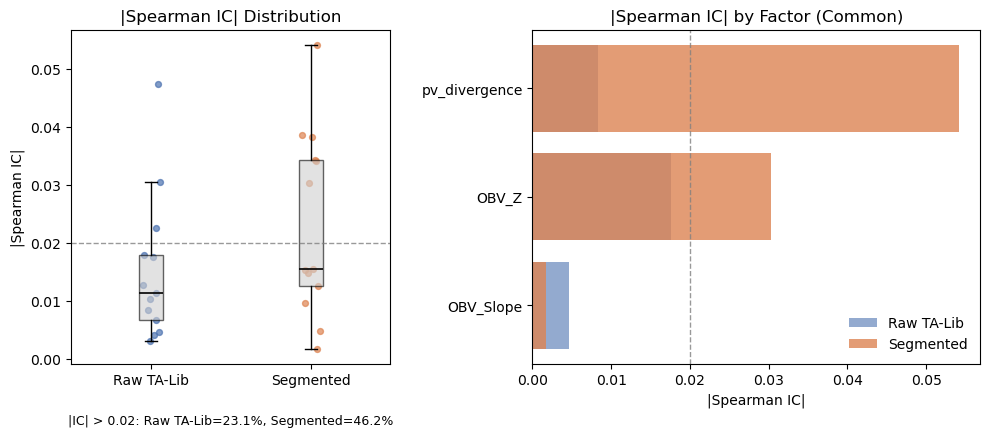

In [104]:
s_raw = (corr_check(ticker = 'if_main', family="flow",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'if_main', family="flow",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


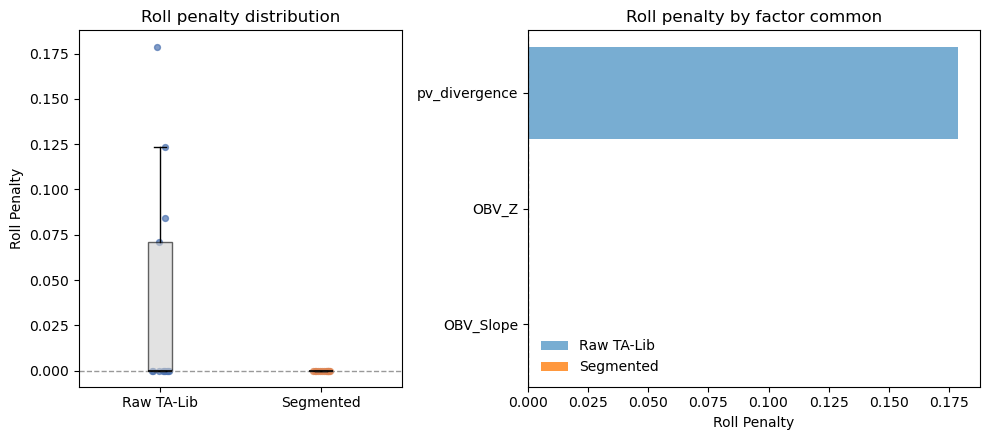

In [105]:
s_raw = (corr_check(ticker = 'if_main', family="flow",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'if_main', family="flow",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

For the CSI 300 and CSI 500 index futures, the results are broadly consistent. Price–volume factors exhibit solid Spearman performance, with approximately 40% of factors exceeding the threshold, while remaining cleaner than their TA-Lib counterparts (in given distribution), as evidenced by lower roll penalties. At the current stage, no material difference is observed between the roll-masked and non–roll-masked configurations.

在 沪深 300 与 中证 500 股指期货 上，整体表现结果具有一致性。量价类因子在 Spearman 指标上表现较为稳健，约 40% 的因子达到阈值水平，同时相较 TA-Lib 实现具有更低的 roll penalty，信号结构更为洁净 (in given distribution)。在当前测试范围内，roll mask 与 non-roll mask 设定之间尚未观察到显著差异

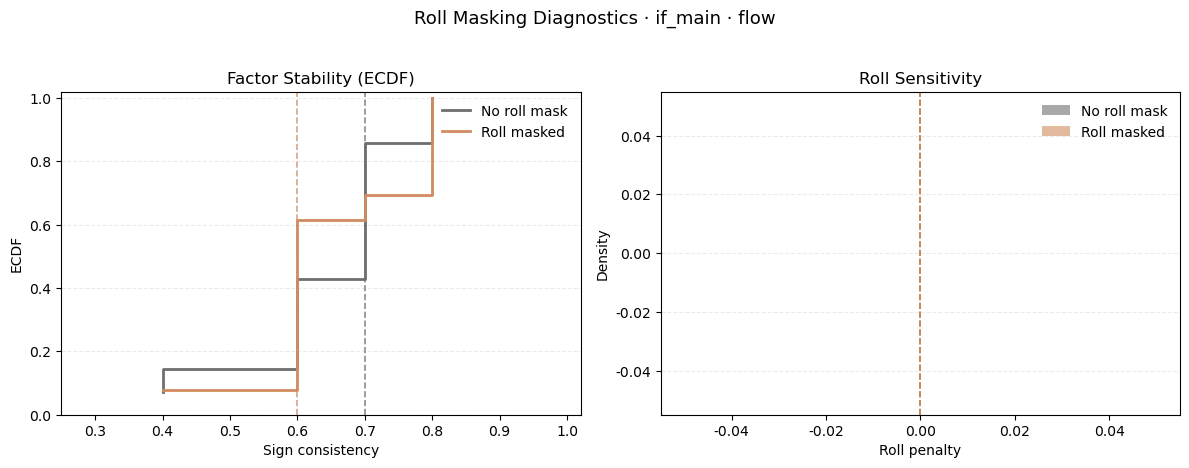

In [106]:
plot_roll_mask_diagnostics(ticker="if_main", family="flow", cls=treemodel_factors_augment)

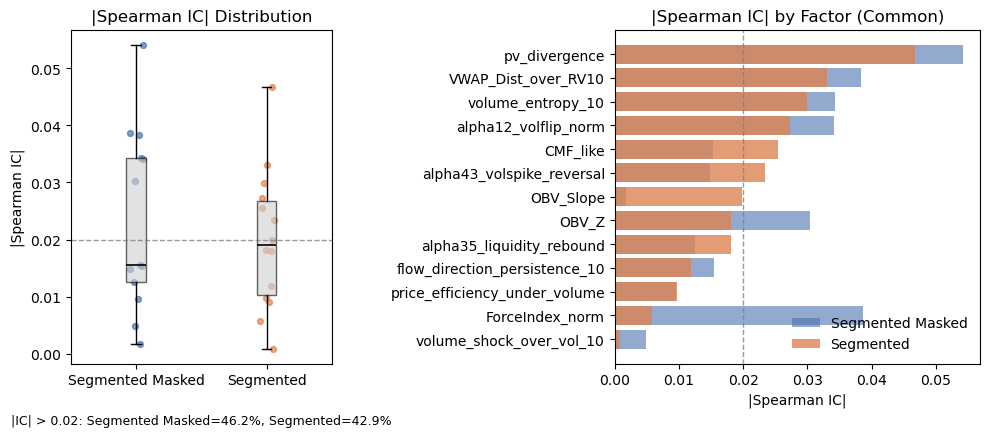

In [107]:
s_raw = (corr_check(ticker = 'if_main', family="flow",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'if_main', family="flow",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,mask = False)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Segmented Masked", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

**SSE 50 Index Futures**

In [108]:
corr_check(ticker = 'ih_main', family="flow",cls=treemodel_factors_daily,selection=False,light=False,verbose=True,)

[rolling_corr_report] slices=10, corr_thresh=0.9, pairs_reported=1 (presence ≥ 70%)
                                          Pair  freq  presence  mean_abs_corr  \
0  Force Index EMA / ATR — VWAP Distance / ATR     8       0.8       0.921948   

   max_abs_corr  n_slices  
0      0.936572        10  
target 1 period next return created
[coverage] kept 13/13 features (≥ 55%, n_eff ≥ 200); median coverage=99.15%, median n_eff=2322
Pearson Effective 69.23%
Spearman Effective 53.85%
Kendall Effective 38.46%
sign_consistency > 0.55 (all features, n=13): 84.62%
roll_penalty     > 0.10 (all features, n=13): 53.85%


pearson  spearman   kendall  effective_pct  \
Money_Flow_Index        -0.028152 -0.035652 -0.023796       1.000000   
MFI Momentum             0.004288  0.000980  0.000833       0.000000   
OBV                     -0.047035 -0.060056 -0.040723       1.000000   
Chaikin_Money_Flow      -0.045452 -0.028894 -0.019251       1.000000   
VWAP Distance / ATR     -0.020670 -0.038333 -0.025542       1.000000   
Force Index EMA / ATR   -0.054584 -0.041762 -0.029313       1.000000   
Volume / Range Ratio    -0.068933 -0.032101 -0.021966       1.000000   
VW Return               -0.030901 -0.014052 -0.009057       0.333333   
price_volume_corr_10bar -0.002644 -0.011959 -0.007981       0.000000   
volume_zscore_20bar      0.003501 -0.017605 -0.011350       0.333333   
pv_divergence           -0.034691  0.020059  0.013315       0.666667   
OBV_Slope                0.048701 -0.003391 -0.002607       0.333333   
OBV_Z                    0.014193 -0.001409 -0.000868       0.000000   

                         year_spearman_min  year_spearman_max  \
Money_Flow_Index                 -0.153828           0.016503   
MFI Momentum                     -0.087714           0.098095   
OBV                              -0.164816          -0.017306   
Chaikin_Money_Flow               -0.235349           0.071549   
VWAP Distance / ATR              -0.141407          -0.008780   
Force Index EMA / ATR            -0.164742          -0.000578   
Volume / Range Ratio             -0.148162           0.134746   
VW Return                        -0.128971           0.013258   
price_volume_corr_10bar          -0.103367           0.078223   
volume_zscore_20bar              -0.114146           0.155831   
pv_divergence                    -0.063604           0.112163   
OBV_Slope                        -0.085165           0.079536   
OBV_Z                            -0.067021           0.046381   

                         sign_consistency  roll_penalty  winsor_penalty  \
Money_Flow_Index                      0.8      0.440281        0.000051   
MFI Momentum                          0.6      0.000000        0.001872   
OBV                                   1.0      0.108554        0.000803   
Chaikin_Money_Flow                    0.7      0.000000        0.001584   
VWAP Distance / ATR                   1.0      0.388468        0.003364   
Force Index EMA / ATR                 1.0      0.067904        0.002166   
Volume / Range Ratio                  0.5      0.393360        0.000463   
VW Return                             0.9      0.277608        0.000000   
price_volume_corr_10bar               0.7      0.357051        0.000000   
volume_zscore_20bar                   0.8      0.000000        0.000000   
pv_divergence                         0.5      0.232482        0.000000   
OBV_Slope                             0.8      0.000000        0.000674   
OBV_Z                                 0.6      0.000000        0.000000   

                         decile_LS_signed  decile_long_return  \
Money_Flow_Index                 0.002731           -0.000650   
MFI Momentum                    -0.000485            0.000442   
OBV                              0.003244           -0.002395   
Chaikin_Money_Flow               0.002401           -0.000544   
VWAP Distance / ATR             -0.000145            0.000725   
Force Index EMA / ATR           -0.000509            0.000174   
Volume / Range Ratio             0.001755           -0.002184   
VW Return                        0.001647           -0.000805   
price_volume_corr_10bar         -0.000740           -0.000044   
volume_zscore_20bar             -0.000605            0.000133   
pv_divergence                    0.001331            0.000180   
OBV_Slope                       -0.001204           -0.000749   
OBV_Z                           -0.001269            0.000123   

                         decile_short_return       QSL  
Money_Flow_Index                    0.002081  0.416893  
MFI Momentum                  

For the SSE-50 index, the overall effectiveness of price–volume factors remains limited. Although the TA-Lib benchmark exhibits a certain degree of constructional redundancy and stronger roll-related influences, its Spearman performance is still, on average, higher than that of the current engineered version.

This outcome may be partially related to instrument-specific market structure characteristics. Indices such as the SSE 50 (IH) are dominated by large-cap, low-turnover constituents, with trading activity largely driven by institutional participation and passive allocation. In such settings, marginal changes in trading volume are more likely to reflect portfolio rebalancing or liquidity management needs than informative signals in short-term price discovery. As a result, the dynamic coupling between volume and price is inherently weaker, making price–volume relationships more prone to noise or regime dependence rather than stable, repeatable predictive behavior.

Under these conditions, we do not view further complex feature engineering of this factor family as cost-effective in the short term. Accordingly, price–volume factors are retained primarily as a benchmark and for ongoing monitoring, rather than being subjected to additional intensive development at this stage.

就 上证50的 而言，量价类因子的整体效益仍被认为相对有限。尽管 TA-Lib 对照组在构建方式上存在一定程度的冗余（repetition）以及更明显的换月相关驱动，其 Spearman 表现仍整体高于当前工程化版本。

这一现象可能部分源于标的自身的市场结构特征。以上证 50（IH）为代表的指数以大市值、低换手率成分股为主，交易行为更偏向于机构主导与被动配置，成交量的边际变化往往反映组合调仓或流动性管理需求，而非短期价格发现中的信息输入。在此类环境下，成交量与价格之间的动态耦合本身较弱，使传统量价关系更容易表现为噪声或阶段性有效，而难以形成稳定、可重复的预测结构。

在此背景下，我们认为在短期内继续对该类因子进行更复杂的特征工程改造，并不具备明显的性价比优势，因此暂不对量价因子展开进一步的深度 feature engineering，而是将其作为对照与持续监测对象保留在因子体系中。

target 1 period next return created


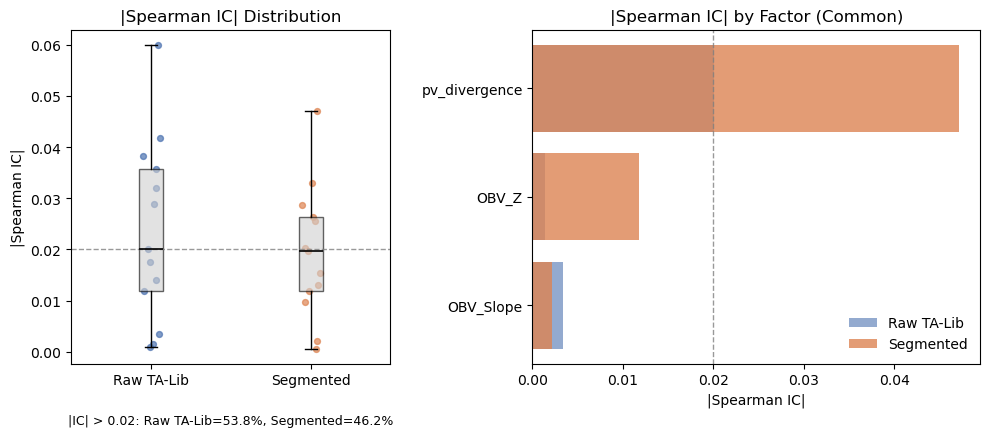

In [109]:
s_raw = (corr_check(ticker = 'ih_main', family="flow",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="flow",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


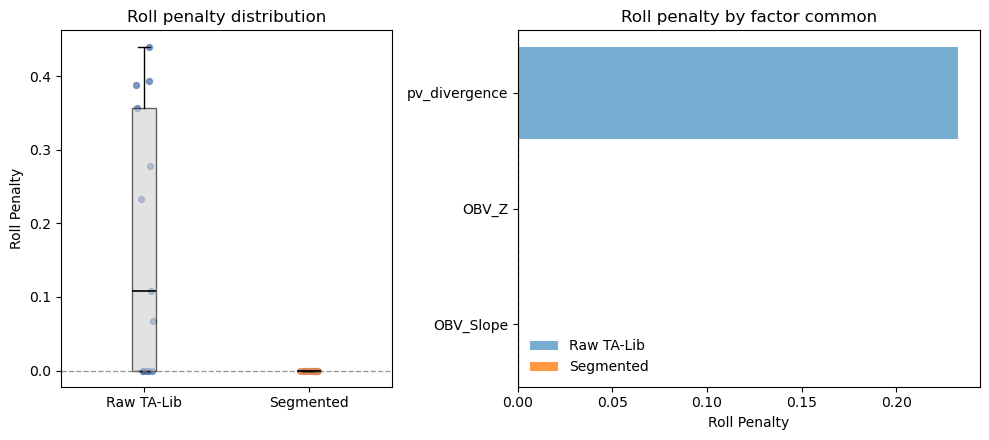

In [110]:
s_raw = (corr_check(ticker = 'ih_main', family="flow",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="flow",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

Across most evaluation windows, roll mask - retaining the first observation immediately following a contract rollover (t+1) is associated with improved stability metrics, as reflected in higher sign consistency and a more concentrated ECDF distribution. At the same time, under this configuration, the Spearman IC of some factors declines.

Importantly, this decline should not be interpreted as a straightforward deterioration in signal quality. Rather, it likely indicates that the higher rank correlations observed under more aggressive roll-adjacent sample exclusion are not robust once post-roll observations are reintroduced, suggesting sensitivity to rollover-transition dynamics. From this perspective, retaining the post-roll observation represents a trade-off: sacrificing peak rank correlation in exchange for a more conservative and stability-oriented assessment of factor performance.

Given that the current diagnostics remain limited in scope, we do not treat this observation as a definitive conclusion. For consistency with the robustness-oriented design philosophy adopted throughout this study, we retain the post-roll observation at the present stage, while leaving its precise impact to be further examined under expanded testing and alternative validation frameworks.

在大多数评估区间内，roll mask - 保留合约换月后的首个观测值（t+1） 在稳定性指标上表现更优，主要体现在符号一致性提升以及 ECDF 分布更为集中。然而，在该设定下，部分因子的 Spearman IC 出现下降。

需要强调的是，这一下降并不应被简单理解为信号质量的退化。相反，它更可能表明：在更为激进的换月邻近样本剔除条件下所观察到的较高秩相关，在重新纳入换月后观测时并不具备稳健性，暗示这些因子对换月过渡期动态存在一定敏感性。从这一角度看，保留换月后的首个观测值，是在牺牲峰值相关性的同时，换取更为保守、以稳定性为导向的因子评估结果。

鉴于当前诊断分析的覆盖范围仍然有限，我们并不将上述现象视为确定性结论。出于与全文一致的稳健性导向考虑，在现阶段我们选择保留换月后的首个观测值，并将其潜在影响留待在更充分的测试与替代验证框架下进一步评估。

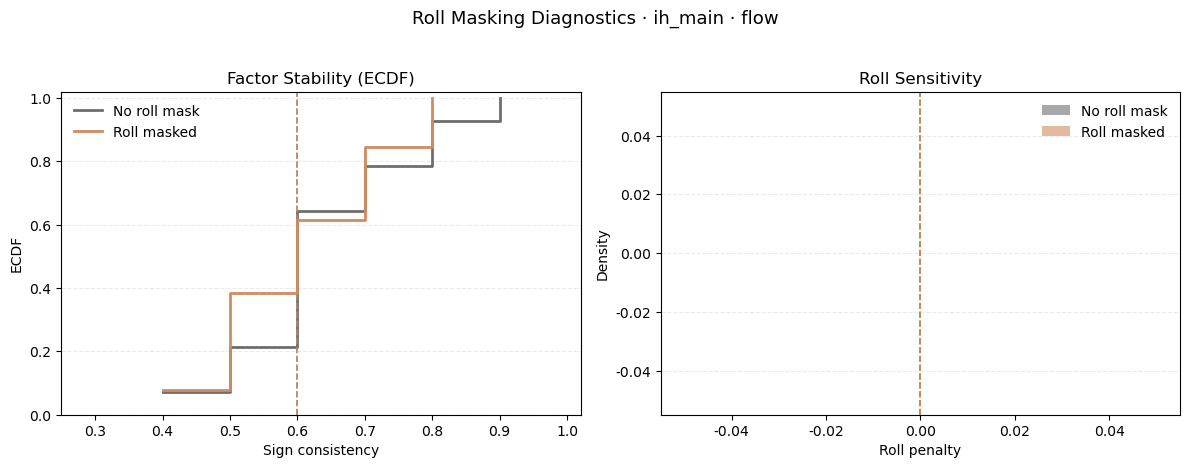

In [111]:
plot_roll_mask_diagnostics(ticker="ih_main", family="flow", cls=treemodel_factors_augment)

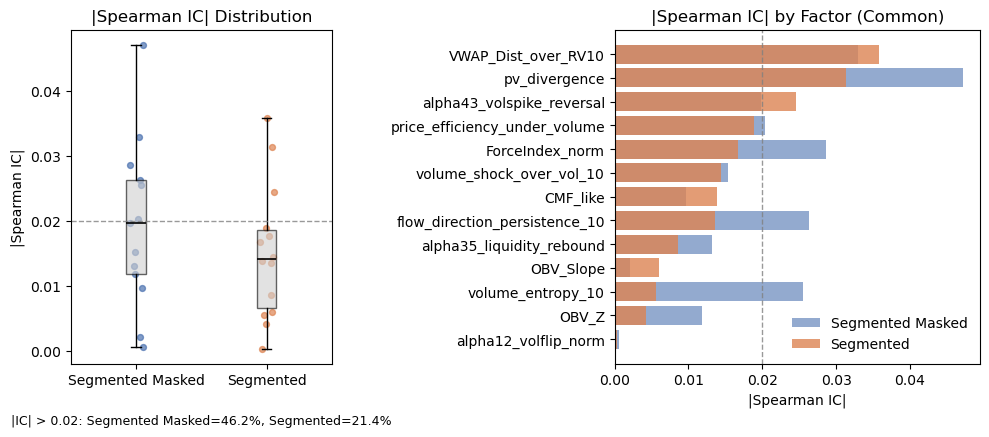

In [112]:
s_raw = (corr_check(ticker = 'ih_main', family="flow",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="flow",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,mask = False)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Segmented Masked", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

**Explicit Roll Modeling**

As mentioned earlier, we optionally introduce an explicit roll-effect modeling component, which is only activated when explicitly enabled. When this component is not in use, no roll-related features are constructed or passed to the model.

Although it is straightforward to engineer features that directly encode roll events, such as roll-day or roll-window indicators, this type of design can be methodologically risky in predictive modeling. Explicit event-based features may encourage models—particularly tree-based ensembles—to rely on calendar-driven shortcuts rather than economically meaningful market dynamics.

For this reason, when roll-effect modeling is enabled, we restrict the construction to post-roll state variables that describe how market microstructure conditions evolve following a roll, rather than exposing the roll event itself. This design preserves causality while providing a controlled and robust mechanism for handling roll-related structural effects

如前所述，本文在设计上提供了一种可选的换月效应建模机制，仅在显式启用的情况下才会生效；在未启用时，模型不会构造或使用任何与换月相关的特征。

尽管直接构造换月事件标记（如换月日或换月窗口）在实现上较为简单，但在预测建模中此类做法存在方法论风险。过于显式的事件型特征可能促使模型（尤其是基于树的集成模型）依赖日历结构性的捷径，而非具有经济含义的市场行为。

因此，在启用换月效应建模时，我们仅引入换月后的状态型特征，用于刻画市场在换月冲击后的调整过程，而不直接暴露换月事件本身，从而在保持因果性的同时提升模型的稳健性。

#### **Result**

In [113]:
from factors_robust import summarize_rp
from contract_utilities import compare_distributions

**Time Series Factor Significance**

To assess whether a factor exhibits a non-trivial association with future returns beyond pure noise, we compute a time-series significance diagnostic based on autocorrelation-adjusted correlation tests.

A key challenge in time-series inference is that observations are not independent. Financial factors and returns typically exhibit serial dependence, so treating the raw number of observations as independent samples leads to overstated statistical significance. To address this, we apply an effective sample size adjustment following Bartlett (1935) and Bretherton et al. (1999), originally developed in climate and geophysical statistics.

Specifically, for two time series 𝑥𝑡(factor) and yt(target), we estimate their lag-1 autocorrelations: px =corr(xt,xt−1), ρy =corr(yt,yt−1)

The effective number of independent observations is then approximated as: 𝑁*=𝑁⋅(1−𝜌𝑥𝜌𝑦)/1+𝜌𝑥𝜌𝑦， where N is the total number of time points. This adjustment reflects the reduced information content due to serial dependence.

Using 𝑁* in place of 𝑁, we compute a standard correlation t-statistic and associated p-value. No modification is made to the correlation estimator itself; only the degrees of freedom are adjusted.

This statistic is intended as a diagnostic sanity check rather than a definitive hypothesis test. It provides a quick way to identify factors that show consistent directional association with returns after accounting for basic time-series dependence.

However, several limitations must be emphasized:

The adjustment assumes approximately stationary AR(1)-type behavior. Financial time series often violate this assumption due to regime shifts, volatility clustering, and structural breaks.

Rank correlation and global autocorrelation estimates do not isolate deterministic calendar effects or contract roll dynamics, which may induce spurious significance.

The resulting p-values are approximate and should not be interpreted as formal evidence of economic predictability.

For these reasons, time-series factor significance is not used as a standalone selection criterion. Instead, it serves as a complementary diagnostic alongside segment-wise IC analysis, roll-robust evaluation, and out-of-sample model performance.

为评估某一因子是否在纯噪声之外与未来收益存在非平凡的关联性，我们构建了一个基于自相关修正的时间序列显著性诊断指标。

时间序列分析中的一个核心问题在于观测值通常并非相互独立。金融因子与收益序列普遍存在显著的序列相关性，若直接将样本点数量视为独立观测，往往会高估统计显著性。为此，我们采用了 Bartlett（1935）以及 Bretherton 等（1999） 提出的有效样本量（effective sample size）修正方法。该方法最初来源于气候科学与地球物理统计领域。

具体而言，对于因子序列 𝑥𝑡 与目标收益序列 𝑦𝑡 ，我们首先估计其一阶自相关系数：𝜌𝑥=corr(𝑥𝑡,𝑥𝑡−1),𝜌𝑦=corr(𝑦𝑡,𝑦𝑡−1) 随后，有效独立样本量近似为：𝑁* = 𝑁⋅(1−𝜌𝑥𝜌𝑦)/1+𝜌𝑥𝜌𝑦

其中 N 为原始时间序列长度。该修正用于刻画由于序列相关性导致的信息冗余，从而反映实际可用的信息量。

在计算统计显著性时，我们使用 𝑁* 替代原始样本量 N，并据此计算标准相关系数的 t 统计量及对应的 p 值。需要强调的是，该方法并未改变相关系数本身的估计方式，仅对自由度进行了调整。

该显著性指标的定位是诊断性（sanity check）工具，而非严格的假设检验。其主要作用在于快速识别在考虑基本时间序列依赖后，仍表现出方向性一致性的因子。

然而，该方法也存在明显局限性：

有效样本量修正隐含假设时间序列近似服从平稳的一阶自回归（AR(1)）过程，而金融时间序列往往存在制度切换、波动聚集及结构性突变等特征，难以完全满足该假设。

基于秩相关和全样本自相关的估计无法有效区分确定性的日历效应或期货合约换月行为，这些因素可能导致统计显著性的虚假抬升。

因此，所得 p 值仅为近似结果，不应被解读为因子具备明确经济预测能力的统计证据。基于上述原因，时间序列因子显著性并不作为单独的因子筛选标准，而是作为辅助诊断指标，与分段 IC 分析、换月鲁棒性检验以及样本外模型表现等结果结合使用。

**Roll Penalty calculation across families**

Before deployment, we conduct a comprehensive correlation and QSL-based diagnostic analysis across the full factor universe. The objective is to assess factor behavior under a unified, production-consistent preprocessing pipeline, rather than under isolated or family-specific test settings.

One observation that is unavoidable in this stage is that certain factors exhibit non-zero roll penalties when evaluated jointly, even if they appear roll-insensitive in single-family diagnostics. This outcome is not driven by missing-value artifacts or implementation inconsistencies, as missingness has already been neutralized through uniform forward- or zero-filling. Instead, it reflects intrinsic differences in factor responses once they are exposed to a shared, continuous data stream that includes contract rollover transitions.

Under realistic deployment constraints, models cannot selectively discard observations or apply factor-specific roll handling. As a result, cross-factor evaluation naturally reveals interactions and sensitivities that are suppressed in isolated tests. In this context, the appearance of roll-driven effects should be interpreted as a conservative, production-aligned diagnostic signal, rather than as evidence of construction flaws.

在正式部署之前，我们对全部因子统一进行相关性与 QSL 诊断分析，旨在评估其在生产一致的预处理流程下的整体行为，而非在因子类别相互隔离的测试设定中。

在这一阶段中，一个不可避免的现象是：部分因子在跨类别联合评估时会表现出非零的换月惩罚，即便它们在单一因子类别内部测试时看似对换月不敏感。需要强调的是，这一结果并非由缺失值处理或实现不一致所导致——缺失值已通过统一的前向填充或零填充得到处理；其根源在于因子在共享、连续的数据流（包含合约换月过渡）下所呈现出的内在响应差异。

在真实部署约束下，模型无法对不同因子采取差异化的样本剔除或换月处理策略，因此跨因子评估自然会暴露出在单一类别测试中被弱化的交互效应与敏感性。在这一语境下，换月驱动效应的出现应被理解为一种更为保守、也更贴近实际生产环境的诊断结果，而非因子构造本身存在缺陷的证据。

**CSI 500 Index Futures**

In [114]:
from scipy.stats import ks_2samp

In [115]:
# Mask True
ic_robust = treemodel_factors_augment(ticker = 'ic_main', verbose = True, target = 'ret1', frequency = 'day', augment = False, light = False, mask = True)
ic_robust.quick_evaluation()

[rolling_corr_report] slices=10, corr_thresh=0.9, pairs_reported=1 (presence ≥ 70%)
                                Pair  freq  presence  mean_abs_corr  \
0  LinReg_Residual_Z_5 — mr_inst_z_S    10       1.0       0.933488   

   max_abs_corr  n_slices  
0      0.949177        10  


In [116]:
# Mask = False 
ic_robust = treemodel_factors_augment(ticker = 'ic_main', verbose = True, target = 'ret1', frequency = 'day', augment = False, light = False, mask = False)
ic_robust.quick_evaluation()

[rolling_corr_report] Pairs exist but none met presence ≥ 70%. (corr_thresh=0.9, n_slices=10)


For the CSI 500 index, we do not observe significant factor redundancy within the engineered factor library. Here, factor redundancy is defined as factor pairs exhibiting correlations of 0.9 or higher across seven rolling windows.

在 中证 500 指数上，基于工程化因子库的分析中，未观察到显著的因子重复性现象 (mask 的情况下 仅有 LinReg_Residual_Z_5 — mr_inst_z_S5）。其中，因子重复性被定义为：在 7 个滚动窗口中，因子间相关系数达到或超过 0.9。

In [117]:
rp_A = corr_check(ticker = 'ic_main',family="all",cls=treemodel_factors_daily, selection=False,light=False, verbose=False, mask = False)['roll_penalty'].dropna()
rp_B = corr_check(ticker = 'ic_main',family="all",cls=treemodel_factors_augment, selection=False,light=False, verbose=False, mask = False)['roll_penalty'].dropna()
rp_C = corr_check(ticker = 'ic_main',family="all",cls=treemodel_factors_augment, selection=False,light=False, verbose=False, mask = True)['roll_penalty'].dropna()
rp_D = corr_check(ticker = 'ic_main',family="all",cls=treemodel_factors_augment_loose, selection=False,light=False, verbose=False, mask = True)['roll_penalty'].dropna()

target 1 period next return created
target 1 period next return created


In the production environment, we observe a consistent pattern. Within the engineered factor library, approximately 60% of the factors exhibit roll penalties below 0.2, indicating limited sensitivity to contract roll effects. Moreover, the distribution shows that around half of the factors have roll penalties close to zero, suggesting that their predictive behavior is largely not driven by roll-related effects.

在生产环境的统计结果中，我们同样观察到类似的结论：在工程化因子库中，约 60% 的因子其 roll penalty 低于 0.2，表明多数因子对换月结构并不敏感。此外，从分布特征来看，约一半的因子在 roll penalty 指标上接近于 0，说明这些因子的有效性并非主要由换月效应所驱动。

In [118]:
pd.DataFrame({"Raw Ta-Lib": summarize_rp(rp_A), "Segment Unmasked": summarize_rp(rp_B),"Segment": summarize_rp(rp_B), "Segment Loose": summarize_rp(rp_D)})

Raw Ta-Lib  Segment Unmasked     Segment  Segment Loose
n              94.000000        123.000000  123.000000     166.000000
mean            0.364772          0.184749    0.184749       0.200295
median          0.230209          0.000000    0.000000       0.024517
p75             0.674671          0.294409    0.294409       0.361808
p90             0.960035          0.602373    0.602373       0.647620
p95             1.000000          0.756756    0.756756       0.794150
p99             1.000000          0.998423    0.998423       0.926831
pct_eq_0        0.351064          0.520325    0.520325       0.487952
pct_lt_0.10     0.404255          0.609756    0.609756       0.572289
pct_lt_0.20+    0.521277          0.325203    0.325203       0.367470

A two-sample Kolmogorov–Smirnov test confirms that the two distributions differ significantly (p < 0.01)

Kolmogorov–Smirnov 检验进一步表明，两者的 roll penalty 分布存在显著差异（p < 0.01）

In [119]:
ks_2samp(rp_A.values, rp_B.values)

KstestResult(statistic=np.float64(0.26171942570489537), pvalue=np.float64(0.001031641666716231), statistic_location=np.float64(0.348591266208856), statistic_sign=np.int8(-1))

We conduct a final statistical evaluation of the engineered factor library, using Spearman rank correlation as the primary metric and Pearson correlation as a secondary reference. Overall, the magnitude of single-factor ICs is relatively conservative, which is consistent with the strict constraints imposed during factor construction on causality, contract-roll structure, and time-series segmentation, and aligns with robustness requirements in a production setting.

Despite the modest scale of individual ICs, the engineered factor library exhibits strong structural robustness. All 123 factors satisfy coverage requirements, with a median effective sample size exceeding 2,300 observations; approximately 75% of the factors demonstrate stable directional consistency. Meanwhile, only about 39% of the factors exhibit a roll penalty greater than 0.10 (a result related to necessary engineering treatments such as fill-forward in production), indicating that the majority of signals are not primarily driven by contract-roll mechanics.

It should be emphasized that the AR(1)-adjusted Spearman significance test is employed mainly as a diagnostic screening tool rather than as a guarantee of strict statistical significance. In financial time series characterized by strong autocorrelation and state dependence, such approximate adjustments remain inherently limited, and their results should be interpreted jointly with distributional properties and engineering constraints.

We do not present a direct distributional visualization comparison with the original TA-Lib factor set. This factor library originates from a legacy pipeline developed by an outsourced team, in which causality, time segmentation, and roll-structure constraints were not systematically enforced (although known time-leakage issues have been mitigated to the extent possible by our team). As a result, a non-trivial subset of these factors is statistically sensitive to mechanical roll effects, making direct IC distribution comparisons potentially misleading.

Nevertheless, the accompanying distributional comparison reveals a consistent structural pattern: the Spearman distribution of the engineered factor library is more concentrated and slightly right-shifted in the central region, with a higher median and a more symmetric profile.

At the same time, in the right-tail region (i.e., extreme high-IC values), the engineered factors do not exhibit heavier tails; instead, the distribution shows noticeable contraction. This indicates that, by reducing randomness and structural bias, the engineering process deliberately sacrifices a portion of sample-specific extreme performance in favor of stability and reproducibility.

我们对工程化因子库进行了最终的统计评估，以 Spearman 等级相关作为主要指标，并辅以 Pearson 相关作为参考。整体来看，单因子 IC 的数值幅度相对保守，这一结果与因子在构造过程中对因果性、换月结构以及时间序列分段所施加的严格约束是一致的，也符合生产环境下对稳健性与可复现性的预期。

尽管单因子 IC 规模有限，工程化因子库在结构层面表现出较强的稳健性特征：在 123 个因子中，所有因子均满足覆盖率要求，中位有效样本规模超过 2300；约 75% 的因子在方向一致性指标上表现稳定。同时，仅有约 39% 的因子其 roll penalty 高于 0.10（该结果与生产环境中 fillna 等工程化处理方式相关），表明大多数信号并非主要由合约换月机制所驱动。

需要指出的是，本文采用的 AR(1) 调整后的 Spearman 显著性检验主要用于诊断性筛选，而非作为严格的统计显著性保证。在具有强自相关与状态依赖特征的金融时间序列中，此类近似调整方法本身仍存在局限，其结果应结合整体分布形态与工程约束一并理解。

本文未对原始 TA-Lib 因子体系进行直接的分布可视化比较。该因子库来源于外包团队的历史管线，其构造过程未系统性地约束因果性、时间分段与换月结构（尽管相关的时间泄露问题已由我们团队尽可能修复），因此其中相当一部分因子在统计上容易受到换月机制的机械性影响。在这一背景下，直接的 IC 分布对比可能具有一定的误导性。

尽管如此，在附带的分布比较中仍可以观察到一个一致的结构性特征：工程化因子库的 Spearman 分布在中部区域整体更为集中且略向右移，中位数水平更高，呈现出更集中、对称的分布形态。

与此同时，在分布的右尾区域（即极端高 IC 区间），工程化因子库并未表现出更高的尾部概率，反而呈现出一定程度的收敛。这一现象表明，工程化设计在降低偶然性与结构性偏置的同时，也主动放弃了部分由特殊样本或局部结构驱动的极端表现。

Visualization of highly correlated variables (threshold=0.9)
By Default Past 90 Percent will be the Train + Validation Set. No analysis will be performed on the last 10 Percent


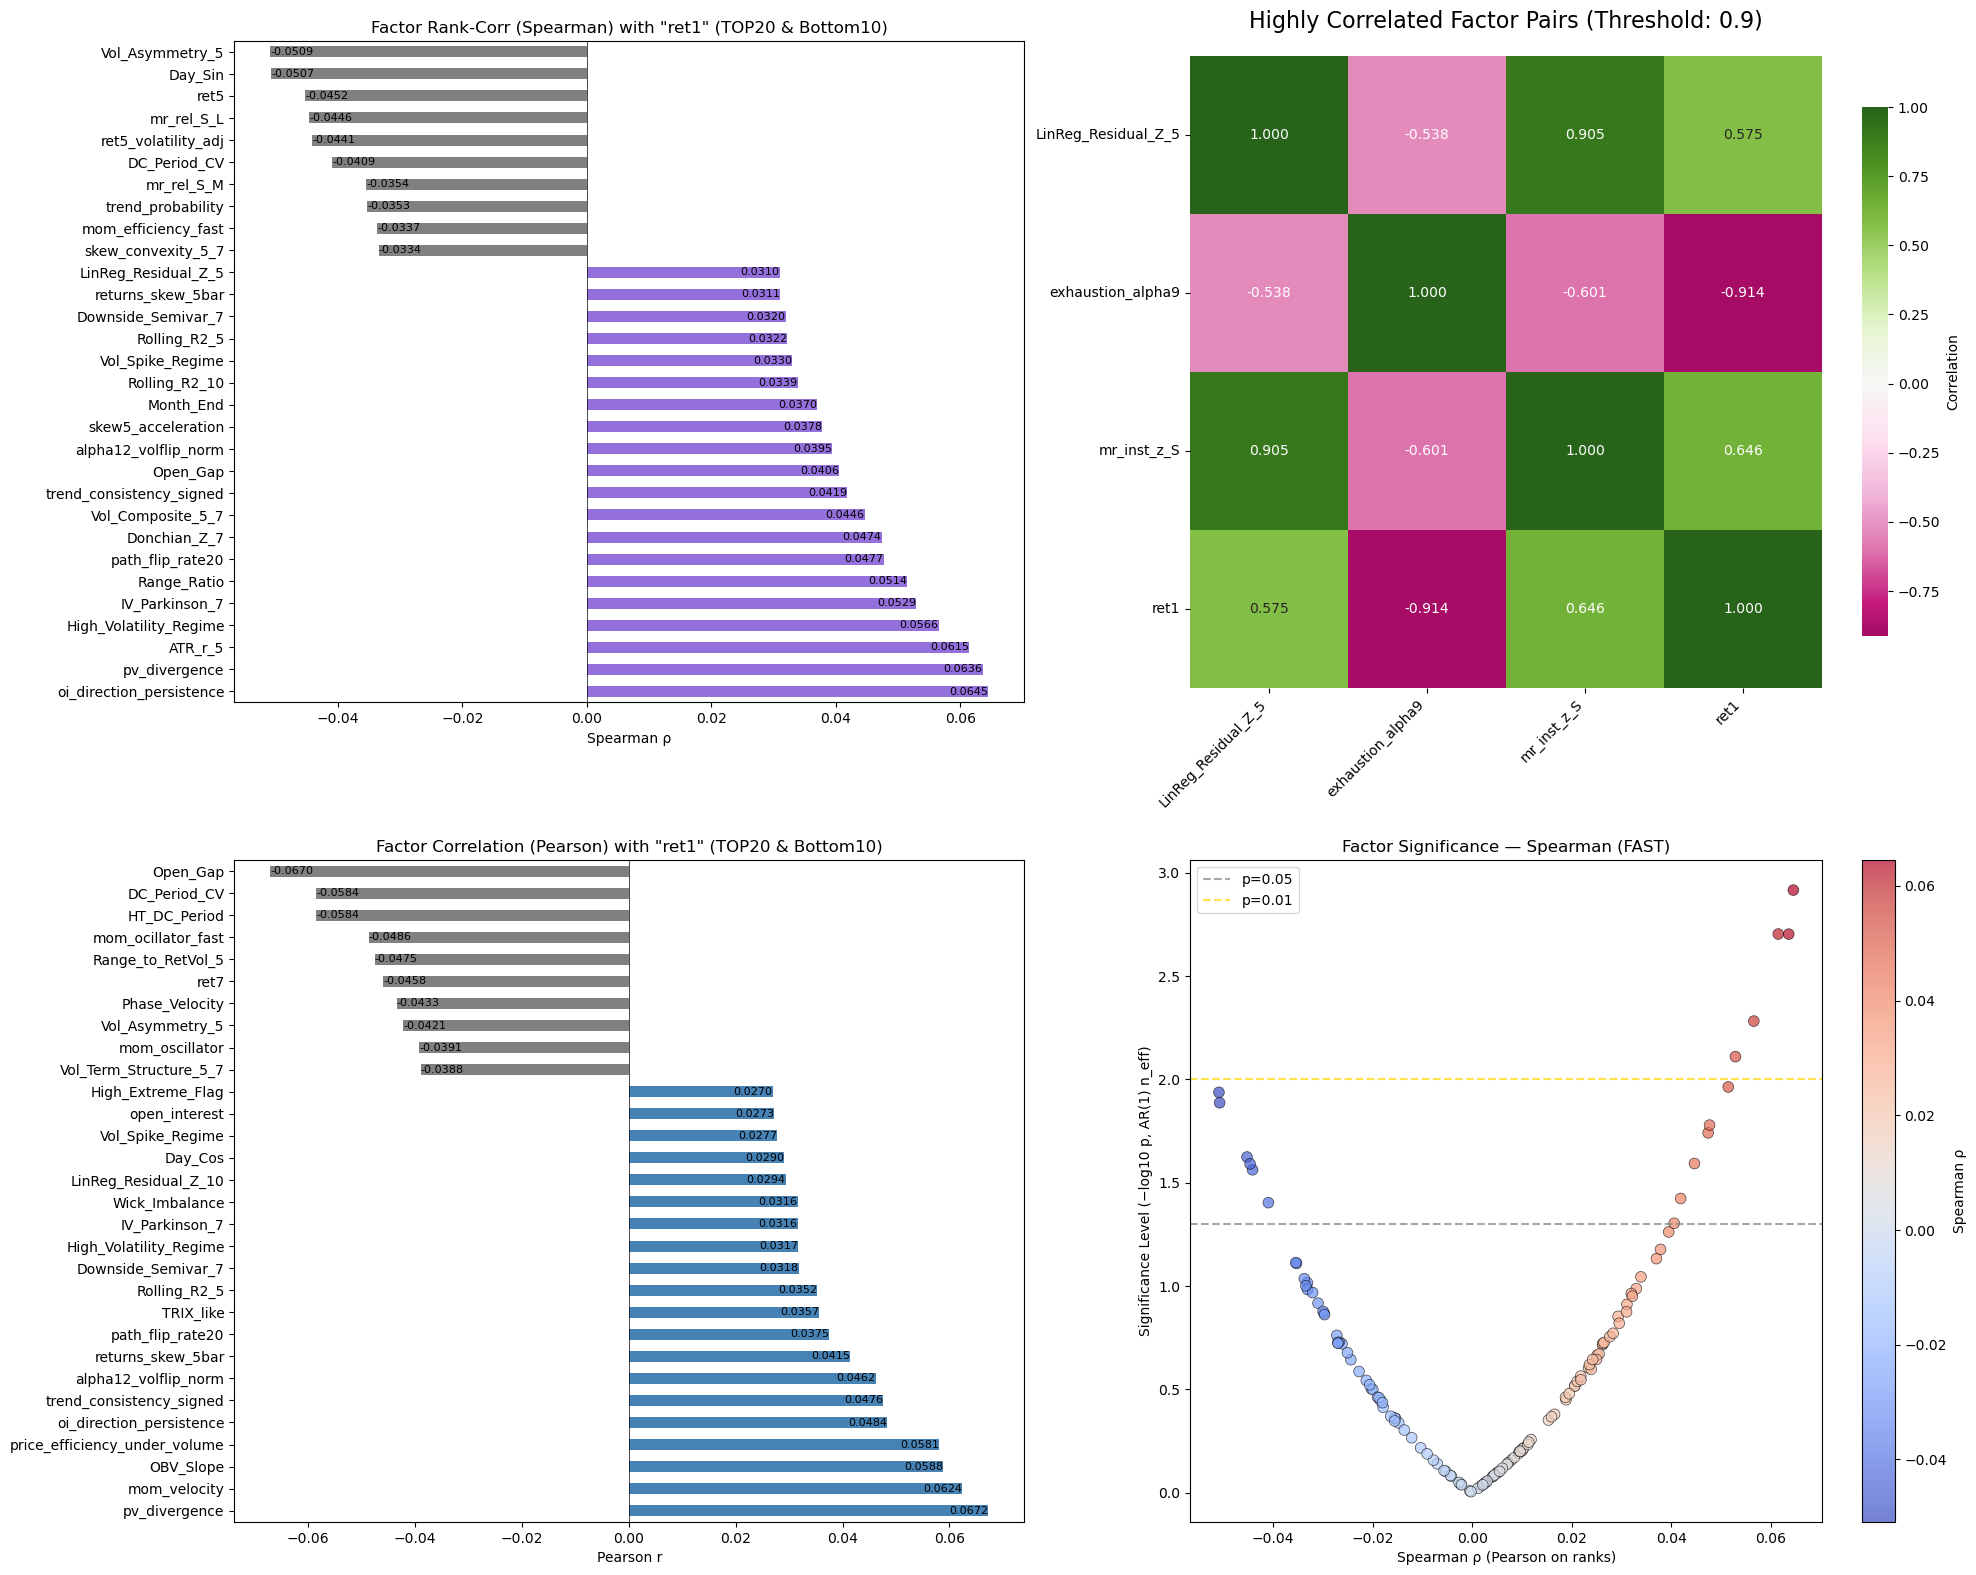


=== Report (Spearman primary / Pearson secondary) ===
 Spearman Average ρ: 0.003584
 Max Spearman ρ: 0.064496 (oi_direction_persistence)
 Min Spearman ρ: -0.050875 (Vol_Asymmetry_5)
 Pearson Average r: 0.001686
 Max Pearson r: 0.067249 (pv_divergence)
 Min Pearson r: -0.067005 (Open_Gap)
Number of highly correlated pairs (|r|>0.9): 2
 Spearman (AR1 on ranks): p<0.01 5 (4.0%), p<0.05 17 (13.6%), p<0.20 49 (39.2%)
 Pearson (AR1 adj):       p<0.01 7 (5.6%), p<0.05 16 (12.8%), p<0.20 37 (29.6%)
factors created 123

Significant features by Spearman (FAST, q<0.20):
  (49): Vol_Composite_5_7, ATR_r_5, Range_CV_5, Donchian_Z_7, Vol_of_Vol_7, Vol_Spike_Regime, High_Volatility_Regime, Vol_Asymmetry_5, Downside_Semivar_7, Realized_Quarticity_5, DC_Period_CV, HT_TREND_MODE, Phase_Sin, Phase_Velocity, ret5, mom5_unexpected, ret5_volatility_adj, path_flip_rate20, mom_oscillator, trend_probability, TRIX_like, mom_efficiency_fast, Day_Sin, Day_Cos, Month_End, returns_skew_5bar, skew5_acceleration, sk

In [120]:
feature_stable = corr_check(ticker = 'ic_main',family="all",cls=treemodel_factors_augment, selection=False,light=False, verbose=True, mask = False)

In [121]:
# comparison group 
feature_stable2 = corr_check(ticker = 'ic_main',family="all",cls=treemodel_factors_daily, selection=False,light=False, verbose= False, mask = False)

target 1 period next return created


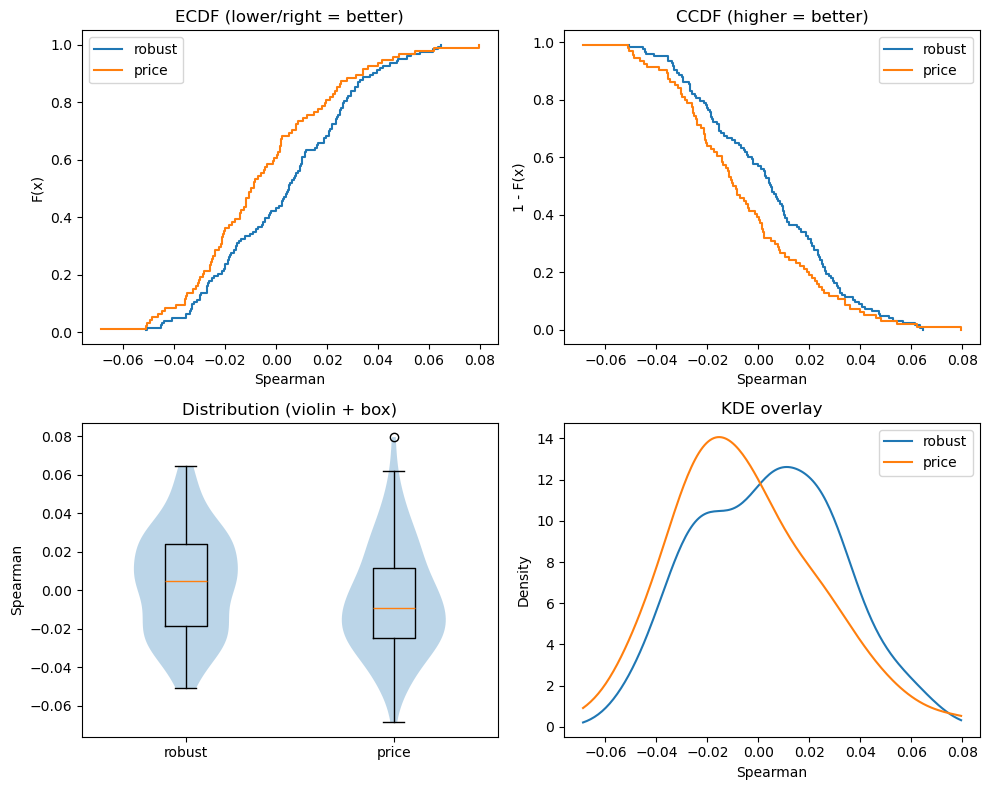

--- Summary ---
robust    n= 123  median=0.0050  IQR=(-0.0186,0.0241)  p5/p95=(-0.0354,0.0476)
price     n=  94  median=-0.0093  IQR=(-0.0251,0.0116)  p5/p95=(-0.0472,0.0430)

KS two-sample: stat=0.234, p=0.00472
Unpaired (Mann–Whitney U): stat=6938.0, p=0.0116
Cliff's δ: 0.200  (≈0.147 small, 0.33 medium, 0.474 large)


In [122]:
compare_distributions(feature_stable['spearman'] ,feature_stable2['spearman'], labels=('robust','price'), metric_name='Spearman')

| Component / Test                                | What it measures                    | When it is used                       | Key assumption              | How to interpret                                                                                        |
| ----------------------------------------------- | ----------------------------------- | ------------------------------------- | --------------------------- | ------------------------------------------------------------------------------------------------------- |
| ECDF (Empirical CDF)                        | Full cumulative distribution        | Always                                | None (non-parametric)       | Curve further right / lower ⇒ generally larger values. Visual check for stochastic dominance.       |
| CCDF (1 − CDF)                              | Upper-tail probability              | Always                                | None                        | Higher curve ⇒ higher probability of large values. Useful for tail behavior.                            |
| Kolmogorov–Smirnov (KS) test                | Maximum difference between two CDFs | Always                                | Continuous distributions    | Tests **entire distribution equality**, not just mean/median. Small p ⇒ distributions differ somewhere. |
| Wilcoxon signed-rank test                   | Median difference of paired samples | When data are paired (`aa.align(bb)`) | Symmetric differences       | Small p ⇒ systematic shift between paired observations.                                                 |
| Median shift (paired)                       | Direction & size of shift           | With Wilcoxon                         | None                        | Positive ⇒ `labels[0]` dominates `labels[1]` in median sense.                                           |
| Mann–Whitney U test                         | Stochastic dominance                | When unpaired                         | Similar distribution shapes | Small p ⇒ one distribution tends to produce larger values.                                              |
| Cliff’s Delta (δ)                           | Effect size (non-parametric)        | With Mann–Whitney                     | None                        | δ ≈ 0.15 small, 0.33 medium, 0.47 large effect size.                                                    |

**CSI 300 Index Futures**

In [123]:
# Mask True
if_robust = treemodel_factors_augment(ticker = 'if_main', verbose = True, target = 'ret1', frequency = 'day', augment = False, light = False, mask = True)
if_robust.quick_evaluation()

[rolling_corr_report] slices=10, corr_thresh=0.9, pairs_reported=2 (presence ≥ 70%)
                                Pair  freq  presence  mean_abs_corr  \
0  LinReg_Residual_Z_5 — mr_inst_z_S    10       1.0       0.941512   
1           exhaustion_alpha9 — ret1     7       0.7       0.962436   

   max_abs_corr  n_slices  
0      0.955150        10  
1      0.994198        10  


In [124]:
# Mask = False 
if_robust = treemodel_factors_augment(ticker = 'if_main', verbose = True, target = 'ret1', frequency = 'day', augment = False, light = False, mask = False)
if_robust.quick_evaluation()

[rolling_corr_report] slices=10, corr_thresh=0.9, pairs_reported=1 (presence ≥ 70%)
                       Pair  freq  presence  mean_abs_corr  max_abs_corr  \
0  exhaustion_alpha9 — ret1     7       0.7       0.956729      0.994768   

   n_slices  
0        10  


For the CSI 300 index futures, the engineered factor library exhibits only one to two highly correlated factor pairs under a rolling-window analysis (defined as absolute correlation above 0.9 in at least 70% of 10 rolling slices).

These redundant pairs were explicitly identified during the diagnostic stage and subsequently removed in the modeling pipeline via feature de-duplication and selection procedures. As a result, such localized redundancy does not materially affect downstream model construction or evaluation.

在沪深 300 指数期货样本上，工程化因子库中仅检测到 1–2 组在滚动窗口下高度相关的因子对（定义为在 10 个滚动切片中相关系数绝对值超过 0.9，且出现比例不低于 70%）。
相关因子对已在诊断阶段被完整记录，并在后续建模过程中通过显式去重与特征筛选机制予以剔除，因此该类局部重复性对最终模型构建与评估结果不构成实质性影响。

In [125]:
rp_A = corr_check(ticker = 'if_main',family="all",cls=treemodel_factors_daily, selection=False,light=False, verbose=False, mask = False)['roll_penalty'].dropna()
rp_B = corr_check(ticker = 'if_main',family="all",cls=treemodel_factors_augment, selection=False,light=False, verbose=False, mask = False)['roll_penalty'].dropna()
rp_C = corr_check(ticker = 'if_main',family="all",cls=treemodel_factors_augment, selection=False,light=False, verbose=False, mask = True)['roll_penalty'].dropna()
rp_D = corr_check(ticker = 'if_main',family="all",cls=treemodel_factors_augment_loose, selection=False,light=False, verbose=False, mask = True)['roll_penalty'].dropna()

target 1 period next return created
target 1 period next return created


From the statistical results on the CSI 300 (IF) index futures, it can be observed that this contract exhibits a structurally milder roll effect compared with the CSI 500. As a result, the roll-penalty distribution of the raw TA-Lib factor set is already relatively concentrated.

Nevertheless, even within the IF sample, the engineered factor library demonstrates a structural improvement that is consistent with observations on other instruments. Relative to the raw version, both the mean and upper quantiles of roll penalty are materially reduced, and more than 70% of the factors exhibit roll penalties below 0.10. This indicates that the stability gains introduced by the engineering process are not merely driven by market-specific characteristics, but instead persist across environments with differing roll dynamics.

从沪深 300（IF）指数期货的统计结果可以看出，该品种本身的合约换月效应相较于中证 500 更为温和，原始 TA-Lib 因子在 roll penalty 指标上整体分布已较为集中。

尽管如此，在 IF 样本上，工程化因子库仍然表现出与其他标的一致的结构性改进：相较于原始版本，其 roll penalty 的均值与高分位显著下降，且约 70% 以上的因子 roll penalty 低于 0.10。这表明工程化处理所带来的稳定性提升并非仅由市场结构差异驱动，而是在不同换月特征环境下均具备一致效果。

In [126]:
pd.DataFrame({"Raw Ta-Lib": summarize_rp(rp_A), "Segment Unmasked": summarize_rp(rp_B),"Segment": summarize_rp(rp_B), "Segment Loose": summarize_rp(rp_D)})

Raw Ta-Lib  Segment Unmasked     Segment  Segment Loose
n              94.000000        123.000000  123.000000     166.000000
mean            0.159472          0.094812    0.094812       0.116120
median          0.010566          0.000000    0.000000       0.000000
p75             0.264693          0.128081    0.128081       0.197929
p90             0.525947          0.356979    0.356979       0.368838
p95             0.604657          0.492504    0.492504       0.522475
p99             0.695788          0.586814    0.586814       0.689542
pct_eq_0        0.489362          0.626016    0.626016       0.578313
pct_lt_0.10     0.563830          0.731707    0.731707       0.650602
pct_lt_0.20+    0.319149          0.186992    0.186992       0.246988

In [127]:
ks_2samp(rp_A.values, rp_B.values)

KstestResult(statistic=np.float64(0.17349939456841376), pvalue=np.float64(0.06978371761513154), statistic_location=np.float64(0.11080309462365157), statistic_sign=np.int8(-1))

On the CSI 300 (IF) index futures, the engineered factor library exhibits systematically weaker single-factor predictive strength. Both Spearman and Pearson correlations show low average magnitudes, and the proportion of statistically significant factors under AR(1)-adjusted diagnostics is materially lower than that observed for CSI 500 and other contracts.

This outcome is structurally reasonable and expected. Compared with CSI 500, CSI 300 features higher institutional participation, stronger macro and policy anchoring, and a more efficient liquidity structure. Under such conditions, purely price- and volume-based technical factors inherently carry limited marginal information, regardless of how carefully they are constructed.

From a diagnostic perspective, the engineered factor set on IF does not exhibit a dominant trend-following or mean-reversion regime. The IC distribution remains tightly centered around zero, and robustness metrics such as sign consistency and Kendall correlation do not indicate a clear structural bias. This suggests that the weak signal is not driven by roll effects or time leakage, but rather reflects the information structure of the underlying market.

Together with earlier roll-penalty statistics—showing that most factors are not materially driven by contract roll—these results indicate that engineering constraints did not suppress signal quality. Instead, they reveal the natural ceiling of purely technical factors on CSI 300.

Based on these findings, further performance improvement on IF is more likely to come from macro, cross-asset, or institutional-state augmentations, rather than continued expansion of the technical factor space. Within such a framework, the engineered factors are better positioned as state descriptors or conditional filters, complementing external sources of information.

在沪深 300（IF）指数期货样本上，工程化因子库整体呈现出较弱的单因子预测能力。从统计结果可以看到，无论是 Spearman 还是 Pearson 相关，其均值与显著性水平均明显低于在中证 500（IC）等标的上的表现，通过 AR(1) 调整后的显著因子占比亦处于相对较低水平。

这一结果在结构上是合理且符合预期的。与中证 500 相比，沪深 300 具有更高的机构参与度、更强的宏观与政策约束，以及更成熟的流动性结构。在此背景下，单纯基于价格与成交行为的技术型因子，无论其构造是否稳健，其可解释的边际信息本身即较为有限。

从诊断角度看，当前工程化因子库在 IF 上并未呈现出明确的趋势型或均值回复型主导结构：
一方面，整体 IC 分布集中于零附近，缺乏稳定的单向偏移；另一方面，方向一致性与 Kendall 等稳健性指标亦未显示出强烈的结构性偏好。这表明信号弱化并非由换月效应或时间泄露所致，而更可能反映了标的本身的信息结构特征。

结合此前 roll penalty 的统计结果（多数因子对换月结构并不敏感），可以进一步确认：在 IF 上，工程化处理并未系统性削弱信号，而是揭示了纯技术因子在该品种上的天然上限。

基于上述观察，后续在沪深 300（IF）上的性能提升，更有必要通过引入宏观、跨资产或制度性状态变量进行增强，而非继续单纯扩展技术型特征空间。工程化因子在此框架下更适合作为状态刻画与条件过滤器，与外生信息协同发挥作用。

Visualization of highly correlated variables (threshold=0.9)
By Default Past 90 Percent will be the Train + Validation Set. No analysis will be performed on the last 10 Percent


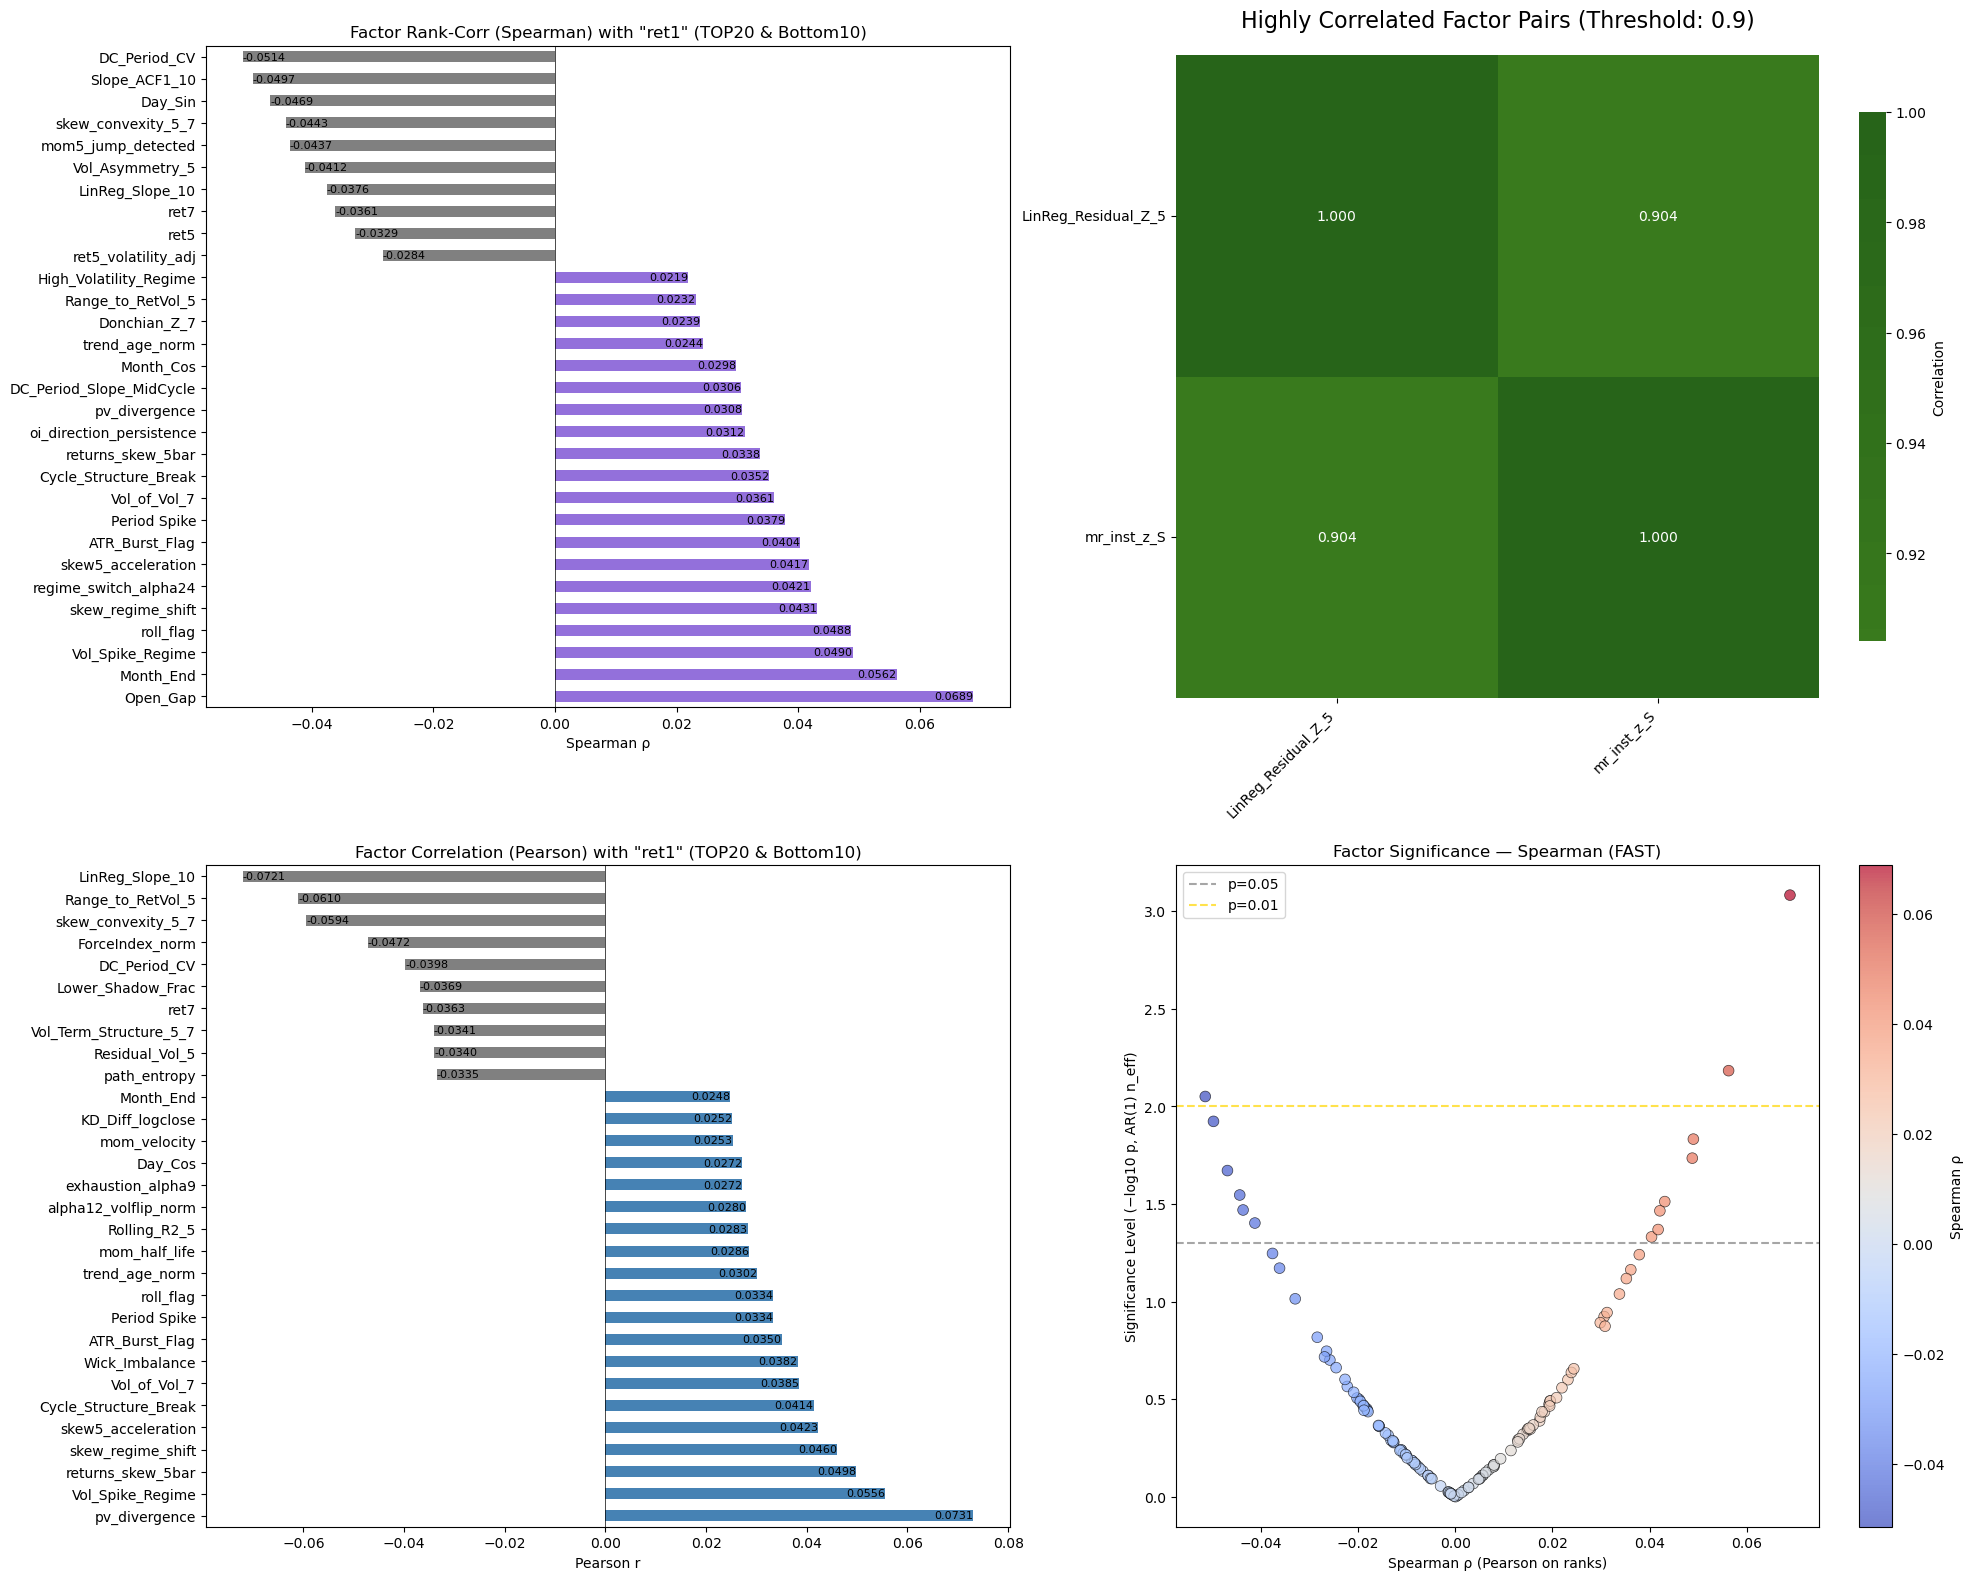


=== Report (Spearman primary / Pearson secondary) ===
 Spearman Average ρ: 0.000637
 Max Spearman ρ: 0.068867 (Open_Gap)
 Min Spearman ρ: -0.051434 (DC_Period_CV)
 Pearson Average r: 0.000145
 Max Pearson r: 0.073098 (pv_divergence)
 Min Pearson r: -0.072105 (LinReg_Slope_10)
Number of highly correlated pairs (|r|>0.9): 1
 Spearman (AR1 on ranks): p<0.01 3 (2.4%), p<0.05 14 (11.2%), p<0.20 29 (23.2%)
 Pearson (AR1 adj):       p<0.01 5 (4.0%), p<0.05 10 (8.0%), p<0.20 34 (27.2%)
factors created 123

Significant features by Spearman (FAST, q<0.20):
  (29): roll_flag, BB_%B_Pos_r_7, Vol_of_Vol_7, Vol_Spike_Regime, ATR_Burst_Flag, Vol_Asymmetry_5, DC_Period_CV, Cycle_Structure_Break, DC_Period_Slope_MidCycle, Period Spike, ret5, ret7, ret5_volatility_adj, mom5_jump_detected, RSI_14_Log_Spaced, Day_Sin, Month_Cos, Month_End, returns_skew_5bar, skew5_acceleration, skew_convexity_5_7, skew_regime_shift, oi_direction_persistence, regime_switch_alpha24, pv_divergence, LinReg_Slope_10, Slope_AC

In [128]:
feature_stable = corr_check(ticker = 'if_main',family="all",cls=treemodel_factors_augment, selection=False,light=False, verbose=True, mask = False)

From the comparison of Spearman IC distributions, the engineered factor library exhibits a more favorable overall structure relative to the price-based (raw / outsourced) factor set:

The median of the distribution is consistently higher, indicating a mild but systematic upward shift;

The left tail (negative IC region) is substantially compressed, with a marked reduction in extreme negative correlations;

In the mid-to-high IC range, the CCDF of the engineered factors clearly dominates, reflecting a higher probability mass in the positive tail.

These observations suggest that, for the CSI 300 instrument, the engineering process does not merely flatten the signal distribution. Instead, by mitigating structural noise and incidental biases, it selectively preserves—and in certain regions enhances—statistically meaningful positive signal behavior, leading to a more robust and practically deployable factor set.

从 Spearman 分布对比来看，工程化因子库相较于价格型（原始 / 外包）因子库在整体结构上呈现出更为有利的分布特征：

分布中位数整体更高，表现出轻微但一致的上移；

左尾（负 IC 区间）明显收敛，极端负相关因子的占比显著降低；

在中高 IC 区间内，工程化因子库的 CCDF 明显占优，对应右尾概率更高。

上述结果表明，在沪深相关标的上，工程化设计并未简单地压缩信号分布，而是在抑制结构性噪声与偶然性偏置的同时，更有选择性地保留了具有统计意义的正向信号表现，从而在整体分布形态上体现出更好的稳健性与可用性。

In [129]:
# comparison group 
feature_stable2 = corr_check(ticker = 'if_main',family="all",cls=treemodel_factors_daily, selection=False,light=False, verbose= False, mask = False)

target 1 period next return created


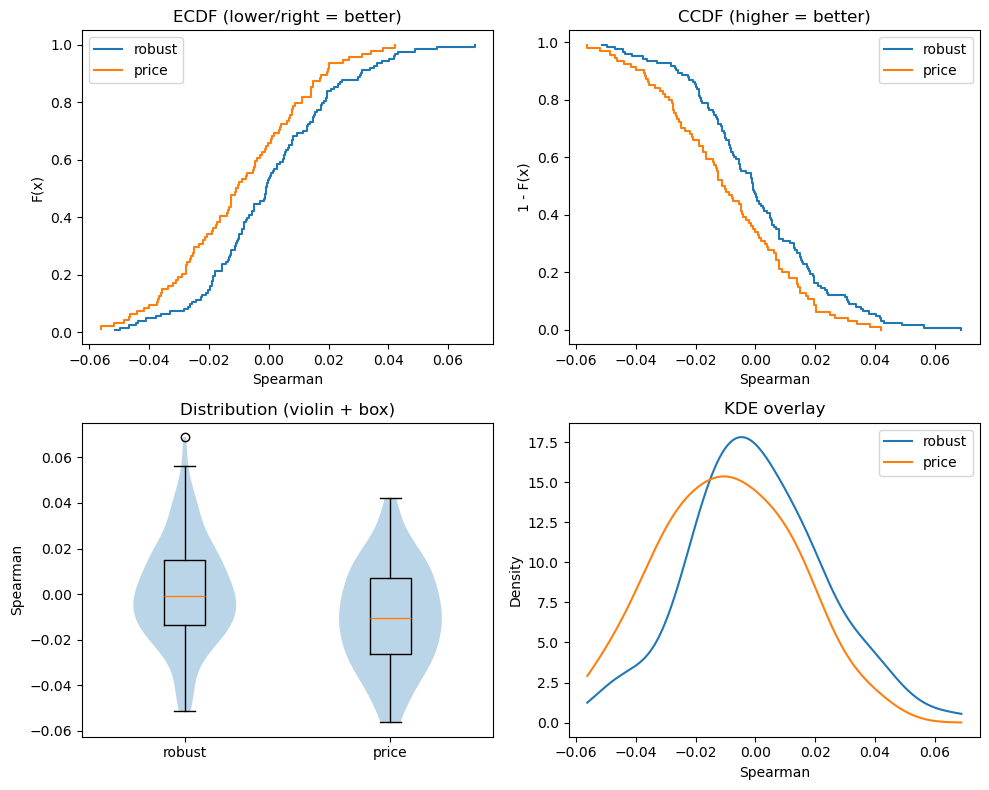

--- Summary ---
robust    n= 123  median=-0.0009  IQR=(-0.0135,0.0151)  p5/p95=(-0.0375,0.0401)
price     n=  94  median=-0.0106  IQR=(-0.0264,0.0070)  p5/p95=(-0.0465,0.0255)

KS two-sample: stat=0.202, p=0.0214
Unpaired (Mann–Whitney U): stat=7165.0, p=0.00254
Cliff's δ: 0.239  (≈0.147 small, 0.33 medium, 0.474 large)


In [130]:
compare_distributions(feature_stable['spearman'] ,feature_stable2['spearman'], labels=('robust','price'), metric_name='Spearman')

**SSE 50 Index Futures**

In [131]:
# Mask True
ih_robust = treemodel_factors_augment(ticker = 'ih_main', verbose = True, target = 'ret1', frequency = 'day', augment = False, light = False, mask = True)
ih_robust.quick_evaluation()

[rolling_corr_report] slices=10, corr_thresh=0.9, pairs_reported=2 (presence ≥ 70%)
                                Pair  freq  presence  mean_abs_corr  \
0  LinReg_Residual_Z_5 — mr_inst_z_S    10       1.0       0.940521   
1           exhaustion_alpha9 — ret1     7       0.7       0.948495   

   max_abs_corr  n_slices  
0      0.956366        10  
1      0.987729        10  


In [132]:
# Mask = False 
if_robust = treemodel_factors_augment(ticker = 'ih_main', verbose = True, target = 'ret1', frequency = 'day', augment = False, light = False, mask = False)
if_robust.quick_evaluation()

[rolling_corr_report] slices=10, corr_thresh=0.9, pairs_reported=1 (presence ≥ 70%)
                       Pair  freq  presence  mean_abs_corr  max_abs_corr  \
0  exhaustion_alpha9 — ret1     7       0.7        0.95299      0.988552   

   n_slices  
0        10  


For the SSE 50 index futures, the overall statistical characteristics of the engineered factor library are broadly consistent with those observed for the CSI 500 and CSI 300, while the overall signal strength remains at a moderate level.

Among the 123 factors, only one to two highly correlated factor pairs persist across 10 rolling windows (|ρ| > 0.9, presence ≥ 70%), with no evidence of systematic redundancy among the remaining factors. All factors satisfy coverage and effective sample size requirements, with a median effective sample size exceeding 2,300, indicating stable temporal availability.

In terms of effectiveness metrics, approximately 47% of factors meet the Spearman-based effectiveness criterion, and around two-thirds exhibit directional consistency above 0.55. In addition, about 39% of factors show roll penalties above 0.10, a level comparable to the CSI 500 and slightly higher than that observed for the CSI 300, suggesting that the roll-related impact for SSE 50 lies between the two in magnitude.

在 上证 50（SSE 50）指数期货上，工程化因子库的整体统计特征与此前在中证 500 与沪深 300 上的观察基本一致，但整体信号强度处于中等水平。

在 123 个因子中，仅观察到 1–2 组在 10 个滚动窗口中持续出现的高度相关因子对（|ρ| > 0.9，出现率 ≥ 70%），其余因子之间未表现出系统性冗余。同时，所有因子均满足覆盖率与有效样本规模要求，中位有效样本量超过 2300，表明因子在时间维度上的可用性与稳定性较高。

从有效性指标来看，约 47% 的因子在 Spearman 维度上达到有效相关性标准，方向一致性指标超过 0.55 的因子占比约为 2/3；此外，约 39% 的因子 roll penalty 高于 0.10，该比例与中证 500 的结果相近，且略高于沪深 300，反映出上证 50 在换月结构层面的影响介于两者之间。

In [133]:
rp_A = corr_check(ticker = 'ih_main',family="all",cls=treemodel_factors_daily, selection=False,light=False, verbose=False, mask = False)['roll_penalty'].dropna()
rp_B = corr_check(ticker = 'ih_main',family="all",cls=treemodel_factors_augment, selection=False,light=False, verbose=False, mask = False)['roll_penalty'].dropna()
rp_C = corr_check(ticker = 'ih_main',family="all",cls=treemodel_factors_augment, selection=False,light=False, verbose=False, mask = True)['roll_penalty'].dropna()
rp_D = corr_check(ticker = 'ih_main',family="all",cls=treemodel_factors_augment_loose, selection=False,light=False, verbose=False, mask = True)['roll_penalty'].dropna()

target 1 period next return created
target 1 period next return created


In [134]:
pd.DataFrame({"Raw Ta-Lib": summarize_rp(rp_A), "Segment Unmasked": summarize_rp(rp_B),"Segment": summarize_rp(rp_B), "Segment Loose": summarize_rp(rp_D)})

Raw Ta-Lib  Segment Unmasked     Segment  Segment Loose
n              94.000000        123.000000  123.000000     166.000000
mean            0.245856          0.159286    0.159286       0.125370
median          0.109064          0.000000    0.000000       0.000000
p75             0.463729          0.261898    0.261898       0.204239
p90             0.694575          0.547442    0.547442       0.482246
p95             0.728635          0.597418    0.597418       0.575470
p99             0.871558          0.966963    0.966963       0.761660
pct_eq_0        0.425532          0.536585    0.536585       0.596386
pct_lt_0.10     0.500000          0.609756    0.609756       0.686747
pct_lt_0.20+    0.457447          0.292683    0.292683       0.253012

In [135]:
ks_2samp(rp_A.values, rp_B.values)

KstestResult(statistic=np.float64(0.20039785504238022), pvalue=np.float64(0.023195595089589852), statistic_location=np.float64(0.2705125127481499), statistic_sign=np.int8(-1))

Visualization of highly correlated variables (threshold=0.9)
By Default Past 90 Percent will be the Train + Validation Set. No analysis will be performed on the last 10 Percent


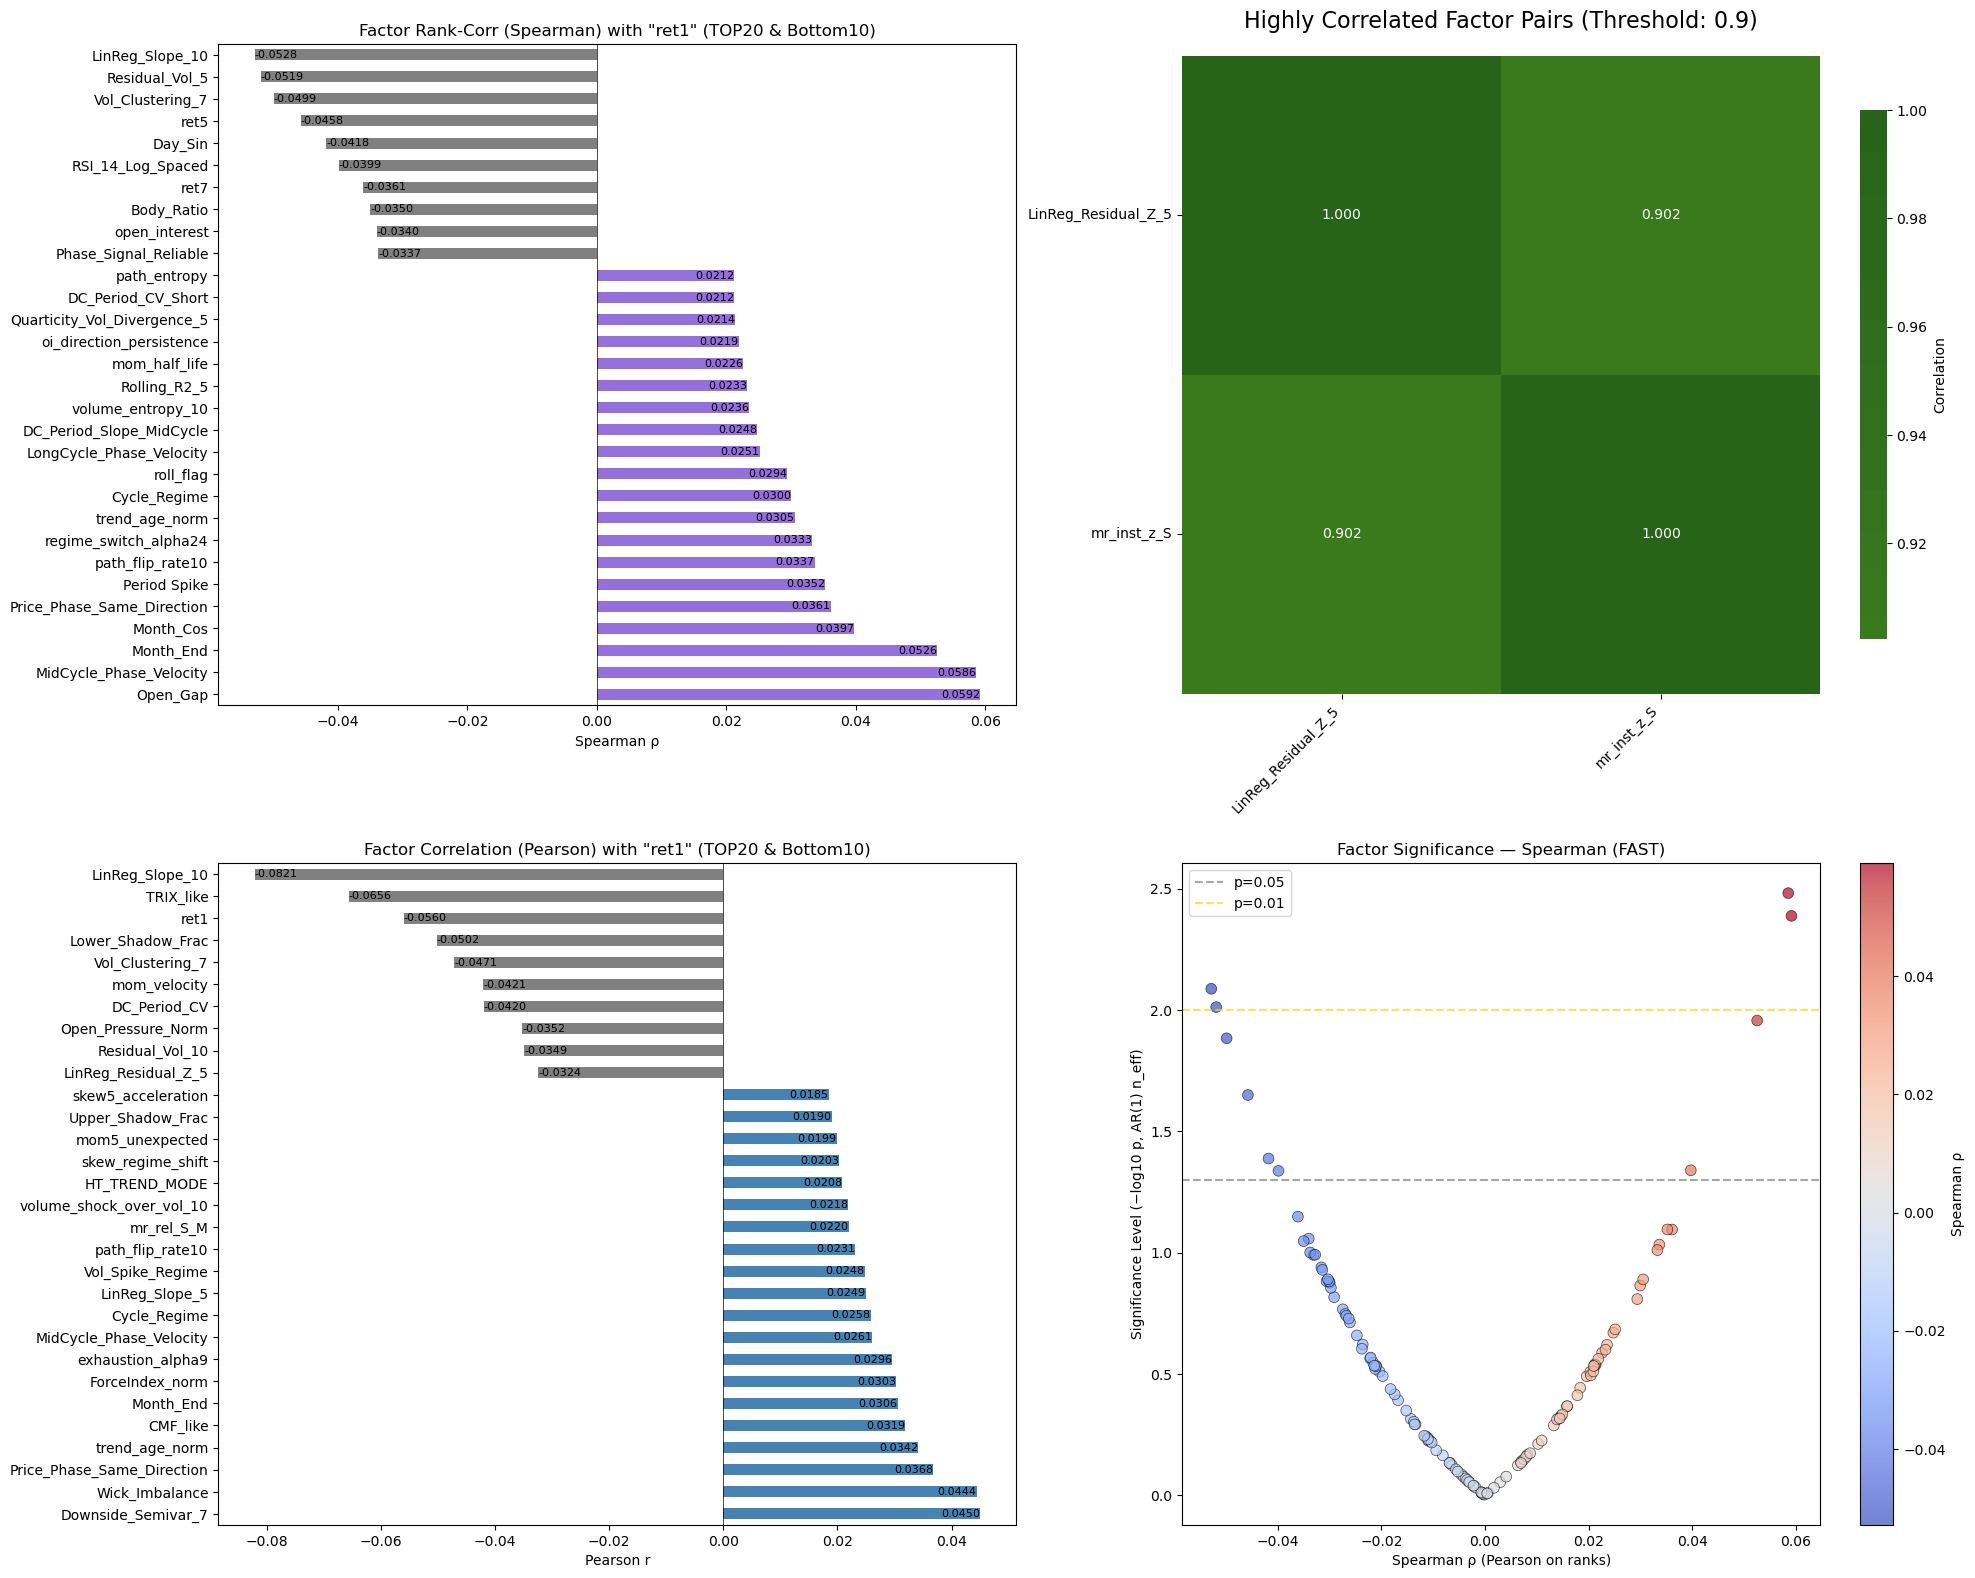


=== Report (Spearman primary / Pearson secondary) ===
 Spearman Average ρ: -0.003323
 Max Spearman ρ: 0.059178 (Open_Gap)
 Min Spearman ρ: -0.052843 (LinReg_Slope_10)
 Pearson Average r: -0.001526
 Max Pearson r: 0.044974 (Downside_Semivar_7)
 Min Pearson r: -0.082104 (LinReg_Slope_10)
Number of highly correlated pairs (|r|>0.9): 1
 Spearman (AR1 on ranks): p<0.01 4 (3.2%), p<0.05 10 (8.0%), p<0.20 36 (28.8%)
 Pearson (AR1 adj):       p<0.01 3 (2.4%), p<0.05 9 (7.2%), p<0.20 23 (18.4%)
factors created 123

Significant features by Spearman (FAST, q<0.20):
  (36): open_interest, roll_flag, Vol_Composite_5_7, ATR_r_5, Vol_Term_Structure_5_7, BB_%B_Pos_r_7, Vol_Mean_Reversion_5v7, High_Volatility_Regime, Ret_Var_Corr_7, Vol_Clustering_7, DC_Period_CV, Cycle_Regime, Price_Phase_Same_Direction, Cycle_Fast_Up, Phase_Signal_Reliable, MidCycle_Phase_Velocity, Period Spike, ret5, ret7, ret5_volatility_adj, mom_efficiency, RSI_14_Log_Spaced, mom_efficiency_fast, path_flip_rate10, Day_Sin, Month_

In [136]:
feature_stable = corr_check(ticker = 'ih_main',family="all",cls=treemodel_factors_augment, selection=False,light=False, verbose=True, mask = False)

From the Spearman distribution comparison, the engineered factor library exhibits a distributional profile consistent with previous observations on CSI 300 and CSI 500, and is overall more favorable than the price-based (raw / outsourced) factor library. The engineered distribution shows a higher median, a significantly compressed left tail (negative IC region), and a marked reduction in extreme negatively correlated factors. In addition, within the moderately positive IC range, the engineered factors dominate in terms of CCDF, indicating improved signal concentration while effectively suppressing structural noise and incidental bias.

从 Spearman 分布对比可以看出，工程化因子库在该标的上的整体表现与此前在 沪深 300 与中证 500 上的观察一致，相较于价格型（原始 / 外包）因子库呈现出更为有利的分布形态。其 分布中位数更高，左尾（负 IC 区间）显著收敛，极端负相关因子的数量明显减少；同时，在 中等正相关区间 内，工程化因子库的 CCDF 表现占优，表明其在保留有效信号的同时，对结构性噪声与偶然偏置具有更强的抑制能力。

In [137]:
# comparison group 
feature_stable2 = corr_check(ticker = 'ih_main',family="all",cls=treemodel_factors_daily, selection=False,light=False, verbose= False, mask = False)

target 1 period next return created


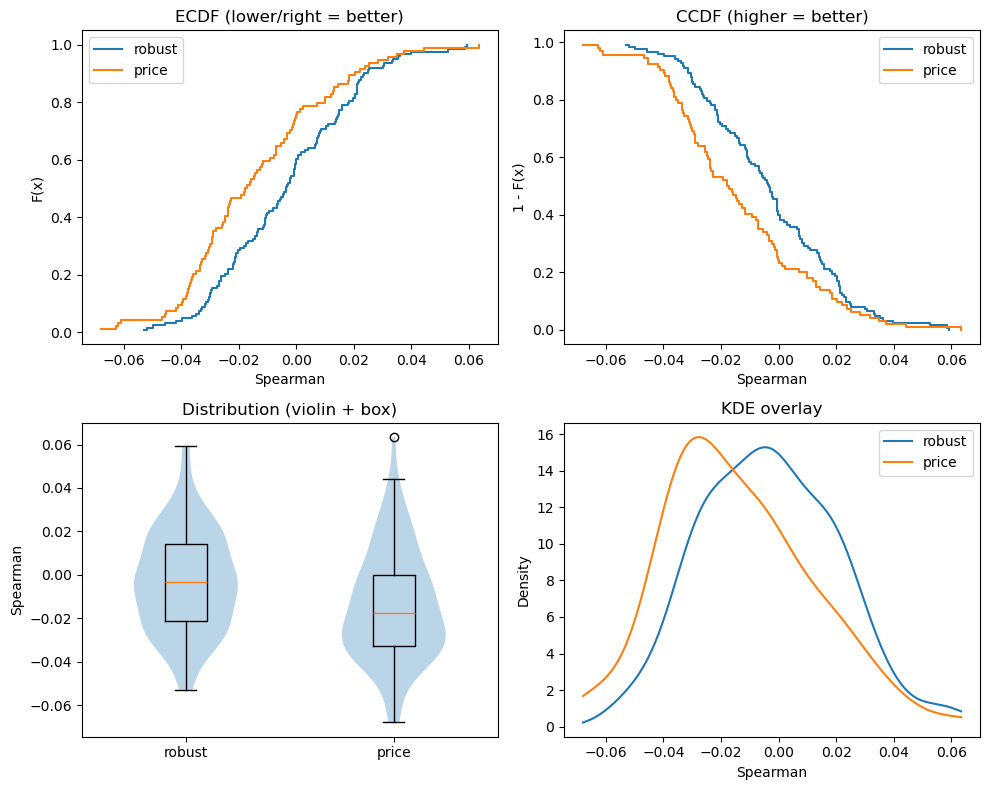

--- Summary ---
robust    n= 123  median=-0.0034  IQR=(-0.0213,0.0143)  p5/p95=(-0.0360,0.0336)
price     n=  94  median=-0.0175  IQR=(-0.0325,-0.0002)  p5/p95=(-0.0459,0.0296)

KS two-sample: stat=0.249, p=0.00216
Unpaired (Mann–Whitney U): stat=7343.0, p=0.000657
Cliff's δ: 0.270  (≈0.147 small, 0.33 medium, 0.474 large)


In [138]:
compare_distributions(feature_stable['spearman'] ,feature_stable2['spearman'], labels=('robust','price'), metric_name='Spearman')

#### **Acknowledgement**

The current robust factor construction achieves marginal yet consistent improvements while preserving the predictive capability of the TA-Lib baseline, with clearer and more interpretable information content.

By explicitly accounting for dominant contract characteristics and roll structures, factor signals exhibit improved stability and interpretability, yielding time-series features that are better aligned with realistic trading conditions.

It should be emphasized that the observed improvements are primarily driven by internal structural refinement within individual time series. In the absence of external information, such approaches are more effective at enhancing signal quality and robustness than at delivering order-of-magnitude performance gains, with returns naturally exhibiting diminishing marginal improvements.

Based on these considerations, and given practical constraints on team resources and development cadence, we elect at this stage to report feature-engineering outcomes as the primary deliverable, with results demonstrating consistent and generalizable behavior across multiple tickers.

In parallel, we are exploring a limited set of macro- or contract-level sparse features (e.g., signals derived from contract specifications, term structure, or macro regime shifts). However, due to their narrow applicability (often confined to specific instruments or subsets) and low activation frequency, these features are not discussed further in the present analysis.

当前稳健化因子构造在维持 TA-Lib 基线预测能力 的前提下，实现了边际但一致、且信息表达更加清晰的改进。

通过显式刻画主力合约特性与换月结构，因子信号在稳定性与可解释性层面均有所提升，所生成的时间序列特征也更加贴近真实交易环境下的行为特征。

需要强调的是，现阶段的改进主要来源于单一时间序列内部的结构性重构。在不引入外生信息的情况下，此类方法更有助于提升信号质量与鲁棒性，而非带来数量级层面的性能突破，其收益特征天然呈现出边际递减。

基于上述判断，并结合团队资源与研发节奏的现实约束，我们在当前阶段选择将特征工程阶段性成果作为核心汇报内容，相关结果在多个标的上均表现出一致性与可推广性。

与此同时，我们也在探索少量宏观或合约层面的稀疏特征（例如基于合约制度、期限结构或宏观状态切换的信号）。但由于此类特征的适用范围相对有限（往往集中于单一品种或特定子集），且触发频率较低，本文中不再展开讨论。